# Ex 5: Agent learning environment

In [1]:
import numpy as np
import scipy.special as sp
import matplotlib.pyplot as plt
import dill
from os import makedirs

## Agent

In [2]:
class Agent:

    states = 1
    actions = 1
    discount = 0.9
    max_reward = 1
    qtable = np.matrix([1])
    softmax = False
    sarsa = False
    
    # Reward: R = sum_t λ^t · r_t
    #		r_t <= x for every t
    #		R <= x sum_t λ^t
    #		R <= x·(1/(1-λ))
    #
    # With this in mind, setting a initial Q-value near the threshold x·(1/(1-λ)) makes
    # 	the agent be curious and try to explore the space, otherwise the agent will
    #		get stuck in the first "positive" point
    
    # initialize
    def __init__(self, states, actions, discount, max_reward, softmax, sarsa):
        self.states = states
        self.actions = actions
        self.discount = discount
        self.max_reward = max_reward
        self.softmax = softmax
        self.sarsa = sarsa
        # initialize Q table
        self.qtable = np.ones([states, actions], dtype = float) * max_reward / (1 - discount)
        
    # update function (Sarsa and Q-learning)
    def update(self, state, action, reward, next_state, alpha, epsilon):
        # find the next action (greedy for Q-learning, using the decision policy for Sarsa)
        if not(self.sarsa):
            next_action = self.select_action(next_state, 0)
        if (self.sarsa):
            next_action = self.select_action(next_state, epsilon)
        # calculate long-term reward with bootstrap method
        observed = reward + self.discount * self.qtable[next_state, next_action]
        # bootstrap update
        self.qtable[state, action] = self.qtable[state, action] * (1 - alpha) + observed * alpha
        
    # action policy: implements epsilon greedy and softmax
    def select_action(self, state, epsilon):
        qval = self.qtable[state]
        prob = []
        if (self.softmax):
            # use Softmax distribution
            prob = sp.softmax(qval / epsilon)
            prob[np.isnan(prob)] = -np.inf
        else:
            # assign equal value to all actions
            prob = np.ones(self.actions) * epsilon / (self.actions - 1)
            # the best action is taken with probability 1 - epsilon
            prob[np.argmax(qval)] = 1 - epsilon
        return np.random.choice(range(0, self.actions), p = prob)


# N.B.:	prob = ε/(N-1) for all actions but the best one
#		prob = 1-ε for the best action
#	This probabilities can be used because they are normalized using softmax...
#	N.B.: usually the softmax distribution is used to describe the particles in a physical system
#		so usually at the denominator there should be a temperature
#		With 0 temperature: prob 1 for the max and 0 to the others
#		With inf temperature: prob = "flat for all"

## Environment

In [3]:
class Environment:

    state = []
    goal = []
    boundary = []
    action_map = {
        0: [0, 0],
        1: [0, 1],
        2: [0, -1],
        3: [1, 0],
        4: [-1, 0],
    }
    
    def __init__(self, x, y, initial, goal, walls=None, sand=None):
        self.boundary = np.asarray([x, y])
        self.state = np.asarray(initial)
        self.goal = goal
        
        # A wall is described by 4 coordinates:
        #  [[x1, y1], [x2, y2]] which are the grid points between which the wall is
        #  Walls should be a list of this kind of lists
        if walls != None:
            self.walls = []
            for wall in walls:
                # Appending walls "in both directions"
                self.walls.append(wall)
                self.walls.append([wall[1], wall[0]])
            self.walls = np.array(self.walls)
        else:
            self.walls = None
        
        # Adding sand if present
        if sand != None:
            self.sand = sand
        else:
            self.sand = None
    
    # the agent makes an action (0 is stay, 1 is up, 2 is down, 3 is right, 4 is left)
    def move(self, action):
        reward = 0
        movement = self.action_map[action]
        if (action == 0 and (self.state == self.goal).all()):
            reward = 1
        next_state = self.state + np.asarray(movement)

        if(self.check_boundaries(next_state)):
            reward = -1
        elif (np.all(self.walls != None) and self.check_walls(next_state)):
            reward = 0
        elif (np.all(self.sand != None) and self.check_sand(next_state)):
            # Fixing arbitrary negative reward
            reward = -0.01
            self.state = next_state
        else:
            self.state = next_state

        return [self.state, reward]

    # map action index to movement
    def check_boundaries(self, state):
        out = len([num for num in state if num < 0])
        out += len([num for num in (self.boundary - np.asarray(state)) if num <= 0])
        return out > 0
    
    # checking walls
    def check_walls(self, next_state):
        try_wall = np.asarray([self.state, next_state])
        test = False
        for wall in self.walls:
            if np.all(wall == try_wall):
                test = True
        return test
    
    # checking "sand"
    def check_sand(self, next_state):
        test = False
        for sand in self.sand:
            if np.all(next_state == sand):
                test = True
        return test

## Training: defining some useful functions and utilities

In [4]:
# Defining different policies

def inverdet_lin(episodes):
    return np.linspace(0.8, 0.001,episodes)

def stair_case(episodes):
    l = episodes
    y = np.zeros(l)
    
    y[:int(0.2*l)] = 1.
    y[int(0.2*l):int(0.4*l)] = 0.75
    y[int(0.4*l):int(0.6*l)] = 0.5
    y[int(0.6*l):int(0.8*l)] = 0.25
    y[int(0.8*l):] = 0.001
    
    return y

def cut_hyperb(episodes):
    l = episodes
    x = np.linspace(0, 10, l)
    y = np.zeros(l)
    
    y[:int(0.2*l)] = 1./x[int(0.2*l)]
    y[int(0.2*l):] = 1./x[int(0.2*l):]
    
    return y


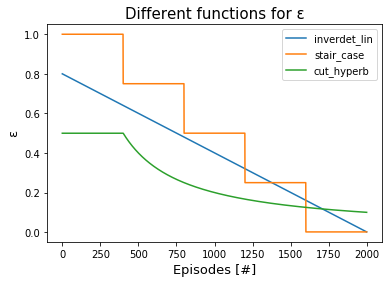

In [5]:
l = 2000
plt.title("Different functions for ε", fontsize=15)
plt.plot(inverdet_lin(l), label = "inverdet_lin")
plt.plot(stair_case(l), label = "stair_case")
plt.plot(cut_hyperb(l), label = "cut_hyperb")

plt.xlabel("Episodes [#]", fontsize=13)
plt.ylabel("ε", fontsize=13)

plt.legend()
plt.show()

In [6]:
path_img = "./results"
makedirs(path_img, exist_ok=True)

In [7]:
def plot_wall(wall, cont):
    #print(wall)
    
    # when plotting the first wall the label can be set
    if cont == 0:
        # If no difference in the x, the wall is horizontal
        if (wall[0][0] - wall[1][0]) == 0:
            plt.plot([wall[0][0]-0.5, wall[1][0]+0.5], [(wall[0][1]+wall[1][1])/2,(wall[0][1]+wall[1][1])/2],
                     "-", color="#0000ff", label="Wall")
        # If no difference in the y, the wall is vertical
        elif (wall[0][1] - wall[1][1]) == 0:
            plt.plot([(wall[0][0]+wall[1][0])/2, (wall[0][0]+wall[1][0])/2], [wall[0][1]+0.5,wall[1][1]-0.5],
                     "-", color="#0000ff", label="Wall")
    else:
        # If no difference in the x, the wall is horizontal
        if (wall[0][0] - wall[1][0]) == 0:
            plt.plot([wall[0][0]-0.5, wall[1][0]+0.5], [(wall[0][1]+wall[1][1])/2,(wall[0][1]+wall[1][1])/2],
                     "-", color="#0000ff")
        # If no difference in the y, the wall is vertical
        elif (wall[0][1] - wall[1][1]) == 0:
            plt.plot([(wall[0][0]+wall[1][0])/2, (wall[0][0]+wall[1][0])/2], [wall[0][1]+0.5,wall[1][1]-0.5],
                     "-", color="#0000ff")


# Starting various experiments (training + plots)

## Comparing Q-learning and SARSA (making them start from the same position)

## Q-learning

In [10]:
episodes = 2000         # number of training episodes
episode_length = 50     # maximum episode length
x = 10                  # horizontal size of the box
y = 10                  # vertical size of the box
goal = [0, 3]           # objective point
discount = 0.9          # exponential discount factor
softmax = False         # set to true to use Softmax policy
sarsa = False           # set to true to use the Sarsa algorithm
init_window = [[9,10],[9,10]]   # set [x1,x2],[y1,y2] generation interval for the x,y initial position

# TODO alpha and epsilon profile
alpha = np.ones(episodes) * 0.25
epsilon = np.linspace(0.8, 0.001,episodes)

# So the best action gets 1-ε, so 0.2
# 	the others get ε/(N-1)

# initialize the agent
learner = Agent((x * y), 5, discount, max_reward=1, softmax=softmax, sarsa=sarsa)

# perform the training
for index in range(0, episodes):
    # start from a random state
    initial = [np.random.randint(init_window[0][0], init_window[0][1]),
               np.random.randint(init_window[1][0], init_window[1][1])]
    # initialize environment
    state = initial
    
    # list of actions to visualize the track
    list_states = [initial]
    
    env = Environment(x, y, state, goal, walls = None, sand=None)
    reward = 0
    # run episode
    for step in range(0, episode_length):
        # find state index (vectorize the state in the matrix?)
        state_index = state[0] * y + state[1]
        # choose an action
        action = learner.select_action(state_index, epsilon[index])
        # the agent moves in the environment
        result = env.move(action)
        
        # Saving the last list of actions
        if (index == episodes-1):
            list_states.append(result[0])
        
        # Q-learning update
        next_index = result[0][0] * y + result[0][1]
        learner.update(state_index, action, result[1], next_index, alpha[index], epsilon[index])
        # update state and reward
        reward += result[1]
        state = result[0]
    # Only to track the average reward
    reward /= episode_length
    print('Episode ', index + 1, ': the agent has obtained an average reward of ', reward, ' starting from position ', initial) 
    
    # periodically save the agent
    if ((index + 1) % 10 == 0):
        with open('agent.obj', 'wb') as agent_file:
            dill.dump(learner, agent_file)

Episode  1 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  2 : the agent has obtained an average reward of  -0.2  starting from position  [9, 9]
Episode  3 : the agent has obtained an average reward of  -0.2  starting from position  [9, 9]
Episode  4 : the agent has obtained an average reward of  -0.16  starting from position  [9, 9]
Episode  5 : the agent has obtained an average reward of  -0.24  starting from position  [9, 9]
Episode  6 : the agent has obtained an average reward of  -0.1  starting from position  [9, 9]
Episode  7 : the agent has obtained an average reward of  -0.06  starting from position  [9, 9]
Episode  8 : the agent has obtained an average reward of  -0.14  starting from position  [9, 9]
Episode  9 : the agent has obtained an average reward of  -0.1  starting from position  [9, 9]
Episode  10 : the agent has obtained an average reward of  -0.16  starting from position  [9, 9]
Episode  11 : the agent has obtained an ave

Episode  98 : the agent has obtained an average reward of  -0.1  starting from position  [9, 9]
Episode  99 : the agent has obtained an average reward of  -0.14  starting from position  [9, 9]
Episode  100 : the agent has obtained an average reward of  -0.14  starting from position  [9, 9]
Episode  101 : the agent has obtained an average reward of  -0.06  starting from position  [9, 9]
Episode  102 : the agent has obtained an average reward of  -0.26  starting from position  [9, 9]
Episode  103 : the agent has obtained an average reward of  -0.08  starting from position  [9, 9]
Episode  104 : the agent has obtained an average reward of  -0.08  starting from position  [9, 9]
Episode  105 : the agent has obtained an average reward of  -0.1  starting from position  [9, 9]
Episode  106 : the agent has obtained an average reward of  -0.14  starting from position  [9, 9]
Episode  107 : the agent has obtained an average reward of  -0.12  starting from position  [9, 9]
Episode  108 : the agent

Episode  190 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  191 : the agent has obtained an average reward of  -0.16  starting from position  [9, 9]
Episode  192 : the agent has obtained an average reward of  -0.16  starting from position  [9, 9]
Episode  193 : the agent has obtained an average reward of  -0.02  starting from position  [9, 9]
Episode  194 : the agent has obtained an average reward of  -0.1  starting from position  [9, 9]
Episode  195 : the agent has obtained an average reward of  -0.06  starting from position  [9, 9]
Episode  196 : the agent has obtained an average reward of  -0.14  starting from position  [9, 9]
Episode  197 : the agent has obtained an average reward of  -0.06  starting from position  [9, 9]
Episode  198 : the agent has obtained an average reward of  -0.06  starting from position  [9, 9]
Episode  199 : the agent has obtained an average reward of  -0.14  starting from position  [9, 9]
Episode  200 : the ag

Episode  287 : the agent has obtained an average reward of  -0.14  starting from position  [9, 9]
Episode  288 : the agent has obtained an average reward of  -0.12  starting from position  [9, 9]
Episode  289 : the agent has obtained an average reward of  -0.1  starting from position  [9, 9]
Episode  290 : the agent has obtained an average reward of  -0.06  starting from position  [9, 9]
Episode  291 : the agent has obtained an average reward of  -0.1  starting from position  [9, 9]
Episode  292 : the agent has obtained an average reward of  0.0  starting from position  [9, 9]
Episode  293 : the agent has obtained an average reward of  -0.08  starting from position  [9, 9]
Episode  294 : the agent has obtained an average reward of  -0.14  starting from position  [9, 9]
Episode  295 : the agent has obtained an average reward of  -0.1  starting from position  [9, 9]
Episode  296 : the agent has obtained an average reward of  -0.34  starting from position  [9, 9]
Episode  297 : the agent 

Episode  382 : the agent has obtained an average reward of  0.0  starting from position  [9, 9]
Episode  383 : the agent has obtained an average reward of  -0.02  starting from position  [9, 9]
Episode  384 : the agent has obtained an average reward of  -0.1  starting from position  [9, 9]
Episode  385 : the agent has obtained an average reward of  -0.02  starting from position  [9, 9]
Episode  386 : the agent has obtained an average reward of  -0.08  starting from position  [9, 9]
Episode  387 : the agent has obtained an average reward of  -0.1  starting from position  [9, 9]
Episode  388 : the agent has obtained an average reward of  -0.08  starting from position  [9, 9]
Episode  389 : the agent has obtained an average reward of  -0.08  starting from position  [9, 9]
Episode  390 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  391 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  392 : the agent

Episode  475 : the agent has obtained an average reward of  -0.02  starting from position  [9, 9]
Episode  476 : the agent has obtained an average reward of  -0.08  starting from position  [9, 9]
Episode  477 : the agent has obtained an average reward of  -0.08  starting from position  [9, 9]
Episode  478 : the agent has obtained an average reward of  0.0  starting from position  [9, 9]
Episode  479 : the agent has obtained an average reward of  -0.02  starting from position  [9, 9]
Episode  480 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  481 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  482 : the agent has obtained an average reward of  -0.08  starting from position  [9, 9]
Episode  483 : the agent has obtained an average reward of  -0.06  starting from position  [9, 9]
Episode  484 : the agent has obtained an average reward of  -0.08  starting from position  [9, 9]
Episode  485 : the age

Episode  569 : the agent has obtained an average reward of  0.02  starting from position  [9, 9]
Episode  570 : the agent has obtained an average reward of  -0.22  starting from position  [9, 9]
Episode  571 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  572 : the agent has obtained an average reward of  -0.08  starting from position  [9, 9]
Episode  573 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  574 : the agent has obtained an average reward of  -0.02  starting from position  [9, 9]
Episode  575 : the agent has obtained an average reward of  0.02  starting from position  [9, 9]
Episode  576 : the agent has obtained an average reward of  -0.08  starting from position  [9, 9]
Episode  577 : the agent has obtained an average reward of  -0.02  starting from position  [9, 9]
Episode  578 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  579 : the age

Episode  662 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  663 : the agent has obtained an average reward of  0.0  starting from position  [9, 9]
Episode  664 : the agent has obtained an average reward of  -0.02  starting from position  [9, 9]
Episode  665 : the agent has obtained an average reward of  0.04  starting from position  [9, 9]
Episode  666 : the agent has obtained an average reward of  -0.08  starting from position  [9, 9]
Episode  667 : the agent has obtained an average reward of  -0.16  starting from position  [9, 9]
Episode  668 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  669 : the agent has obtained an average reward of  0.0  starting from position  [9, 9]
Episode  670 : the agent has obtained an average reward of  -0.02  starting from position  [9, 9]
Episode  671 : the agent has obtained an average reward of  0.0  starting from position  [9, 9]
Episode  672 : the agent ha

Episode  762 : the agent has obtained an average reward of  -0.02  starting from position  [9, 9]
Episode  763 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  764 : the agent has obtained an average reward of  0.0  starting from position  [9, 9]
Episode  765 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  766 : the agent has obtained an average reward of  0.04  starting from position  [9, 9]
Episode  767 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  768 : the agent has obtained an average reward of  0.02  starting from position  [9, 9]
Episode  769 : the agent has obtained an average reward of  0.08  starting from position  [9, 9]
Episode  770 : the agent has obtained an average reward of  0.0  starting from position  [9, 9]
Episode  771 : the agent has obtained an average reward of  0.14  starting from position  [9, 9]
Episode  772 : the agent has

Episode  858 : the agent has obtained an average reward of  0.06  starting from position  [9, 9]
Episode  859 : the agent has obtained an average reward of  0.04  starting from position  [9, 9]
Episode  860 : the agent has obtained an average reward of  -0.02  starting from position  [9, 9]
Episode  861 : the agent has obtained an average reward of  0.02  starting from position  [9, 9]
Episode  862 : the agent has obtained an average reward of  0.02  starting from position  [9, 9]
Episode  863 : the agent has obtained an average reward of  0.04  starting from position  [9, 9]
Episode  864 : the agent has obtained an average reward of  0.02  starting from position  [9, 9]
Episode  865 : the agent has obtained an average reward of  0.1  starting from position  [9, 9]
Episode  866 : the agent has obtained an average reward of  -0.02  starting from position  [9, 9]
Episode  867 : the agent has obtained an average reward of  0.14  starting from position  [9, 9]
Episode  868 : the agent has 

Episode  953 : the agent has obtained an average reward of  0.18  starting from position  [9, 9]
Episode  954 : the agent has obtained an average reward of  0.04  starting from position  [9, 9]
Episode  955 : the agent has obtained an average reward of  0.02  starting from position  [9, 9]
Episode  956 : the agent has obtained an average reward of  0.22  starting from position  [9, 9]
Episode  957 : the agent has obtained an average reward of  0.0  starting from position  [9, 9]
Episode  958 : the agent has obtained an average reward of  0.18  starting from position  [9, 9]
Episode  959 : the agent has obtained an average reward of  0.22  starting from position  [9, 9]
Episode  960 : the agent has obtained an average reward of  0.08  starting from position  [9, 9]
Episode  961 : the agent has obtained an average reward of  0.04  starting from position  [9, 9]
Episode  962 : the agent has obtained an average reward of  0.04  starting from position  [9, 9]
Episode  963 : the agent has ob

Episode  1046 : the agent has obtained an average reward of  0.02  starting from position  [9, 9]
Episode  1047 : the agent has obtained an average reward of  0.22  starting from position  [9, 9]
Episode  1048 : the agent has obtained an average reward of  0.02  starting from position  [9, 9]
Episode  1049 : the agent has obtained an average reward of  -0.02  starting from position  [9, 9]
Episode  1050 : the agent has obtained an average reward of  0.08  starting from position  [9, 9]
Episode  1051 : the agent has obtained an average reward of  0.12  starting from position  [9, 9]
Episode  1052 : the agent has obtained an average reward of  0.14  starting from position  [9, 9]
Episode  1053 : the agent has obtained an average reward of  0.22  starting from position  [9, 9]
Episode  1054 : the agent has obtained an average reward of  0.16  starting from position  [9, 9]
Episode  1055 : the agent has obtained an average reward of  0.14  starting from position  [9, 9]
Episode  1056 : the

Episode  1139 : the agent has obtained an average reward of  0.14  starting from position  [9, 9]
Episode  1140 : the agent has obtained an average reward of  0.18  starting from position  [9, 9]
Episode  1141 : the agent has obtained an average reward of  0.2  starting from position  [9, 9]
Episode  1142 : the agent has obtained an average reward of  0.12  starting from position  [9, 9]
Episode  1143 : the agent has obtained an average reward of  0.24  starting from position  [9, 9]
Episode  1144 : the agent has obtained an average reward of  0.3  starting from position  [9, 9]
Episode  1145 : the agent has obtained an average reward of  0.26  starting from position  [9, 9]
Episode  1146 : the agent has obtained an average reward of  0.18  starting from position  [9, 9]
Episode  1147 : the agent has obtained an average reward of  0.08  starting from position  [9, 9]
Episode  1148 : the agent has obtained an average reward of  0.34  starting from position  [9, 9]
Episode  1149 : the ag

Episode  1237 : the agent has obtained an average reward of  0.1  starting from position  [9, 9]
Episode  1238 : the agent has obtained an average reward of  0.3  starting from position  [9, 9]
Episode  1239 : the agent has obtained an average reward of  0.36  starting from position  [9, 9]
Episode  1240 : the agent has obtained an average reward of  0.14  starting from position  [9, 9]
Episode  1241 : the agent has obtained an average reward of  0.2  starting from position  [9, 9]
Episode  1242 : the agent has obtained an average reward of  0.24  starting from position  [9, 9]
Episode  1243 : the agent has obtained an average reward of  0.14  starting from position  [9, 9]
Episode  1244 : the agent has obtained an average reward of  0.3  starting from position  [9, 9]
Episode  1245 : the agent has obtained an average reward of  0.08  starting from position  [9, 9]
Episode  1246 : the agent has obtained an average reward of  0.24  starting from position  [9, 9]
Episode  1247 : the agen

Episode  1336 : the agent has obtained an average reward of  0.26  starting from position  [9, 9]
Episode  1337 : the agent has obtained an average reward of  0.12  starting from position  [9, 9]
Episode  1338 : the agent has obtained an average reward of  0.2  starting from position  [9, 9]
Episode  1339 : the agent has obtained an average reward of  0.34  starting from position  [9, 9]
Episode  1340 : the agent has obtained an average reward of  0.2  starting from position  [9, 9]
Episode  1341 : the agent has obtained an average reward of  0.1  starting from position  [9, 9]
Episode  1342 : the agent has obtained an average reward of  0.36  starting from position  [9, 9]
Episode  1343 : the agent has obtained an average reward of  0.2  starting from position  [9, 9]
Episode  1344 : the agent has obtained an average reward of  0.32  starting from position  [9, 9]
Episode  1345 : the agent has obtained an average reward of  0.3  starting from position  [9, 9]
Episode  1346 : the agent

Episode  1435 : the agent has obtained an average reward of  0.24  starting from position  [9, 9]
Episode  1436 : the agent has obtained an average reward of  0.34  starting from position  [9, 9]
Episode  1437 : the agent has obtained an average reward of  0.32  starting from position  [9, 9]
Episode  1438 : the agent has obtained an average reward of  0.42  starting from position  [9, 9]
Episode  1439 : the agent has obtained an average reward of  0.08  starting from position  [9, 9]
Episode  1440 : the agent has obtained an average reward of  0.44  starting from position  [9, 9]
Episode  1441 : the agent has obtained an average reward of  0.34  starting from position  [9, 9]
Episode  1442 : the agent has obtained an average reward of  0.32  starting from position  [9, 9]
Episode  1443 : the agent has obtained an average reward of  0.58  starting from position  [9, 9]
Episode  1444 : the agent has obtained an average reward of  0.32  starting from position  [9, 9]
Episode  1445 : the 

Episode  1531 : the agent has obtained an average reward of  0.32  starting from position  [9, 9]
Episode  1532 : the agent has obtained an average reward of  0.36  starting from position  [9, 9]
Episode  1533 : the agent has obtained an average reward of  0.14  starting from position  [9, 9]
Episode  1534 : the agent has obtained an average reward of  0.4  starting from position  [9, 9]
Episode  1535 : the agent has obtained an average reward of  0.38  starting from position  [9, 9]
Episode  1536 : the agent has obtained an average reward of  0.28  starting from position  [9, 9]
Episode  1537 : the agent has obtained an average reward of  0.42  starting from position  [9, 9]
Episode  1538 : the agent has obtained an average reward of  0.28  starting from position  [9, 9]
Episode  1539 : the agent has obtained an average reward of  0.28  starting from position  [9, 9]
Episode  1540 : the agent has obtained an average reward of  0.4  starting from position  [9, 9]
Episode  1541 : the ag

Episode  1627 : the agent has obtained an average reward of  0.62  starting from position  [9, 9]
Episode  1628 : the agent has obtained an average reward of  0.42  starting from position  [9, 9]
Episode  1629 : the agent has obtained an average reward of  0.5  starting from position  [9, 9]
Episode  1630 : the agent has obtained an average reward of  0.5  starting from position  [9, 9]
Episode  1631 : the agent has obtained an average reward of  0.58  starting from position  [9, 9]
Episode  1632 : the agent has obtained an average reward of  0.44  starting from position  [9, 9]
Episode  1633 : the agent has obtained an average reward of  0.38  starting from position  [9, 9]
Episode  1634 : the agent has obtained an average reward of  0.38  starting from position  [9, 9]
Episode  1635 : the agent has obtained an average reward of  0.5  starting from position  [9, 9]
Episode  1636 : the agent has obtained an average reward of  0.34  starting from position  [9, 9]
Episode  1637 : the age

Episode  1726 : the agent has obtained an average reward of  0.44  starting from position  [9, 9]
Episode  1727 : the agent has obtained an average reward of  0.46  starting from position  [9, 9]
Episode  1728 : the agent has obtained an average reward of  0.5  starting from position  [9, 9]
Episode  1729 : the agent has obtained an average reward of  0.46  starting from position  [9, 9]
Episode  1730 : the agent has obtained an average reward of  0.46  starting from position  [9, 9]
Episode  1731 : the agent has obtained an average reward of  0.66  starting from position  [9, 9]
Episode  1732 : the agent has obtained an average reward of  0.5  starting from position  [9, 9]
Episode  1733 : the agent has obtained an average reward of  0.5  starting from position  [9, 9]
Episode  1734 : the agent has obtained an average reward of  0.52  starting from position  [9, 9]
Episode  1735 : the agent has obtained an average reward of  0.62  starting from position  [9, 9]
Episode  1736 : the age

Episode  1821 : the agent has obtained an average reward of  0.62  starting from position  [9, 9]
Episode  1822 : the agent has obtained an average reward of  0.62  starting from position  [9, 9]
Episode  1823 : the agent has obtained an average reward of  0.54  starting from position  [9, 9]
Episode  1824 : the agent has obtained an average reward of  0.62  starting from position  [9, 9]
Episode  1825 : the agent has obtained an average reward of  0.56  starting from position  [9, 9]
Episode  1826 : the agent has obtained an average reward of  0.58  starting from position  [9, 9]
Episode  1827 : the agent has obtained an average reward of  0.56  starting from position  [9, 9]
Episode  1828 : the agent has obtained an average reward of  0.62  starting from position  [9, 9]
Episode  1829 : the agent has obtained an average reward of  0.58  starting from position  [9, 9]
Episode  1830 : the agent has obtained an average reward of  0.64  starting from position  [9, 9]
Episode  1831 : the 

Episode  1907 : the agent has obtained an average reward of  0.68  starting from position  [9, 9]
Episode  1908 : the agent has obtained an average reward of  0.58  starting from position  [9, 9]
Episode  1909 : the agent has obtained an average reward of  0.5  starting from position  [9, 9]
Episode  1910 : the agent has obtained an average reward of  0.7  starting from position  [9, 9]
Episode  1911 : the agent has obtained an average reward of  0.66  starting from position  [9, 9]
Episode  1912 : the agent has obtained an average reward of  0.66  starting from position  [9, 9]
Episode  1913 : the agent has obtained an average reward of  0.7  starting from position  [9, 9]
Episode  1914 : the agent has obtained an average reward of  0.64  starting from position  [9, 9]
Episode  1915 : the agent has obtained an average reward of  0.6  starting from position  [9, 9]
Episode  1916 : the agent has obtained an average reward of  0.66  starting from position  [9, 9]
Episode  1917 : the agen

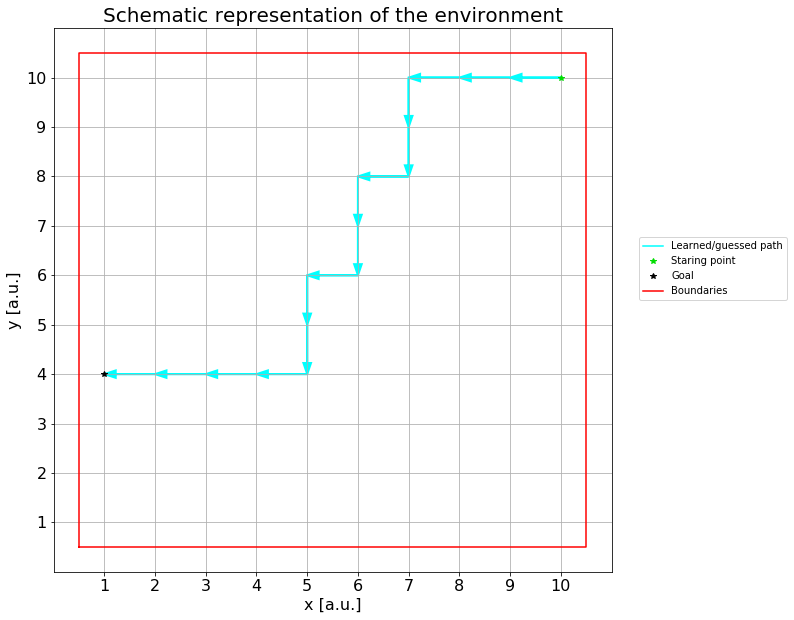

In [12]:
list_states = np.array(list_states)

plt.figure(figsize=(10,10))

# Trick to add legend
plt.plot(list_states.T[0][0:2], list_states.T[1][0:2], '-', color="#00ffff",
         label="Learned/guessed path")
# Plotting trajectory as arrows
for p1,p2 in zip(list_states[:-1], list_states[1:]):
    if np.any(p1 != p2):
        dx = p2[0] - p1[0]
        dy = p2[1] - p1[1]
        plt.arrow(p1[0], p1[1], dx, dy, color="#00ffff", shape='full', lw=2, length_includes_head=True, head_width=0.15)

plt.plot(list_states.T[0][0], list_states.T[1][0], '*', color="#00dd00", label="Staring point")
plt.plot(goal[0], goal[1], '*', color="#000000", label="Goal")


plt.xlim([-1,10])
plt.ylim([-1,10])

plt.xticks(np.arange(10), np.arange(10)+1, fontsize=16)
plt.yticks(np.arange(10), np.arange(10)+1, fontsize=16)

# Plotting bounaries
plt.plot([-0.5, 9.5, 9.5, -0.5, -0.5], [-0.5, -0.5, 9.5, 9.5, -0.5], color="#ff0000", label="Boundaries")

plt.title("Schematic representation of the environment", fontsize=20)

plt.xlabel("x [a.u.]", fontsize=16)
plt.ylabel("y [a.u.]", fontsize=16)

plt.legend(loc=(1.05,0.5))
plt.grid()

plt.savefig(str(path_img+"/ENV1_Q-learning.png"), bbox_inches='tight')

plt.show()

## SARSA

In [13]:
episodes = 2000         # number of training episodes
episode_length = 50     # maximum episode length
x = 10                  # horizontal size of the box
y = 10                  # vertical size of the box
goal = [0, 3]           # objective point
discount = 0.9          # exponential discount factor
softmax = False         # set to true to use Softmax policy
sarsa = True            # set to true to use the Sarsa algorithm
init_window = [[9,10],[9,10]]   # set [x1,x2],[y1,y2] generation interval for the x,y initial position

# TODO alpha and epsilon profile
alpha = np.ones(episodes) * 0.25
epsilon = np.linspace(0.8, 0.001,episodes)

# So the best action gets 1-ε, so 0.2
# 	the others get ε/(N-1)

# initialize the agent
learner = Agent((x * y), 5, discount, max_reward=1, softmax=softmax, sarsa=sarsa)

# perform the training
for index in range(0, episodes):
    # start from a random state
    initial = [np.random.randint(init_window[0][0], init_window[0][1]),
               np.random.randint(init_window[1][0], init_window[1][1])]
    # initialize environment
    state = initial
    
    # list of actions to visualize the track
    list_states = [initial]
    
    env = Environment(x, y, state, goal, walls = None, sand=None)
    reward = 0
    # run episode
    for step in range(0, episode_length):
        # find state index (vectorize the state in the matrix?)
        state_index = state[0] * y + state[1]
        # choose an action
        action = learner.select_action(state_index, epsilon[index])
        # the agent moves in the environment
        result = env.move(action)
        
        # Saving the last list of actions
        if (index == episodes-1):
            list_states.append(result[0])
        
        # Q-learning update
        next_index = result[0][0] * y + result[0][1]
        learner.update(state_index, action, result[1], next_index, alpha[index], epsilon[index])
        # update state and reward
        reward += result[1]
        state = result[0]
    # Only to track the average reward
    reward /= episode_length
    print('Episode ', index + 1, ': the agent has obtained an average reward of ', reward, ' starting from position ', initial) 
    
    # periodically save the agent
    if ((index + 1) % 10 == 0):
        with open('agent.obj', 'wb') as agent_file:
            dill.dump(learner, agent_file)

Episode  1 : the agent has obtained an average reward of  -0.1  starting from position  [9, 9]
Episode  2 : the agent has obtained an average reward of  -0.24  starting from position  [9, 9]
Episode  3 : the agent has obtained an average reward of  -0.08  starting from position  [9, 9]
Episode  4 : the agent has obtained an average reward of  -0.1  starting from position  [9, 9]
Episode  5 : the agent has obtained an average reward of  -0.06  starting from position  [9, 9]
Episode  6 : the agent has obtained an average reward of  -0.06  starting from position  [9, 9]
Episode  7 : the agent has obtained an average reward of  -0.14  starting from position  [9, 9]
Episode  8 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  9 : the agent has obtained an average reward of  -0.34  starting from position  [9, 9]
Episode  10 : the agent has obtained an average reward of  -0.1  starting from position  [9, 9]
Episode  11 : the agent has obtained an av

Episode  101 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  102 : the agent has obtained an average reward of  -0.06  starting from position  [9, 9]
Episode  103 : the agent has obtained an average reward of  -0.1  starting from position  [9, 9]
Episode  104 : the agent has obtained an average reward of  -0.18  starting from position  [9, 9]
Episode  105 : the agent has obtained an average reward of  -0.12  starting from position  [9, 9]
Episode  106 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  107 : the agent has obtained an average reward of  -0.3  starting from position  [9, 9]
Episode  108 : the agent has obtained an average reward of  -0.08  starting from position  [9, 9]
Episode  109 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  110 : the agent has obtained an average reward of  -0.22  starting from position  [9, 9]
Episode  111 : the age

Episode  194 : the agent has obtained an average reward of  -0.14  starting from position  [9, 9]
Episode  195 : the agent has obtained an average reward of  -0.18  starting from position  [9, 9]
Episode  196 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  197 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  198 : the agent has obtained an average reward of  -0.12  starting from position  [9, 9]
Episode  199 : the agent has obtained an average reward of  -0.18  starting from position  [9, 9]
Episode  200 : the agent has obtained an average reward of  -0.06  starting from position  [9, 9]
Episode  201 : the agent has obtained an average reward of  -0.08  starting from position  [9, 9]
Episode  202 : the agent has obtained an average reward of  -0.08  starting from position  [9, 9]
Episode  203 : the agent has obtained an average reward of  0.0  starting from position  [9, 9]
Episode  204 : the age

Episode  290 : the agent has obtained an average reward of  -0.12  starting from position  [9, 9]
Episode  291 : the agent has obtained an average reward of  -0.08  starting from position  [9, 9]
Episode  292 : the agent has obtained an average reward of  -0.06  starting from position  [9, 9]
Episode  293 : the agent has obtained an average reward of  0.0  starting from position  [9, 9]
Episode  294 : the agent has obtained an average reward of  -0.16  starting from position  [9, 9]
Episode  295 : the agent has obtained an average reward of  -0.22  starting from position  [9, 9]
Episode  296 : the agent has obtained an average reward of  -0.02  starting from position  [9, 9]
Episode  297 : the agent has obtained an average reward of  0.0  starting from position  [9, 9]
Episode  298 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  299 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  300 : the agent

Episode  382 : the agent has obtained an average reward of  -0.08  starting from position  [9, 9]
Episode  383 : the agent has obtained an average reward of  -0.1  starting from position  [9, 9]
Episode  384 : the agent has obtained an average reward of  -0.1  starting from position  [9, 9]
Episode  385 : the agent has obtained an average reward of  -0.08  starting from position  [9, 9]
Episode  386 : the agent has obtained an average reward of  -0.1  starting from position  [9, 9]
Episode  387 : the agent has obtained an average reward of  -0.06  starting from position  [9, 9]
Episode  388 : the agent has obtained an average reward of  -0.06  starting from position  [9, 9]
Episode  389 : the agent has obtained an average reward of  -0.06  starting from position  [9, 9]
Episode  390 : the agent has obtained an average reward of  -0.08  starting from position  [9, 9]
Episode  391 : the agent has obtained an average reward of  -0.1  starting from position  [9, 9]
Episode  392 : the agent

Episode  473 : the agent has obtained an average reward of  -0.06  starting from position  [9, 9]
Episode  474 : the agent has obtained an average reward of  -0.06  starting from position  [9, 9]
Episode  475 : the agent has obtained an average reward of  -0.06  starting from position  [9, 9]
Episode  476 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  477 : the agent has obtained an average reward of  -0.18  starting from position  [9, 9]
Episode  478 : the agent has obtained an average reward of  -0.12  starting from position  [9, 9]
Episode  479 : the agent has obtained an average reward of  -0.24  starting from position  [9, 9]
Episode  480 : the agent has obtained an average reward of  -0.02  starting from position  [9, 9]
Episode  481 : the agent has obtained an average reward of  0.0  starting from position  [9, 9]
Episode  482 : the agent has obtained an average reward of  -0.06  starting from position  [9, 9]
Episode  483 : the age

Episode  562 : the agent has obtained an average reward of  -0.06  starting from position  [9, 9]
Episode  563 : the agent has obtained an average reward of  -0.16  starting from position  [9, 9]
Episode  564 : the agent has obtained an average reward of  -0.12  starting from position  [9, 9]
Episode  565 : the agent has obtained an average reward of  -0.1  starting from position  [9, 9]
Episode  566 : the agent has obtained an average reward of  -0.02  starting from position  [9, 9]
Episode  567 : the agent has obtained an average reward of  -0.02  starting from position  [9, 9]
Episode  568 : the agent has obtained an average reward of  -0.1  starting from position  [9, 9]
Episode  569 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  570 : the agent has obtained an average reward of  -0.02  starting from position  [9, 9]
Episode  571 : the agent has obtained an average reward of  -0.1  starting from position  [9, 9]
Episode  572 : the agen

Episode  656 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  657 : the agent has obtained an average reward of  -0.02  starting from position  [9, 9]
Episode  658 : the agent has obtained an average reward of  0.0  starting from position  [9, 9]
Episode  659 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  660 : the agent has obtained an average reward of  -0.18  starting from position  [9, 9]
Episode  661 : the agent has obtained an average reward of  -0.12  starting from position  [9, 9]
Episode  662 : the agent has obtained an average reward of  0.06  starting from position  [9, 9]
Episode  663 : the agent has obtained an average reward of  -0.02  starting from position  [9, 9]
Episode  664 : the agent has obtained an average reward of  -0.02  starting from position  [9, 9]
Episode  665 : the agent has obtained an average reward of  -0.12  starting from position  [9, 9]
Episode  666 : the agen

Episode  753 : the agent has obtained an average reward of  -0.06  starting from position  [9, 9]
Episode  754 : the agent has obtained an average reward of  -0.14  starting from position  [9, 9]
Episode  755 : the agent has obtained an average reward of  0.0  starting from position  [9, 9]
Episode  756 : the agent has obtained an average reward of  -0.02  starting from position  [9, 9]
Episode  757 : the agent has obtained an average reward of  -0.06  starting from position  [9, 9]
Episode  758 : the agent has obtained an average reward of  -0.02  starting from position  [9, 9]
Episode  759 : the agent has obtained an average reward of  -0.06  starting from position  [9, 9]
Episode  760 : the agent has obtained an average reward of  -0.06  starting from position  [9, 9]
Episode  761 : the agent has obtained an average reward of  0.22  starting from position  [9, 9]
Episode  762 : the agent has obtained an average reward of  0.02  starting from position  [9, 9]
Episode  763 : the agent

Episode  851 : the agent has obtained an average reward of  -0.02  starting from position  [9, 9]
Episode  852 : the agent has obtained an average reward of  -0.02  starting from position  [9, 9]
Episode  853 : the agent has obtained an average reward of  -0.08  starting from position  [9, 9]
Episode  854 : the agent has obtained an average reward of  -0.1  starting from position  [9, 9]
Episode  855 : the agent has obtained an average reward of  0.0  starting from position  [9, 9]
Episode  856 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  857 : the agent has obtained an average reward of  -0.06  starting from position  [9, 9]
Episode  858 : the agent has obtained an average reward of  -0.02  starting from position  [9, 9]
Episode  859 : the agent has obtained an average reward of  0.16  starting from position  [9, 9]
Episode  860 : the agent has obtained an average reward of  -0.02  starting from position  [9, 9]
Episode  861 : the agent

Episode  942 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  943 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  944 : the agent has obtained an average reward of  0.0  starting from position  [9, 9]
Episode  945 : the agent has obtained an average reward of  0.06  starting from position  [9, 9]
Episode  946 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  947 : the agent has obtained an average reward of  -0.02  starting from position  [9, 9]
Episode  948 : the agent has obtained an average reward of  0.0  starting from position  [9, 9]
Episode  949 : the agent has obtained an average reward of  -0.06  starting from position  [9, 9]
Episode  950 : the agent has obtained an average reward of  -0.06  starting from position  [9, 9]
Episode  951 : the agent has obtained an average reward of  0.0  starting from position  [9, 9]
Episode  952 : the agent ha

Episode  1029 : the agent has obtained an average reward of  -0.06  starting from position  [9, 9]
Episode  1030 : the agent has obtained an average reward of  0.14  starting from position  [9, 9]
Episode  1031 : the agent has obtained an average reward of  0.04  starting from position  [9, 9]
Episode  1032 : the agent has obtained an average reward of  0.04  starting from position  [9, 9]
Episode  1033 : the agent has obtained an average reward of  0.06  starting from position  [9, 9]
Episode  1034 : the agent has obtained an average reward of  0.22  starting from position  [9, 9]
Episode  1035 : the agent has obtained an average reward of  -0.02  starting from position  [9, 9]
Episode  1036 : the agent has obtained an average reward of  0.02  starting from position  [9, 9]
Episode  1037 : the agent has obtained an average reward of  -0.02  starting from position  [9, 9]
Episode  1038 : the agent has obtained an average reward of  0.1  starting from position  [9, 9]
Episode  1039 : th

Episode  1120 : the agent has obtained an average reward of  0.26  starting from position  [9, 9]
Episode  1121 : the agent has obtained an average reward of  0.02  starting from position  [9, 9]
Episode  1122 : the agent has obtained an average reward of  0.12  starting from position  [9, 9]
Episode  1123 : the agent has obtained an average reward of  0.2  starting from position  [9, 9]
Episode  1124 : the agent has obtained an average reward of  0.24  starting from position  [9, 9]
Episode  1125 : the agent has obtained an average reward of  0.04  starting from position  [9, 9]
Episode  1126 : the agent has obtained an average reward of  0.24  starting from position  [9, 9]
Episode  1127 : the agent has obtained an average reward of  0.1  starting from position  [9, 9]
Episode  1128 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  1129 : the agent has obtained an average reward of  0.1  starting from position  [9, 9]
Episode  1130 : the ag

Episode  1213 : the agent has obtained an average reward of  0.2  starting from position  [9, 9]
Episode  1214 : the agent has obtained an average reward of  0.04  starting from position  [9, 9]
Episode  1215 : the agent has obtained an average reward of  0.14  starting from position  [9, 9]
Episode  1216 : the agent has obtained an average reward of  -0.02  starting from position  [9, 9]
Episode  1217 : the agent has obtained an average reward of  0.2  starting from position  [9, 9]
Episode  1218 : the agent has obtained an average reward of  0.34  starting from position  [9, 9]
Episode  1219 : the agent has obtained an average reward of  -0.02  starting from position  [9, 9]
Episode  1220 : the agent has obtained an average reward of  0.06  starting from position  [9, 9]
Episode  1221 : the agent has obtained an average reward of  0.2  starting from position  [9, 9]
Episode  1222 : the agent has obtained an average reward of  0.06  starting from position  [9, 9]
Episode  1223 : the a

Episode  1308 : the agent has obtained an average reward of  0.14  starting from position  [9, 9]
Episode  1309 : the agent has obtained an average reward of  0.38  starting from position  [9, 9]
Episode  1310 : the agent has obtained an average reward of  0.26  starting from position  [9, 9]
Episode  1311 : the agent has obtained an average reward of  0.1  starting from position  [9, 9]
Episode  1312 : the agent has obtained an average reward of  0.18  starting from position  [9, 9]
Episode  1313 : the agent has obtained an average reward of  0.22  starting from position  [9, 9]
Episode  1314 : the agent has obtained an average reward of  0.26  starting from position  [9, 9]
Episode  1315 : the agent has obtained an average reward of  0.06  starting from position  [9, 9]
Episode  1316 : the agent has obtained an average reward of  0.38  starting from position  [9, 9]
Episode  1317 : the agent has obtained an average reward of  0.28  starting from position  [9, 9]
Episode  1318 : the a

Episode  1403 : the agent has obtained an average reward of  0.46  starting from position  [9, 9]
Episode  1404 : the agent has obtained an average reward of  0.34  starting from position  [9, 9]
Episode  1405 : the agent has obtained an average reward of  0.32  starting from position  [9, 9]
Episode  1406 : the agent has obtained an average reward of  0.42  starting from position  [9, 9]
Episode  1407 : the agent has obtained an average reward of  0.02  starting from position  [9, 9]
Episode  1408 : the agent has obtained an average reward of  0.38  starting from position  [9, 9]
Episode  1409 : the agent has obtained an average reward of  0.28  starting from position  [9, 9]
Episode  1410 : the agent has obtained an average reward of  0.42  starting from position  [9, 9]
Episode  1411 : the agent has obtained an average reward of  0.18  starting from position  [9, 9]
Episode  1412 : the agent has obtained an average reward of  0.4  starting from position  [9, 9]
Episode  1413 : the a

Episode  1497 : the agent has obtained an average reward of  0.2  starting from position  [9, 9]
Episode  1498 : the agent has obtained an average reward of  0.4  starting from position  [9, 9]
Episode  1499 : the agent has obtained an average reward of  0.44  starting from position  [9, 9]
Episode  1500 : the agent has obtained an average reward of  0.52  starting from position  [9, 9]
Episode  1501 : the agent has obtained an average reward of  0.38  starting from position  [9, 9]
Episode  1502 : the agent has obtained an average reward of  0.34  starting from position  [9, 9]
Episode  1503 : the agent has obtained an average reward of  0.46  starting from position  [9, 9]
Episode  1504 : the agent has obtained an average reward of  0.3  starting from position  [9, 9]
Episode  1505 : the agent has obtained an average reward of  0.42  starting from position  [9, 9]
Episode  1506 : the agent has obtained an average reward of  0.3  starting from position  [9, 9]
Episode  1507 : the agen

Episode  1591 : the agent has obtained an average reward of  0.48  starting from position  [9, 9]
Episode  1592 : the agent has obtained an average reward of  0.36  starting from position  [9, 9]
Episode  1593 : the agent has obtained an average reward of  0.3  starting from position  [9, 9]
Episode  1594 : the agent has obtained an average reward of  0.36  starting from position  [9, 9]
Episode  1595 : the agent has obtained an average reward of  0.54  starting from position  [9, 9]
Episode  1596 : the agent has obtained an average reward of  0.46  starting from position  [9, 9]
Episode  1597 : the agent has obtained an average reward of  0.36  starting from position  [9, 9]
Episode  1598 : the agent has obtained an average reward of  0.4  starting from position  [9, 9]
Episode  1599 : the agent has obtained an average reward of  0.48  starting from position  [9, 9]
Episode  1600 : the agent has obtained an average reward of  0.26  starting from position  [9, 9]
Episode  1601 : the ag

Episode  1687 : the agent has obtained an average reward of  0.52  starting from position  [9, 9]
Episode  1688 : the agent has obtained an average reward of  0.28  starting from position  [9, 9]
Episode  1689 : the agent has obtained an average reward of  0.54  starting from position  [9, 9]
Episode  1690 : the agent has obtained an average reward of  0.5  starting from position  [9, 9]
Episode  1691 : the agent has obtained an average reward of  0.52  starting from position  [9, 9]
Episode  1692 : the agent has obtained an average reward of  0.54  starting from position  [9, 9]
Episode  1693 : the agent has obtained an average reward of  0.42  starting from position  [9, 9]
Episode  1694 : the agent has obtained an average reward of  0.46  starting from position  [9, 9]
Episode  1695 : the agent has obtained an average reward of  0.54  starting from position  [9, 9]
Episode  1696 : the agent has obtained an average reward of  0.38  starting from position  [9, 9]
Episode  1697 : the a

Episode  1779 : the agent has obtained an average reward of  0.62  starting from position  [9, 9]
Episode  1780 : the agent has obtained an average reward of  0.52  starting from position  [9, 9]
Episode  1781 : the agent has obtained an average reward of  0.62  starting from position  [9, 9]
Episode  1782 : the agent has obtained an average reward of  0.58  starting from position  [9, 9]
Episode  1783 : the agent has obtained an average reward of  0.54  starting from position  [9, 9]
Episode  1784 : the agent has obtained an average reward of  0.66  starting from position  [9, 9]
Episode  1785 : the agent has obtained an average reward of  0.58  starting from position  [9, 9]
Episode  1786 : the agent has obtained an average reward of  0.44  starting from position  [9, 9]
Episode  1787 : the agent has obtained an average reward of  0.46  starting from position  [9, 9]
Episode  1788 : the agent has obtained an average reward of  0.42  starting from position  [9, 9]
Episode  1789 : the 

Episode  1873 : the agent has obtained an average reward of  0.58  starting from position  [9, 9]
Episode  1874 : the agent has obtained an average reward of  0.7  starting from position  [9, 9]
Episode  1875 : the agent has obtained an average reward of  0.62  starting from position  [9, 9]
Episode  1876 : the agent has obtained an average reward of  0.66  starting from position  [9, 9]
Episode  1877 : the agent has obtained an average reward of  0.58  starting from position  [9, 9]
Episode  1878 : the agent has obtained an average reward of  0.68  starting from position  [9, 9]
Episode  1879 : the agent has obtained an average reward of  0.56  starting from position  [9, 9]
Episode  1880 : the agent has obtained an average reward of  0.66  starting from position  [9, 9]
Episode  1881 : the agent has obtained an average reward of  0.54  starting from position  [9, 9]
Episode  1882 : the agent has obtained an average reward of  0.54  starting from position  [9, 9]
Episode  1883 : the a

Episode  1967 : the agent has obtained an average reward of  0.66  starting from position  [9, 9]
Episode  1968 : the agent has obtained an average reward of  0.7  starting from position  [9, 9]
Episode  1969 : the agent has obtained an average reward of  0.66  starting from position  [9, 9]
Episode  1970 : the agent has obtained an average reward of  0.7  starting from position  [9, 9]
Episode  1971 : the agent has obtained an average reward of  0.7  starting from position  [9, 9]
Episode  1972 : the agent has obtained an average reward of  0.7  starting from position  [9, 9]
Episode  1973 : the agent has obtained an average reward of  0.7  starting from position  [9, 9]
Episode  1974 : the agent has obtained an average reward of  0.66  starting from position  [9, 9]
Episode  1975 : the agent has obtained an average reward of  0.66  starting from position  [9, 9]
Episode  1976 : the agent has obtained an average reward of  0.7  starting from position  [9, 9]
Episode  1977 : the agent 

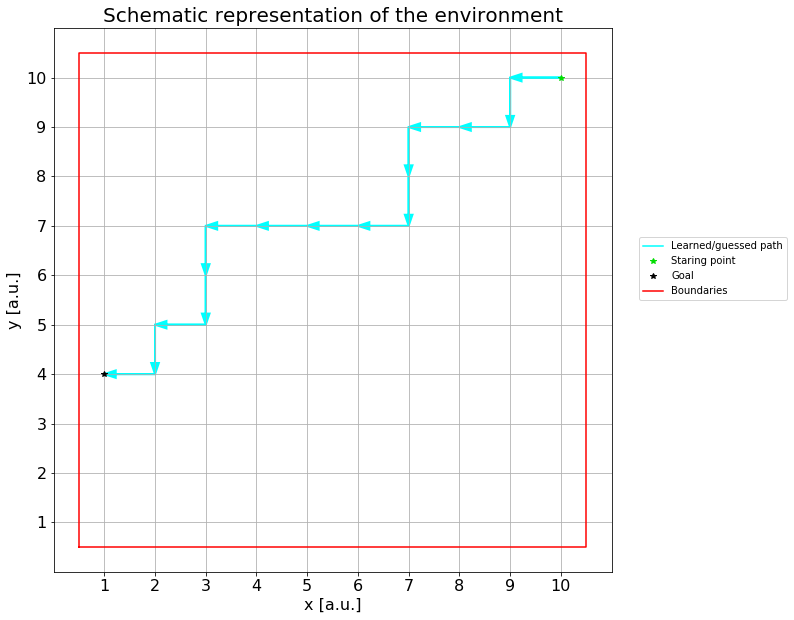

In [14]:
list_states = np.array(list_states)

plt.figure(figsize=(10,10))

# Trick to add legend
plt.plot(list_states.T[0][0:2], list_states.T[1][0:2], '-', color="#00ffff",
         label="Learned/guessed path")
# Plotting trajectory as arrows
for p1,p2 in zip(list_states[:-1], list_states[1:]):
    if np.any(p1 != p2):
        dx = p2[0] - p1[0]
        dy = p2[1] - p1[1]
        plt.arrow(p1[0], p1[1], dx, dy, color="#00ffff", shape='full', lw=2, length_includes_head=True, head_width=0.15)

plt.plot(list_states.T[0][0], list_states.T[1][0], '*', color="#00dd00", label="Staring point")
plt.plot(goal[0], goal[1], '*', color="#000000", label="Goal")


plt.xlim([-1,10])
plt.ylim([-1,10])

plt.xticks(np.arange(10), np.arange(10)+1, fontsize=16)
plt.yticks(np.arange(10), np.arange(10)+1, fontsize=16)

# Plotting bounaries
plt.plot([-0.5, 9.5, 9.5, -0.5, -0.5], [-0.5, -0.5, 9.5, 9.5, -0.5], color="#ff0000", label="Boundaries")

plt.title("Schematic representation of the environment", fontsize=20)

plt.xlabel("x [a.u.]", fontsize=16)
plt.ylabel("y [a.u.]", fontsize=16)

plt.legend(loc=(1.05,0.5))
plt.grid()

plt.savefig(str(path_img+"/ENV1_SARSA.png"), bbox_inches='tight')

plt.show()

## Trying do add some sand

## Q-learning

In [23]:
episodes = 2000         # number of training episodes
episode_length = 50     # maximum episode length
x = 10                  # horizontal size of the box
y = 10                  # vertical size of the box
goal = [0, 3]           # objective point
discount = 0.9          # exponential discount factor
softmax = False         # set to true to use Softmax policy
sarsa = False           # set to true to use the Sarsa algorithm
init_window = [[9,10],[9,10]]   # set [x1,x2],[y1,y2] generation interval for the x,y initial position

# TODO alpha and epsilon profile
alpha = np.ones(episodes) * 0.25
epsilon = np.linspace(0.8, 0.001,episodes)

# So the best action gets 1-ε, so 0.2
# 	the others get ε/(N-1)

# initialize the agent
learner = Agent((x * y), 5, discount, max_reward=1, softmax=softmax, sarsa=sarsa)

# No walls
walls = None

# Setting sand
sand = [[4,5], [4,6], [4,7], [4,8]]

# perform the training
for index in range(0, episodes):
    # start from a random state
    initial = [np.random.randint(init_window[0][0], init_window[0][1]),
               np.random.randint(init_window[1][0], init_window[1][1])]
    # initialize environment
    state = initial
    
    # list of actions to visualize the track
    list_states = [initial]
    
    env = Environment(x, y, state, goal, walls = walls, sand=sand)
    reward = 0
    # run episode
    for step in range(0, episode_length):
        # find state index (vectorize the state in the matrix?)
        state_index = state[0] * y + state[1]
        # choose an action
        action = learner.select_action(state_index, epsilon[index])
        # the agent moves in the environment
        result = env.move(action)
        
        # Saving the last list of actions
        if (index == episodes-1):
            list_states.append(result[0])
        
        # Q-learning update
        next_index = result[0][0] * y + result[0][1]
        learner.update(state_index, action, result[1], next_index, alpha[index], epsilon[index])
        # update state and reward
        reward += result[1]
        state = result[0]
    # Only to track the average reward
    reward /= episode_length
    print('Episode ', index + 1, ': the agent has obtained an average reward of ', reward, ' starting from position ', initial) 
    
    # periodically save the agent
    if ((index + 1) % 10 == 0):
        with open('agent.obj', 'wb') as agent_file:
            dill.dump(learner, agent_file)

Episode  1 : the agent has obtained an average reward of  -0.08059999999999999  starting from position  [9, 9]
Episode  2 : the agent has obtained an average reward of  -0.2  starting from position  [9, 9]
Episode  3 : the agent has obtained an average reward of  -0.08  starting from position  [9, 9]
Episode  4 : the agent has obtained an average reward of  -0.28  starting from position  [9, 9]
Episode  5 : the agent has obtained an average reward of  -0.1  starting from position  [9, 9]
Episode  6 : the agent has obtained an average reward of  -0.12  starting from position  [9, 9]
Episode  7 : the agent has obtained an average reward of  -0.06  starting from position  [9, 9]
Episode  8 : the agent has obtained an average reward of  -0.08  starting from position  [9, 9]
Episode  9 : the agent has obtained an average reward of  -0.18  starting from position  [9, 9]
Episode  10 : the agent has obtained an average reward of  -0.0206  starting from position  [9, 9]
Episode  11 : the agent 

Episode  85 : the agent has obtained an average reward of  -0.08  starting from position  [9, 9]
Episode  86 : the agent has obtained an average reward of  -0.08  starting from position  [9, 9]
Episode  87 : the agent has obtained an average reward of  -0.1  starting from position  [9, 9]
Episode  88 : the agent has obtained an average reward of  -0.08  starting from position  [9, 9]
Episode  89 : the agent has obtained an average reward of  -0.10139999999999998  starting from position  [9, 9]
Episode  90 : the agent has obtained an average reward of  -0.22  starting from position  [9, 9]
Episode  91 : the agent has obtained an average reward of  -0.18  starting from position  [9, 9]
Episode  92 : the agent has obtained an average reward of  -0.10059999999999998  starting from position  [9, 9]
Episode  93 : the agent has obtained an average reward of  -0.02  starting from position  [9, 9]
Episode  94 : the agent has obtained an average reward of  -0.1602  starting from position  [9, 9]

Episode  171 : the agent has obtained an average reward of  -0.0212  starting from position  [9, 9]
Episode  172 : the agent has obtained an average reward of  -0.18  starting from position  [9, 9]
Episode  173 : the agent has obtained an average reward of  -0.22  starting from position  [9, 9]
Episode  174 : the agent has obtained an average reward of  -0.14  starting from position  [9, 9]
Episode  175 : the agent has obtained an average reward of  -0.0206  starting from position  [9, 9]
Episode  176 : the agent has obtained an average reward of  -0.12  starting from position  [9, 9]
Episode  177 : the agent has obtained an average reward of  -0.08059999999999999  starting from position  [9, 9]
Episode  178 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  179 : the agent has obtained an average reward of  -0.021  starting from position  [9, 9]
Episode  180 : the agent has obtained an average reward of  -0.1804  starting from position  [9, 9

Episode  259 : the agent has obtained an average reward of  -0.1  starting from position  [9, 9]
Episode  260 : the agent has obtained an average reward of  -0.0004  starting from position  [9, 9]
Episode  261 : the agent has obtained an average reward of  -0.08039999999999999  starting from position  [9, 9]
Episode  262 : the agent has obtained an average reward of  -0.14079999999999998  starting from position  [9, 9]
Episode  263 : the agent has obtained an average reward of  -0.08  starting from position  [9, 9]
Episode  264 : the agent has obtained an average reward of  -0.12  starting from position  [9, 9]
Episode  265 : the agent has obtained an average reward of  -0.1  starting from position  [9, 9]
Episode  266 : the agent has obtained an average reward of  -0.24  starting from position  [9, 9]
Episode  267 : the agent has obtained an average reward of  -0.04019999999999999  starting from position  [9, 9]
Episode  268 : the agent has obtained an average reward of  -0.0405999999

Episode  346 : the agent has obtained an average reward of  -0.18  starting from position  [9, 9]
Episode  347 : the agent has obtained an average reward of  -0.14  starting from position  [9, 9]
Episode  348 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  349 : the agent has obtained an average reward of  -0.02  starting from position  [9, 9]
Episode  350 : the agent has obtained an average reward of  -0.06  starting from position  [9, 9]
Episode  351 : the agent has obtained an average reward of  -0.1  starting from position  [9, 9]
Episode  352 : the agent has obtained an average reward of  -0.12  starting from position  [9, 9]
Episode  353 : the agent has obtained an average reward of  -0.14  starting from position  [9, 9]
Episode  354 : the agent has obtained an average reward of  -0.0218  starting from position  [9, 9]
Episode  355 : the agent has obtained an average reward of  -0.0018  starting from position  [9, 9]
Episode  356 : th

Episode  433 : the agent has obtained an average reward of  -0.0012000000000000001  starting from position  [9, 9]
Episode  434 : the agent has obtained an average reward of  -0.02  starting from position  [9, 9]
Episode  435 : the agent has obtained an average reward of  -0.020199999999999996  starting from position  [9, 9]
Episode  436 : the agent has obtained an average reward of  -0.1  starting from position  [9, 9]
Episode  437 : the agent has obtained an average reward of  -0.1804  starting from position  [9, 9]
Episode  438 : the agent has obtained an average reward of  -0.08  starting from position  [9, 9]
Episode  439 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  440 : the agent has obtained an average reward of  -0.0027999999999999995  starting from position  [9, 9]
Episode  441 : the agent has obtained an average reward of  -0.0602  starting from position  [9, 9]
Episode  442 : the agent has obtained an average reward of  -0.02

Episode  521 : the agent has obtained an average reward of  0.17939999999999998  starting from position  [9, 9]
Episode  522 : the agent has obtained an average reward of  -0.14  starting from position  [9, 9]
Episode  523 : the agent has obtained an average reward of  -0.06039999999999999  starting from position  [9, 9]
Episode  524 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  525 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  526 : the agent has obtained an average reward of  -0.06  starting from position  [9, 9]
Episode  527 : the agent has obtained an average reward of  -0.08079999999999998  starting from position  [9, 9]
Episode  528 : the agent has obtained an average reward of  -0.0608  starting from position  [9, 9]
Episode  529 : the agent has obtained an average reward of  -0.0602  starting from position  [9, 9]
Episode  530 : the agent has obtained an average reward of  -0.021  st

Episode  608 : the agent has obtained an average reward of  0.059800000000000006  starting from position  [9, 9]
Episode  609 : the agent has obtained an average reward of  -0.040600000000000004  starting from position  [9, 9]
Episode  610 : the agent has obtained an average reward of  -0.02  starting from position  [9, 9]
Episode  611 : the agent has obtained an average reward of  -0.12  starting from position  [9, 9]
Episode  612 : the agent has obtained an average reward of  0.0  starting from position  [9, 9]
Episode  613 : the agent has obtained an average reward of  -0.02  starting from position  [9, 9]
Episode  614 : the agent has obtained an average reward of  -0.0404  starting from position  [9, 9]
Episode  615 : the agent has obtained an average reward of  -0.06  starting from position  [9, 9]
Episode  616 : the agent has obtained an average reward of  -0.04019999999999999  starting from position  [9, 9]
Episode  617 : the agent has obtained an average reward of  -0.021400000

Episode  695 : the agent has obtained an average reward of  -0.08039999999999999  starting from position  [9, 9]
Episode  696 : the agent has obtained an average reward of  0.02  starting from position  [9, 9]
Episode  697 : the agent has obtained an average reward of  -0.04039999999999999  starting from position  [9, 9]
Episode  698 : the agent has obtained an average reward of  -0.040600000000000004  starting from position  [9, 9]
Episode  699 : the agent has obtained an average reward of  -0.00040000000000000034  starting from position  [9, 9]
Episode  700 : the agent has obtained an average reward of  -0.08039999999999999  starting from position  [9, 9]
Episode  701 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  702 : the agent has obtained an average reward of  -0.0604  starting from position  [9, 9]
Episode  703 : the agent has obtained an average reward of  -0.06  starting from position  [9, 9]
Episode  704 : the agent has obtained 

Episode  782 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  783 : the agent has obtained an average reward of  -0.0006  starting from position  [9, 9]
Episode  784 : the agent has obtained an average reward of  0.019799999999999998  starting from position  [9, 9]
Episode  785 : the agent has obtained an average reward of  0.019399999999999994  starting from position  [9, 9]
Episode  786 : the agent has obtained an average reward of  0.0  starting from position  [9, 9]
Episode  787 : the agent has obtained an average reward of  -0.06  starting from position  [9, 9]
Episode  788 : the agent has obtained an average reward of  0.1  starting from position  [9, 9]
Episode  789 : the agent has obtained an average reward of  0.02  starting from position  [9, 9]
Episode  790 : the agent has obtained an average reward of  -0.14  starting from position  [9, 9]
Episode  791 : the agent has obtained an average reward of  -0.10039999999999999  starting 

Episode  869 : the agent has obtained an average reward of  0.1  starting from position  [9, 9]
Episode  870 : the agent has obtained an average reward of  0.02  starting from position  [9, 9]
Episode  871 : the agent has obtained an average reward of  -0.0602  starting from position  [9, 9]
Episode  872 : the agent has obtained an average reward of  0.1  starting from position  [9, 9]
Episode  873 : the agent has obtained an average reward of  0.059399999999999994  starting from position  [9, 9]
Episode  874 : the agent has obtained an average reward of  0.0398  starting from position  [9, 9]
Episode  875 : the agent has obtained an average reward of  0.0794  starting from position  [9, 9]
Episode  876 : the agent has obtained an average reward of  -0.10099999999999998  starting from position  [9, 9]
Episode  877 : the agent has obtained an average reward of  0.06  starting from position  [9, 9]
Episode  878 : the agent has obtained an average reward of  -0.04  starting from position 

Episode  955 : the agent has obtained an average reward of  0.02  starting from position  [9, 9]
Episode  956 : the agent has obtained an average reward of  0.04  starting from position  [9, 9]
Episode  957 : the agent has obtained an average reward of  -0.02  starting from position  [9, 9]
Episode  958 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  959 : the agent has obtained an average reward of  0.16  starting from position  [9, 9]
Episode  960 : the agent has obtained an average reward of  0.0  starting from position  [9, 9]
Episode  961 : the agent has obtained an average reward of  0.18  starting from position  [9, 9]
Episode  962 : the agent has obtained an average reward of  0.0  starting from position  [9, 9]
Episode  963 : the agent has obtained an average reward of  0.1  starting from position  [9, 9]
Episode  964 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  965 : the agent has o

Episode  1062 : the agent has obtained an average reward of  0.18  starting from position  [9, 9]
Episode  1063 : the agent has obtained an average reward of  0.34  starting from position  [9, 9]
Episode  1064 : the agent has obtained an average reward of  0.04  starting from position  [9, 9]
Episode  1065 : the agent has obtained an average reward of  0.18  starting from position  [9, 9]
Episode  1066 : the agent has obtained an average reward of  0.04  starting from position  [9, 9]
Episode  1067 : the agent has obtained an average reward of  0.08  starting from position  [9, 9]
Episode  1068 : the agent has obtained an average reward of  0.04  starting from position  [9, 9]
Episode  1069 : the agent has obtained an average reward of  0.12  starting from position  [9, 9]
Episode  1070 : the agent has obtained an average reward of  0.14  starting from position  [9, 9]
Episode  1071 : the agent has obtained an average reward of  0.16  starting from position  [9, 9]
Episode  1072 : the 

Episode  1169 : the agent has obtained an average reward of  0.06  starting from position  [9, 9]
Episode  1170 : the agent has obtained an average reward of  0.16  starting from position  [9, 9]
Episode  1171 : the agent has obtained an average reward of  0.21939999999999998  starting from position  [9, 9]
Episode  1172 : the agent has obtained an average reward of  0.12  starting from position  [9, 9]
Episode  1173 : the agent has obtained an average reward of  0.1  starting from position  [9, 9]
Episode  1174 : the agent has obtained an average reward of  0.04  starting from position  [9, 9]
Episode  1175 : the agent has obtained an average reward of  0.0  starting from position  [9, 9]
Episode  1176 : the agent has obtained an average reward of  0.18  starting from position  [9, 9]
Episode  1177 : the agent has obtained an average reward of  0.31980000000000003  starting from position  [9, 9]
Episode  1178 : the agent has obtained an average reward of  0.2  starting from position  

Episode  1276 : the agent has obtained an average reward of  0.32  starting from position  [9, 9]
Episode  1277 : the agent has obtained an average reward of  0.22  starting from position  [9, 9]
Episode  1278 : the agent has obtained an average reward of  0.2  starting from position  [9, 9]
Episode  1279 : the agent has obtained an average reward of  0.26  starting from position  [9, 9]
Episode  1280 : the agent has obtained an average reward of  0.16  starting from position  [9, 9]
Episode  1281 : the agent has obtained an average reward of  0.32  starting from position  [9, 9]
Episode  1282 : the agent has obtained an average reward of  -0.02  starting from position  [9, 9]
Episode  1283 : the agent has obtained an average reward of  0.06  starting from position  [9, 9]
Episode  1284 : the agent has obtained an average reward of  0.019800000000000005  starting from position  [9, 9]
Episode  1285 : the agent has obtained an average reward of  0.24  starting from position  [9, 9]
Epis

Episode  1380 : the agent has obtained an average reward of  0.32  starting from position  [9, 9]
Episode  1381 : the agent has obtained an average reward of  0.2  starting from position  [9, 9]
Episode  1382 : the agent has obtained an average reward of  0.44  starting from position  [9, 9]
Episode  1383 : the agent has obtained an average reward of  0.28  starting from position  [9, 9]
Episode  1384 : the agent has obtained an average reward of  0.26  starting from position  [9, 9]
Episode  1385 : the agent has obtained an average reward of  0.22  starting from position  [9, 9]
Episode  1386 : the agent has obtained an average reward of  0.36  starting from position  [9, 9]
Episode  1387 : the agent has obtained an average reward of  0.24  starting from position  [9, 9]
Episode  1388 : the agent has obtained an average reward of  0.18  starting from position  [9, 9]
Episode  1389 : the agent has obtained an average reward of  0.3  starting from position  [9, 9]
Episode  1390 : the ag

Episode  1487 : the agent has obtained an average reward of  0.28  starting from position  [9, 9]
Episode  1488 : the agent has obtained an average reward of  0.38  starting from position  [9, 9]
Episode  1489 : the agent has obtained an average reward of  0.38  starting from position  [9, 9]
Episode  1490 : the agent has obtained an average reward of  0.32  starting from position  [9, 9]
Episode  1491 : the agent has obtained an average reward of  0.34  starting from position  [9, 9]
Episode  1492 : the agent has obtained an average reward of  0.38  starting from position  [9, 9]
Episode  1493 : the agent has obtained an average reward of  0.3  starting from position  [9, 9]
Episode  1494 : the agent has obtained an average reward of  0.24  starting from position  [9, 9]
Episode  1495 : the agent has obtained an average reward of  0.54  starting from position  [9, 9]
Episode  1496 : the agent has obtained an average reward of  0.26  starting from position  [9, 9]
Episode  1497 : the a

Episode  1571 : the agent has obtained an average reward of  0.42  starting from position  [9, 9]
Episode  1572 : the agent has obtained an average reward of  0.52  starting from position  [9, 9]
Episode  1573 : the agent has obtained an average reward of  0.34  starting from position  [9, 9]
Episode  1574 : the agent has obtained an average reward of  0.24  starting from position  [9, 9]
Episode  1575 : the agent has obtained an average reward of  0.54  starting from position  [9, 9]
Episode  1576 : the agent has obtained an average reward of  0.32  starting from position  [9, 9]
Episode  1577 : the agent has obtained an average reward of  0.46  starting from position  [9, 9]
Episode  1578 : the agent has obtained an average reward of  0.3  starting from position  [9, 9]
Episode  1579 : the agent has obtained an average reward of  0.18  starting from position  [9, 9]
Episode  1580 : the agent has obtained an average reward of  0.42  starting from position  [9, 9]
Episode  1581 : the a

Episode  1656 : the agent has obtained an average reward of  0.48  starting from position  [9, 9]
Episode  1657 : the agent has obtained an average reward of  0.38  starting from position  [9, 9]
Episode  1658 : the agent has obtained an average reward of  0.54  starting from position  [9, 9]
Episode  1659 : the agent has obtained an average reward of  0.46  starting from position  [9, 9]
Episode  1660 : the agent has obtained an average reward of  0.44  starting from position  [9, 9]
Episode  1661 : the agent has obtained an average reward of  0.22  starting from position  [9, 9]
Episode  1662 : the agent has obtained an average reward of  0.56  starting from position  [9, 9]
Episode  1663 : the agent has obtained an average reward of  0.58  starting from position  [9, 9]
Episode  1664 : the agent has obtained an average reward of  0.62  starting from position  [9, 9]
Episode  1665 : the agent has obtained an average reward of  0.36  starting from position  [9, 9]
Episode  1666 : the 

Episode  1762 : the agent has obtained an average reward of  0.46  starting from position  [9, 9]
Episode  1763 : the agent has obtained an average reward of  0.4  starting from position  [9, 9]
Episode  1764 : the agent has obtained an average reward of  0.58  starting from position  [9, 9]
Episode  1765 : the agent has obtained an average reward of  0.5  starting from position  [9, 9]
Episode  1766 : the agent has obtained an average reward of  0.66  starting from position  [9, 9]
Episode  1767 : the agent has obtained an average reward of  0.56  starting from position  [9, 9]
Episode  1768 : the agent has obtained an average reward of  0.62  starting from position  [9, 9]
Episode  1769 : the agent has obtained an average reward of  0.42  starting from position  [9, 9]
Episode  1770 : the agent has obtained an average reward of  0.54  starting from position  [9, 9]
Episode  1771 : the agent has obtained an average reward of  0.5  starting from position  [9, 9]
Episode  1772 : the age

Episode  1866 : the agent has obtained an average reward of  0.62  starting from position  [9, 9]
Episode  1867 : the agent has obtained an average reward of  0.54  starting from position  [9, 9]
Episode  1868 : the agent has obtained an average reward of  0.5  starting from position  [9, 9]
Episode  1869 : the agent has obtained an average reward of  0.64  starting from position  [9, 9]
Episode  1870 : the agent has obtained an average reward of  0.66  starting from position  [9, 9]
Episode  1871 : the agent has obtained an average reward of  0.62  starting from position  [9, 9]
Episode  1872 : the agent has obtained an average reward of  0.58  starting from position  [9, 9]
Episode  1873 : the agent has obtained an average reward of  0.58  starting from position  [9, 9]
Episode  1874 : the agent has obtained an average reward of  0.54  starting from position  [9, 9]
Episode  1875 : the agent has obtained an average reward of  0.66  starting from position  [9, 9]
Episode  1876 : the a

Episode  1969 : the agent has obtained an average reward of  0.62  starting from position  [9, 9]
Episode  1970 : the agent has obtained an average reward of  0.64  starting from position  [9, 9]
Episode  1971 : the agent has obtained an average reward of  0.7  starting from position  [9, 9]
Episode  1972 : the agent has obtained an average reward of  0.7  starting from position  [9, 9]
Episode  1973 : the agent has obtained an average reward of  0.7  starting from position  [9, 9]
Episode  1974 : the agent has obtained an average reward of  0.7  starting from position  [9, 9]
Episode  1975 : the agent has obtained an average reward of  0.66  starting from position  [9, 9]
Episode  1976 : the agent has obtained an average reward of  0.7  starting from position  [9, 9]
Episode  1977 : the agent has obtained an average reward of  0.68  starting from position  [9, 9]
Episode  1978 : the agent has obtained an average reward of  0.66  starting from position  [9, 9]
Episode  1979 : the agent

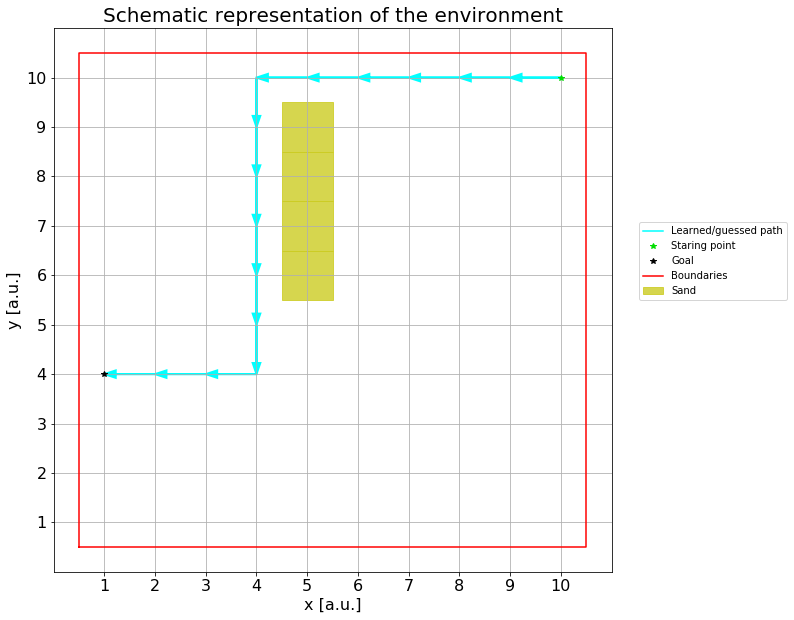

In [24]:
list_states = np.array(list_states)

plt.figure(figsize=(10,10))

plt.plot(list_states.T[0][0:2], list_states.T[1][0:2], '-', color="#00ffff",
         label="Learned/guessed path")
# Plotting trajectory as arrows
cont_arrow = 0
for p1,p2 in zip(list_states[:-1], list_states[1:]):
    if np.any(p1 != p2):
        if cont_arrow == 0:
            dx = p2[0] - p1[0]
            dy = p2[1] - p1[1]
            plt.arrow(p1[0], p1[1], dx, dy, color="#00ffff", shape='full', lw=2, label="Trajectory",
                      length_includes_head=True, head_width=0.15)
        else:
            dx = p2[0] - p1[0]
            dy = p2[1] - p1[1]
            plt.arrow(p1[0], p1[1], dx, dy, color="#00ffff", shape='full', lw=2,
                      length_includes_head=True, head_width=0.15)
    cont_arrow += 1

plt.plot(list_states.T[0][0], list_states.T[1][0], '*', color="#00dd00", label="Staring point")
plt.plot(goal[0], goal[1], '*', color="#000000", label="Goal")

# Plotting sand points
cont_sand = 0
for sand_p in sand:
    if cont_sand == 0:
        recta = plt.Rectangle( (sand_p[0]-0.5, sand_p[1]-0.5), 1, 1, color="#cccc22", alpha=0.8, label="Sand")
        plt.gca().add_patch(recta)
    else:
        recta = plt.Rectangle( (sand_p[0]-0.5, sand_p[1]-0.5), 1, 1, color="#cccc22", alpha=0.8)
        plt.gca().add_patch(recta)
    cont_sand += 1
        
cont = 0
if walls != None:
    for wall in walls:
        plot_wall(wall, cont)
        cont += 1

plt.xlim([-1,10])
plt.ylim([-1,10])

plt.xticks(np.arange(10), np.arange(10)+1, fontsize=16)
plt.yticks(np.arange(10), np.arange(10)+1, fontsize=16)

# Plotting bounaries
plt.plot([-0.5, 9.5, 9.5, -0.5, -0.5], [-0.5, -0.5, 9.5, 9.5, -0.5], color="#ff0000", label="Boundaries")

plt.title("Schematic representation of the environment", fontsize=20)

plt.xlabel("x [a.u.]", fontsize=16)
plt.ylabel("y [a.u.]", fontsize=16)

my_leg = plt.legend(loc=(1.05,0.5))
plt.grid()

plt.savefig(str(path_img+"/ENV1__sand_Q-learning.png"), bbox_inches='tight')

plt.show()

## SARSA

In [19]:
episodes = 2000         # number of training episodes
episode_length = 50     # maximum episode length
x = 10                  # horizontal size of the box
y = 10                  # vertical size of the box
goal = [0, 3]           # objective point
discount = 0.9          # exponential discount factor
softmax = False         # set to true to use Softmax policy
sarsa = True            # set to true to use the Sarsa algorithm
init_window = [[9,10],[9,10]]   # set [x1,x2],[y1,y2] generation interval for the x,y initial position

# TODO alpha and epsilon profile
alpha = np.ones(episodes) * 0.25
epsilon = np.linspace(0.8, 0.001,episodes)

# So the best action gets 1-ε, so 0.2
# 	the others get ε/(N-1)

# initialize the agent
learner = Agent((x * y), 5, discount, max_reward=1, softmax=softmax, sarsa=sarsa)

# No walls
walls = None

# Setting sand
sand = [[4,5], [4,6], [4,7], [4,8]]

# perform the training
for index in range(0, episodes):
    # start from a random state
    initial = [np.random.randint(init_window[0][0], init_window[0][1]),
               np.random.randint(init_window[1][0], init_window[1][1])]
    # initialize environment
    state = initial
    
    # list of actions to visualize the track
    list_states = [initial]
    
    env = Environment(x, y, state, goal, walls = walls, sand=sand)
    reward = 0
    # run episode
    for step in range(0, episode_length):
        # find state index (vectorize the state in the matrix?)
        state_index = state[0] * y + state[1]
        # choose an action
        action = learner.select_action(state_index, epsilon[index])
        # the agent moves in the environment
        result = env.move(action)
        
        # Saving the last list of actions
        if (index == episodes-1):
            list_states.append(result[0])
        
        # Q-learning update
        next_index = result[0][0] * y + result[0][1]
        learner.update(state_index, action, result[1], next_index, alpha[index], epsilon[index])
        # update state and reward
        reward += result[1]
        state = result[0]
    # Only to track the average reward
    reward /= episode_length
    print('Episode ', index + 1, ': the agent has obtained an average reward of ', reward, ' starting from position ', initial) 
    
    # periodically save the agent
    if ((index + 1) % 10 == 0):
        with open('agent.obj', 'wb') as agent_file:
            dill.dump(learner, agent_file)

Episode  1 : the agent has obtained an average reward of  -0.28  starting from position  [9, 9]
Episode  2 : the agent has obtained an average reward of  -0.28  starting from position  [9, 9]
Episode  3 : the agent has obtained an average reward of  -0.08139999999999997  starting from position  [9, 9]
Episode  4 : the agent has obtained an average reward of  -0.14139999999999997  starting from position  [9, 9]
Episode  5 : the agent has obtained an average reward of  -0.2  starting from position  [9, 9]
Episode  6 : the agent has obtained an average reward of  -0.28  starting from position  [9, 9]
Episode  7 : the agent has obtained an average reward of  -0.12  starting from position  [9, 9]
Episode  8 : the agent has obtained an average reward of  -0.16  starting from position  [9, 9]
Episode  9 : the agent has obtained an average reward of  -0.16  starting from position  [9, 9]
Episode  10 : the agent has obtained an average reward of  -0.22  starting from position  [9, 9]
Episode  1

Episode  85 : the agent has obtained an average reward of  -0.1206  starting from position  [9, 9]
Episode  86 : the agent has obtained an average reward of  -0.08  starting from position  [9, 9]
Episode  87 : the agent has obtained an average reward of  -0.02  starting from position  [9, 9]
Episode  88 : the agent has obtained an average reward of  -0.06099999999999998  starting from position  [9, 9]
Episode  89 : the agent has obtained an average reward of  -0.18  starting from position  [9, 9]
Episode  90 : the agent has obtained an average reward of  -0.02  starting from position  [9, 9]
Episode  91 : the agent has obtained an average reward of  -0.1204  starting from position  [9, 9]
Episode  92 : the agent has obtained an average reward of  -0.18  starting from position  [9, 9]
Episode  93 : the agent has obtained an average reward of  -0.18  starting from position  [9, 9]
Episode  94 : the agent has obtained an average reward of  -0.06  starting from position  [9, 9]
Episode  95

Episode  168 : the agent has obtained an average reward of  -0.0008  starting from position  [9, 9]
Episode  169 : the agent has obtained an average reward of  -0.14  starting from position  [9, 9]
Episode  170 : the agent has obtained an average reward of  -0.08  starting from position  [9, 9]
Episode  171 : the agent has obtained an average reward of  -0.10099999999999998  starting from position  [9, 9]
Episode  172 : the agent has obtained an average reward of  -0.08079999999999998  starting from position  [9, 9]
Episode  173 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  174 : the agent has obtained an average reward of  -0.12  starting from position  [9, 9]
Episode  175 : the agent has obtained an average reward of  -0.0206  starting from position  [9, 9]
Episode  176 : the agent has obtained an average reward of  -0.18  starting from position  [9, 9]
Episode  177 : the agent has obtained an average reward of  -0.0604  starting from p

Episode  274 : the agent has obtained an average reward of  -0.02  starting from position  [9, 9]
Episode  275 : the agent has obtained an average reward of  -0.08  starting from position  [9, 9]
Episode  276 : the agent has obtained an average reward of  -0.14  starting from position  [9, 9]
Episode  277 : the agent has obtained an average reward of  -0.14  starting from position  [9, 9]
Episode  278 : the agent has obtained an average reward of  0.0  starting from position  [9, 9]
Episode  279 : the agent has obtained an average reward of  -0.14  starting from position  [9, 9]
Episode  280 : the agent has obtained an average reward of  -0.06039999999999999  starting from position  [9, 9]
Episode  281 : the agent has obtained an average reward of  -0.1602  starting from position  [9, 9]
Episode  282 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  283 : the agent has obtained an average reward of  -0.0006  starting from position  [9, 9]
Epi

Episode  354 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  355 : the agent has obtained an average reward of  -0.06  starting from position  [9, 9]
Episode  356 : the agent has obtained an average reward of  -0.1008  starting from position  [9, 9]
Episode  357 : the agent has obtained an average reward of  -0.0206  starting from position  [9, 9]
Episode  358 : the agent has obtained an average reward of  -0.0206  starting from position  [9, 9]
Episode  359 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  360 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  361 : the agent has obtained an average reward of  -0.1602  starting from position  [9, 9]
Episode  362 : the agent has obtained an average reward of  -0.22  starting from position  [9, 9]
Episode  363 : the agent has obtained an average reward of  -0.08  starting from position  [9, 9]
Episode  364

Episode  456 : the agent has obtained an average reward of  -0.14  starting from position  [9, 9]
Episode  457 : the agent has obtained an average reward of  -0.06060000000000001  starting from position  [9, 9]
Episode  458 : the agent has obtained an average reward of  -0.08099999999999997  starting from position  [9, 9]
Episode  459 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  460 : the agent has obtained an average reward of  -0.06  starting from position  [9, 9]
Episode  461 : the agent has obtained an average reward of  -0.001  starting from position  [9, 9]
Episode  462 : the agent has obtained an average reward of  -0.10039999999999999  starting from position  [9, 9]
Episode  463 : the agent has obtained an average reward of  -0.02  starting from position  [9, 9]
Episode  464 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  465 : the agent has obtained an average reward of  -0.000400000

Episode  561 : the agent has obtained an average reward of  -0.0406  starting from position  [9, 9]
Episode  562 : the agent has obtained an average reward of  -0.04019999999999999  starting from position  [9, 9]
Episode  563 : the agent has obtained an average reward of  -0.0602  starting from position  [9, 9]
Episode  564 : the agent has obtained an average reward of  -0.0604  starting from position  [9, 9]
Episode  565 : the agent has obtained an average reward of  -0.12  starting from position  [9, 9]
Episode  566 : the agent has obtained an average reward of  -0.14  starting from position  [9, 9]
Episode  567 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  568 : the agent has obtained an average reward of  -0.1402  starting from position  [9, 9]
Episode  569 : the agent has obtained an average reward of  -0.0002  starting from position  [9, 9]
Episode  570 : the agent has obtained an average reward of  -0.06039999999999999  starting fr

Episode  642 : the agent has obtained an average reward of  -0.0208  starting from position  [9, 9]
Episode  643 : the agent has obtained an average reward of  -0.02  starting from position  [9, 9]
Episode  644 : the agent has obtained an average reward of  -0.0208  starting from position  [9, 9]
Episode  645 : the agent has obtained an average reward of  -0.1  starting from position  [9, 9]
Episode  646 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  647 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  648 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  649 : the agent has obtained an average reward of  0.0  starting from position  [9, 9]
Episode  650 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  651 : the agent has obtained an average reward of  -0.06  starting from position  [9, 9]
Episode  652 : the 

Episode  723 : the agent has obtained an average reward of  -0.0404  starting from position  [9, 9]
Episode  724 : the agent has obtained an average reward of  -0.04099999999999998  starting from position  [9, 9]
Episode  725 : the agent has obtained an average reward of  -0.06039999999999999  starting from position  [9, 9]
Episode  726 : the agent has obtained an average reward of  0.15960000000000002  starting from position  [9, 9]
Episode  727 : the agent has obtained an average reward of  -0.041999999999999954  starting from position  [9, 9]
Episode  728 : the agent has obtained an average reward of  -0.0202  starting from position  [9, 9]
Episode  729 : the agent has obtained an average reward of  -0.061  starting from position  [9, 9]
Episode  730 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  731 : the agent has obtained an average reward of  -0.02  starting from position  [9, 9]
Episode  732 : the agent has obtained an average rewa

Episode  822 : the agent has obtained an average reward of  -0.1606  starting from position  [9, 9]
Episode  823 : the agent has obtained an average reward of  -0.02  starting from position  [9, 9]
Episode  824 : the agent has obtained an average reward of  -0.021  starting from position  [9, 9]
Episode  825 : the agent has obtained an average reward of  -0.04179999999999996  starting from position  [9, 9]
Episode  826 : the agent has obtained an average reward of  -0.06  starting from position  [9, 9]
Episode  827 : the agent has obtained an average reward of  -0.0006000000000000005  starting from position  [9, 9]
Episode  828 : the agent has obtained an average reward of  0.04  starting from position  [9, 9]
Episode  829 : the agent has obtained an average reward of  -0.0008  starting from position  [9, 9]
Episode  830 : the agent has obtained an average reward of  -0.10039999999999999  starting from position  [9, 9]
Episode  831 : the agent has obtained an average reward of  0.079  

Episode  925 : the agent has obtained an average reward of  -0.0604  starting from position  [9, 9]
Episode  926 : the agent has obtained an average reward of  0.11900000000000001  starting from position  [9, 9]
Episode  927 : the agent has obtained an average reward of  -0.1  starting from position  [9, 9]
Episode  928 : the agent has obtained an average reward of  -0.02  starting from position  [9, 9]
Episode  929 : the agent has obtained an average reward of  0.0  starting from position  [9, 9]
Episode  930 : the agent has obtained an average reward of  -0.0034000000000000002  starting from position  [9, 9]
Episode  931 : the agent has obtained an average reward of  -0.0208  starting from position  [9, 9]
Episode  932 : the agent has obtained an average reward of  0.02  starting from position  [9, 9]
Episode  933 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  934 : the agent has obtained an average reward of  -0.0008  starting from posi

Episode  1030 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  1031 : the agent has obtained an average reward of  0.0  starting from position  [9, 9]
Episode  1032 : the agent has obtained an average reward of  -0.04039999999999999  starting from position  [9, 9]
Episode  1033 : the agent has obtained an average reward of  -0.02  starting from position  [9, 9]
Episode  1034 : the agent has obtained an average reward of  -0.12  starting from position  [9, 9]
Episode  1035 : the agent has obtained an average reward of  0.2  starting from position  [9, 9]
Episode  1036 : the agent has obtained an average reward of  -0.0016  starting from position  [9, 9]
Episode  1037 : the agent has obtained an average reward of  -0.0204  starting from position  [9, 9]
Episode  1038 : the agent has obtained an average reward of  -0.1  starting from position  [9, 9]
Episode  1039 : the agent has obtained an average reward of  0.0  starting from position  [9, 9

Episode  1111 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  1112 : the agent has obtained an average reward of  0.2796  starting from position  [9, 9]
Episode  1113 : the agent has obtained an average reward of  0.0  starting from position  [9, 9]
Episode  1114 : the agent has obtained an average reward of  0.11939999999999999  starting from position  [9, 9]
Episode  1115 : the agent has obtained an average reward of  0.0  starting from position  [9, 9]
Episode  1116 : the agent has obtained an average reward of  0.2596  starting from position  [9, 9]
Episode  1117 : the agent has obtained an average reward of  0.02  starting from position  [9, 9]
Episode  1118 : the agent has obtained an average reward of  0.18  starting from position  [9, 9]
Episode  1119 : the agent has obtained an average reward of  0.0998  starting from position  [9, 9]
Episode  1120 : the agent has obtained an average reward of  0.3196  starting from position  [9, 9

Episode  1195 : the agent has obtained an average reward of  0.019800000000000005  starting from position  [9, 9]
Episode  1196 : the agent has obtained an average reward of  0.1  starting from position  [9, 9]
Episode  1197 : the agent has obtained an average reward of  0.0592  starting from position  [9, 9]
Episode  1198 : the agent has obtained an average reward of  0.14  starting from position  [9, 9]
Episode  1199 : the agent has obtained an average reward of  0.35980000000000006  starting from position  [9, 9]
Episode  1200 : the agent has obtained an average reward of  -0.06  starting from position  [9, 9]
Episode  1201 : the agent has obtained an average reward of  0.24  starting from position  [9, 9]
Episode  1202 : the agent has obtained an average reward of  0.17980000000000002  starting from position  [9, 9]
Episode  1203 : the agent has obtained an average reward of  0.18  starting from position  [9, 9]
Episode  1204 : the agent has obtained an average reward of  0.2596  s

Episode  1280 : the agent has obtained an average reward of  0.12  starting from position  [9, 9]
Episode  1281 : the agent has obtained an average reward of  0.059800000000000006  starting from position  [9, 9]
Episode  1282 : the agent has obtained an average reward of  0.17980000000000002  starting from position  [9, 9]
Episode  1283 : the agent has obtained an average reward of  0.22  starting from position  [9, 9]
Episode  1284 : the agent has obtained an average reward of  0.32  starting from position  [9, 9]
Episode  1285 : the agent has obtained an average reward of  0.18  starting from position  [9, 9]
Episode  1286 : the agent has obtained an average reward of  0.2998  starting from position  [9, 9]
Episode  1287 : the agent has obtained an average reward of  0.25980000000000003  starting from position  [9, 9]
Episode  1288 : the agent has obtained an average reward of  0.3394  starting from position  [9, 9]
Episode  1289 : the agent has obtained an average reward of  0.34  s

Episode  1366 : the agent has obtained an average reward of  0.34  starting from position  [9, 9]
Episode  1367 : the agent has obtained an average reward of  0.3798  starting from position  [9, 9]
Episode  1368 : the agent has obtained an average reward of  0.34  starting from position  [9, 9]
Episode  1369 : the agent has obtained an average reward of  0.2  starting from position  [9, 9]
Episode  1370 : the agent has obtained an average reward of  0.14  starting from position  [9, 9]
Episode  1371 : the agent has obtained an average reward of  0.3  starting from position  [9, 9]
Episode  1372 : the agent has obtained an average reward of  0.18  starting from position  [9, 9]
Episode  1373 : the agent has obtained an average reward of  0.4  starting from position  [9, 9]
Episode  1374 : the agent has obtained an average reward of  0.32  starting from position  [9, 9]
Episode  1375 : the agent has obtained an average reward of  0.48  starting from position  [9, 9]
Episode  1376 : the a

Episode  1452 : the agent has obtained an average reward of  0.4  starting from position  [9, 9]
Episode  1453 : the agent has obtained an average reward of  0.4  starting from position  [9, 9]
Episode  1454 : the agent has obtained an average reward of  0.36  starting from position  [9, 9]
Episode  1455 : the agent has obtained an average reward of  0.46  starting from position  [9, 9]
Episode  1456 : the agent has obtained an average reward of  0.32  starting from position  [9, 9]
Episode  1457 : the agent has obtained an average reward of  0.32  starting from position  [9, 9]
Episode  1458 : the agent has obtained an average reward of  0.44  starting from position  [9, 9]
Episode  1459 : the agent has obtained an average reward of  0.44  starting from position  [9, 9]
Episode  1460 : the agent has obtained an average reward of  0.3796  starting from position  [9, 9]
Episode  1461 : the agent has obtained an average reward of  0.4398  starting from position  [9, 9]
Episode  1462 : th

Episode  1538 : the agent has obtained an average reward of  0.34  starting from position  [9, 9]
Episode  1539 : the agent has obtained an average reward of  0.28  starting from position  [9, 9]
Episode  1540 : the agent has obtained an average reward of  0.3  starting from position  [9, 9]
Episode  1541 : the agent has obtained an average reward of  0.3394  starting from position  [9, 9]
Episode  1542 : the agent has obtained an average reward of  0.4  starting from position  [9, 9]
Episode  1543 : the agent has obtained an average reward of  0.46  starting from position  [9, 9]
Episode  1544 : the agent has obtained an average reward of  0.3  starting from position  [9, 9]
Episode  1545 : the agent has obtained an average reward of  0.42  starting from position  [9, 9]
Episode  1546 : the agent has obtained an average reward of  0.44  starting from position  [9, 9]
Episode  1547 : the agent has obtained an average reward of  0.32  starting from position  [9, 9]
Episode  1548 : the a

Episode  1624 : the agent has obtained an average reward of  0.48  starting from position  [9, 9]
Episode  1625 : the agent has obtained an average reward of  0.26  starting from position  [9, 9]
Episode  1626 : the agent has obtained an average reward of  0.32  starting from position  [9, 9]
Episode  1627 : the agent has obtained an average reward of  0.46  starting from position  [9, 9]
Episode  1628 : the agent has obtained an average reward of  0.54  starting from position  [9, 9]
Episode  1629 : the agent has obtained an average reward of  0.38  starting from position  [9, 9]
Episode  1630 : the agent has obtained an average reward of  0.5  starting from position  [9, 9]
Episode  1631 : the agent has obtained an average reward of  0.48  starting from position  [9, 9]
Episode  1632 : the agent has obtained an average reward of  0.4  starting from position  [9, 9]
Episode  1633 : the agent has obtained an average reward of  0.38  starting from position  [9, 9]
Episode  1634 : the ag

Episode  1708 : the agent has obtained an average reward of  0.5398000000000001  starting from position  [9, 9]
Episode  1709 : the agent has obtained an average reward of  0.47980000000000006  starting from position  [9, 9]
Episode  1710 : the agent has obtained an average reward of  0.45980000000000004  starting from position  [9, 9]
Episode  1711 : the agent has obtained an average reward of  0.3796  starting from position  [9, 9]
Episode  1712 : the agent has obtained an average reward of  0.6198  starting from position  [9, 9]
Episode  1713 : the agent has obtained an average reward of  0.33980000000000005  starting from position  [9, 9]
Episode  1714 : the agent has obtained an average reward of  0.6598  starting from position  [9, 9]
Episode  1715 : the agent has obtained an average reward of  0.45980000000000004  starting from position  [9, 9]
Episode  1716 : the agent has obtained an average reward of  0.5594  starting from position  [9, 9]
Episode  1717 : the agent has obtain

Episode  1792 : the agent has obtained an average reward of  0.47980000000000006  starting from position  [9, 9]
Episode  1793 : the agent has obtained an average reward of  0.5198  starting from position  [9, 9]
Episode  1794 : the agent has obtained an average reward of  0.5794  starting from position  [9, 9]
Episode  1795 : the agent has obtained an average reward of  0.5798000000000001  starting from position  [9, 9]
Episode  1796 : the agent has obtained an average reward of  0.4998  starting from position  [9, 9]
Episode  1797 : the agent has obtained an average reward of  0.5798000000000001  starting from position  [9, 9]
Episode  1798 : the agent has obtained an average reward of  0.45980000000000004  starting from position  [9, 9]
Episode  1799 : the agent has obtained an average reward of  0.6198  starting from position  [9, 9]
Episode  1800 : the agent has obtained an average reward of  0.5798000000000001  starting from position  [9, 9]
Episode  1801 : the agent has obtained

Episode  1876 : the agent has obtained an average reward of  0.5798000000000001  starting from position  [9, 9]
Episode  1877 : the agent has obtained an average reward of  0.5398000000000001  starting from position  [9, 9]
Episode  1878 : the agent has obtained an average reward of  0.5198  starting from position  [9, 9]
Episode  1879 : the agent has obtained an average reward of  0.6198  starting from position  [9, 9]
Episode  1880 : the agent has obtained an average reward of  0.56  starting from position  [9, 9]
Episode  1881 : the agent has obtained an average reward of  0.6598  starting from position  [9, 9]
Episode  1882 : the agent has obtained an average reward of  0.6198  starting from position  [9, 9]
Episode  1883 : the agent has obtained an average reward of  0.6198  starting from position  [9, 9]
Episode  1884 : the agent has obtained an average reward of  0.6598  starting from position  [9, 9]
Episode  1885 : the agent has obtained an average reward of  0.6198  starting 

Episode  1958 : the agent has obtained an average reward of  0.6398  starting from position  [9, 9]
Episode  1959 : the agent has obtained an average reward of  0.6598  starting from position  [9, 9]
Episode  1960 : the agent has obtained an average reward of  0.6198  starting from position  [9, 9]
Episode  1961 : the agent has obtained an average reward of  0.6998000000000001  starting from position  [9, 9]
Episode  1962 : the agent has obtained an average reward of  0.6398  starting from position  [9, 9]
Episode  1963 : the agent has obtained an average reward of  0.6598  starting from position  [9, 9]
Episode  1964 : the agent has obtained an average reward of  0.6398  starting from position  [9, 9]
Episode  1965 : the agent has obtained an average reward of  0.7  starting from position  [9, 9]
Episode  1966 : the agent has obtained an average reward of  0.6998000000000001  starting from position  [9, 9]
Episode  1967 : the agent has obtained an average reward of  0.6998000000000001

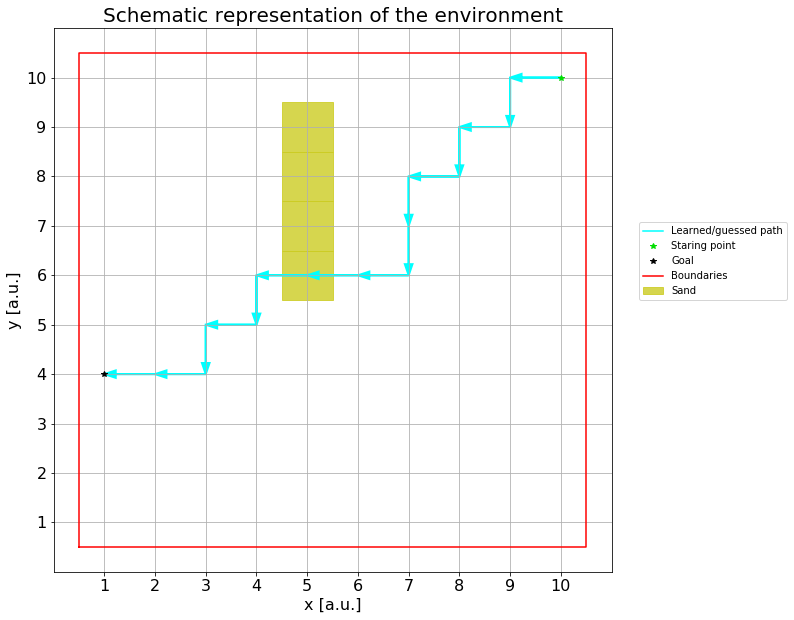

In [21]:
list_states = np.array(list_states)

plt.figure(figsize=(10,10))

plt.plot(list_states.T[0][0:2], list_states.T[1][0:2], '-', color="#00ffff",
         label="Learned/guessed path")
# Plotting trajectory as arrows
cont_arrow = 0
for p1,p2 in zip(list_states[:-1], list_states[1:]):
    if np.any(p1 != p2):
        if cont_arrow == 0:
            dx = p2[0] - p1[0]
            dy = p2[1] - p1[1]
            plt.arrow(p1[0], p1[1], dx, dy, color="#00ffff", shape='full', lw=2, label="Trajectory",
                      length_includes_head=True, head_width=0.15)
        else:
            dx = p2[0] - p1[0]
            dy = p2[1] - p1[1]
            plt.arrow(p1[0], p1[1], dx, dy, color="#00ffff", shape='full', lw=2,
                      length_includes_head=True, head_width=0.15)
    cont_arrow += 1

plt.plot(list_states.T[0][0], list_states.T[1][0], '*', color="#00dd00", label="Staring point")
plt.plot(goal[0], goal[1], '*', color="#000000", label="Goal")

# Plotting sand points
cont_sand = 0
for sand_p in sand:
    if cont_sand == 0:
        recta = plt.Rectangle( (sand_p[0]-0.5, sand_p[1]-0.5), 1, 1, color="#cccc22", alpha=0.8, label="Sand")
        plt.gca().add_patch(recta)
    else:
        recta = plt.Rectangle( (sand_p[0]-0.5, sand_p[1]-0.5), 1, 1, color="#cccc22", alpha=0.8)
        plt.gca().add_patch(recta)
    cont_sand += 1
        
cont = 0
if walls != None:
    for wall in walls:
        plot_wall(wall, cont)
        cont += 1

plt.xlim([-1,10])
plt.ylim([-1,10])

plt.xticks(np.arange(10), np.arange(10)+1, fontsize=16)
plt.yticks(np.arange(10), np.arange(10)+1, fontsize=16)

# Plotting bounaries
plt.plot([-0.5, 9.5, 9.5, -0.5, -0.5], [-0.5, -0.5, 9.5, 9.5, -0.5], color="#ff0000", label="Boundaries")

plt.title("Schematic representation of the environment", fontsize=20)

plt.xlabel("x [a.u.]", fontsize=16)
plt.ylabel("y [a.u.]", fontsize=16)

my_leg = plt.legend(loc=(1.05,0.5))
plt.grid()

plt.savefig(str(path_img+"/ENV1__sand_SARSA.png"), bbox_inches='tight')

plt.show()

## Adding walls

In [8]:
episodes = 2000         # number of training episodes
episode_length = 50     # maximum episode length
x = 10                  # horizontal size of the box
y = 10                  # vertical size of the box
goal = [0, 3]           # objective point
discount = 0.9          # exponential discount factor
softmax = False         # set to true to use Softmax policy
sarsa = False           # set to true to use the Sarsa algorithm
init_window = [[5,9],[0,4]]   # set [x1,x2],[y1,y2] generation interval for the x,y initial position

# TODO alpha and epsilon profile
alpha = np.ones(episodes) * 0.25
epsilon = np.linspace(0.8, 0.001,episodes)

# So the best action gets 1-ε, so 0.2
# 	the others get ε/(N-1)

# initialize the agent
learner = Agent((x * y), 5, discount, max_reward=1, softmax=softmax, sarsa=sarsa)

# Setting walls
walls = [[[1,3],[2,3]], [[1,4],[2,4]], [[1,2],[2,2]], [[1,5],[2,5]], [[1,6],[2,6]], [[1,7],[2,7]], [[1,8],[2,8]],[[1,9],[2,9]],
        [[3,0],[4,0]], [[3,1],[4,1]], [[3,2],[4,2]], [[3,3],[4,3]], [[3,4],[4,4]], [[3,5],[4,5]], [[3,6],[4,6]]]


# perform the training
for index in range(0, episodes):
    # start from a random state
    initial = [np.random.randint(init_window[0][0], init_window[0][1]),
               np.random.randint(init_window[1][0], init_window[1][1])]
    # initialize environment
    state = initial
    
    # list of actions to visualize the track
    list_states = [initial]
    
    env = Environment(x, y, state, goal, walls = walls, sand=None)
    reward = 0
    # run episode
    for step in range(0, episode_length):
        # find state index (vectorize the state in the matrix?)
        state_index = state[0] * y + state[1]
        # choose an action
        action = learner.select_action(state_index, epsilon[index])
        # the agent moves in the environment
        result = env.move(action)
        
        # Saving the last list of actions
        if (index == episodes-1):
            list_states.append(result[0])
        
        # Q-learning update
        next_index = result[0][0] * y + result[0][1]
        learner.update(state_index, action, result[1], next_index, alpha[index], epsilon[index])
        # update state and reward
        reward += result[1]
        state = result[0]
    # Only to track the average reward
    reward /= episode_length
    print('Episode ', index + 1, ': the agent has obtained an average reward of ', reward, ' starting from position ', initial) 
    
    # periodically save the agent
    if ((index + 1) % 10 == 0):
        with open('agent.obj', 'wb') as agent_file:
            dill.dump(learner, agent_file)

Episode  1 : the agent has obtained an average reward of  -0.04  starting from position  [8, 1]
Episode  2 : the agent has obtained an average reward of  0.0  starting from position  [5, 3]
Episode  3 : the agent has obtained an average reward of  -0.1  starting from position  [7, 0]
Episode  4 : the agent has obtained an average reward of  -0.16  starting from position  [7, 0]
Episode  5 : the agent has obtained an average reward of  -0.06  starting from position  [6, 0]
Episode  6 : the agent has obtained an average reward of  -0.18  starting from position  [6, 3]
Episode  7 : the agent has obtained an average reward of  -0.06  starting from position  [6, 1]
Episode  8 : the agent has obtained an average reward of  -0.02  starting from position  [5, 1]
Episode  9 : the agent has obtained an average reward of  0.0  starting from position  [7, 2]
Episode  10 : the agent has obtained an average reward of  -0.12  starting from position  [8, 1]
Episode  11 : the agent has obtained an aver

Episode  95 : the agent has obtained an average reward of  -0.06  starting from position  [5, 2]
Episode  96 : the agent has obtained an average reward of  -0.02  starting from position  [5, 3]
Episode  97 : the agent has obtained an average reward of  -0.02  starting from position  [6, 3]
Episode  98 : the agent has obtained an average reward of  -0.06  starting from position  [5, 3]
Episode  99 : the agent has obtained an average reward of  -0.04  starting from position  [6, 2]
Episode  100 : the agent has obtained an average reward of  -0.02  starting from position  [5, 0]
Episode  101 : the agent has obtained an average reward of  -0.02  starting from position  [5, 3]
Episode  102 : the agent has obtained an average reward of  -0.06  starting from position  [7, 3]
Episode  103 : the agent has obtained an average reward of  -0.02  starting from position  [5, 2]
Episode  104 : the agent has obtained an average reward of  -0.04  starting from position  [7, 3]
Episode  105 : the agent 

Episode  192 : the agent has obtained an average reward of  -0.04  starting from position  [5, 1]
Episode  193 : the agent has obtained an average reward of  -0.02  starting from position  [8, 0]
Episode  194 : the agent has obtained an average reward of  -0.06  starting from position  [7, 2]
Episode  195 : the agent has obtained an average reward of  -0.02  starting from position  [6, 1]
Episode  196 : the agent has obtained an average reward of  -0.02  starting from position  [6, 2]
Episode  197 : the agent has obtained an average reward of  0.0  starting from position  [5, 0]
Episode  198 : the agent has obtained an average reward of  -0.1  starting from position  [5, 1]
Episode  199 : the agent has obtained an average reward of  -0.1  starting from position  [6, 0]
Episode  200 : the agent has obtained an average reward of  -0.1  starting from position  [5, 2]
Episode  201 : the agent has obtained an average reward of  -0.06  starting from position  [6, 2]
Episode  202 : the agent 

Episode  288 : the agent has obtained an average reward of  -0.06  starting from position  [7, 1]
Episode  289 : the agent has obtained an average reward of  -0.08  starting from position  [5, 3]
Episode  290 : the agent has obtained an average reward of  -0.14  starting from position  [7, 0]
Episode  291 : the agent has obtained an average reward of  0.0  starting from position  [5, 0]
Episode  292 : the agent has obtained an average reward of  -0.16  starting from position  [8, 0]
Episode  293 : the agent has obtained an average reward of  -0.04  starting from position  [5, 0]
Episode  294 : the agent has obtained an average reward of  0.0  starting from position  [8, 2]
Episode  295 : the agent has obtained an average reward of  0.0  starting from position  [7, 2]
Episode  296 : the agent has obtained an average reward of  0.0  starting from position  [6, 3]
Episode  297 : the agent has obtained an average reward of  -0.08  starting from position  [6, 3]
Episode  298 : the agent has

Episode  384 : the agent has obtained an average reward of  -0.04  starting from position  [7, 0]
Episode  385 : the agent has obtained an average reward of  0.0  starting from position  [5, 0]
Episode  386 : the agent has obtained an average reward of  -0.04  starting from position  [8, 2]
Episode  387 : the agent has obtained an average reward of  -0.18  starting from position  [8, 1]
Episode  388 : the agent has obtained an average reward of  -0.08  starting from position  [5, 0]
Episode  389 : the agent has obtained an average reward of  0.0  starting from position  [5, 3]
Episode  390 : the agent has obtained an average reward of  0.0  starting from position  [5, 1]
Episode  391 : the agent has obtained an average reward of  0.0  starting from position  [8, 2]
Episode  392 : the agent has obtained an average reward of  -0.1  starting from position  [8, 0]
Episode  393 : the agent has obtained an average reward of  -0.06  starting from position  [5, 0]
Episode  394 : the agent has 

Episode  478 : the agent has obtained an average reward of  0.0  starting from position  [7, 1]
Episode  479 : the agent has obtained an average reward of  -0.04  starting from position  [6, 3]
Episode  480 : the agent has obtained an average reward of  -0.18  starting from position  [8, 3]
Episode  481 : the agent has obtained an average reward of  0.0  starting from position  [6, 1]
Episode  482 : the agent has obtained an average reward of  0.0  starting from position  [7, 3]
Episode  483 : the agent has obtained an average reward of  -0.02  starting from position  [7, 1]
Episode  484 : the agent has obtained an average reward of  -0.02  starting from position  [5, 1]
Episode  485 : the agent has obtained an average reward of  -0.06  starting from position  [8, 3]
Episode  486 : the agent has obtained an average reward of  0.0  starting from position  [6, 1]
Episode  487 : the agent has obtained an average reward of  -0.04  starting from position  [6, 2]
Episode  488 : the agent has

Episode  576 : the agent has obtained an average reward of  -0.08  starting from position  [5, 0]
Episode  577 : the agent has obtained an average reward of  -0.08  starting from position  [6, 2]
Episode  578 : the agent has obtained an average reward of  0.0  starting from position  [6, 2]
Episode  579 : the agent has obtained an average reward of  0.0  starting from position  [5, 1]
Episode  580 : the agent has obtained an average reward of  0.0  starting from position  [8, 0]
Episode  581 : the agent has obtained an average reward of  -0.06  starting from position  [7, 0]
Episode  582 : the agent has obtained an average reward of  -0.06  starting from position  [6, 1]
Episode  583 : the agent has obtained an average reward of  -0.06  starting from position  [5, 0]
Episode  584 : the agent has obtained an average reward of  0.0  starting from position  [7, 2]
Episode  585 : the agent has obtained an average reward of  -0.02  starting from position  [6, 0]
Episode  586 : the agent has

Episode  674 : the agent has obtained an average reward of  -0.04  starting from position  [7, 2]
Episode  675 : the agent has obtained an average reward of  0.0  starting from position  [7, 1]
Episode  676 : the agent has obtained an average reward of  -0.02  starting from position  [8, 0]
Episode  677 : the agent has obtained an average reward of  -0.02  starting from position  [6, 3]
Episode  678 : the agent has obtained an average reward of  0.0  starting from position  [8, 2]
Episode  679 : the agent has obtained an average reward of  -0.12  starting from position  [7, 0]
Episode  680 : the agent has obtained an average reward of  0.0  starting from position  [5, 1]
Episode  681 : the agent has obtained an average reward of  -0.06  starting from position  [6, 1]
Episode  682 : the agent has obtained an average reward of  -0.02  starting from position  [8, 2]
Episode  683 : the agent has obtained an average reward of  -0.08  starting from position  [6, 2]
Episode  684 : the agent h

Episode  772 : the agent has obtained an average reward of  -0.02  starting from position  [6, 3]
Episode  773 : the agent has obtained an average reward of  -0.02  starting from position  [8, 3]
Episode  774 : the agent has obtained an average reward of  0.0  starting from position  [7, 3]
Episode  775 : the agent has obtained an average reward of  0.0  starting from position  [5, 1]
Episode  776 : the agent has obtained an average reward of  0.0  starting from position  [6, 2]
Episode  777 : the agent has obtained an average reward of  -0.02  starting from position  [6, 1]
Episode  778 : the agent has obtained an average reward of  -0.08  starting from position  [8, 2]
Episode  779 : the agent has obtained an average reward of  -0.1  starting from position  [8, 0]
Episode  780 : the agent has obtained an average reward of  0.0  starting from position  [6, 3]
Episode  781 : the agent has obtained an average reward of  -0.02  starting from position  [5, 3]
Episode  782 : the agent has 

Episode  864 : the agent has obtained an average reward of  0.0  starting from position  [5, 1]
Episode  865 : the agent has obtained an average reward of  0.08  starting from position  [6, 3]
Episode  866 : the agent has obtained an average reward of  -0.04  starting from position  [6, 0]
Episode  867 : the agent has obtained an average reward of  0.0  starting from position  [7, 1]
Episode  868 : the agent has obtained an average reward of  -0.02  starting from position  [8, 2]
Episode  869 : the agent has obtained an average reward of  -0.02  starting from position  [8, 0]
Episode  870 : the agent has obtained an average reward of  -0.04  starting from position  [5, 0]
Episode  871 : the agent has obtained an average reward of  0.0  starting from position  [5, 3]
Episode  872 : the agent has obtained an average reward of  0.1  starting from position  [5, 3]
Episode  873 : the agent has obtained an average reward of  -0.04  starting from position  [8, 3]
Episode  874 : the agent has 

Episode  951 : the agent has obtained an average reward of  0.06  starting from position  [5, 0]
Episode  952 : the agent has obtained an average reward of  0.0  starting from position  [5, 0]
Episode  953 : the agent has obtained an average reward of  -0.1  starting from position  [8, 0]
Episode  954 : the agent has obtained an average reward of  0.14  starting from position  [7, 2]
Episode  955 : the agent has obtained an average reward of  0.0  starting from position  [6, 1]
Episode  956 : the agent has obtained an average reward of  -0.02  starting from position  [7, 3]
Episode  957 : the agent has obtained an average reward of  0.04  starting from position  [5, 3]
Episode  958 : the agent has obtained an average reward of  0.0  starting from position  [5, 3]
Episode  959 : the agent has obtained an average reward of  0.04  starting from position  [6, 2]
Episode  960 : the agent has obtained an average reward of  -0.06  starting from position  [7, 3]
Episode  961 : the agent has ob

Episode  1040 : the agent has obtained an average reward of  -0.02  starting from position  [6, 3]
Episode  1041 : the agent has obtained an average reward of  0.06  starting from position  [8, 1]
Episode  1042 : the agent has obtained an average reward of  -0.02  starting from position  [5, 1]
Episode  1043 : the agent has obtained an average reward of  0.12  starting from position  [8, 3]
Episode  1044 : the agent has obtained an average reward of  0.02  starting from position  [7, 0]
Episode  1045 : the agent has obtained an average reward of  0.08  starting from position  [8, 1]
Episode  1046 : the agent has obtained an average reward of  0.0  starting from position  [6, 1]
Episode  1047 : the agent has obtained an average reward of  -0.02  starting from position  [8, 0]
Episode  1048 : the agent has obtained an average reward of  0.02  starting from position  [5, 2]
Episode  1049 : the agent has obtained an average reward of  0.0  starting from position  [8, 1]
Episode  1050 : the

Episode  1128 : the agent has obtained an average reward of  0.0  starting from position  [6, 1]
Episode  1129 : the agent has obtained an average reward of  0.06  starting from position  [5, 0]
Episode  1130 : the agent has obtained an average reward of  0.1  starting from position  [5, 0]
Episode  1131 : the agent has obtained an average reward of  0.14  starting from position  [6, 1]
Episode  1132 : the agent has obtained an average reward of  0.0  starting from position  [6, 1]
Episode  1133 : the agent has obtained an average reward of  0.12  starting from position  [6, 2]
Episode  1134 : the agent has obtained an average reward of  -0.04  starting from position  [8, 1]
Episode  1135 : the agent has obtained an average reward of  0.12  starting from position  [7, 2]
Episode  1136 : the agent has obtained an average reward of  0.1  starting from position  [7, 1]
Episode  1137 : the agent has obtained an average reward of  0.1  starting from position  [5, 1]
Episode  1138 : the agen

Episode  1219 : the agent has obtained an average reward of  0.06  starting from position  [6, 3]
Episode  1220 : the agent has obtained an average reward of  0.04  starting from position  [7, 3]
Episode  1221 : the agent has obtained an average reward of  0.1  starting from position  [7, 2]
Episode  1222 : the agent has obtained an average reward of  0.16  starting from position  [5, 0]
Episode  1223 : the agent has obtained an average reward of  0.1  starting from position  [6, 0]
Episode  1224 : the agent has obtained an average reward of  0.06  starting from position  [6, 2]
Episode  1225 : the agent has obtained an average reward of  0.16  starting from position  [6, 3]
Episode  1226 : the agent has obtained an average reward of  0.04  starting from position  [5, 3]
Episode  1227 : the agent has obtained an average reward of  0.14  starting from position  [5, 2]
Episode  1228 : the agent has obtained an average reward of  0.26  starting from position  [7, 3]
Episode  1229 : the ag

Episode  1310 : the agent has obtained an average reward of  0.04  starting from position  [8, 1]
Episode  1311 : the agent has obtained an average reward of  0.18  starting from position  [5, 2]
Episode  1312 : the agent has obtained an average reward of  0.26  starting from position  [7, 3]
Episode  1313 : the agent has obtained an average reward of  0.14  starting from position  [5, 3]
Episode  1314 : the agent has obtained an average reward of  0.18  starting from position  [5, 1]
Episode  1315 : the agent has obtained an average reward of  0.22  starting from position  [8, 3]
Episode  1316 : the agent has obtained an average reward of  0.3  starting from position  [5, 3]
Episode  1317 : the agent has obtained an average reward of  0.0  starting from position  [8, 2]
Episode  1318 : the agent has obtained an average reward of  0.14  starting from position  [6, 1]
Episode  1319 : the agent has obtained an average reward of  0.16  starting from position  [8, 3]
Episode  1320 : the ag

Episode  1398 : the agent has obtained an average reward of  0.28  starting from position  [5, 0]
Episode  1399 : the agent has obtained an average reward of  0.26  starting from position  [7, 1]
Episode  1400 : the agent has obtained an average reward of  0.26  starting from position  [8, 2]
Episode  1401 : the agent has obtained an average reward of  0.16  starting from position  [5, 2]
Episode  1402 : the agent has obtained an average reward of  0.34  starting from position  [6, 3]
Episode  1403 : the agent has obtained an average reward of  0.4  starting from position  [7, 3]
Episode  1404 : the agent has obtained an average reward of  0.24  starting from position  [8, 1]
Episode  1405 : the agent has obtained an average reward of  0.18  starting from position  [5, 0]
Episode  1406 : the agent has obtained an average reward of  0.22  starting from position  [6, 1]
Episode  1407 : the agent has obtained an average reward of  0.44  starting from position  [5, 3]
Episode  1408 : the a

Episode  1488 : the agent has obtained an average reward of  0.4  starting from position  [5, 2]
Episode  1489 : the agent has obtained an average reward of  0.06  starting from position  [8, 1]
Episode  1490 : the agent has obtained an average reward of  0.16  starting from position  [7, 2]
Episode  1491 : the agent has obtained an average reward of  0.22  starting from position  [5, 1]
Episode  1492 : the agent has obtained an average reward of  0.22  starting from position  [8, 3]
Episode  1493 : the agent has obtained an average reward of  0.34  starting from position  [5, 0]
Episode  1494 : the agent has obtained an average reward of  0.3  starting from position  [7, 0]
Episode  1495 : the agent has obtained an average reward of  0.28  starting from position  [5, 3]
Episode  1496 : the agent has obtained an average reward of  0.28  starting from position  [7, 3]
Episode  1497 : the agent has obtained an average reward of  0.22  starting from position  [7, 2]
Episode  1498 : the ag

Episode  1581 : the agent has obtained an average reward of  0.24  starting from position  [8, 1]
Episode  1582 : the agent has obtained an average reward of  0.24  starting from position  [6, 3]
Episode  1583 : the agent has obtained an average reward of  0.26  starting from position  [8, 3]
Episode  1584 : the agent has obtained an average reward of  0.3  starting from position  [8, 0]
Episode  1585 : the agent has obtained an average reward of  0.5  starting from position  [7, 1]
Episode  1586 : the agent has obtained an average reward of  0.12  starting from position  [6, 1]
Episode  1587 : the agent has obtained an average reward of  0.36  starting from position  [6, 3]
Episode  1588 : the agent has obtained an average reward of  0.22  starting from position  [7, 1]
Episode  1589 : the agent has obtained an average reward of  0.22  starting from position  [5, 1]
Episode  1590 : the agent has obtained an average reward of  0.26  starting from position  [8, 3]
Episode  1591 : the ag

Episode  1677 : the agent has obtained an average reward of  0.46  starting from position  [7, 0]
Episode  1678 : the agent has obtained an average reward of  0.42  starting from position  [8, 0]
Episode  1679 : the agent has obtained an average reward of  0.5  starting from position  [6, 3]
Episode  1680 : the agent has obtained an average reward of  0.34  starting from position  [7, 1]
Episode  1681 : the agent has obtained an average reward of  0.42  starting from position  [5, 1]
Episode  1682 : the agent has obtained an average reward of  0.34  starting from position  [8, 3]
Episode  1683 : the agent has obtained an average reward of  0.38  starting from position  [7, 0]
Episode  1684 : the agent has obtained an average reward of  0.3  starting from position  [6, 3]
Episode  1685 : the agent has obtained an average reward of  0.54  starting from position  [5, 3]
Episode  1686 : the agent has obtained an average reward of  0.38  starting from position  [8, 1]
Episode  1687 : the ag

Episode  1766 : the agent has obtained an average reward of  0.46  starting from position  [5, 1]
Episode  1767 : the agent has obtained an average reward of  0.46  starting from position  [8, 2]
Episode  1768 : the agent has obtained an average reward of  0.38  starting from position  [6, 2]
Episode  1769 : the agent has obtained an average reward of  0.26  starting from position  [6, 0]
Episode  1770 : the agent has obtained an average reward of  0.48  starting from position  [6, 2]
Episode  1771 : the agent has obtained an average reward of  0.48  starting from position  [6, 2]
Episode  1772 : the agent has obtained an average reward of  0.48  starting from position  [7, 1]
Episode  1773 : the agent has obtained an average reward of  0.34  starting from position  [7, 3]
Episode  1774 : the agent has obtained an average reward of  0.4  starting from position  [7, 3]
Episode  1775 : the agent has obtained an average reward of  0.48  starting from position  [7, 2]
Episode  1776 : the a

Episode  1852 : the agent has obtained an average reward of  0.5  starting from position  [6, 0]
Episode  1853 : the agent has obtained an average reward of  0.48  starting from position  [7, 1]
Episode  1854 : the agent has obtained an average reward of  0.44  starting from position  [8, 0]
Episode  1855 : the agent has obtained an average reward of  0.54  starting from position  [6, 2]
Episode  1856 : the agent has obtained an average reward of  0.5  starting from position  [8, 2]
Episode  1857 : the agent has obtained an average reward of  0.44  starting from position  [8, 3]
Episode  1858 : the agent has obtained an average reward of  0.54  starting from position  [7, 3]
Episode  1859 : the agent has obtained an average reward of  0.58  starting from position  [5, 0]
Episode  1860 : the agent has obtained an average reward of  0.54  starting from position  [5, 3]
Episode  1861 : the agent has obtained an average reward of  0.48  starting from position  [8, 1]
Episode  1862 : the ag

Episode  1940 : the agent has obtained an average reward of  0.56  starting from position  [7, 2]
Episode  1941 : the agent has obtained an average reward of  0.58  starting from position  [6, 2]
Episode  1942 : the agent has obtained an average reward of  0.58  starting from position  [7, 3]
Episode  1943 : the agent has obtained an average reward of  0.48  starting from position  [7, 0]
Episode  1944 : the agent has obtained an average reward of  0.48  starting from position  [7, 1]
Episode  1945 : the agent has obtained an average reward of  0.6  starting from position  [5, 0]
Episode  1946 : the agent has obtained an average reward of  0.58  starting from position  [7, 2]
Episode  1947 : the agent has obtained an average reward of  0.62  starting from position  [6, 2]
Episode  1948 : the agent has obtained an average reward of  0.6  starting from position  [6, 3]
Episode  1949 : the agent has obtained an average reward of  0.58  starting from position  [6, 0]
Episode  1950 : the ag

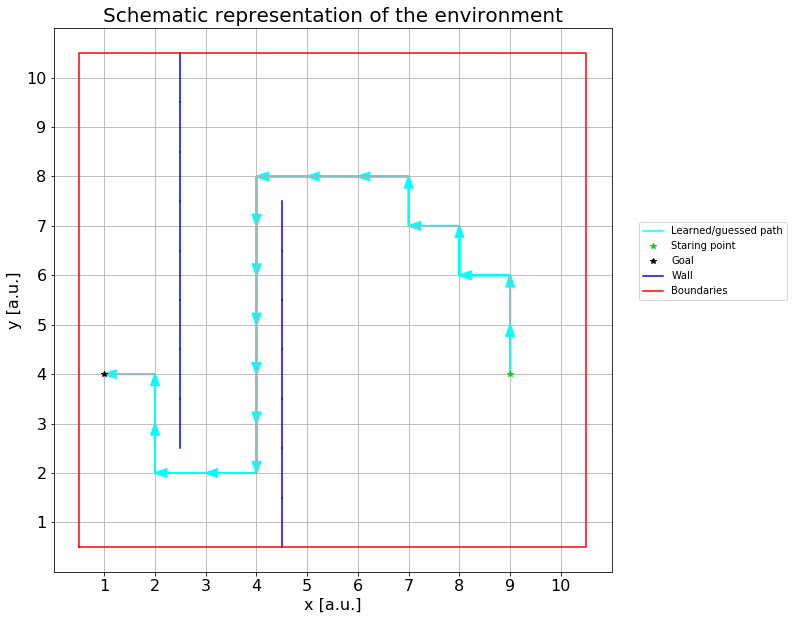

In [9]:
list_states = np.array(list_states)

plt.figure(figsize=(10,10))

# Trick to add legend
plt.plot(list_states.T[0][0:2], list_states.T[1][0:2], '-', color="#00ffff",
         label="Learned/guessed path")
# Plotting trajectory as arrows
for p1,p2 in zip(list_states[:-1], list_states[1:]):
    if np.any(p1 != p2):
        dx = p2[0] - p1[0]
        dy = p2[1] - p1[1]
        plt.arrow(p1[0], p1[1], dx, dy, color="#00ffff", shape='full', lw=2, length_includes_head=True, head_width=0.15)

plt.plot(list_states.T[0][0], list_states.T[1][0], '*', color="#00dd00", label="Staring point")
plt.plot(goal[0], goal[1], '*', color="#000000", label="Goal")
        
cont = 0
for wall in walls:
    plot_wall(wall, cont)
    cont += 1

plt.xlim([-1,10])
plt.ylim([-1,10])

plt.xticks(np.arange(10), np.arange(10)+1, fontsize=16)
plt.yticks(np.arange(10), np.arange(10)+1, fontsize=16)

# Plotting bounaries
plt.plot([-0.5, 9.5, 9.5, -0.5, -0.5], [-0.5, -0.5, 9.5, 9.5, -0.5], color="#ff0000", label="Boundaries")

plt.title("Schematic representation of the environment", fontsize=20)

plt.xlabel("x [a.u.]", fontsize=16)
plt.ylabel("y [a.u.]", fontsize=16)

plt.legend(loc=(1.05,0.5))
plt.grid()

plt.savefig(str(path_img+"/ENV1__only_walls.png"), bbox_inches='tight')

plt.show()

## Adding sand

In [10]:
episodes = 2000         # number of training episodes
episode_length = 50     # maximum episode length
x = 10                  # horizontal size of the box
y = 10                  # vertical size of the box
goal = [0, 3]           # objective point
discount = 0.9          # exponential discount factor
softmax = False         # set to true to use Softmax policy
sarsa = False           # set to true to use the Sarsa algorithm
init_window = [[5,9],[0,4]]   # set [x1,x2],[y1,y2] generation interval for the x,y initial position

# TODO alpha and epsilon profile
alpha = np.ones(episodes) * 0.25
epsilon = np.linspace(0.8, 0.001,episodes)

# So the best action gets 1-ε, so 0.2
# 	the others get ε/(N-1)

# initialize the agent
learner = Agent((x * y), 5, discount, max_reward=1, softmax=softmax, sarsa=sarsa)

# Setting walls
walls = [[[1,3],[2,3]], [[1,4],[2,4]], [[1,2],[2,2]], [[1,5],[2,5]], [[1,6],[2,6]], [[1,7],[2,7]], [[1,8],[2,8]],[[1,9],[2,9]],
        [[3,0],[4,0]], [[3,1],[4,1]], [[3,2],[4,2]], [[3,3],[4,3]], [[3,4],[4,4]], [[3,5],[4,5]], [[3,6],[4,6]]]

# Setting sand
sand = [[3,6], [3,5], [2,3], [2,2]]

# perform the training
for index in range(0, episodes):
    # start from a random state
    initial = [np.random.randint(init_window[0][0], init_window[0][1]),
               np.random.randint(init_window[1][0], init_window[1][1])]
    # initialize environment
    state = initial
    
    # list of actions to visualize the track
    list_states = [initial]
    
    env = Environment(x, y, state, goal, walls = walls, sand=sand)
    reward = 0
    # run episode
    for step in range(0, episode_length):
        # find state index (vectorize the state in the matrix?)
        state_index = state[0] * y + state[1]
        # choose an action
        action = learner.select_action(state_index, epsilon[index])
        # the agent moves in the environment
        result = env.move(action)
        
        # Saving the last list of actions
        if (index == episodes-1):
            list_states.append(result[0])
        
        # Q-learning update
        next_index = result[0][0] * y + result[0][1]
        learner.update(state_index, action, result[1], next_index, alpha[index], epsilon[index])
        # update state and reward
        reward += result[1]
        state = result[0]
    # Only to track the average reward
    reward /= episode_length
    print('Episode ', index + 1, ': the agent has obtained an average reward of ', reward, ' starting from position ', initial) 
    
    # periodically save the agent
    if ((index + 1) % 10 == 0):
        with open('agent.obj', 'wb') as agent_file:
            dill.dump(learner, agent_file)

Episode  1 : the agent has obtained an average reward of  -0.12  starting from position  [7, 2]
Episode  2 : the agent has obtained an average reward of  -0.18  starting from position  [5, 0]
Episode  3 : the agent has obtained an average reward of  -0.04  starting from position  [6, 1]
Episode  4 : the agent has obtained an average reward of  0.0  starting from position  [8, 2]
Episode  5 : the agent has obtained an average reward of  -0.16  starting from position  [7, 0]
Episode  6 : the agent has obtained an average reward of  0.0  starting from position  [5, 3]
Episode  7 : the agent has obtained an average reward of  -0.02  starting from position  [8, 3]
Episode  8 : the agent has obtained an average reward of  -0.16  starting from position  [8, 0]
Episode  9 : the agent has obtained an average reward of  -0.12  starting from position  [7, 1]
Episode  10 : the agent has obtained an average reward of  0.0  starting from position  [5, 2]
Episode  11 : the agent has obtained an avera

Episode  89 : the agent has obtained an average reward of  -0.06  starting from position  [5, 3]
Episode  90 : the agent has obtained an average reward of  -0.06  starting from position  [6, 1]
Episode  91 : the agent has obtained an average reward of  -0.0008  starting from position  [5, 3]
Episode  92 : the agent has obtained an average reward of  -0.06  starting from position  [5, 0]
Episode  93 : the agent has obtained an average reward of  -0.12  starting from position  [7, 2]
Episode  94 : the agent has obtained an average reward of  0.0  starting from position  [6, 2]
Episode  95 : the agent has obtained an average reward of  -0.12  starting from position  [6, 3]
Episode  96 : the agent has obtained an average reward of  -0.04  starting from position  [5, 3]
Episode  97 : the agent has obtained an average reward of  -0.16  starting from position  [6, 3]
Episode  98 : the agent has obtained an average reward of  0.0  starting from position  [7, 3]
Episode  99 : the agent has obta

Episode  175 : the agent has obtained an average reward of  -0.18  starting from position  [5, 0]
Episode  176 : the agent has obtained an average reward of  -0.1  starting from position  [8, 1]
Episode  177 : the agent has obtained an average reward of  -0.1002  starting from position  [6, 1]
Episode  178 : the agent has obtained an average reward of  -0.08  starting from position  [8, 3]
Episode  179 : the agent has obtained an average reward of  0.0  starting from position  [6, 3]
Episode  180 : the agent has obtained an average reward of  -0.06  starting from position  [5, 3]
Episode  181 : the agent has obtained an average reward of  0.0  starting from position  [8, 1]
Episode  182 : the agent has obtained an average reward of  0.0  starting from position  [8, 0]
Episode  183 : the agent has obtained an average reward of  0.0  starting from position  [8, 2]
Episode  184 : the agent has obtained an average reward of  -0.16  starting from position  [8, 2]
Episode  185 : the agent ha

Episode  268 : the agent has obtained an average reward of  -0.08  starting from position  [8, 2]
Episode  269 : the agent has obtained an average reward of  0.0  starting from position  [5, 2]
Episode  270 : the agent has obtained an average reward of  -0.04  starting from position  [6, 2]
Episode  271 : the agent has obtained an average reward of  -0.06  starting from position  [8, 2]
Episode  272 : the agent has obtained an average reward of  -0.06  starting from position  [8, 0]
Episode  273 : the agent has obtained an average reward of  -0.12  starting from position  [6, 2]
Episode  274 : the agent has obtained an average reward of  0.0  starting from position  [6, 3]
Episode  275 : the agent has obtained an average reward of  -0.1  starting from position  [6, 0]
Episode  276 : the agent has obtained an average reward of  -0.12  starting from position  [8, 0]
Episode  277 : the agent has obtained an average reward of  -0.16  starting from position  [6, 2]
Episode  278 : the agent 

Episode  363 : the agent has obtained an average reward of  -0.06  starting from position  [5, 1]
Episode  364 : the agent has obtained an average reward of  -0.02  starting from position  [5, 3]
Episode  365 : the agent has obtained an average reward of  0.0  starting from position  [6, 2]
Episode  366 : the agent has obtained an average reward of  0.0  starting from position  [8, 1]
Episode  367 : the agent has obtained an average reward of  -0.02  starting from position  [7, 2]
Episode  368 : the agent has obtained an average reward of  -0.04  starting from position  [8, 1]
Episode  369 : the agent has obtained an average reward of  -0.0016  starting from position  [5, 3]
Episode  370 : the agent has obtained an average reward of  0.0  starting from position  [6, 2]
Episode  371 : the agent has obtained an average reward of  -0.08  starting from position  [5, 2]
Episode  372 : the agent has obtained an average reward of  -0.02  starting from position  [7, 2]
Episode  373 : the agent

Episode  454 : the agent has obtained an average reward of  0.0192  starting from position  [8, 3]
Episode  455 : the agent has obtained an average reward of  -0.04  starting from position  [8, 1]
Episode  456 : the agent has obtained an average reward of  -0.0012000000000000001  starting from position  [7, 1]
Episode  457 : the agent has obtained an average reward of  -0.0014000000000000002  starting from position  [7, 1]
Episode  458 : the agent has obtained an average reward of  -0.08  starting from position  [6, 1]
Episode  459 : the agent has obtained an average reward of  -0.0021999999999999997  starting from position  [7, 3]
Episode  460 : the agent has obtained an average reward of  -0.12  starting from position  [8, 0]
Episode  461 : the agent has obtained an average reward of  0.0  starting from position  [8, 3]
Episode  462 : the agent has obtained an average reward of  -0.02  starting from position  [7, 2]
Episode  463 : the agent has obtained an average reward of  0.0  sta

Episode  542 : the agent has obtained an average reward of  -0.0002  starting from position  [5, 0]
Episode  543 : the agent has obtained an average reward of  -0.0208  starting from position  [6, 3]
Episode  544 : the agent has obtained an average reward of  -0.1  starting from position  [6, 3]
Episode  545 : the agent has obtained an average reward of  -0.08  starting from position  [5, 3]
Episode  546 : the agent has obtained an average reward of  -0.04  starting from position  [8, 3]
Episode  547 : the agent has obtained an average reward of  -0.0216  starting from position  [6, 3]
Episode  548 : the agent has obtained an average reward of  -0.0204  starting from position  [7, 2]
Episode  549 : the agent has obtained an average reward of  -0.0008  starting from position  [7, 2]
Episode  550 : the agent has obtained an average reward of  -0.04099999999999998  starting from position  [8, 1]
Episode  551 : the agent has obtained an average reward of  -0.0208  starting from position  [

Episode  629 : the agent has obtained an average reward of  -0.04  starting from position  [5, 1]
Episode  630 : the agent has obtained an average reward of  -0.0202  starting from position  [8, 3]
Episode  631 : the agent has obtained an average reward of  -0.02  starting from position  [6, 3]
Episode  632 : the agent has obtained an average reward of  -0.02  starting from position  [5, 0]
Episode  633 : the agent has obtained an average reward of  -0.0008  starting from position  [6, 1]
Episode  634 : the agent has obtained an average reward of  -0.04059999999999999  starting from position  [8, 2]
Episode  635 : the agent has obtained an average reward of  -0.0014000000000000002  starting from position  [8, 2]
Episode  636 : the agent has obtained an average reward of  -0.04  starting from position  [8, 3]
Episode  637 : the agent has obtained an average reward of  -0.14  starting from position  [8, 0]
Episode  638 : the agent has obtained an average reward of  -0.12  starting from p

Episode  717 : the agent has obtained an average reward of  -0.0208  starting from position  [7, 3]
Episode  718 : the agent has obtained an average reward of  -0.0021999999999999997  starting from position  [6, 0]
Episode  719 : the agent has obtained an average reward of  -0.08  starting from position  [8, 3]
Episode  720 : the agent has obtained an average reward of  -0.06  starting from position  [7, 2]
Episode  721 : the agent has obtained an average reward of  -0.04179999999999996  starting from position  [8, 2]
Episode  722 : the agent has obtained an average reward of  -0.021400000000000002  starting from position  [6, 3]
Episode  723 : the agent has obtained an average reward of  0.0  starting from position  [8, 0]
Episode  724 : the agent has obtained an average reward of  -0.0004  starting from position  [5, 1]
Episode  725 : the agent has obtained an average reward of  -0.0008  starting from position  [5, 0]
Episode  726 : the agent has obtained an average reward of  -0.02 

Episode  807 : the agent has obtained an average reward of  -0.04079999999999998  starting from position  [5, 3]
Episode  808 : the agent has obtained an average reward of  -0.0008  starting from position  [7, 0]
Episode  809 : the agent has obtained an average reward of  -0.0006  starting from position  [7, 0]
Episode  810 : the agent has obtained an average reward of  -0.0012000000000000001  starting from position  [6, 3]
Episode  811 : the agent has obtained an average reward of  -0.0006  starting from position  [8, 1]
Episode  812 : the agent has obtained an average reward of  -0.06  starting from position  [8, 0]
Episode  813 : the agent has obtained an average reward of  -0.0004  starting from position  [7, 2]
Episode  814 : the agent has obtained an average reward of  0.05859999999999999  starting from position  [5, 3]
Episode  815 : the agent has obtained an average reward of  0.0596  starting from position  [5, 1]
Episode  816 : the agent has obtained an average reward of  -0.

Episode  898 : the agent has obtained an average reward of  -0.04039999999999999  starting from position  [8, 0]
Episode  899 : the agent has obtained an average reward of  0.0186  starting from position  [6, 1]
Episode  900 : the agent has obtained an average reward of  -0.04  starting from position  [7, 1]
Episode  901 : the agent has obtained an average reward of  -0.040999999999999995  starting from position  [6, 1]
Episode  902 : the agent has obtained an average reward of  -0.020600000000000004  starting from position  [6, 2]
Episode  903 : the agent has obtained an average reward of  -0.08039999999999999  starting from position  [7, 0]
Episode  904 : the agent has obtained an average reward of  -0.0012000000000000001  starting from position  [6, 0]
Episode  905 : the agent has obtained an average reward of  -0.0208  starting from position  [7, 3]
Episode  906 : the agent has obtained an average reward of  -0.04059999999999999  starting from position  [6, 0]
Episode  907 : the ag

Episode  988 : the agent has obtained an average reward of  0.0596  starting from position  [5, 3]
Episode  989 : the agent has obtained an average reward of  0.1186  starting from position  [5, 3]
Episode  990 : the agent has obtained an average reward of  -0.06  starting from position  [8, 0]
Episode  991 : the agent has obtained an average reward of  0.0796  starting from position  [8, 2]
Episode  992 : the agent has obtained an average reward of  -0.001  starting from position  [7, 1]
Episode  993 : the agent has obtained an average reward of  -0.0204  starting from position  [8, 3]
Episode  994 : the agent has obtained an average reward of  -0.0202  starting from position  [8, 0]
Episode  995 : the agent has obtained an average reward of  0.039599999999999996  starting from position  [6, 2]
Episode  996 : the agent has obtained an average reward of  -0.0016  starting from position  [5, 1]
Episode  997 : the agent has obtained an average reward of  -0.0006  starting from position  

Episode  1073 : the agent has obtained an average reward of  0.0794  starting from position  [5, 3]
Episode  1074 : the agent has obtained an average reward of  0.15960000000000002  starting from position  [6, 3]
Episode  1075 : the agent has obtained an average reward of  -0.0008000000000000007  starting from position  [8, 0]
Episode  1076 : the agent has obtained an average reward of  -0.022000000000000002  starting from position  [8, 2]
Episode  1077 : the agent has obtained an average reward of  -0.0206  starting from position  [5, 0]
Episode  1078 : the agent has obtained an average reward of  0.11939999999999999  starting from position  [6, 1]
Episode  1079 : the agent has obtained an average reward of  0.0394  starting from position  [5, 3]
Episode  1080 : the agent has obtained an average reward of  0.059000000000000004  starting from position  [6, 0]
Episode  1081 : the agent has obtained an average reward of  -0.0202  starting from position  [8, 2]
Episode  1082 : the agent h

Episode  1163 : the agent has obtained an average reward of  0.25939999999999996  starting from position  [8, 2]
Episode  1164 : the agent has obtained an average reward of  0.0596  starting from position  [8, 1]
Episode  1165 : the agent has obtained an average reward of  -0.0012000000000000001  starting from position  [7, 1]
Episode  1166 : the agent has obtained an average reward of  0.0  starting from position  [8, 3]
Episode  1167 : the agent has obtained an average reward of  0.15960000000000002  starting from position  [7, 2]
Episode  1168 : the agent has obtained an average reward of  0.0196  starting from position  [7, 0]
Episode  1169 : the agent has obtained an average reward of  0.1198  starting from position  [5, 3]
Episode  1170 : the agent has obtained an average reward of  -0.10039999999999999  starting from position  [8, 1]
Episode  1171 : the agent has obtained an average reward of  0.11960000000000001  starting from position  [6, 1]
Episode  1172 : the agent has obta

Episode  1243 : the agent has obtained an average reward of  -0.0008  starting from position  [8, 3]
Episode  1244 : the agent has obtained an average reward of  0.0592  starting from position  [6, 1]
Episode  1245 : the agent has obtained an average reward of  0.039599999999999996  starting from position  [7, 3]
Episode  1246 : the agent has obtained an average reward of  0.15960000000000002  starting from position  [5, 2]
Episode  1247 : the agent has obtained an average reward of  0.1198  starting from position  [6, 3]
Episode  1248 : the agent has obtained an average reward of  0.2796  starting from position  [5, 3]
Episode  1249 : the agent has obtained an average reward of  0.23939999999999997  starting from position  [8, 3]
Episode  1250 : the agent has obtained an average reward of  0.29960000000000003  starting from position  [5, 0]
Episode  1251 : the agent has obtained an average reward of  -0.020600000000000004  starting from position  [8, 0]
Episode  1252 : the agent has o

Episode  1329 : the agent has obtained an average reward of  0.1796  starting from position  [8, 1]
Episode  1330 : the agent has obtained an average reward of  -0.0006  starting from position  [7, 0]
Episode  1331 : the agent has obtained an average reward of  0.079  starting from position  [7, 0]
Episode  1332 : the agent has obtained an average reward of  0.21960000000000002  starting from position  [6, 3]
Episode  1333 : the agent has obtained an average reward of  0.1796  starting from position  [8, 2]
Episode  1334 : the agent has obtained an average reward of  0.0992  starting from position  [7, 1]
Episode  1335 : the agent has obtained an average reward of  0.11960000000000001  starting from position  [8, 0]
Episode  1336 : the agent has obtained an average reward of  0.2998  starting from position  [8, 2]
Episode  1337 : the agent has obtained an average reward of  0.07919999999999999  starting from position  [7, 3]
Episode  1338 : the agent has obtained an average reward of  

Episode  1416 : the agent has obtained an average reward of  0.2396  starting from position  [6, 0]
Episode  1417 : the agent has obtained an average reward of  0.159  starting from position  [7, 1]
Episode  1418 : the agent has obtained an average reward of  0.09960000000000001  starting from position  [7, 0]
Episode  1419 : the agent has obtained an average reward of  0.3996  starting from position  [8, 3]
Episode  1420 : the agent has obtained an average reward of  0.29960000000000003  starting from position  [8, 2]
Episode  1421 : the agent has obtained an average reward of  -0.0012000000000000001  starting from position  [5, 0]
Episode  1422 : the agent has obtained an average reward of  0.29960000000000003  starting from position  [5, 3]
Episode  1423 : the agent has obtained an average reward of  0.21960000000000002  starting from position  [7, 0]
Episode  1424 : the agent has obtained an average reward of  0.26  starting from position  [5, 0]
Episode  1425 : the agent has obtai

Episode  1506 : the agent has obtained an average reward of  0.29960000000000003  starting from position  [8, 1]
Episode  1507 : the agent has obtained an average reward of  0.2396  starting from position  [5, 3]
Episode  1508 : the agent has obtained an average reward of  0.11960000000000001  starting from position  [7, 0]
Episode  1509 : the agent has obtained an average reward of  0.3396  starting from position  [5, 0]
Episode  1510 : the agent has obtained an average reward of  0.4396  starting from position  [5, 3]
Episode  1511 : the agent has obtained an average reward of  0.43939999999999996  starting from position  [7, 1]
Episode  1512 : the agent has obtained an average reward of  0.21960000000000002  starting from position  [8, 2]
Episode  1513 : the agent has obtained an average reward of  0.3196  starting from position  [6, 2]
Episode  1514 : the agent has obtained an average reward of  0.4596  starting from position  [6, 2]
Episode  1515 : the agent has obtained an averag

Episode  1593 : the agent has obtained an average reward of  0.29960000000000003  starting from position  [8, 1]
Episode  1594 : the agent has obtained an average reward of  0.15960000000000002  starting from position  [6, 0]
Episode  1595 : the agent has obtained an average reward of  0.5796  starting from position  [5, 2]
Episode  1596 : the agent has obtained an average reward of  0.31980000000000003  starting from position  [7, 2]
Episode  1597 : the agent has obtained an average reward of  0.43939999999999996  starting from position  [7, 3]
Episode  1598 : the agent has obtained an average reward of  0.4796  starting from position  [6, 1]
Episode  1599 : the agent has obtained an average reward of  0.3996  starting from position  [8, 3]
Episode  1600 : the agent has obtained an average reward of  0.3796  starting from position  [8, 2]
Episode  1601 : the agent has obtained an average reward of  0.2596  starting from position  [6, 0]
Episode  1602 : the agent has obtained an averag

Episode  1683 : the agent has obtained an average reward of  0.2794  starting from position  [8, 3]
Episode  1684 : the agent has obtained an average reward of  0.5796  starting from position  [6, 3]
Episode  1685 : the agent has obtained an average reward of  0.3396  starting from position  [8, 3]
Episode  1686 : the agent has obtained an average reward of  0.3396  starting from position  [8, 3]
Episode  1687 : the agent has obtained an average reward of  0.3796  starting from position  [6, 3]
Episode  1688 : the agent has obtained an average reward of  0.35960000000000003  starting from position  [8, 0]
Episode  1689 : the agent has obtained an average reward of  0.35960000000000003  starting from position  [8, 3]
Episode  1690 : the agent has obtained an average reward of  0.4796  starting from position  [5, 3]
Episode  1691 : the agent has obtained an average reward of  0.4596  starting from position  [8, 2]
Episode  1692 : the agent has obtained an average reward of  0.2796  start

Episode  1771 : the agent has obtained an average reward of  0.35960000000000003  starting from position  [5, 0]
Episode  1772 : the agent has obtained an average reward of  0.4996  starting from position  [8, 1]
Episode  1773 : the agent has obtained an average reward of  0.4796  starting from position  [8, 2]
Episode  1774 : the agent has obtained an average reward of  0.3196  starting from position  [6, 0]
Episode  1775 : the agent has obtained an average reward of  0.4996  starting from position  [7, 0]
Episode  1776 : the agent has obtained an average reward of  0.3796  starting from position  [5, 0]
Episode  1777 : the agent has obtained an average reward of  0.33980000000000005  starting from position  [7, 1]
Episode  1778 : the agent has obtained an average reward of  0.3996  starting from position  [7, 2]
Episode  1779 : the agent has obtained an average reward of  0.4596  starting from position  [6, 1]
Episode  1780 : the agent has obtained an average reward of  0.3996  start

Episode  1859 : the agent has obtained an average reward of  0.5996  starting from position  [5, 0]
Episode  1860 : the agent has obtained an average reward of  0.4596  starting from position  [8, 0]
Episode  1861 : the agent has obtained an average reward of  0.5196000000000001  starting from position  [6, 1]
Episode  1862 : the agent has obtained an average reward of  0.4396  starting from position  [8, 1]
Episode  1863 : the agent has obtained an average reward of  0.5796  starting from position  [7, 3]
Episode  1864 : the agent has obtained an average reward of  0.3396  starting from position  [8, 2]
Episode  1865 : the agent has obtained an average reward of  0.41960000000000003  starting from position  [8, 2]
Episode  1866 : the agent has obtained an average reward of  0.4794  starting from position  [5, 1]
Episode  1867 : the agent has obtained an average reward of  0.4794  starting from position  [7, 2]
Episode  1868 : the agent has obtained an average reward of  0.439200000000

Episode  1948 : the agent has obtained an average reward of  0.5996  starting from position  [7, 2]
Episode  1949 : the agent has obtained an average reward of  0.5196000000000001  starting from position  [6, 1]
Episode  1950 : the agent has obtained an average reward of  0.5996  starting from position  [6, 3]
Episode  1951 : the agent has obtained an average reward of  0.5396  starting from position  [5, 1]
Episode  1952 : the agent has obtained an average reward of  0.5996  starting from position  [5, 2]
Episode  1953 : the agent has obtained an average reward of  0.5596  starting from position  [5, 0]
Episode  1954 : the agent has obtained an average reward of  0.4396  starting from position  [8, 0]
Episode  1955 : the agent has obtained an average reward of  0.4594  starting from position  [8, 0]
Episode  1956 : the agent has obtained an average reward of  0.5996  starting from position  [6, 1]
Episode  1957 : the agent has obtained an average reward of  0.5196000000000001  startin

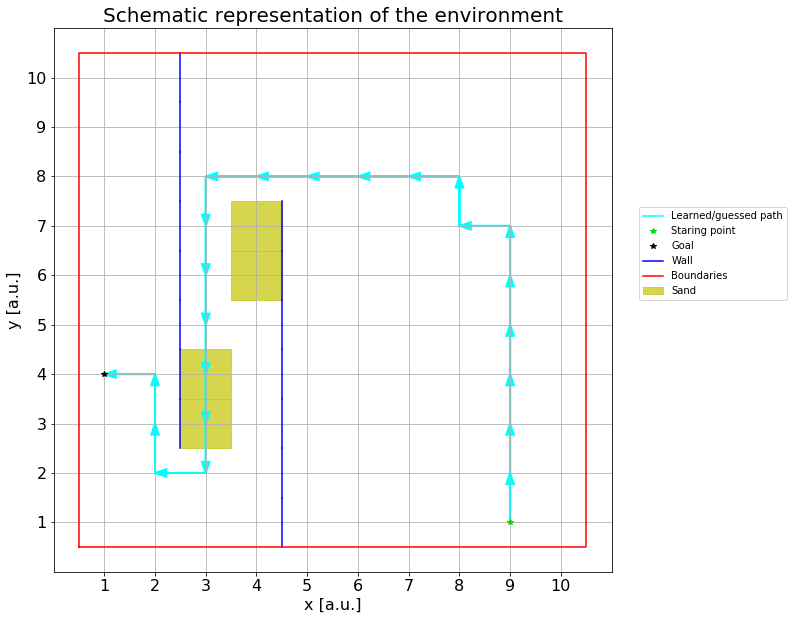

In [11]:
list_states = np.array(list_states)

plt.figure(figsize=(10,10))

# Trick to add legend
plt.plot(list_states.T[0][0:2], list_states.T[1][0:2], '-', color="#00ffff",
         label="Learned/guessed path")# Plotting trajectory as arrows
for p1,p2 in zip(list_states[:-1], list_states[1:]):
    if np.any(p1 != p2):
        dx = p2[0] - p1[0]
        dy = p2[1] - p1[1]
        plt.arrow(p1[0], p1[1], dx, dy, color="#00ffff", shape='full', lw=2, length_includes_head=True, head_width=0.15)

plt.plot(list_states.T[0][0], list_states.T[1][0], '*', color="#00dd00", label="Staring point")
plt.plot(goal[0], goal[1], '*', color="#000000", label="Goal")

# Plotting sand points
cont_sand = 0
for sand_p in sand:
    if cont_sand == 0:
        recta = plt.Rectangle( (sand_p[0]-0.5, sand_p[1]-0.5), 1, 1, color="#cccc22", alpha=0.8, label="Sand")
        plt.gca().add_patch(recta)
    else:
        recta = plt.Rectangle( (sand_p[0]-0.5, sand_p[1]-0.5), 1, 1, color="#cccc22", alpha=0.8)
        plt.gca().add_patch(recta)
    cont_sand += 1
        
cont = 0
for wall in walls:
    plot_wall(wall, cont)
    cont += 1

plt.xlim([-1,10])
plt.ylim([-1,10])

plt.xticks(np.arange(10), np.arange(10)+1, fontsize=16)
plt.yticks(np.arange(10), np.arange(10)+1, fontsize=16)

# Plotting bounaries
plt.plot([-0.5, 9.5, 9.5, -0.5, -0.5], [-0.5, -0.5, 9.5, 9.5, -0.5], color="#ff0000", label="Boundaries")

plt.title("Schematic representation of the environment", fontsize=20)

plt.xlabel("x [a.u.]", fontsize=16)
plt.ylabel("y [a.u.]", fontsize=16)

plt.legend(loc=(1.05,0.5))
plt.grid()

plt.savefig(str(path_img+"/ENV1__walls_sand_1.png"), bbox_inches='tight')


plt.show()

## Using S.A.R.S.A.

In [12]:
episodes = 2000         # number of training episodes
episode_length = 50     # maximum episode length
x = 10                  # horizontal size of the box
y = 10                  # vertical size of the box
goal = [0, 3]           # objective point
discount = 0.9          # exponential discount factor
softmax = False         # set to true to use Softmax policy
sarsa = True           # set to true to use the Sarsa algorithm
init_window = [[5,9],[0,4]]   # set [x1,x2],[y1,y2] generation interval for the x,y initial position

# TODO alpha and epsilon profile
alpha = np.ones(episodes) * 0.25
epsilon = np.linspace(0.8, 0.001,episodes)

# So the best action gets 1-ε, so 0.2
# 	the others get ε/(N-1)

# initialize the agent
learner = Agent((x * y), 5, discount, max_reward=1, softmax=softmax, sarsa=sarsa)

# Setting walls
walls = [[[1,3],[2,3]], [[1,4],[2,4]], [[1,2],[2,2]], [[1,5],[2,5]], [[1,6],[2,6]], [[1,7],[2,7]], [[1,8],[2,8]],[[1,9],[2,9]],
        [[3,0],[4,0]], [[3,1],[4,1]], [[3,2],[4,2]], [[3,3],[4,3]], [[3,4],[4,4]], [[3,5],[4,5]], [[3,6],[4,6]]]

# Setting sand
sand = [[3,6], [3,5], [2,3], [2,2]]

# perform the training
for index in range(0, episodes):
    # start from a random state
    initial = [np.random.randint(init_window[0][0], init_window[0][1]),
               np.random.randint(init_window[1][0], init_window[1][1])]
    # initialize environment
    state = initial
    
    # list of actions to visualize the track
    list_states = [initial]
    
    env = Environment(x, y, state, goal, walls = walls, sand=sand)
    reward = 0
    # run episode
    for step in range(0, episode_length):
        # find state index (vectorize the state in the matrix?)
        state_index = state[0] * y + state[1]
        # choose an action
        action = learner.select_action(state_index, epsilon[index])
        # the agent moves in the environment
        result = env.move(action)
        
        # Saving the last list of actions
        if (index == episodes-1):
            list_states.append(result[0])
        
        # Q-learning update
        next_index = result[0][0] * y + result[0][1]
        learner.update(state_index, action, result[1], next_index, alpha[index], epsilon[index])
        # update state and reward
        reward += result[1]
        state = result[0]
    # Only to track the average reward
    reward /= episode_length
    print('Episode ', index + 1, ': the agent has obtained an average reward of ', reward, ' starting from position ', initial) 
    
    # periodically save the agent
    if ((index + 1) % 10 == 0):
        with open('agent.obj', 'wb') as agent_file:
            dill.dump(learner, agent_file)

Episode  1 : the agent has obtained an average reward of  -0.22  starting from position  [6, 1]
Episode  2 : the agent has obtained an average reward of  -0.1  starting from position  [6, 1]
Episode  3 : the agent has obtained an average reward of  -0.04  starting from position  [7, 3]
Episode  4 : the agent has obtained an average reward of  -0.08  starting from position  [6, 1]
Episode  5 : the agent has obtained an average reward of  0.0  starting from position  [5, 2]
Episode  6 : the agent has obtained an average reward of  0.0  starting from position  [8, 1]
Episode  7 : the agent has obtained an average reward of  -0.12  starting from position  [7, 3]
Episode  8 : the agent has obtained an average reward of  -0.14  starting from position  [8, 1]
Episode  9 : the agent has obtained an average reward of  0.0  starting from position  [6, 2]
Episode  10 : the agent has obtained an average reward of  -0.08  starting from position  [8, 2]
Episode  11 : the agent has obtained an averag

Episode  86 : the agent has obtained an average reward of  0.0  starting from position  [6, 2]
Episode  87 : the agent has obtained an average reward of  -0.1  starting from position  [6, 0]
Episode  88 : the agent has obtained an average reward of  -0.08  starting from position  [8, 2]
Episode  89 : the agent has obtained an average reward of  0.0  starting from position  [5, 2]
Episode  90 : the agent has obtained an average reward of  -0.001  starting from position  [6, 3]
Episode  91 : the agent has obtained an average reward of  -0.02  starting from position  [5, 1]
Episode  92 : the agent has obtained an average reward of  -0.08  starting from position  [8, 1]
Episode  93 : the agent has obtained an average reward of  -0.02  starting from position  [8, 0]
Episode  94 : the agent has obtained an average reward of  -0.02  starting from position  [6, 3]
Episode  95 : the agent has obtained an average reward of  -0.06  starting from position  [7, 2]
Episode  96 : the agent has obtain

Episode  177 : the agent has obtained an average reward of  -0.08  starting from position  [5, 2]
Episode  178 : the agent has obtained an average reward of  -0.1402  starting from position  [7, 2]
Episode  179 : the agent has obtained an average reward of  -0.08  starting from position  [8, 0]
Episode  180 : the agent has obtained an average reward of  -0.08  starting from position  [8, 3]
Episode  181 : the agent has obtained an average reward of  -0.060799999999999986  starting from position  [5, 0]
Episode  182 : the agent has obtained an average reward of  -0.08  starting from position  [5, 1]
Episode  183 : the agent has obtained an average reward of  0.0  starting from position  [7, 0]
Episode  184 : the agent has obtained an average reward of  0.0  starting from position  [7, 0]
Episode  185 : the agent has obtained an average reward of  -0.16  starting from position  [8, 0]
Episode  186 : the agent has obtained an average reward of  0.0  starting from position  [5, 1]
Episode 

Episode  267 : the agent has obtained an average reward of  -0.04  starting from position  [8, 0]
Episode  268 : the agent has obtained an average reward of  -0.0006  starting from position  [6, 2]
Episode  269 : the agent has obtained an average reward of  -0.06  starting from position  [7, 0]
Episode  270 : the agent has obtained an average reward of  -0.0208  starting from position  [7, 0]
Episode  271 : the agent has obtained an average reward of  -0.12  starting from position  [7, 3]
Episode  272 : the agent has obtained an average reward of  0.0  starting from position  [7, 3]
Episode  273 : the agent has obtained an average reward of  -0.12  starting from position  [7, 3]
Episode  274 : the agent has obtained an average reward of  -0.06  starting from position  [7, 3]
Episode  275 : the agent has obtained an average reward of  -0.08  starting from position  [7, 1]
Episode  276 : the agent has obtained an average reward of  -0.02  starting from position  [5, 1]
Episode  277 : the

Episode  357 : the agent has obtained an average reward of  -0.04  starting from position  [6, 3]
Episode  358 : the agent has obtained an average reward of  0.0  starting from position  [6, 0]
Episode  359 : the agent has obtained an average reward of  0.0  starting from position  [8, 0]
Episode  360 : the agent has obtained an average reward of  -0.02  starting from position  [6, 0]
Episode  361 : the agent has obtained an average reward of  -0.12  starting from position  [6, 1]
Episode  362 : the agent has obtained an average reward of  0.0  starting from position  [6, 0]
Episode  363 : the agent has obtained an average reward of  -0.04  starting from position  [5, 1]
Episode  364 : the agent has obtained an average reward of  -0.0202  starting from position  [6, 1]
Episode  365 : the agent has obtained an average reward of  0.0  starting from position  [7, 3]
Episode  366 : the agent has obtained an average reward of  0.0  starting from position  [7, 1]
Episode  367 : the agent has

Episode  447 : the agent has obtained an average reward of  -0.0018  starting from position  [6, 3]
Episode  448 : the agent has obtained an average reward of  -0.04  starting from position  [7, 0]
Episode  449 : the agent has obtained an average reward of  -0.0202  starting from position  [7, 0]
Episode  450 : the agent has obtained an average reward of  -0.04  starting from position  [6, 0]
Episode  451 : the agent has obtained an average reward of  -0.04019999999999999  starting from position  [6, 3]
Episode  452 : the agent has obtained an average reward of  -0.12  starting from position  [5, 1]
Episode  453 : the agent has obtained an average reward of  -0.04019999999999999  starting from position  [6, 2]
Episode  454 : the agent has obtained an average reward of  -0.0004  starting from position  [8, 1]
Episode  455 : the agent has obtained an average reward of  -0.02  starting from position  [6, 1]
Episode  456 : the agent has obtained an average reward of  -0.06  starting from p

Episode  538 : the agent has obtained an average reward of  -0.04  starting from position  [7, 2]
Episode  539 : the agent has obtained an average reward of  -0.0204  starting from position  [7, 1]
Episode  540 : the agent has obtained an average reward of  -0.0006  starting from position  [7, 0]
Episode  541 : the agent has obtained an average reward of  0.0  starting from position  [8, 3]
Episode  542 : the agent has obtained an average reward of  0.0  starting from position  [6, 0]
Episode  543 : the agent has obtained an average reward of  -0.04  starting from position  [8, 3]
Episode  544 : the agent has obtained an average reward of  0.0  starting from position  [8, 2]
Episode  545 : the agent has obtained an average reward of  -0.04039999999999999  starting from position  [5, 3]
Episode  546 : the agent has obtained an average reward of  0.0  starting from position  [6, 2]
Episode  547 : the agent has obtained an average reward of  -0.0204  starting from position  [6, 2]
Episode

Episode  625 : the agent has obtained an average reward of  -0.02  starting from position  [6, 0]
Episode  626 : the agent has obtained an average reward of  -0.0016  starting from position  [7, 2]
Episode  627 : the agent has obtained an average reward of  -0.06099999999999998  starting from position  [6, 0]
Episode  628 : the agent has obtained an average reward of  -0.0006000000000000005  starting from position  [6, 2]
Episode  629 : the agent has obtained an average reward of  -0.04  starting from position  [6, 1]
Episode  630 : the agent has obtained an average reward of  -0.0008  starting from position  [6, 1]
Episode  631 : the agent has obtained an average reward of  -0.04099999999999998  starting from position  [8, 2]
Episode  632 : the agent has obtained an average reward of  -0.02  starting from position  [8, 1]
Episode  633 : the agent has obtained an average reward of  -0.02  starting from position  [7, 1]
Episode  634 : the agent has obtained an average reward of  -0.06  

Episode  715 : the agent has obtained an average reward of  -0.0008  starting from position  [6, 1]
Episode  716 : the agent has obtained an average reward of  0.0  starting from position  [8, 3]
Episode  717 : the agent has obtained an average reward of  -0.0202  starting from position  [5, 2]
Episode  718 : the agent has obtained an average reward of  -0.02  starting from position  [6, 0]
Episode  719 : the agent has obtained an average reward of  -0.0014000000000000002  starting from position  [5, 0]
Episode  720 : the agent has obtained an average reward of  -0.0206  starting from position  [5, 1]
Episode  721 : the agent has obtained an average reward of  0.0194  starting from position  [7, 1]
Episode  722 : the agent has obtained an average reward of  -0.06  starting from position  [8, 0]
Episode  723 : the agent has obtained an average reward of  -0.0212  starting from position  [7, 0]
Episode  724 : the agent has obtained an average reward of  -0.06  starting from position  [8,

Episode  804 : the agent has obtained an average reward of  -0.0408  starting from position  [6, 2]
Episode  805 : the agent has obtained an average reward of  -0.0012000000000000001  starting from position  [8, 0]
Episode  806 : the agent has obtained an average reward of  -0.1002  starting from position  [5, 0]
Episode  807 : the agent has obtained an average reward of  -0.0204  starting from position  [6, 3]
Episode  808 : the agent has obtained an average reward of  -0.0016  starting from position  [5, 0]
Episode  809 : the agent has obtained an average reward of  -0.0206  starting from position  [7, 3]
Episode  810 : the agent has obtained an average reward of  -0.0208  starting from position  [8, 0]
Episode  811 : the agent has obtained an average reward of  -0.0206  starting from position  [8, 1]
Episode  812 : the agent has obtained an average reward of  -0.02  starting from position  [6, 0]
Episode  813 : the agent has obtained an average reward of  -0.0002  starting from posi

Episode  893 : the agent has obtained an average reward of  -0.0006  starting from position  [6, 1]
Episode  894 : the agent has obtained an average reward of  -0.0602  starting from position  [8, 3]
Episode  895 : the agent has obtained an average reward of  -0.001  starting from position  [8, 3]
Episode  896 : the agent has obtained an average reward of  -0.0208  starting from position  [6, 2]
Episode  897 : the agent has obtained an average reward of  -0.0012000000000000001  starting from position  [7, 1]
Episode  898 : the agent has obtained an average reward of  -0.04099999999999998  starting from position  [7, 0]
Episode  899 : the agent has obtained an average reward of  -0.042199999999999994  starting from position  [7, 1]
Episode  900 : the agent has obtained an average reward of  -0.0212  starting from position  [8, 0]
Episode  901 : the agent has obtained an average reward of  -0.06099999999999998  starting from position  [7, 2]
Episode  902 : the agent has obtained an avera

Episode  976 : the agent has obtained an average reward of  -0.02  starting from position  [7, 0]
Episode  977 : the agent has obtained an average reward of  -0.06  starting from position  [8, 2]
Episode  978 : the agent has obtained an average reward of  -0.10120000000000001  starting from position  [5, 1]
Episode  979 : the agent has obtained an average reward of  -0.0202  starting from position  [8, 1]
Episode  980 : the agent has obtained an average reward of  -0.0010000000000000009  starting from position  [5, 2]
Episode  981 : the agent has obtained an average reward of  0.0  starting from position  [8, 0]
Episode  982 : the agent has obtained an average reward of  -0.0206  starting from position  [8, 2]
Episode  983 : the agent has obtained an average reward of  -0.0012000000000000001  starting from position  [8, 0]
Episode  984 : the agent has obtained an average reward of  -0.020999999999999977  starting from position  [8, 1]
Episode  985 : the agent has obtained an average re

Episode  1054 : the agent has obtained an average reward of  -0.02  starting from position  [6, 2]
Episode  1055 : the agent has obtained an average reward of  -0.0208  starting from position  [8, 1]
Episode  1056 : the agent has obtained an average reward of  -0.0008  starting from position  [7, 3]
Episode  1057 : the agent has obtained an average reward of  0.0796  starting from position  [6, 1]
Episode  1058 : the agent has obtained an average reward of  0.0796  starting from position  [5, 2]
Episode  1059 : the agent has obtained an average reward of  -0.0206  starting from position  [7, 0]
Episode  1060 : the agent has obtained an average reward of  -0.0004  starting from position  [8, 1]
Episode  1061 : the agent has obtained an average reward of  0.0592  starting from position  [6, 2]
Episode  1062 : the agent has obtained an average reward of  0.0584  starting from position  [5, 1]
Episode  1063 : the agent has obtained an average reward of  -0.0004  starting from position  [6,

Episode  1142 : the agent has obtained an average reward of  0.0592  starting from position  [7, 2]
Episode  1143 : the agent has obtained an average reward of  -0.0206  starting from position  [7, 3]
Episode  1144 : the agent has obtained an average reward of  0.09939999999999999  starting from position  [5, 3]
Episode  1145 : the agent has obtained an average reward of  -0.0404  starting from position  [7, 3]
Episode  1146 : the agent has obtained an average reward of  -0.1206  starting from position  [6, 1]
Episode  1147 : the agent has obtained an average reward of  -0.0204  starting from position  [5, 1]
Episode  1148 : the agent has obtained an average reward of  -0.0014000000000000002  starting from position  [6, 0]
Episode  1149 : the agent has obtained an average reward of  -0.0206  starting from position  [5, 2]
Episode  1150 : the agent has obtained an average reward of  -0.06  starting from position  [5, 0]
Episode  1151 : the agent has obtained an average reward of  -0.040

Episode  1232 : the agent has obtained an average reward of  0.1394  starting from position  [7, 3]
Episode  1233 : the agent has obtained an average reward of  0.039  starting from position  [7, 2]
Episode  1234 : the agent has obtained an average reward of  0.17920000000000003  starting from position  [6, 0]
Episode  1235 : the agent has obtained an average reward of  0.0192  starting from position  [7, 0]
Episode  1236 : the agent has obtained an average reward of  0.15960000000000002  starting from position  [6, 1]
Episode  1237 : the agent has obtained an average reward of  0.0394  starting from position  [5, 3]
Episode  1238 : the agent has obtained an average reward of  0.1796  starting from position  [7, 2]
Episode  1239 : the agent has obtained an average reward of  0.1392  starting from position  [6, 1]
Episode  1240 : the agent has obtained an average reward of  -0.0004  starting from position  [6, 1]
Episode  1241 : the agent has obtained an average reward of  0.0998  start

Episode  1319 : the agent has obtained an average reward of  0.1796  starting from position  [8, 1]
Episode  1320 : the agent has obtained an average reward of  0.259  starting from position  [7, 3]
Episode  1321 : the agent has obtained an average reward of  0.2788  starting from position  [7, 2]
Episode  1322 : the agent has obtained an average reward of  -0.04019999999999999  starting from position  [8, 3]
Episode  1323 : the agent has obtained an average reward of  0.1588  starting from position  [5, 3]
Episode  1324 : the agent has obtained an average reward of  0.37939999999999996  starting from position  [5, 3]
Episode  1325 : the agent has obtained an average reward of  0.1788  starting from position  [7, 1]
Episode  1326 : the agent has obtained an average reward of  0.33840000000000003  starting from position  [6, 3]
Episode  1327 : the agent has obtained an average reward of  0.0784  starting from position  [7, 0]
Episode  1328 : the agent has obtained an average reward of  

Episode  1408 : the agent has obtained an average reward of  0.2596  starting from position  [8, 3]
Episode  1409 : the agent has obtained an average reward of  0.23939999999999997  starting from position  [6, 0]
Episode  1410 : the agent has obtained an average reward of  0.05960000000000001  starting from position  [6, 0]
Episode  1411 : the agent has obtained an average reward of  0.1396  starting from position  [7, 1]
Episode  1412 : the agent has obtained an average reward of  0.0992  starting from position  [5, 2]
Episode  1413 : the agent has obtained an average reward of  0.0794  starting from position  [8, 3]
Episode  1414 : the agent has obtained an average reward of  0.099  starting from position  [8, 1]
Episode  1415 : the agent has obtained an average reward of  0.31939999999999996  starting from position  [5, 1]
Episode  1416 : the agent has obtained an average reward of  0.2994  starting from position  [7, 3]
Episode  1417 : the agent has obtained an average reward of  0

Episode  1497 : the agent has obtained an average reward of  0.2994  starting from position  [6, 3]
Episode  1498 : the agent has obtained an average reward of  0.2794  starting from position  [5, 3]
Episode  1499 : the agent has obtained an average reward of  0.29960000000000003  starting from position  [8, 2]
Episode  1500 : the agent has obtained an average reward of  0.2796  starting from position  [5, 0]
Episode  1501 : the agent has obtained an average reward of  0.29960000000000003  starting from position  [6, 0]
Episode  1502 : the agent has obtained an average reward of  0.21960000000000002  starting from position  [7, 0]
Episode  1503 : the agent has obtained an average reward of  0.2792  starting from position  [6, 3]
Episode  1504 : the agent has obtained an average reward of  0.4396  starting from position  [5, 2]
Episode  1505 : the agent has obtained an average reward of  0.1396  starting from position  [8, 2]
Episode  1506 : the agent has obtained an average reward of  

Episode  1585 : the agent has obtained an average reward of  0.4396  starting from position  [5, 3]
Episode  1586 : the agent has obtained an average reward of  0.2796  starting from position  [8, 0]
Episode  1587 : the agent has obtained an average reward of  0.29960000000000003  starting from position  [6, 0]
Episode  1588 : the agent has obtained an average reward of  0.41960000000000003  starting from position  [6, 3]
Episode  1589 : the agent has obtained an average reward of  0.3196  starting from position  [6, 1]
Episode  1590 : the agent has obtained an average reward of  0.2792  starting from position  [6, 2]
Episode  1591 : the agent has obtained an average reward of  0.3592  starting from position  [8, 1]
Episode  1592 : the agent has obtained an average reward of  0.3592  starting from position  [6, 3]
Episode  1593 : the agent has obtained an average reward of  0.3396  starting from position  [6, 1]
Episode  1594 : the agent has obtained an average reward of  0.1996  start

Episode  1676 : the agent has obtained an average reward of  0.37920000000000004  starting from position  [8, 3]
Episode  1677 : the agent has obtained an average reward of  0.299  starting from position  [6, 3]
Episode  1678 : the agent has obtained an average reward of  0.2788  starting from position  [8, 1]
Episode  1679 : the agent has obtained an average reward of  0.49939999999999996  starting from position  [5, 3]
Episode  1680 : the agent has obtained an average reward of  0.3992  starting from position  [8, 2]
Episode  1681 : the agent has obtained an average reward of  0.43939999999999996  starting from position  [5, 1]
Episode  1682 : the agent has obtained an average reward of  0.3394  starting from position  [7, 1]
Episode  1683 : the agent has obtained an average reward of  0.5594  starting from position  [5, 1]
Episode  1684 : the agent has obtained an average reward of  0.359  starting from position  [8, 2]
Episode  1685 : the agent has obtained an average reward of  0.

Episode  1764 : the agent has obtained an average reward of  0.5794  starting from position  [5, 3]
Episode  1765 : the agent has obtained an average reward of  0.4592  starting from position  [6, 2]
Episode  1766 : the agent has obtained an average reward of  0.5594  starting from position  [6, 2]
Episode  1767 : the agent has obtained an average reward of  0.5794  starting from position  [6, 0]
Episode  1768 : the agent has obtained an average reward of  0.4794  starting from position  [8, 2]
Episode  1769 : the agent has obtained an average reward of  0.43939999999999996  starting from position  [5, 2]
Episode  1770 : the agent has obtained an average reward of  0.4194  starting from position  [5, 0]
Episode  1771 : the agent has obtained an average reward of  0.3392  starting from position  [7, 1]
Episode  1772 : the agent has obtained an average reward of  0.3994  starting from position  [7, 0]
Episode  1773 : the agent has obtained an average reward of  0.5194  starting from posi

Episode  1852 : the agent has obtained an average reward of  0.3992  starting from position  [7, 0]
Episode  1853 : the agent has obtained an average reward of  0.4794  starting from position  [6, 1]
Episode  1854 : the agent has obtained an average reward of  0.4594  starting from position  [6, 0]
Episode  1855 : the agent has obtained an average reward of  0.5993999999999999  starting from position  [5, 2]
Episode  1856 : the agent has obtained an average reward of  0.5794  starting from position  [5, 3]
Episode  1857 : the agent has obtained an average reward of  0.5993999999999999  starting from position  [5, 3]
Episode  1858 : the agent has obtained an average reward of  0.4594  starting from position  [7, 1]
Episode  1859 : the agent has obtained an average reward of  0.5194  starting from position  [5, 3]
Episode  1860 : the agent has obtained an average reward of  0.49939999999999996  starting from position  [7, 0]
Episode  1861 : the agent has obtained an average reward of  0.

Episode  1937 : the agent has obtained an average reward of  0.5594  starting from position  [8, 1]
Episode  1938 : the agent has obtained an average reward of  0.5394  starting from position  [6, 0]
Episode  1939 : the agent has obtained an average reward of  0.5394  starting from position  [8, 2]
Episode  1940 : the agent has obtained an average reward of  0.5794  starting from position  [7, 3]
Episode  1941 : the agent has obtained an average reward of  0.5596  starting from position  [7, 0]
Episode  1942 : the agent has obtained an average reward of  0.5993999999999999  starting from position  [6, 1]
Episode  1943 : the agent has obtained an average reward of  0.5794  starting from position  [5, 1]
Episode  1944 : the agent has obtained an average reward of  0.6394  starting from position  [5, 2]
Episode  1945 : the agent has obtained an average reward of  0.5394  starting from position  [8, 3]
Episode  1946 : the agent has obtained an average reward of  0.4794  starting from posit

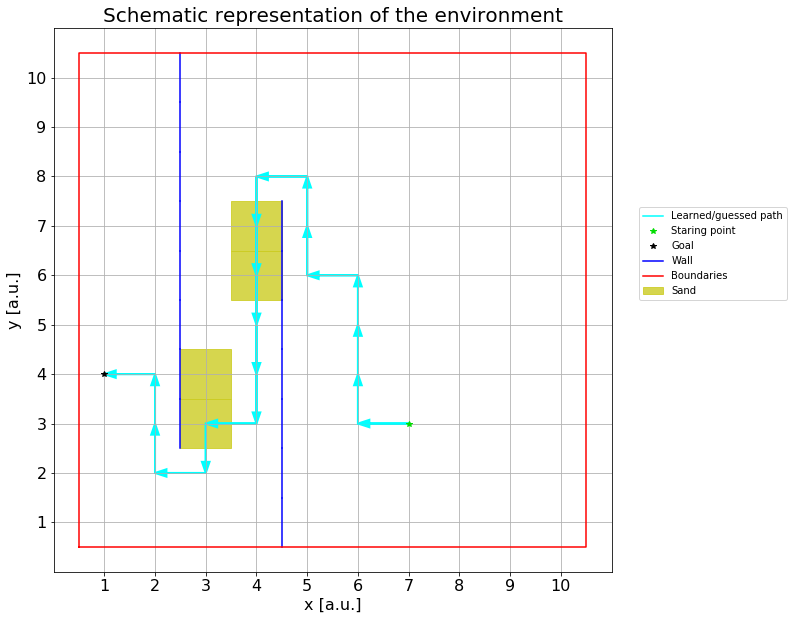

In [13]:
list_states = np.array(list_states)

plt.figure(figsize=(10,10))

# Trick to add legend
plt.plot(list_states.T[0][0:2], list_states.T[1][0:2], '-', color="#00ffff",
         label="Learned/guessed path")# Plotting trajectory as arrows
for p1,p2 in zip(list_states[:-1], list_states[1:]):
    if np.any(p1 != p2):
        dx = p2[0] - p1[0]
        dy = p2[1] - p1[1]
        plt.arrow(p1[0], p1[1], dx, dy, color="#00ffff", shape='full', lw=2, length_includes_head=True, head_width=0.15)

plt.plot(list_states.T[0][0], list_states.T[1][0], '*', color="#00dd00", label="Staring point")
plt.plot(goal[0], goal[1], '*', color="#000000", label="Goal")

# Plotting sand points
cont_sand = 0
for sand_p in sand:
    if cont_sand == 0:
        recta = plt.Rectangle( (sand_p[0]-0.5, sand_p[1]-0.5), 1, 1, color="#cccc22", alpha=0.8, label="Sand")
        plt.gca().add_patch(recta)
    else:
        recta = plt.Rectangle( (sand_p[0]-0.5, sand_p[1]-0.5), 1, 1, color="#cccc22", alpha=0.8)
        plt.gca().add_patch(recta)
    cont_sand += 1
        
cont = 0
for wall in walls:
    plot_wall(wall, cont)
    cont += 1

plt.xlim([-1,10])
plt.ylim([-1,10])

plt.xticks(np.arange(10), np.arange(10)+1, fontsize=16)
plt.yticks(np.arange(10), np.arange(10)+1, fontsize=16)

# Plotting bounaries
plt.plot([-0.5, 9.5, 9.5, -0.5, -0.5], [-0.5, -0.5, 9.5, 9.5, -0.5], color="#ff0000", label="Boundaries")

plt.title("Schematic representation of the environment", fontsize=20)

plt.xlabel("x [a.u.]", fontsize=16)
plt.ylabel("y [a.u.]", fontsize=16)

plt.legend(loc=(1.05,0.5))
plt.grid()

plt.savefig(str(path_img+"/ENV1__walls_sand_SARSA_1.png"), bbox_inches='tight')

plt.show()

## Making another comparison, using more sand

### No SARSA

In [14]:
episodes = 2000         # number of training episodes
episode_length = 50     # maximum episode length
x = 10                  # horizontal size of the box
y = 10                  # vertical size of the box
goal = [0, 3]           # objective point
discount = 0.9          # exponential discount factor
softmax = False         # set to true to use Softmax policy
sarsa = False           # set to true to use the Sarsa algorithm
init_window = [[5,9],[0,4]]   # set [x1,x2],[y1,y2] generation interval for the x,y initial position

# TODO alpha and epsilon profile
alpha = np.ones(episodes) * 0.25
epsilon = np.linspace(0.8, 0.001,episodes)

# So the best action gets 1-ε, so 0.2
# 	the others get ε/(N-1)

# initialize the agent
learner = Agent((x * y), 5, discount, max_reward=1, softmax=softmax, sarsa=sarsa)

# Setting walls
walls = [[[1,3],[2,3]], [[1,4],[2,4]], [[1,2],[2,2]], [[1,5],[2,5]], [[1,6],[2,6]], [[1,7],[2,7]], [[1,8],[2,8]],[[1,9],[2,9]],
        [[3,0],[4,0]], [[3,1],[4,1]], [[3,2],[4,2]], [[3,3],[4,3]], [[3,4],[4,4]], [[3,5],[4,5]], [[3,6],[4,6]]]

# Setting sand
sand = [[3,6], [3,5], [3,4], [3,3], [3,2], [2,2]]

# perform the training
for index in range(0, episodes):
    # start from a random state
    initial = [np.random.randint(init_window[0][0], init_window[0][1]),
               np.random.randint(init_window[1][0], init_window[1][1])]
    # initialize environment
    state = initial
    
    # list of actions to visualize the track
    list_states = [initial]
    
    env = Environment(x, y, state, goal, walls = walls, sand=sand)
    reward = 0
    # run episode
    for step in range(0, episode_length):
        # find state index (vectorize the state in the matrix?)
        state_index = state[0] * y + state[1]
        # choose an action
        action = learner.select_action(state_index, epsilon[index])
        # the agent moves in the environment
        result = env.move(action)
        
        # Saving the last list of actions
        if (index == episodes-1):
            list_states.append(result[0])
        
        # Q-learning update
        next_index = result[0][0] * y + result[0][1]
        learner.update(state_index, action, result[1], next_index, alpha[index], epsilon[index])
        # update state and reward
        reward += result[1]
        state = result[0]
    # Only to track the average reward
    reward /= episode_length
    print('Episode ', index + 1, ': the agent has obtained an average reward of ', reward, ' starting from position ', initial) 
    
    # periodically save the agent
    if ((index + 1) % 10 == 0):
        with open('agent.obj', 'wb') as agent_file:
            dill.dump(learner, agent_file)

Episode  1 : the agent has obtained an average reward of  -0.08  starting from position  [8, 3]
Episode  2 : the agent has obtained an average reward of  -0.14  starting from position  [6, 1]
Episode  3 : the agent has obtained an average reward of  -0.08  starting from position  [7, 0]
Episode  4 : the agent has obtained an average reward of  -0.04  starting from position  [6, 1]
Episode  5 : the agent has obtained an average reward of  -0.04  starting from position  [6, 3]
Episode  6 : the agent has obtained an average reward of  -0.06  starting from position  [6, 3]
Episode  7 : the agent has obtained an average reward of  -0.16  starting from position  [5, 1]
Episode  8 : the agent has obtained an average reward of  -0.06  starting from position  [7, 0]
Episode  9 : the agent has obtained an average reward of  0.0  starting from position  [6, 3]
Episode  10 : the agent has obtained an average reward of  -0.02  starting from position  [6, 3]
Episode  11 : the agent has obtained an a

Episode  88 : the agent has obtained an average reward of  -0.06  starting from position  [7, 0]
Episode  89 : the agent has obtained an average reward of  -0.08  starting from position  [8, 3]
Episode  90 : the agent has obtained an average reward of  -0.16  starting from position  [7, 3]
Episode  91 : the agent has obtained an average reward of  -0.12  starting from position  [6, 0]
Episode  92 : the agent has obtained an average reward of  -0.12  starting from position  [8, 0]
Episode  93 : the agent has obtained an average reward of  0.0  starting from position  [8, 1]
Episode  94 : the agent has obtained an average reward of  -0.12  starting from position  [8, 3]
Episode  95 : the agent has obtained an average reward of  0.0  starting from position  [6, 0]
Episode  96 : the agent has obtained an average reward of  -0.04  starting from position  [6, 3]
Episode  97 : the agent has obtained an average reward of  0.0  starting from position  [8, 1]
Episode  98 : the agent has obtained

Episode  174 : the agent has obtained an average reward of  0.0  starting from position  [5, 3]
Episode  175 : the agent has obtained an average reward of  -0.06  starting from position  [8, 1]
Episode  176 : the agent has obtained an average reward of  -0.08  starting from position  [8, 0]
Episode  177 : the agent has obtained an average reward of  0.0  starting from position  [8, 3]
Episode  178 : the agent has obtained an average reward of  -0.06  starting from position  [6, 3]
Episode  179 : the agent has obtained an average reward of  -0.2  starting from position  [6, 0]
Episode  180 : the agent has obtained an average reward of  0.0  starting from position  [5, 3]
Episode  181 : the agent has obtained an average reward of  0.0  starting from position  [6, 3]
Episode  182 : the agent has obtained an average reward of  0.0  starting from position  [5, 1]
Episode  183 : the agent has obtained an average reward of  -0.02  starting from position  [8, 2]
Episode  184 : the agent has ob

Episode  269 : the agent has obtained an average reward of  -0.1  starting from position  [6, 0]
Episode  270 : the agent has obtained an average reward of  0.0  starting from position  [8, 2]
Episode  271 : the agent has obtained an average reward of  -0.02  starting from position  [7, 0]
Episode  272 : the agent has obtained an average reward of  -0.1  starting from position  [7, 2]
Episode  273 : the agent has obtained an average reward of  -0.02  starting from position  [7, 2]
Episode  274 : the agent has obtained an average reward of  -0.02  starting from position  [8, 1]
Episode  275 : the agent has obtained an average reward of  0.0  starting from position  [5, 2]
Episode  276 : the agent has obtained an average reward of  -0.02  starting from position  [7, 0]
Episode  277 : the agent has obtained an average reward of  0.0  starting from position  [5, 1]
Episode  278 : the agent has obtained an average reward of  0.0  starting from position  [6, 1]
Episode  279 : the agent has o

Episode  363 : the agent has obtained an average reward of  0.0  starting from position  [5, 0]
Episode  364 : the agent has obtained an average reward of  0.0  starting from position  [6, 3]
Episode  365 : the agent has obtained an average reward of  -0.02  starting from position  [5, 2]
Episode  366 : the agent has obtained an average reward of  -0.04  starting from position  [5, 2]
Episode  367 : the agent has obtained an average reward of  -0.08  starting from position  [8, 1]
Episode  368 : the agent has obtained an average reward of  -0.0016  starting from position  [6, 0]
Episode  369 : the agent has obtained an average reward of  -0.04079999999999998  starting from position  [5, 3]
Episode  370 : the agent has obtained an average reward of  -0.0002  starting from position  [6, 1]
Episode  371 : the agent has obtained an average reward of  -0.0021999999999999997  starting from position  [8, 2]
Episode  372 : the agent has obtained an average reward of  -0.04  starting from posit

Episode  447 : the agent has obtained an average reward of  -0.0204  starting from position  [8, 0]
Episode  448 : the agent has obtained an average reward of  -0.022400000000000003  starting from position  [8, 3]
Episode  449 : the agent has obtained an average reward of  -0.1  starting from position  [6, 0]
Episode  450 : the agent has obtained an average reward of  -0.1  starting from position  [6, 3]
Episode  451 : the agent has obtained an average reward of  -0.04  starting from position  [7, 3]
Episode  452 : the agent has obtained an average reward of  0.0  starting from position  [5, 2]
Episode  453 : the agent has obtained an average reward of  0.0  starting from position  [5, 0]
Episode  454 : the agent has obtained an average reward of  -0.0614  starting from position  [6, 3]
Episode  455 : the agent has obtained an average reward of  -0.02  starting from position  [6, 1]
Episode  456 : the agent has obtained an average reward of  -0.0014000000000000002  starting from positi

Episode  534 : the agent has obtained an average reward of  0.0  starting from position  [6, 3]
Episode  535 : the agent has obtained an average reward of  -0.0014000000000000002  starting from position  [8, 3]
Episode  536 : the agent has obtained an average reward of  -0.081  starting from position  [5, 1]
Episode  537 : the agent has obtained an average reward of  -0.04  starting from position  [6, 1]
Episode  538 : the agent has obtained an average reward of  -0.0008  starting from position  [6, 1]
Episode  539 : the agent has obtained an average reward of  -0.0418  starting from position  [7, 0]
Episode  540 : the agent has obtained an average reward of  -0.002  starting from position  [7, 0]
Episode  541 : the agent has obtained an average reward of  -0.06  starting from position  [5, 0]
Episode  542 : the agent has obtained an average reward of  -0.0006  starting from position  [6, 3]
Episode  543 : the agent has obtained an average reward of  0.0  starting from position  [7, 0]

Episode  625 : the agent has obtained an average reward of  0.0  starting from position  [8, 3]
Episode  626 : the agent has obtained an average reward of  -0.001  starting from position  [7, 3]
Episode  627 : the agent has obtained an average reward of  -0.0024  starting from position  [5, 3]
Episode  628 : the agent has obtained an average reward of  -0.0012000000000000001  starting from position  [6, 2]
Episode  629 : the agent has obtained an average reward of  -0.04  starting from position  [6, 3]
Episode  630 : the agent has obtained an average reward of  -0.0014000000000000002  starting from position  [5, 3]
Episode  631 : the agent has obtained an average reward of  -0.02  starting from position  [5, 2]
Episode  632 : the agent has obtained an average reward of  -0.060799999999999986  starting from position  [5, 2]
Episode  633 : the agent has obtained an average reward of  -0.0426  starting from position  [6, 1]
Episode  634 : the agent has obtained an average reward of  -0.02

Episode  712 : the agent has obtained an average reward of  -0.08  starting from position  [6, 0]
Episode  713 : the agent has obtained an average reward of  -0.02  starting from position  [6, 1]
Episode  714 : the agent has obtained an average reward of  -0.02  starting from position  [8, 0]
Episode  715 : the agent has obtained an average reward of  -0.02  starting from position  [5, 0]
Episode  716 : the agent has obtained an average reward of  -0.0021999999999999997  starting from position  [6, 2]
Episode  717 : the agent has obtained an average reward of  -0.023399999999999997  starting from position  [6, 3]
Episode  718 : the agent has obtained an average reward of  0.0794  starting from position  [6, 2]
Episode  719 : the agent has obtained an average reward of  -0.0002  starting from position  [5, 0]
Episode  720 : the agent has obtained an average reward of  -0.0208  starting from position  [6, 1]
Episode  721 : the agent has obtained an average reward of  -0.001  starting fro

Episode  800 : the agent has obtained an average reward of  -0.08239999999999995  starting from position  [8, 1]
Episode  801 : the agent has obtained an average reward of  -0.04  starting from position  [6, 1]
Episode  802 : the agent has obtained an average reward of  -0.021  starting from position  [7, 1]
Episode  803 : the agent has obtained an average reward of  -0.16  starting from position  [6, 2]
Episode  804 : the agent has obtained an average reward of  0.019399999999999994  starting from position  [5, 1]
Episode  805 : the agent has obtained an average reward of  0.0  starting from position  [5, 1]
Episode  806 : the agent has obtained an average reward of  0.038200000000000005  starting from position  [8, 3]
Episode  807 : the agent has obtained an average reward of  -0.0014000000000000013  starting from position  [5, 3]
Episode  808 : the agent has obtained an average reward of  -0.002  starting from position  [5, 2]
Episode  809 : the agent has obtained an average reward 

Episode  883 : the agent has obtained an average reward of  0.17920000000000003  starting from position  [5, 1]
Episode  884 : the agent has obtained an average reward of  -0.0004  starting from position  [7, 0]
Episode  885 : the agent has obtained an average reward of  -0.0006000000000000005  starting from position  [5, 3]
Episode  886 : the agent has obtained an average reward of  0.0398  starting from position  [6, 3]
Episode  887 : the agent has obtained an average reward of  -0.0202  starting from position  [7, 3]
Episode  888 : the agent has obtained an average reward of  -0.0010000000000000009  starting from position  [7, 3]
Episode  889 : the agent has obtained an average reward of  -0.04  starting from position  [6, 0]
Episode  890 : the agent has obtained an average reward of  -0.0614  starting from position  [7, 0]
Episode  891 : the agent has obtained an average reward of  -0.0024  starting from position  [5, 2]
Episode  892 : the agent has obtained an average reward of  0

Episode  970 : the agent has obtained an average reward of  -0.001  starting from position  [7, 0]
Episode  971 : the agent has obtained an average reward of  -0.0008  starting from position  [7, 3]
Episode  972 : the agent has obtained an average reward of  0.09960000000000001  starting from position  [6, 2]
Episode  973 : the agent has obtained an average reward of  -0.04019999999999999  starting from position  [7, 2]
Episode  974 : the agent has obtained an average reward of  -0.0212  starting from position  [8, 2]
Episode  975 : the agent has obtained an average reward of  -0.040600000000000004  starting from position  [6, 3]
Episode  976 : the agent has obtained an average reward of  -0.0004  starting from position  [7, 0]
Episode  977 : the agent has obtained an average reward of  0.1796  starting from position  [5, 3]
Episode  978 : the agent has obtained an average reward of  0.019  starting from position  [6, 3]
Episode  979 : the agent has obtained an average reward of  0.099

Episode  1055 : the agent has obtained an average reward of  0.0196  starting from position  [6, 2]
Episode  1056 : the agent has obtained an average reward of  0.1796  starting from position  [5, 3]
Episode  1057 : the agent has obtained an average reward of  0.09960000000000001  starting from position  [7, 3]
Episode  1058 : the agent has obtained an average reward of  0.0398  starting from position  [6, 2]
Episode  1059 : the agent has obtained an average reward of  0.0596  starting from position  [6, 1]
Episode  1060 : the agent has obtained an average reward of  0.31980000000000003  starting from position  [5, 3]
Episode  1061 : the agent has obtained an average reward of  0.1192  starting from position  [6, 2]
Episode  1062 : the agent has obtained an average reward of  0.019799999999999998  starting from position  [5, 1]
Episode  1063 : the agent has obtained an average reward of  0.059000000000000004  starting from position  [6, 0]
Episode  1064 : the agent has obtained an aver

Episode  1140 : the agent has obtained an average reward of  0.2192  starting from position  [7, 3]
Episode  1141 : the agent has obtained an average reward of  0.17980000000000002  starting from position  [8, 2]
Episode  1142 : the agent has obtained an average reward of  -0.0006000000000000005  starting from position  [5, 3]
Episode  1143 : the agent has obtained an average reward of  0.1198  starting from position  [5, 3]
Episode  1144 : the agent has obtained an average reward of  -0.08039999999999999  starting from position  [8, 0]
Episode  1145 : the agent has obtained an average reward of  0.1598  starting from position  [5, 0]
Episode  1146 : the agent has obtained an average reward of  0.0394  starting from position  [6, 0]
Episode  1147 : the agent has obtained an average reward of  0.019799999999999998  starting from position  [5, 2]
Episode  1148 : the agent has obtained an average reward of  0.2398  starting from position  [6, 0]
Episode  1149 : the agent has obtained an a

Episode  1225 : the agent has obtained an average reward of  0.35980000000000006  starting from position  [5, 3]
Episode  1226 : the agent has obtained an average reward of  0.2398  starting from position  [6, 2]
Episode  1227 : the agent has obtained an average reward of  0.25980000000000003  starting from position  [7, 3]
Episode  1228 : the agent has obtained an average reward of  0.0992  starting from position  [5, 1]
Episode  1229 : the agent has obtained an average reward of  0.0794  starting from position  [5, 2]
Episode  1230 : the agent has obtained an average reward of  0.1198  starting from position  [5, 0]
Episode  1231 : the agent has obtained an average reward of  0.0592  starting from position  [8, 2]
Episode  1232 : the agent has obtained an average reward of  -0.0216  starting from position  [6, 2]
Episode  1233 : the agent has obtained an average reward of  0.11960000000000001  starting from position  [8, 3]
Episode  1234 : the agent has obtained an average reward of 

Episode  1312 : the agent has obtained an average reward of  0.2398  starting from position  [7, 1]
Episode  1313 : the agent has obtained an average reward of  0.1394  starting from position  [7, 3]
Episode  1314 : the agent has obtained an average reward of  0.19939999999999997  starting from position  [7, 2]
Episode  1315 : the agent has obtained an average reward of  0.21960000000000002  starting from position  [5, 2]
Episode  1316 : the agent has obtained an average reward of  -0.0206  starting from position  [6, 0]
Episode  1317 : the agent has obtained an average reward of  0.2994  starting from position  [8, 3]
Episode  1318 : the agent has obtained an average reward of  0.0796  starting from position  [6, 1]
Episode  1319 : the agent has obtained an average reward of  0.39980000000000004  starting from position  [6, 0]
Episode  1320 : the agent has obtained an average reward of  0.2798  starting from position  [5, 1]
Episode  1321 : the agent has obtained an average reward of 

Episode  1400 : the agent has obtained an average reward of  0.2198  starting from position  [5, 0]
Episode  1401 : the agent has obtained an average reward of  0.21939999999999998  starting from position  [7, 0]
Episode  1402 : the agent has obtained an average reward of  0.21939999999999998  starting from position  [7, 3]
Episode  1403 : the agent has obtained an average reward of  0.29960000000000003  starting from position  [7, 2]
Episode  1404 : the agent has obtained an average reward of  0.059800000000000006  starting from position  [7, 0]
Episode  1405 : the agent has obtained an average reward of  0.0992  starting from position  [7, 1]
Episode  1406 : the agent has obtained an average reward of  0.2396  starting from position  [7, 1]
Episode  1407 : the agent has obtained an average reward of  0.35980000000000006  starting from position  [5, 1]
Episode  1408 : the agent has obtained an average reward of  0.1998  starting from position  [8, 3]
Episode  1409 : the agent has obta

Episode  1486 : the agent has obtained an average reward of  0.25939999999999996  starting from position  [6, 0]
Episode  1487 : the agent has obtained an average reward of  0.1996  starting from position  [5, 0]
Episode  1488 : the agent has obtained an average reward of  0.41980000000000006  starting from position  [7, 0]
Episode  1489 : the agent has obtained an average reward of  0.47980000000000006  starting from position  [6, 3]
Episode  1490 : the agent has obtained an average reward of  -0.0202  starting from position  [8, 0]
Episode  1491 : the agent has obtained an average reward of  0.3798  starting from position  [5, 0]
Episode  1492 : the agent has obtained an average reward of  0.2998  starting from position  [8, 0]
Episode  1493 : the agent has obtained an average reward of  0.23939999999999997  starting from position  [7, 2]
Episode  1494 : the agent has obtained an average reward of  0.2998  starting from position  [6, 3]
Episode  1495 : the agent has obtained an avera

Episode  1570 : the agent has obtained an average reward of  0.25980000000000003  starting from position  [5, 0]
Episode  1571 : the agent has obtained an average reward of  0.2798  starting from position  [8, 0]
Episode  1572 : the agent has obtained an average reward of  0.2198  starting from position  [8, 2]
Episode  1573 : the agent has obtained an average reward of  0.35980000000000006  starting from position  [7, 2]
Episode  1574 : the agent has obtained an average reward of  0.5198  starting from position  [5, 2]
Episode  1575 : the agent has obtained an average reward of  0.45980000000000004  starting from position  [6, 2]
Episode  1576 : the agent has obtained an average reward of  0.35960000000000003  starting from position  [5, 3]
Episode  1577 : the agent has obtained an average reward of  0.33980000000000005  starting from position  [6, 2]
Episode  1578 : the agent has obtained an average reward of  0.1998  starting from position  [5, 2]
Episode  1579 : the agent has obtai

Episode  1655 : the agent has obtained an average reward of  0.29960000000000003  starting from position  [7, 1]
Episode  1656 : the agent has obtained an average reward of  0.2998  starting from position  [7, 0]
Episode  1657 : the agent has obtained an average reward of  0.5598000000000001  starting from position  [6, 3]
Episode  1658 : the agent has obtained an average reward of  0.5194  starting from position  [5, 2]
Episode  1659 : the agent has obtained an average reward of  0.25939999999999996  starting from position  [6, 0]
Episode  1660 : the agent has obtained an average reward of  0.35960000000000003  starting from position  [6, 3]
Episode  1661 : the agent has obtained an average reward of  0.1996  starting from position  [6, 0]
Episode  1662 : the agent has obtained an average reward of  0.45980000000000004  starting from position  [6, 2]
Episode  1663 : the agent has obtained an average reward of  0.3196  starting from position  [6, 3]
Episode  1664 : the agent has obtain

Episode  1732 : the agent has obtained an average reward of  0.3396  starting from position  [8, 1]
Episode  1733 : the agent has obtained an average reward of  0.45980000000000004  starting from position  [5, 3]
Episode  1734 : the agent has obtained an average reward of  0.39980000000000004  starting from position  [7, 0]
Episode  1735 : the agent has obtained an average reward of  0.4398  starting from position  [7, 2]
Episode  1736 : the agent has obtained an average reward of  0.4998  starting from position  [5, 2]
Episode  1737 : the agent has obtained an average reward of  0.5196000000000001  starting from position  [6, 2]
Episode  1738 : the agent has obtained an average reward of  0.35980000000000006  starting from position  [8, 2]
Episode  1739 : the agent has obtained an average reward of  0.4398  starting from position  [5, 3]
Episode  1740 : the agent has obtained an average reward of  0.2994  starting from position  [7, 1]
Episode  1741 : the agent has obtained an average

Episode  1813 : the agent has obtained an average reward of  0.47980000000000006  starting from position  [8, 3]
Episode  1814 : the agent has obtained an average reward of  0.4398  starting from position  [5, 1]
Episode  1815 : the agent has obtained an average reward of  0.39980000000000004  starting from position  [8, 1]
Episode  1816 : the agent has obtained an average reward of  0.4398  starting from position  [5, 0]
Episode  1817 : the agent has obtained an average reward of  0.2796  starting from position  [6, 0]
Episode  1818 : the agent has obtained an average reward of  0.5598000000000001  starting from position  [6, 2]
Episode  1819 : the agent has obtained an average reward of  0.5198  starting from position  [5, 3]
Episode  1820 : the agent has obtained an average reward of  0.41980000000000006  starting from position  [6, 2]
Episode  1821 : the agent has obtained an average reward of  0.41980000000000006  starting from position  [6, 1]
Episode  1822 : the agent has obtain

Episode  1896 : the agent has obtained an average reward of  0.5398000000000001  starting from position  [8, 3]
Episode  1897 : the agent has obtained an average reward of  0.5198  starting from position  [6, 0]
Episode  1898 : the agent has obtained an average reward of  0.5598000000000001  starting from position  [6, 3]
Episode  1899 : the agent has obtained an average reward of  0.4596  starting from position  [7, 1]
Episode  1900 : the agent has obtained an average reward of  0.5398000000000001  starting from position  [5, 1]
Episode  1901 : the agent has obtained an average reward of  0.5798000000000001  starting from position  [6, 2]
Episode  1902 : the agent has obtained an average reward of  0.6198  starting from position  [5, 3]
Episode  1903 : the agent has obtained an average reward of  0.5598000000000001  starting from position  [6, 1]
Episode  1904 : the agent has obtained an average reward of  0.6398  starting from position  [5, 3]
Episode  1905 : the agent has obtained a

Episode  1978 : the agent has obtained an average reward of  0.6398  starting from position  [6, 3]
Episode  1979 : the agent has obtained an average reward of  0.5996  starting from position  [6, 2]
Episode  1980 : the agent has obtained an average reward of  0.5398000000000001  starting from position  [8, 0]
Episode  1981 : the agent has obtained an average reward of  0.5798000000000001  starting from position  [8, 2]
Episode  1982 : the agent has obtained an average reward of  0.5798000000000001  starting from position  [8, 2]
Episode  1983 : the agent has obtained an average reward of  0.6398  starting from position  [6, 3]
Episode  1984 : the agent has obtained an average reward of  0.5998  starting from position  [7, 2]
Episode  1985 : the agent has obtained an average reward of  0.5398000000000001  starting from position  [8, 0]
Episode  1986 : the agent has obtained an average reward of  0.5798000000000001  starting from position  [7, 3]
Episode  1987 : the agent has obtained a

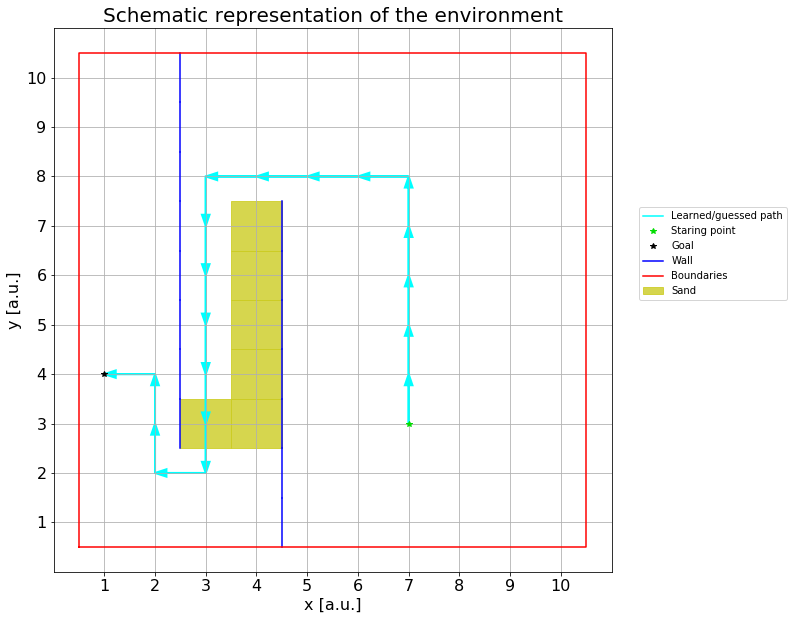

In [15]:
list_states = np.array(list_states)

plt.figure(figsize=(10,10))

# Trick to add legend
plt.plot(list_states.T[0][0:2], list_states.T[1][0:2], '-', color="#00ffff",
         label="Learned/guessed path")# Plotting trajectory as arrows
for p1,p2 in zip(list_states[:-1], list_states[1:]):
    if np.any(p1 != p2):
        dx = p2[0] - p1[0]
        dy = p2[1] - p1[1]
        plt.arrow(p1[0], p1[1], dx, dy, color="#00ffff", shape='full', lw=2, length_includes_head=True, head_width=0.15)

plt.plot(list_states.T[0][0], list_states.T[1][0], '*', color="#00dd00", label="Staring point")
plt.plot(goal[0], goal[1], '*', color="#000000", label="Goal")

# Plotting sand points
cont_sand = 0
for sand_p in sand:
    if cont_sand == 0:
        recta = plt.Rectangle( (sand_p[0]-0.5, sand_p[1]-0.5), 1, 1, color="#cccc22", alpha=0.8, label="Sand")
        plt.gca().add_patch(recta)
    else:
        recta = plt.Rectangle( (sand_p[0]-0.5, sand_p[1]-0.5), 1, 1, color="#cccc22", alpha=0.8)
        plt.gca().add_patch(recta)
    cont_sand += 1
        
cont = 0
for wall in walls:
    plot_wall(wall, cont)
    cont += 1

plt.xlim([-1,10])
plt.ylim([-1,10])

plt.xticks(np.arange(10), np.arange(10)+1, fontsize=16)
plt.yticks(np.arange(10), np.arange(10)+1, fontsize=16)

# Plotting bounaries
plt.plot([-0.5, 9.5, 9.5, -0.5, -0.5], [-0.5, -0.5, 9.5, 9.5, -0.5], color="#ff0000", label="Boundaries")

plt.title("Schematic representation of the environment", fontsize=20)

plt.xlabel("x [a.u.]", fontsize=16)
plt.ylabel("y [a.u.]", fontsize=16)

plt.legend(loc=(1.05,0.5))
plt.grid()

plt.savefig(str(path_img+"/ENV1__walls_sand_2.png"), bbox_inches='tight')

plt.show()

## Using S.A.R.S.A.

In [16]:
episodes = 2000         # number of training episodes
episode_length = 50     # maximum episode length
x = 10                  # horizontal size of the box
y = 10                  # vertical size of the box
goal = [0, 3]           # objective point
discount = 0.9          # exponential discount factor
softmax = False         # set to true to use Softmax policy
sarsa = True           # set to true to use the Sarsa algorithm
init_window = [[5,9],[0,4]]   # set [x1,x2],[y1,y2] generation interval for the x,y initial position

# TODO alpha and epsilon profile
alpha = np.ones(episodes) * 0.25
epsilon = np.linspace(0.8, 0.001,episodes)

# So the best action gets 1-ε, so 0.2
# 	the others get ε/(N-1)

# initialize the agent
learner = Agent((x * y), 5, discount, max_reward=1, softmax=softmax, sarsa=sarsa)

# Setting walls
walls = [[[1,3],[2,3]], [[1,4],[2,4]], [[1,2],[2,2]], [[1,5],[2,5]], [[1,6],[2,6]], [[1,7],[2,7]], [[1,8],[2,8]],[[1,9],[2,9]],
        [[3,0],[4,0]], [[3,1],[4,1]], [[3,2],[4,2]], [[3,3],[4,3]], [[3,4],[4,4]], [[3,5],[4,5]], [[3,6],[4,6]]]

# Setting sand
sand = [[3,6], [3,5], [3,4], [3,3], [3,2], [2,2]]

# perform the training
for index in range(0, episodes):
    # start from a random state
    initial = [np.random.randint(init_window[0][0], init_window[0][1]),
               np.random.randint(init_window[1][0], init_window[1][1])]
    # initialize environment
    state = initial
    
    # list of actions to visualize the track
    list_states = [initial]
    
    env = Environment(x, y, state, goal, walls = walls, sand=sand)
    reward = 0
    # run episode
    for step in range(0, episode_length):
        # find state index (vectorize the state in the matrix?)
        state_index = state[0] * y + state[1]
        # choose an action
        action = learner.select_action(state_index, epsilon[index])
        # the agent moves in the environment
        result = env.move(action)
        
        # Saving the last list of actions
        if (index == episodes-1):
            list_states.append(result[0])
        
        # Q-learning update
        next_index = result[0][0] * y + result[0][1]
        learner.update(state_index, action, result[1], next_index, alpha[index], epsilon[index])
        # update state and reward
        reward += result[1]
        state = result[0]
    # Only to track the average reward
    reward /= episode_length
    print('Episode ', index + 1, ': the agent has obtained an average reward of ', reward, ' starting from position ', initial) 
    
    # periodically save the agent
    if ((index + 1) % 10 == 0):
        with open('agent.obj', 'wb') as agent_file:
            dill.dump(learner, agent_file)

Episode  1 : the agent has obtained an average reward of  -0.1  starting from position  [6, 1]
Episode  2 : the agent has obtained an average reward of  -0.12  starting from position  [7, 0]
Episode  3 : the agent has obtained an average reward of  -0.2  starting from position  [8, 1]
Episode  4 : the agent has obtained an average reward of  -0.1  starting from position  [8, 0]
Episode  5 : the agent has obtained an average reward of  -0.08  starting from position  [5, 2]
Episode  6 : the agent has obtained an average reward of  -0.06  starting from position  [7, 1]
Episode  7 : the agent has obtained an average reward of  -0.04  starting from position  [5, 1]
Episode  8 : the agent has obtained an average reward of  -0.12  starting from position  [8, 1]
Episode  9 : the agent has obtained an average reward of  -0.18  starting from position  [8, 3]
Episode  10 : the agent has obtained an average reward of  -0.02  starting from position  [7, 3]
Episode  11 : the agent has obtained an av

Episode  88 : the agent has obtained an average reward of  -0.06  starting from position  [8, 2]
Episode  89 : the agent has obtained an average reward of  -0.08  starting from position  [7, 0]
Episode  90 : the agent has obtained an average reward of  0.0  starting from position  [6, 1]
Episode  91 : the agent has obtained an average reward of  -0.1  starting from position  [7, 3]
Episode  92 : the agent has obtained an average reward of  -0.02  starting from position  [7, 1]
Episode  93 : the agent has obtained an average reward of  -0.14  starting from position  [5, 1]
Episode  94 : the agent has obtained an average reward of  -0.02  starting from position  [5, 0]
Episode  95 : the agent has obtained an average reward of  -0.04  starting from position  [8, 2]
Episode  96 : the agent has obtained an average reward of  -0.34  starting from position  [5, 0]
Episode  97 : the agent has obtained an average reward of  -0.14  starting from position  [8, 3]
Episode  98 : the agent has obtai

Episode  183 : the agent has obtained an average reward of  -0.0006  starting from position  [5, 2]
Episode  184 : the agent has obtained an average reward of  -0.08  starting from position  [7, 0]
Episode  185 : the agent has obtained an average reward of  -0.02  starting from position  [7, 3]
Episode  186 : the agent has obtained an average reward of  -0.1  starting from position  [7, 0]
Episode  187 : the agent has obtained an average reward of  -0.04  starting from position  [5, 2]
Episode  188 : the agent has obtained an average reward of  -0.04  starting from position  [5, 0]
Episode  189 : the agent has obtained an average reward of  0.0  starting from position  [7, 3]
Episode  190 : the agent has obtained an average reward of  -0.04  starting from position  [7, 1]
Episode  191 : the agent has obtained an average reward of  -0.06  starting from position  [7, 3]
Episode  192 : the agent has obtained an average reward of  0.0  starting from position  [7, 0]
Episode  193 : the agen

Episode  278 : the agent has obtained an average reward of  0.0  starting from position  [5, 3]
Episode  279 : the agent has obtained an average reward of  -0.1604  starting from position  [6, 1]
Episode  280 : the agent has obtained an average reward of  -0.12  starting from position  [7, 1]
Episode  281 : the agent has obtained an average reward of  -0.06  starting from position  [8, 2]
Episode  282 : the agent has obtained an average reward of  -0.04  starting from position  [7, 0]
Episode  283 : the agent has obtained an average reward of  -0.02  starting from position  [7, 1]
Episode  284 : the agent has obtained an average reward of  0.0  starting from position  [8, 3]
Episode  285 : the agent has obtained an average reward of  -0.12  starting from position  [5, 0]
Episode  286 : the agent has obtained an average reward of  -0.02  starting from position  [8, 2]
Episode  287 : the agent has obtained an average reward of  -0.04  starting from position  [7, 3]
Episode  288 : the age

Episode  373 : the agent has obtained an average reward of  -0.02  starting from position  [5, 3]
Episode  374 : the agent has obtained an average reward of  -0.04159999999999996  starting from position  [8, 0]
Episode  375 : the agent has obtained an average reward of  0.0  starting from position  [6, 1]
Episode  376 : the agent has obtained an average reward of  -0.16  starting from position  [8, 3]
Episode  377 : the agent has obtained an average reward of  0.0  starting from position  [6, 1]
Episode  378 : the agent has obtained an average reward of  -0.0218  starting from position  [8, 3]
Episode  379 : the agent has obtained an average reward of  -0.08  starting from position  [7, 1]
Episode  380 : the agent has obtained an average reward of  -0.08  starting from position  [8, 2]
Episode  381 : the agent has obtained an average reward of  -0.06  starting from position  [6, 3]
Episode  382 : the agent has obtained an average reward of  -0.0002  starting from position  [5, 2]
Episo

Episode  457 : the agent has obtained an average reward of  0.0  starting from position  [6, 0]
Episode  458 : the agent has obtained an average reward of  0.0  starting from position  [8, 3]
Episode  459 : the agent has obtained an average reward of  -0.08  starting from position  [5, 2]
Episode  460 : the agent has obtained an average reward of  0.0  starting from position  [7, 3]
Episode  461 : the agent has obtained an average reward of  -0.06  starting from position  [7, 1]
Episode  462 : the agent has obtained an average reward of  -0.04  starting from position  [6, 1]
Episode  463 : the agent has obtained an average reward of  -0.1  starting from position  [8, 1]
Episode  464 : the agent has obtained an average reward of  0.0  starting from position  [8, 3]
Episode  465 : the agent has obtained an average reward of  -0.0206  starting from position  [5, 3]
Episode  466 : the agent has obtained an average reward of  -0.06  starting from position  [8, 0]
Episode  467 : the agent ha

Episode  539 : the agent has obtained an average reward of  -0.06  starting from position  [5, 0]
Episode  540 : the agent has obtained an average reward of  -0.0021999999999999997  starting from position  [5, 0]
Episode  541 : the agent has obtained an average reward of  -0.1  starting from position  [8, 2]
Episode  542 : the agent has obtained an average reward of  -0.0002  starting from position  [6, 3]
Episode  543 : the agent has obtained an average reward of  -0.0236  starting from position  [6, 3]
Episode  544 : the agent has obtained an average reward of  -0.02  starting from position  [8, 2]
Episode  545 : the agent has obtained an average reward of  -0.02  starting from position  [6, 2]
Episode  546 : the agent has obtained an average reward of  -0.02  starting from position  [8, 1]
Episode  547 : the agent has obtained an average reward of  -0.02  starting from position  [7, 1]
Episode  548 : the agent has obtained an average reward of  -0.08  starting from position  [8, 1]


Episode  621 : the agent has obtained an average reward of  0.0  starting from position  [8, 0]
Episode  622 : the agent has obtained an average reward of  -0.0002  starting from position  [6, 3]
Episode  623 : the agent has obtained an average reward of  -0.02  starting from position  [6, 0]
Episode  624 : the agent has obtained an average reward of  -0.02  starting from position  [7, 0]
Episode  625 : the agent has obtained an average reward of  -0.0012000000000000001  starting from position  [8, 2]
Episode  626 : the agent has obtained an average reward of  -0.021  starting from position  [5, 0]
Episode  627 : the agent has obtained an average reward of  -0.02  starting from position  [6, 3]
Episode  628 : the agent has obtained an average reward of  -0.06  starting from position  [8, 1]
Episode  629 : the agent has obtained an average reward of  -0.02  starting from position  [8, 0]
Episode  630 : the agent has obtained an average reward of  -0.0014000000000000002  starting from po

Episode  705 : the agent has obtained an average reward of  -0.04  starting from position  [7, 0]
Episode  706 : the agent has obtained an average reward of  -0.062400000000000004  starting from position  [5, 2]
Episode  707 : the agent has obtained an average reward of  0.059000000000000004  starting from position  [7, 3]
Episode  708 : the agent has obtained an average reward of  -0.0004  starting from position  [8, 2]
Episode  709 : the agent has obtained an average reward of  -0.04119999999999997  starting from position  [7, 0]
Episode  710 : the agent has obtained an average reward of  0.0  starting from position  [8, 1]
Episode  711 : the agent has obtained an average reward of  -0.0018  starting from position  [8, 3]
Episode  712 : the agent has obtained an average reward of  -0.021  starting from position  [5, 1]
Episode  713 : the agent has obtained an average reward of  -0.0024  starting from position  [8, 3]
Episode  714 : the agent has obtained an average reward of  -0.06  

Episode  789 : the agent has obtained an average reward of  -0.0204  starting from position  [6, 1]
Episode  790 : the agent has obtained an average reward of  -0.0014000000000000002  starting from position  [5, 1]
Episode  791 : the agent has obtained an average reward of  -0.0432  starting from position  [6, 0]
Episode  792 : the agent has obtained an average reward of  -0.0012000000000000001  starting from position  [5, 1]
Episode  793 : the agent has obtained an average reward of  0.0  starting from position  [8, 0]
Episode  794 : the agent has obtained an average reward of  -0.0014000000000000002  starting from position  [7, 3]
Episode  795 : the agent has obtained an average reward of  0.0  starting from position  [8, 0]
Episode  796 : the agent has obtained an average reward of  -0.0008  starting from position  [8, 0]
Episode  797 : the agent has obtained an average reward of  -0.0012000000000000001  starting from position  [5, 0]
Episode  798 : the agent has obtained an average

Episode  871 : the agent has obtained an average reward of  -0.0202  starting from position  [5, 2]
Episode  872 : the agent has obtained an average reward of  -0.0204  starting from position  [8, 2]
Episode  873 : the agent has obtained an average reward of  -0.0412  starting from position  [5, 1]
Episode  874 : the agent has obtained an average reward of  -0.04  starting from position  [8, 1]
Episode  875 : the agent has obtained an average reward of  -0.121  starting from position  [6, 3]
Episode  876 : the agent has obtained an average reward of  -0.004000000000000001  starting from position  [5, 1]
Episode  877 : the agent has obtained an average reward of  -0.021  starting from position  [8, 3]
Episode  878 : the agent has obtained an average reward of  -0.06  starting from position  [6, 0]
Episode  879 : the agent has obtained an average reward of  -0.0023999999999999976  starting from position  [6, 3]
Episode  880 : the agent has obtained an average reward of  -0.0412  starting

Episode  954 : the agent has obtained an average reward of  -0.0025999999999999994  starting from position  [8, 0]
Episode  955 : the agent has obtained an average reward of  -0.0016  starting from position  [8, 1]
Episode  956 : the agent has obtained an average reward of  -0.0418  starting from position  [7, 2]
Episode  957 : the agent has obtained an average reward of  0.0398  starting from position  [7, 3]
Episode  958 : the agent has obtained an average reward of  -0.0204  starting from position  [7, 0]
Episode  959 : the agent has obtained an average reward of  -0.0002  starting from position  [7, 2]
Episode  960 : the agent has obtained an average reward of  -0.021400000000000002  starting from position  [7, 1]
Episode  961 : the agent has obtained an average reward of  -0.0021999999999999997  starting from position  [6, 3]
Episode  962 : the agent has obtained an average reward of  -0.0608  starting from position  [7, 2]
Episode  963 : the agent has obtained an average reward o

Episode  1038 : the agent has obtained an average reward of  -0.0012000000000000001  starting from position  [8, 1]
Episode  1039 : the agent has obtained an average reward of  -0.0008  starting from position  [6, 3]
Episode  1040 : the agent has obtained an average reward of  -0.0014000000000000013  starting from position  [8, 0]
Episode  1041 : the agent has obtained an average reward of  -0.0206  starting from position  [5, 1]
Episode  1042 : the agent has obtained an average reward of  0.0182  starting from position  [7, 1]
Episode  1043 : the agent has obtained an average reward of  -0.0014000000000000002  starting from position  [5, 0]
Episode  1044 : the agent has obtained an average reward of  -0.0202  starting from position  [5, 2]
Episode  1045 : the agent has obtained an average reward of  0.018  starting from position  [7, 3]
Episode  1046 : the agent has obtained an average reward of  -0.0008  starting from position  [5, 2]
Episode  1047 : the agent has obtained an average

Episode  1117 : the agent has obtained an average reward of  0.05859999999999999  starting from position  [5, 3]
Episode  1118 : the agent has obtained an average reward of  0.2588  starting from position  [6, 3]
Episode  1119 : the agent has obtained an average reward of  0.056799999999999996  starting from position  [5, 2]
Episode  1120 : the agent has obtained an average reward of  -0.0416  starting from position  [6, 3]
Episode  1121 : the agent has obtained an average reward of  0.057999999999999996  starting from position  [7, 2]
Episode  1122 : the agent has obtained an average reward of  -0.0014000000000000002  starting from position  [6, 3]
Episode  1123 : the agent has obtained an average reward of  -0.021400000000000002  starting from position  [6, 2]
Episode  1124 : the agent has obtained an average reward of  -0.0017999999999999993  starting from position  [6, 2]
Episode  1125 : the agent has obtained an average reward of  -0.081  starting from position  [5, 0]
Episode  11

Episode  1204 : the agent has obtained an average reward of  0.0184  starting from position  [8, 2]
Episode  1205 : the agent has obtained an average reward of  0.07980000000000001  starting from position  [6, 3]
Episode  1206 : the agent has obtained an average reward of  -0.04019999999999999  starting from position  [5, 0]
Episode  1207 : the agent has obtained an average reward of  -0.061200000000000004  starting from position  [5, 2]
Episode  1208 : the agent has obtained an average reward of  0.0384  starting from position  [6, 1]
Episode  1209 : the agent has obtained an average reward of  0.0784  starting from position  [6, 1]
Episode  1210 : the agent has obtained an average reward of  0.03900000000000001  starting from position  [6, 1]
Episode  1211 : the agent has obtained an average reward of  0.19939999999999997  starting from position  [6, 2]
Episode  1212 : the agent has obtained an average reward of  0.0592  starting from position  [8, 2]
Episode  1213 : the agent has ob

Episode  1283 : the agent has obtained an average reward of  0.1186  starting from position  [8, 1]
Episode  1284 : the agent has obtained an average reward of  0.079  starting from position  [6, 1]
Episode  1285 : the agent has obtained an average reward of  0.19920000000000002  starting from position  [7, 2]
Episode  1286 : the agent has obtained an average reward of  0.0984  starting from position  [8, 0]
Episode  1287 : the agent has obtained an average reward of  0.218  starting from position  [6, 3]
Episode  1288 : the agent has obtained an average reward of  -0.0016  starting from position  [5, 3]
Episode  1289 : the agent has obtained an average reward of  -0.0020000000000000018  starting from position  [7, 1]
Episode  1290 : the agent has obtained an average reward of  0.19899999999999998  starting from position  [8, 3]
Episode  1291 : the agent has obtained an average reward of  0.019  starting from position  [5, 0]
Episode  1292 : the agent has obtained an average reward of 

Episode  1370 : the agent has obtained an average reward of  0.07980000000000001  starting from position  [8, 3]
Episode  1371 : the agent has obtained an average reward of  -0.0002  starting from position  [8, 3]
Episode  1372 : the agent has obtained an average reward of  0.1998  starting from position  [6, 2]
Episode  1373 : the agent has obtained an average reward of  0.1998  starting from position  [8, 2]
Episode  1374 : the agent has obtained an average reward of  0.0794  starting from position  [8, 2]
Episode  1375 : the agent has obtained an average reward of  0.0998  starting from position  [5, 2]
Episode  1376 : the agent has obtained an average reward of  0.2998  starting from position  [7, 3]
Episode  1377 : the agent has obtained an average reward of  0.1386  starting from position  [8, 2]
Episode  1378 : the agent has obtained an average reward of  0.099  starting from position  [7, 1]
Episode  1379 : the agent has obtained an average reward of  0.1198  starting from posi

Episode  1451 : the agent has obtained an average reward of  0.239  starting from position  [5, 0]
Episode  1452 : the agent has obtained an average reward of  0.1996  starting from position  [5, 1]
Episode  1453 : the agent has obtained an average reward of  -0.0006  starting from position  [6, 0]
Episode  1454 : the agent has obtained an average reward of  0.2596  starting from position  [5, 1]
Episode  1455 : the agent has obtained an average reward of  0.25939999999999996  starting from position  [8, 2]
Episode  1456 : the agent has obtained an average reward of  0.2396  starting from position  [8, 1]
Episode  1457 : the agent has obtained an average reward of  0.319  starting from position  [7, 3]
Episode  1458 : the agent has obtained an average reward of  0.379  starting from position  [6, 3]
Episode  1459 : the agent has obtained an average reward of  0.2588  starting from position  [8, 3]
Episode  1460 : the agent has obtained an average reward of  -0.061  starting from positi

Episode  1537 : the agent has obtained an average reward of  0.299  starting from position  [6, 0]
Episode  1538 : the agent has obtained an average reward of  0.23879999999999998  starting from position  [5, 3]
Episode  1539 : the agent has obtained an average reward of  0.4792  starting from position  [6, 2]
Episode  1540 : the agent has obtained an average reward of  0.31939999999999996  starting from position  [6, 0]
Episode  1541 : the agent has obtained an average reward of  0.2786  starting from position  [7, 2]
Episode  1542 : the agent has obtained an average reward of  0.19879999999999998  starting from position  [8, 3]
Episode  1543 : the agent has obtained an average reward of  0.47859999999999997  starting from position  [6, 3]
Episode  1544 : the agent has obtained an average reward of  0.2188  starting from position  [6, 2]
Episode  1545 : the agent has obtained an average reward of  0.21899999999999997  starting from position  [7, 1]
Episode  1546 : the agent has obtain

Episode  1621 : the agent has obtained an average reward of  0.379  starting from position  [6, 3]
Episode  1622 : the agent has obtained an average reward of  0.21960000000000002  starting from position  [7, 3]
Episode  1623 : the agent has obtained an average reward of  0.43920000000000003  starting from position  [8, 2]
Episode  1624 : the agent has obtained an average reward of  0.37920000000000004  starting from position  [5, 3]
Episode  1625 : the agent has obtained an average reward of  0.19920000000000002  starting from position  [5, 0]
Episode  1626 : the agent has obtained an average reward of  0.3392  starting from position  [5, 1]
Episode  1627 : the agent has obtained an average reward of  0.2986  starting from position  [7, 0]
Episode  1628 : the agent has obtained an average reward of  0.31920000000000004  starting from position  [6, 0]
Episode  1629 : the agent has obtained an average reward of  0.3592  starting from position  [7, 3]
Episode  1630 : the agent has obtain

Episode  1705 : the agent has obtained an average reward of  0.4792  starting from position  [6, 2]
Episode  1706 : the agent has obtained an average reward of  0.37799999999999995  starting from position  [6, 2]
Episode  1707 : the agent has obtained an average reward of  0.5992000000000001  starting from position  [6, 2]
Episode  1708 : the agent has obtained an average reward of  0.359  starting from position  [7, 0]
Episode  1709 : the agent has obtained an average reward of  0.3992  starting from position  [5, 1]
Episode  1710 : the agent has obtained an average reward of  0.37879999999999997  starting from position  [8, 2]
Episode  1711 : the agent has obtained an average reward of  0.19899999999999998  starting from position  [8, 1]
Episode  1712 : the agent has obtained an average reward of  0.39899999999999997  starting from position  [7, 1]
Episode  1713 : the agent has obtained an average reward of  0.2992  starting from position  [6, 3]
Episode  1714 : the agent has obtaine

Episode  1790 : the agent has obtained an average reward of  0.33899999999999997  starting from position  [7, 1]
Episode  1791 : the agent has obtained an average reward of  0.39879999999999993  starting from position  [7, 0]
Episode  1792 : the agent has obtained an average reward of  0.45879999999999993  starting from position  [6, 2]
Episode  1793 : the agent has obtained an average reward of  0.4592  starting from position  [8, 1]
Episode  1794 : the agent has obtained an average reward of  0.4592  starting from position  [7, 1]
Episode  1795 : the agent has obtained an average reward of  0.5596  starting from position  [6, 2]
Episode  1796 : the agent has obtained an average reward of  0.5592  starting from position  [7, 2]
Episode  1797 : the agent has obtained an average reward of  0.39899999999999997  starting from position  [6, 1]
Episode  1798 : the agent has obtained an average reward of  0.5392  starting from position  [6, 0]
Episode  1799 : the agent has obtained an averag

Episode  1873 : the agent has obtained an average reward of  0.5392  starting from position  [8, 2]
Episode  1874 : the agent has obtained an average reward of  0.4592  starting from position  [8, 0]
Episode  1875 : the agent has obtained an average reward of  0.3992  starting from position  [8, 0]
Episode  1876 : the agent has obtained an average reward of  0.6194  starting from position  [6, 2]
Episode  1877 : the agent has obtained an average reward of  0.519  starting from position  [6, 1]
Episode  1878 : the agent has obtained an average reward of  0.4792  starting from position  [7, 0]
Episode  1879 : the agent has obtained an average reward of  0.5592  starting from position  [6, 3]
Episode  1880 : the agent has obtained an average reward of  0.5992000000000001  starting from position  [5, 3]
Episode  1881 : the agent has obtained an average reward of  0.5192  starting from position  [5, 0]
Episode  1882 : the agent has obtained an average reward of  0.5186  starting from positi

Episode  1954 : the agent has obtained an average reward of  0.6192  starting from position  [7, 3]
Episode  1955 : the agent has obtained an average reward of  0.6192  starting from position  [7, 3]
Episode  1956 : the agent has obtained an average reward of  0.5192  starting from position  [7, 2]
Episode  1957 : the agent has obtained an average reward of  0.5392  starting from position  [6, 0]
Episode  1958 : the agent has obtained an average reward of  0.5192  starting from position  [8, 3]
Episode  1959 : the agent has obtained an average reward of  0.5992000000000001  starting from position  [5, 0]
Episode  1960 : the agent has obtained an average reward of  0.5992000000000001  starting from position  [6, 1]
Episode  1961 : the agent has obtained an average reward of  0.5192  starting from position  [6, 1]
Episode  1962 : the agent has obtained an average reward of  0.5992000000000001  starting from position  [8, 3]
Episode  1963 : the agent has obtained an average reward of  0.5

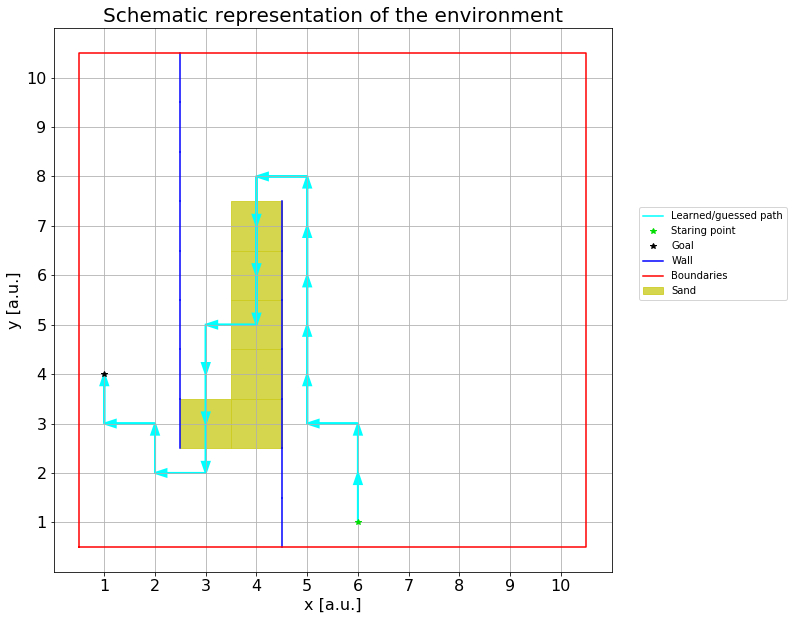

In [17]:
list_states = np.array(list_states)

plt.figure(figsize=(10,10))

# Trick to add legend
plt.plot(list_states.T[0][0:2], list_states.T[1][0:2], '-', color="#00ffff",
         label="Learned/guessed path")# Plotting trajectory as arrows
for p1,p2 in zip(list_states[:-1], list_states[1:]):
    if np.any(p1 != p2):
        dx = p2[0] - p1[0]
        dy = p2[1] - p1[1]
        plt.arrow(p1[0], p1[1], dx, dy, color="#00ffff", shape='full', lw=2, length_includes_head=True, head_width=0.15)

plt.plot(list_states.T[0][0], list_states.T[1][0], '*', color="#00dd00", label="Staring point")
plt.plot(goal[0], goal[1], '*', color="#000000", label="Goal")

# Plotting sand points
cont_sand = 0
for sand_p in sand:
    if cont_sand == 0:
        recta = plt.Rectangle( (sand_p[0]-0.5, sand_p[1]-0.5), 1, 1, color="#cccc22", alpha=0.8, label="Sand")
        plt.gca().add_patch(recta)
    else:
        recta = plt.Rectangle( (sand_p[0]-0.5, sand_p[1]-0.5), 1, 1, color="#cccc22", alpha=0.8)
        plt.gca().add_patch(recta)
    cont_sand += 1
        
cont = 0
for wall in walls:
    plot_wall(wall, cont)
    cont += 1

plt.xlim([-1,10])
plt.ylim([-1,10])

plt.xticks(np.arange(10), np.arange(10)+1, fontsize=16)
plt.yticks(np.arange(10), np.arange(10)+1, fontsize=16)

# Plotting bounaries
plt.plot([-0.5, 9.5, 9.5, -0.5, -0.5], [-0.5, -0.5, 9.5, 9.5, -0.5], color="#ff0000", label="Boundaries")

plt.title("Schematic representation of the environment", fontsize=20)

plt.xlabel("x [a.u.]", fontsize=16)
plt.ylabel("y [a.u.]", fontsize=16)

plt.legend(loc=(1.05,0.5))
plt.grid()

plt.savefig(str(path_img+"/ENV1__walls_sand_SARSA_2.png"), bbox_inches='tight')

plt.show()

## Using softmax

In [18]:
episodes = 2000         # number of training episodes
episode_length = 50     # maximum episode length
x = 10                  # horizontal size of the box
y = 10                  # vertical size of the box
goal = [0, 3]           # objective point
discount = 0.9          # exponential discount factor
softmax = True          # set to true to use Softmax policy
sarsa = True            # set to true to use the Sarsa algorithm
init_window = [[5,9],[0,4]]   # set [x1,x2],[y1,y2] generation interval for the x,y initial position

# TODO alpha and epsilon profile
alpha = np.ones(episodes) * 0.25
epsilon = np.linspace(0.8, 0.001,episodes)

# So the best action gets 1-ε, so 0.2
# 	the others get ε/(N-1)

# initialize the agent
learner = Agent((x * y), 5, discount, max_reward=1, softmax=softmax, sarsa=sarsa)

# Setting walls
walls = [[[1,3],[2,3]], [[1,4],[2,4]], [[1,2],[2,2]], [[1,5],[2,5]], [[1,6],[2,6]], [[1,7],[2,7]], [[1,8],[2,8]],[[1,9],[2,9]],
        [[3,0],[4,0]], [[3,1],[4,1]], [[3,2],[4,2]], [[3,3],[4,3]], [[3,4],[4,4]], [[3,5],[4,5]], [[3,6],[4,6]]]

# Setting sand
sand = [[3,6], [3,5], [3,4], [3,3], [3,2], [2,2]]

# perform the training
for index in range(0, episodes):
    # start from a random state
    initial = [np.random.randint(init_window[0][0], init_window[0][1]),
               np.random.randint(init_window[1][0], init_window[1][1])]
    # initialize environment
    state = initial
    
    # list of actions to visualize the track
    list_states = [initial]
    
    env = Environment(x, y, state, goal, walls = walls, sand=sand)
    reward = 0
    # run episode
    for step in range(0, episode_length):
        # find state index (vectorize the state in the matrix?)
        state_index = state[0] * y + state[1]
        # choose an action
        action = learner.select_action(state_index, epsilon[index])
        # the agent moves in the environment
        result = env.move(action)
        
        # Saving the last list of actions
        if (index == episodes-1):
            list_states.append(result[0])
        
        # Q-learning update
        next_index = result[0][0] * y + result[0][1]
        learner.update(state_index, action, result[1], next_index, alpha[index], epsilon[index])
        # update state and reward
        reward += result[1]
        state = result[0]
    # Only to track the average reward
    reward /= episode_length
    print('Episode ', index + 1, ': the agent has obtained an average reward of ', reward, ' starting from position ', initial) 
    
    # periodically save the agent
    if ((index + 1) % 10 == 0):
        with open('agent.obj', 'wb') as agent_file:
            dill.dump(learner, agent_file)

Episode  1 : the agent has obtained an average reward of  0.0  starting from position  [6, 1]
Episode  2 : the agent has obtained an average reward of  -0.06  starting from position  [8, 1]
Episode  3 : the agent has obtained an average reward of  -0.08  starting from position  [5, 0]
Episode  4 : the agent has obtained an average reward of  -0.06  starting from position  [6, 3]
Episode  5 : the agent has obtained an average reward of  -0.06  starting from position  [6, 1]
Episode  6 : the agent has obtained an average reward of  -0.16  starting from position  [8, 2]
Episode  7 : the agent has obtained an average reward of  0.0  starting from position  [5, 3]
Episode  8 : the agent has obtained an average reward of  -0.06  starting from position  [7, 1]
Episode  9 : the agent has obtained an average reward of  -0.12  starting from position  [6, 1]
Episode  10 : the agent has obtained an average reward of  -0.02  starting from position  [7, 1]
Episode  11 : the agent has obtained an ave

Episode  89 : the agent has obtained an average reward of  0.0  starting from position  [6, 0]
Episode  90 : the agent has obtained an average reward of  -0.02  starting from position  [6, 2]
Episode  91 : the agent has obtained an average reward of  -0.02  starting from position  [5, 2]
Episode  92 : the agent has obtained an average reward of  -0.08  starting from position  [6, 3]
Episode  93 : the agent has obtained an average reward of  -0.02  starting from position  [8, 1]
Episode  94 : the agent has obtained an average reward of  -0.1  starting from position  [7, 2]
Episode  95 : the agent has obtained an average reward of  -0.0027999999999999995  starting from position  [7, 2]
Episode  96 : the agent has obtained an average reward of  -0.0021999999999999997  starting from position  [6, 3]
Episode  97 : the agent has obtained an average reward of  -0.0204  starting from position  [8, 3]
Episode  98 : the agent has obtained an average reward of  0.0  starting from position  [5, 1]

Episode  181 : the agent has obtained an average reward of  -0.12  starting from position  [8, 2]
Episode  182 : the agent has obtained an average reward of  -0.08  starting from position  [8, 3]
Episode  183 : the agent has obtained an average reward of  -0.0006  starting from position  [7, 2]
Episode  184 : the agent has obtained an average reward of  -0.02  starting from position  [5, 2]
Episode  185 : the agent has obtained an average reward of  -0.02  starting from position  [5, 3]
Episode  186 : the agent has obtained an average reward of  -0.0202  starting from position  [5, 3]
Episode  187 : the agent has obtained an average reward of  -0.04  starting from position  [6, 0]
Episode  188 : the agent has obtained an average reward of  -0.08  starting from position  [6, 3]
Episode  189 : the agent has obtained an average reward of  -0.02  starting from position  [8, 2]
Episode  190 : the agent has obtained an average reward of  0.0  starting from position  [6, 3]
Episode  191 : the

Episode  267 : the agent has obtained an average reward of  -0.06  starting from position  [5, 3]
Episode  268 : the agent has obtained an average reward of  -0.02  starting from position  [5, 3]
Episode  269 : the agent has obtained an average reward of  -0.02  starting from position  [7, 0]
Episode  270 : the agent has obtained an average reward of  -0.02  starting from position  [8, 0]
Episode  271 : the agent has obtained an average reward of  -0.0202  starting from position  [7, 2]
Episode  272 : the agent has obtained an average reward of  -0.02  starting from position  [8, 0]
Episode  273 : the agent has obtained an average reward of  -0.001  starting from position  [8, 1]
Episode  274 : the agent has obtained an average reward of  -0.04119999999999997  starting from position  [5, 1]
Episode  275 : the agent has obtained an average reward of  0.0  starting from position  [8, 1]
Episode  276 : the agent has obtained an average reward of  -0.0206  starting from position  [7, 0]
Ep

Episode  355 : the agent has obtained an average reward of  -0.04  starting from position  [8, 3]
Episode  356 : the agent has obtained an average reward of  -0.0008  starting from position  [6, 3]
Episode  357 : the agent has obtained an average reward of  -0.04  starting from position  [5, 0]
Episode  358 : the agent has obtained an average reward of  -0.004200000000000001  starting from position  [5, 2]
Episode  359 : the agent has obtained an average reward of  -0.08  starting from position  [5, 0]
Episode  360 : the agent has obtained an average reward of  -0.021  starting from position  [6, 2]
Episode  361 : the agent has obtained an average reward of  -0.0016  starting from position  [8, 1]
Episode  362 : the agent has obtained an average reward of  -0.08  starting from position  [6, 1]
Episode  363 : the agent has obtained an average reward of  -0.04  starting from position  [5, 0]
Episode  364 : the agent has obtained an average reward of  -0.02  starting from position  [6, 0]

Episode  438 : the agent has obtained an average reward of  -0.04  starting from position  [6, 0]
Episode  439 : the agent has obtained an average reward of  -0.0027999999999999995  starting from position  [5, 1]
Episode  440 : the agent has obtained an average reward of  0.0  starting from position  [8, 3]
Episode  441 : the agent has obtained an average reward of  -0.02  starting from position  [8, 2]
Episode  442 : the agent has obtained an average reward of  0.0  starting from position  [7, 3]
Episode  443 : the agent has obtained an average reward of  -0.02  starting from position  [7, 1]
Episode  444 : the agent has obtained an average reward of  -0.0004  starting from position  [5, 1]
Episode  445 : the agent has obtained an average reward of  0.0  starting from position  [6, 3]
Episode  446 : the agent has obtained an average reward of  -0.04  starting from position  [7, 1]
Episode  447 : the agent has obtained an average reward of  -0.0032  starting from position  [5, 3]
Episo

Episode  521 : the agent has obtained an average reward of  -0.02  starting from position  [8, 0]
Episode  522 : the agent has obtained an average reward of  -0.04  starting from position  [8, 1]
Episode  523 : the agent has obtained an average reward of  -0.0202  starting from position  [5, 3]
Episode  524 : the agent has obtained an average reward of  0.0  starting from position  [6, 2]
Episode  525 : the agent has obtained an average reward of  -0.04  starting from position  [5, 0]
Episode  526 : the agent has obtained an average reward of  0.0  starting from position  [8, 1]
Episode  527 : the agent has obtained an average reward of  0.0  starting from position  [8, 2]
Episode  528 : the agent has obtained an average reward of  0.0  starting from position  [6, 0]
Episode  529 : the agent has obtained an average reward of  -0.04  starting from position  [8, 0]
Episode  530 : the agent has obtained an average reward of  -0.02  starting from position  [6, 0]
Episode  531 : the agent h

Episode  613 : the agent has obtained an average reward of  -0.04  starting from position  [7, 1]
Episode  614 : the agent has obtained an average reward of  -0.04  starting from position  [7, 3]
Episode  615 : the agent has obtained an average reward of  -0.02  starting from position  [5, 0]
Episode  616 : the agent has obtained an average reward of  0.0  starting from position  [8, 3]
Episode  617 : the agent has obtained an average reward of  0.0  starting from position  [6, 1]
Episode  618 : the agent has obtained an average reward of  -0.02  starting from position  [7, 1]
Episode  619 : the agent has obtained an average reward of  0.0  starting from position  [7, 0]
Episode  620 : the agent has obtained an average reward of  0.0  starting from position  [6, 0]
Episode  621 : the agent has obtained an average reward of  -0.04  starting from position  [8, 3]
Episode  622 : the agent has obtained an average reward of  0.0  starting from position  [6, 0]
Episode  623 : the agent has o

Episode  698 : the agent has obtained an average reward of  0.0  starting from position  [7, 2]
Episode  699 : the agent has obtained an average reward of  0.0  starting from position  [7, 1]
Episode  700 : the agent has obtained an average reward of  0.0  starting from position  [8, 0]
Episode  701 : the agent has obtained an average reward of  0.0  starting from position  [5, 3]
Episode  702 : the agent has obtained an average reward of  0.0  starting from position  [6, 0]
Episode  703 : the agent has obtained an average reward of  -0.0006  starting from position  [5, 3]
Episode  704 : the agent has obtained an average reward of  -0.0008  starting from position  [8, 3]
Episode  705 : the agent has obtained an average reward of  -0.0016  starting from position  [5, 1]
Episode  706 : the agent has obtained an average reward of  0.0  starting from position  [7, 3]
Episode  707 : the agent has obtained an average reward of  -0.02  starting from position  [7, 2]
Episode  708 : the agent h

Episode  787 : the agent has obtained an average reward of  0.0  starting from position  [7, 3]
Episode  788 : the agent has obtained an average reward of  -0.02  starting from position  [5, 0]
Episode  789 : the agent has obtained an average reward of  -0.02  starting from position  [5, 2]
Episode  790 : the agent has obtained an average reward of  0.0  starting from position  [6, 0]
Episode  791 : the agent has obtained an average reward of  0.0  starting from position  [6, 2]
Episode  792 : the agent has obtained an average reward of  -0.021  starting from position  [6, 2]
Episode  793 : the agent has obtained an average reward of  -0.0027999999999999995  starting from position  [5, 2]
Episode  794 : the agent has obtained an average reward of  -0.0016  starting from position  [8, 3]
Episode  795 : the agent has obtained an average reward of  -0.0018  starting from position  [6, 1]
Episode  796 : the agent has obtained an average reward of  -0.003  starting from position  [6, 0]
Epi

Episode  876 : the agent has obtained an average reward of  -0.02  starting from position  [6, 0]
Episode  877 : the agent has obtained an average reward of  -0.02  starting from position  [5, 3]
Episode  878 : the agent has obtained an average reward of  -0.02  starting from position  [8, 0]
Episode  879 : the agent has obtained an average reward of  -0.042  starting from position  [5, 3]
Episode  880 : the agent has obtained an average reward of  -0.02  starting from position  [7, 3]
Episode  881 : the agent has obtained an average reward of  -0.0008  starting from position  [7, 2]
Episode  882 : the agent has obtained an average reward of  -0.001  starting from position  [7, 1]
Episode  883 : the agent has obtained an average reward of  0.0  starting from position  [7, 2]
Episode  884 : the agent has obtained an average reward of  -0.0204  starting from position  [5, 3]
Episode  885 : the agent has obtained an average reward of  0.0  starting from position  [6, 0]
Episode  886 : the

Episode  964 : the agent has obtained an average reward of  0.0  starting from position  [5, 3]
Episode  965 : the agent has obtained an average reward of  0.0192  starting from position  [7, 3]
Episode  966 : the agent has obtained an average reward of  -0.0412  starting from position  [5, 3]
Episode  967 : the agent has obtained an average reward of  -0.0018  starting from position  [8, 2]
Episode  968 : the agent has obtained an average reward of  -0.02  starting from position  [8, 0]
Episode  969 : the agent has obtained an average reward of  -0.02  starting from position  [6, 1]
Episode  970 : the agent has obtained an average reward of  -0.0002  starting from position  [7, 1]
Episode  971 : the agent has obtained an average reward of  0.0  starting from position  [7, 1]
Episode  972 : the agent has obtained an average reward of  -0.02  starting from position  [8, 1]
Episode  973 : the agent has obtained an average reward of  0.0  starting from position  [5, 0]
Episode  974 : the 

Episode  1052 : the agent has obtained an average reward of  0.0  starting from position  [5, 3]
Episode  1053 : the agent has obtained an average reward of  -0.0002  starting from position  [5, 3]
Episode  1054 : the agent has obtained an average reward of  -0.02  starting from position  [8, 3]
Episode  1055 : the agent has obtained an average reward of  -0.0002  starting from position  [7, 0]
Episode  1056 : the agent has obtained an average reward of  -0.04  starting from position  [8, 3]
Episode  1057 : the agent has obtained an average reward of  -0.0014000000000000013  starting from position  [6, 1]
Episode  1058 : the agent has obtained an average reward of  -0.04  starting from position  [8, 3]
Episode  1059 : the agent has obtained an average reward of  0.0  starting from position  [6, 1]
Episode  1060 : the agent has obtained an average reward of  0.0  starting from position  [5, 2]
Episode  1061 : the agent has obtained an average reward of  0.0  starting from position  [8, 

Episode  1133 : the agent has obtained an average reward of  0.0  starting from position  [6, 0]
Episode  1134 : the agent has obtained an average reward of  0.0  starting from position  [7, 0]
Episode  1135 : the agent has obtained an average reward of  -0.001  starting from position  [8, 2]
Episode  1136 : the agent has obtained an average reward of  0.0  starting from position  [6, 2]
Episode  1137 : the agent has obtained an average reward of  -0.0006  starting from position  [5, 2]
Episode  1138 : the agent has obtained an average reward of  -0.0014000000000000002  starting from position  [7, 3]
Episode  1139 : the agent has obtained an average reward of  0.0  starting from position  [8, 1]
Episode  1140 : the agent has obtained an average reward of  0.0  starting from position  [5, 2]
Episode  1141 : the agent has obtained an average reward of  -0.02  starting from position  [7, 2]
Episode  1142 : the agent has obtained an average reward of  0.1384  starting from position  [6, 2]

Episode  1219 : the agent has obtained an average reward of  0.0  starting from position  [7, 1]
Episode  1220 : the agent has obtained an average reward of  0.099  starting from position  [8, 2]
Episode  1221 : the agent has obtained an average reward of  0.0  starting from position  [5, 0]
Episode  1222 : the agent has obtained an average reward of  0.0784  starting from position  [6, 3]
Episode  1223 : the agent has obtained an average reward of  -0.0012000000000000001  starting from position  [5, 0]
Episode  1224 : the agent has obtained an average reward of  -0.02  starting from position  [5, 1]
Episode  1225 : the agent has obtained an average reward of  0.0  starting from position  [8, 3]
Episode  1226 : the agent has obtained an average reward of  -0.02  starting from position  [6, 0]
Episode  1227 : the agent has obtained an average reward of  -0.0002  starting from position  [7, 1]
Episode  1228 : the agent has obtained an average reward of  0.0  starting from position  [7, 0

Episode  1303 : the agent has obtained an average reward of  0.0  starting from position  [8, 0]
Episode  1304 : the agent has obtained an average reward of  0.0  starting from position  [7, 2]
Episode  1305 : the agent has obtained an average reward of  0.1186  starting from position  [7, 1]
Episode  1306 : the agent has obtained an average reward of  0.35960000000000003  starting from position  [7, 2]
Episode  1307 : the agent has obtained an average reward of  0.0  starting from position  [8, 3]
Episode  1308 : the agent has obtained an average reward of  -0.02  starting from position  [5, 1]
Episode  1309 : the agent has obtained an average reward of  0.0  starting from position  [7, 0]
Episode  1310 : the agent has obtained an average reward of  0.0  starting from position  [8, 1]
Episode  1311 : the agent has obtained an average reward of  0.3186  starting from position  [7, 0]
Episode  1312 : the agent has obtained an average reward of  -0.0004  starting from position  [6, 0]
Ep

Episode  1387 : the agent has obtained an average reward of  0.4998  starting from position  [8, 2]
Episode  1388 : the agent has obtained an average reward of  0.5398000000000001  starting from position  [6, 1]
Episode  1389 : the agent has obtained an average reward of  -0.0002  starting from position  [7, 3]
Episode  1390 : the agent has obtained an average reward of  0.2998  starting from position  [5, 1]
Episode  1391 : the agent has obtained an average reward of  0.5598000000000001  starting from position  [6, 3]
Episode  1392 : the agent has obtained an average reward of  0.0  starting from position  [8, 1]
Episode  1393 : the agent has obtained an average reward of  0.0  starting from position  [8, 2]
Episode  1394 : the agent has obtained an average reward of  0.0  starting from position  [7, 0]
Episode  1395 : the agent has obtained an average reward of  0.39980000000000004  starting from position  [5, 0]
Episode  1396 : the agent has obtained an average reward of  0.6598  st

Episode  1474 : the agent has obtained an average reward of  0.6398  starting from position  [6, 3]
Episode  1475 : the agent has obtained an average reward of  0.6398  starting from position  [5, 2]
Episode  1476 : the agent has obtained an average reward of  0.6198  starting from position  [5, 1]
Episode  1477 : the agent has obtained an average reward of  0.6198  starting from position  [7, 3]
Episode  1478 : the agent has obtained an average reward of  0.5398000000000001  starting from position  [7, 0]
Episode  1479 : the agent has obtained an average reward of  0.5196000000000001  starting from position  [7, 1]
Episode  1480 : the agent has obtained an average reward of  0.6396000000000001  starting from position  [5, 2]
Episode  1481 : the agent has obtained an average reward of  0.5998  starting from position  [8, 3]
Episode  1482 : the agent has obtained an average reward of  0.5798000000000001  starting from position  [6, 0]
Episode  1483 : the agent has obtained an average re

Episode  1554 : the agent has obtained an average reward of  0.5998  starting from position  [6, 1]
Episode  1555 : the agent has obtained an average reward of  0.5998  starting from position  [7, 2]
Episode  1556 : the agent has obtained an average reward of  0.5798000000000001  starting from position  [6, 0]
Episode  1557 : the agent has obtained an average reward of  0.5598000000000001  starting from position  [7, 0]
Episode  1558 : the agent has obtained an average reward of  0.6598  starting from position  [5, 3]
Episode  1559 : the agent has obtained an average reward of  0.5996  starting from position  [6, 1]
Episode  1560 : the agent has obtained an average reward of  0.5996  starting from position  [5, 0]
Episode  1561 : the agent has obtained an average reward of  0.5998  starting from position  [8, 3]
Episode  1562 : the agent has obtained an average reward of  0.5796  starting from position  [8, 2]
Episode  1563 : the agent has obtained an average reward of  0.5798000000000

Episode  1635 : the agent has obtained an average reward of  0.6198  starting from position  [5, 1]
Episode  1636 : the agent has obtained an average reward of  0.5598000000000001  starting from position  [7, 0]
Episode  1637 : the agent has obtained an average reward of  0.5998  starting from position  [7, 2]
Episode  1638 : the agent has obtained an average reward of  0.6198  starting from position  [7, 3]
Episode  1639 : the agent has obtained an average reward of  0.6198  starting from position  [6, 2]
Episode  1640 : the agent has obtained an average reward of  0.5796  starting from position  [7, 1]
Episode  1641 : the agent has obtained an average reward of  0.5798000000000001  starting from position  [7, 1]
Episode  1642 : the agent has obtained an average reward of  0.6396000000000001  starting from position  [5, 2]
Episode  1643 : the agent has obtained an average reward of  0.5796  starting from position  [8, 2]
Episode  1644 : the agent has obtained an average reward of  0.6

Episode  1715 : the agent has obtained an average reward of  0.5798000000000001  starting from position  [7, 1]
Episode  1716 : the agent has obtained an average reward of  0.6398  starting from position  [5, 2]
Episode  1717 : the agent has obtained an average reward of  0.6198  starting from position  [7, 3]
Episode  1718 : the agent has obtained an average reward of  0.5598000000000001  starting from position  [7, 0]
Episode  1719 : the agent has obtained an average reward of  0.5996  starting from position  [6, 1]
Episode  1720 : the agent has obtained an average reward of  0.6196  starting from position  [7, 3]
Episode  1721 : the agent has obtained an average reward of  0.5398000000000001  starting from position  [8, 0]
Episode  1722 : the agent has obtained an average reward of  0.5996  starting from position  [8, 3]
Episode  1723 : the agent has obtained an average reward of  0.5998  starting from position  [8, 3]
Episode  1724 : the agent has obtained an average reward of  0.6

Episode  1800 : the agent has obtained an average reward of  0.6198  starting from position  [6, 2]
Episode  1801 : the agent has obtained an average reward of  0.5998  starting from position  [8, 3]
Episode  1802 : the agent has obtained an average reward of  0.5798000000000001  starting from position  [8, 2]
Episode  1803 : the agent has obtained an average reward of  0.5998  starting from position  [6, 1]
Episode  1804 : the agent has obtained an average reward of  0.5796  starting from position  [7, 1]
Episode  1805 : the agent has obtained an average reward of  0.6198  starting from position  [6, 2]
Episode  1806 : the agent has obtained an average reward of  0.5996  starting from position  [8, 3]
Episode  1807 : the agent has obtained an average reward of  0.6398  starting from position  [5, 2]
Episode  1808 : the agent has obtained an average reward of  0.5996  starting from position  [7, 2]
Episode  1809 : the agent has obtained an average reward of  0.5596  starting from posit

Episode  1880 : the agent has obtained an average reward of  0.6398  starting from position  [6, 3]
Episode  1881 : the agent has obtained an average reward of  0.6398  starting from position  [6, 3]
Episode  1882 : the agent has obtained an average reward of  0.6398  starting from position  [6, 3]
Episode  1883 : the agent has obtained an average reward of  0.6198  starting from position  [6, 2]
Episode  1884 : the agent has obtained an average reward of  0.6398  starting from position  [5, 2]
Episode  1885 : the agent has obtained an average reward of  0.6196  starting from position  [7, 3]
Episode  1886 : the agent has obtained an average reward of  0.6396000000000001  starting from position  [5, 2]
Episode  1887 : the agent has obtained an average reward of  0.6196  starting from position  [5, 1]
Episode  1888 : the agent has obtained an average reward of  0.5798000000000001  starting from position  [8, 2]
Episode  1889 : the agent has obtained an average reward of  0.5998  startin

Episode  1967 : the agent has obtained an average reward of  0.5998  starting from position  [7, 2]
Episode  1968 : the agent has obtained an average reward of  0.5998  starting from position  [6, 1]
Episode  1969 : the agent has obtained an average reward of  0.5998  starting from position  [8, 3]
Episode  1970 : the agent has obtained an average reward of  0.5998  starting from position  [6, 1]
Episode  1971 : the agent has obtained an average reward of  0.6198  starting from position  [7, 3]
Episode  1972 : the agent has obtained an average reward of  0.6396000000000001  starting from position  [6, 3]
Episode  1973 : the agent has obtained an average reward of  0.5798000000000001  starting from position  [7, 1]
Episode  1974 : the agent has obtained an average reward of  0.5998  starting from position  [5, 0]
Episode  1975 : the agent has obtained an average reward of  0.6398  starting from position  [6, 3]
Episode  1976 : the agent has obtained an average reward of  0.5998  startin

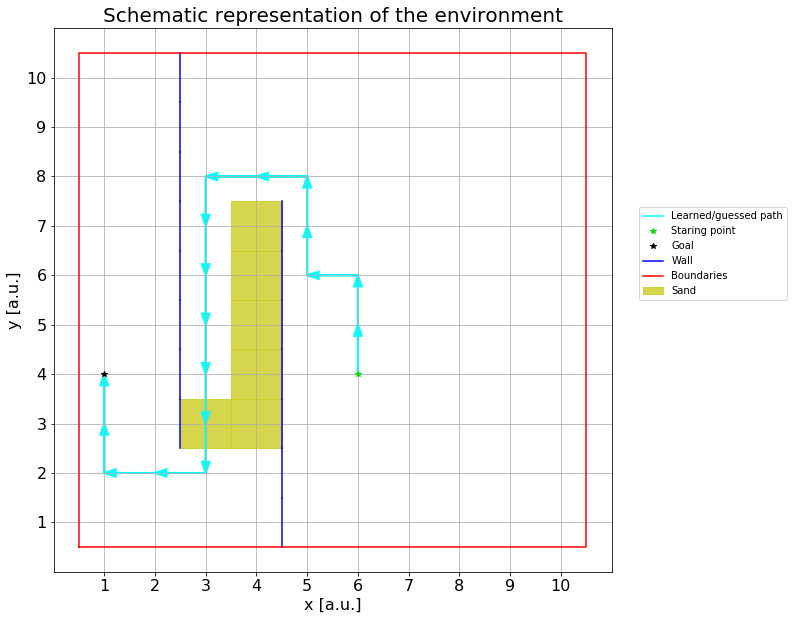

In [19]:
list_states = np.array(list_states)

plt.figure(figsize=(10,10))

# Trick to add legend
plt.plot(list_states.T[0][0:2], list_states.T[1][0:2], '-', color="#00ffff",
         label="Learned/guessed path")# Plotting trajectory as arrows
for p1,p2 in zip(list_states[:-1], list_states[1:]):
    if np.any(p1 != p2):
        dx = p2[0] - p1[0]
        dy = p2[1] - p1[1]
        plt.arrow(p1[0], p1[1], dx, dy, color="#00ffff", shape='full', lw=2, length_includes_head=True, head_width=0.15)

plt.plot(list_states.T[0][0], list_states.T[1][0], '*', color="#00dd00", label="Staring point")
plt.plot(goal[0], goal[1], '*', color="#000000", label="Goal")

# Plotting sand points
cont_sand = 0
for sand_p in sand:
    if cont_sand == 0:
        recta = plt.Rectangle( (sand_p[0]-0.5, sand_p[1]-0.5), 1, 1, color="#cccc22", alpha=0.8, label="Sand")
        plt.gca().add_patch(recta)
    else:
        recta = plt.Rectangle( (sand_p[0]-0.5, sand_p[1]-0.5), 1, 1, color="#cccc22", alpha=0.8)
        plt.gca().add_patch(recta)
    cont_sand += 1
        
cont = 0
for wall in walls:
    plot_wall(wall, cont)
    cont += 1

plt.xlim([-1,10])
plt.ylim([-1,10])

plt.xticks(np.arange(10), np.arange(10)+1, fontsize=16)
plt.yticks(np.arange(10), np.arange(10)+1, fontsize=16)

# Plotting bounaries
plt.plot([-0.5, 9.5, 9.5, -0.5, -0.5], [-0.5, -0.5, 9.5, 9.5, -0.5], color="#ff0000", label="Boundaries")

plt.title("Schematic representation of the environment", fontsize=20)

plt.xlabel("x [a.u.]", fontsize=16)
plt.ylabel("y [a.u.]", fontsize=16)

plt.legend(loc=(1.05,0.5))
plt.grid()

plt.savefig(str(path_img+"/ENV1__walls_sand_SARSA_softmax.png"), bbox_inches='tight')

plt.show()

## Trying with another function for the ε:

### Cut hyperbole

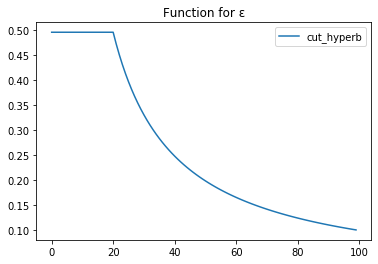

In [20]:
l = 100
plt.plot(cut_hyperb(l), label = "cut_hyperb")

plt.title("Function for ε")

plt.legend()
plt.show()

In [21]:
episodes = 2000         # number of training episodes
episode_length = 50     # maximum episode length
x = 10                  # horizontal size of the box
y = 10                  # vertical size of the box
goal = [0, 3]           # objective point
discount = 0.9          # exponential discount factor
softmax = False         # set to true to use Softmax policy
sarsa = False           # set to true to use the Sarsa algorithm
init_window = [[5,9],[0,4]]   # set [x1,x2],[y1,y2] generation interval for the x,y initial position

# TODO alpha and epsilon profile
alpha = np.ones(episodes) * 0.25
epsilon = cut_hyperb(episodes)

# So the best action gets 1-ε, so 0.2
# 	the others get ε/(N-1)

# initialize the agent
learner = Agent((x * y), 5, discount, max_reward=1, softmax=softmax, sarsa=sarsa)

# Setting walls
walls = [[[1,3],[2,3]], [[1,4],[2,4]], [[1,2],[2,2]], [[1,5],[2,5]], [[1,6],[2,6]], [[1,7],[2,7]], [[1,8],[2,8]],[[1,9],[2,9]],
        [[3,0],[4,0]], [[3,1],[4,1]], [[3,2],[4,2]], [[3,3],[4,3]], [[3,4],[4,4]], [[3,5],[4,5]], [[3,6],[4,6]]]

# Setting sand
sand = [[3,6], [3,5], [2,3], [2,2]]

# perform the training
for index in range(0, episodes):
    # start from a random state
    initial = [np.random.randint(init_window[0][0], init_window[0][1]),
               np.random.randint(init_window[1][0], init_window[1][1])]
    # initialize environment
    state = initial
    
    # list of actions to visualize the track
    list_states = [initial]
    
    env = Environment(x, y, state, goal, walls = walls, sand=sand)
    reward = 0
    # run episode
    for step in range(0, episode_length):
        # find state index (vectorize the state in the matrix?)
        state_index = state[0] * y + state[1]
        # choose an action
        action = learner.select_action(state_index, epsilon[index])
        # the agent moves in the environment
        result = env.move(action)
        
        # Saving the last list of actions
        if (index == episodes-1):
            list_states.append(result[0])
        
        # Q-learning update
        next_index = result[0][0] * y + result[0][1]
        learner.update(state_index, action, result[1], next_index, alpha[index], epsilon[index])
        # update state and reward
        reward += result[1]
        state = result[0]
    # Only to track the average reward
    reward /= episode_length
    print('Episode ', index + 1, ': the agent has obtained an average reward of ', reward, ' starting from position ', initial) 
    
    # periodically save the agent
    if ((index + 1) % 10 == 0):
        with open('agent.obj', 'wb') as agent_file:
            dill.dump(learner, agent_file)

Episode  1 : the agent has obtained an average reward of  -0.04  starting from position  [6, 1]
Episode  2 : the agent has obtained an average reward of  -0.02  starting from position  [6, 3]
Episode  3 : the agent has obtained an average reward of  0.0  starting from position  [5, 2]
Episode  4 : the agent has obtained an average reward of  -0.2  starting from position  [8, 3]
Episode  5 : the agent has obtained an average reward of  -0.04  starting from position  [8, 2]
Episode  6 : the agent has obtained an average reward of  -0.08  starting from position  [8, 0]
Episode  7 : the agent has obtained an average reward of  -0.08  starting from position  [5, 1]
Episode  8 : the agent has obtained an average reward of  -0.02  starting from position  [6, 1]
Episode  9 : the agent has obtained an average reward of  -0.06  starting from position  [6, 0]
Episode  10 : the agent has obtained an average reward of  -0.1  starting from position  [8, 2]
Episode  11 : the agent has obtained an ave

Episode  92 : the agent has obtained an average reward of  -0.04  starting from position  [7, 0]
Episode  93 : the agent has obtained an average reward of  0.0  starting from position  [8, 1]
Episode  94 : the agent has obtained an average reward of  -0.08  starting from position  [6, 3]
Episode  95 : the agent has obtained an average reward of  -0.1  starting from position  [8, 2]
Episode  96 : the agent has obtained an average reward of  -0.02  starting from position  [8, 1]
Episode  97 : the agent has obtained an average reward of  -0.08  starting from position  [8, 2]
Episode  98 : the agent has obtained an average reward of  0.0  starting from position  [5, 1]
Episode  99 : the agent has obtained an average reward of  -0.06  starting from position  [6, 1]
Episode  100 : the agent has obtained an average reward of  -0.04  starting from position  [7, 0]
Episode  101 : the agent has obtained an average reward of  -0.12  starting from position  [5, 3]
Episode  102 : the agent has obta

Episode  182 : the agent has obtained an average reward of  0.0  starting from position  [6, 2]
Episode  183 : the agent has obtained an average reward of  -0.1  starting from position  [8, 1]
Episode  184 : the agent has obtained an average reward of  0.0  starting from position  [8, 1]
Episode  185 : the agent has obtained an average reward of  -0.02  starting from position  [8, 2]
Episode  186 : the agent has obtained an average reward of  -0.1  starting from position  [8, 2]
Episode  187 : the agent has obtained an average reward of  -0.1  starting from position  [5, 0]
Episode  188 : the agent has obtained an average reward of  -0.04059999999999999  starting from position  [8, 1]
Episode  189 : the agent has obtained an average reward of  -0.0202  starting from position  [7, 3]
Episode  190 : the agent has obtained an average reward of  -0.08  starting from position  [8, 2]
Episode  191 : the agent has obtained an average reward of  -0.0021999999999999997  starting from position  

Episode  271 : the agent has obtained an average reward of  -0.12  starting from position  [8, 0]
Episode  272 : the agent has obtained an average reward of  0.0  starting from position  [6, 1]
Episode  273 : the agent has obtained an average reward of  -0.04079999999999998  starting from position  [7, 0]
Episode  274 : the agent has obtained an average reward of  -0.002  starting from position  [5, 2]
Episode  275 : the agent has obtained an average reward of  -0.04  starting from position  [5, 1]
Episode  276 : the agent has obtained an average reward of  -0.04  starting from position  [6, 3]
Episode  277 : the agent has obtained an average reward of  -0.04  starting from position  [5, 2]
Episode  278 : the agent has obtained an average reward of  -0.0004  starting from position  [8, 2]
Episode  279 : the agent has obtained an average reward of  -0.0008  starting from position  [8, 3]
Episode  280 : the agent has obtained an average reward of  -0.0202  starting from position  [6, 0]


Episode  357 : the agent has obtained an average reward of  -0.04  starting from position  [5, 3]
Episode  358 : the agent has obtained an average reward of  -0.040600000000000004  starting from position  [5, 1]
Episode  359 : the agent has obtained an average reward of  -0.021400000000000002  starting from position  [5, 2]
Episode  360 : the agent has obtained an average reward of  -0.04  starting from position  [7, 3]
Episode  361 : the agent has obtained an average reward of  -0.0206  starting from position  [6, 3]
Episode  362 : the agent has obtained an average reward of  -0.06  starting from position  [7, 3]
Episode  363 : the agent has obtained an average reward of  -0.02  starting from position  [8, 3]
Episode  364 : the agent has obtained an average reward of  -0.16  starting from position  [8, 1]
Episode  365 : the agent has obtained an average reward of  -0.0204  starting from position  [6, 2]
Episode  366 : the agent has obtained an average reward of  -0.02  starting from p

Episode  448 : the agent has obtained an average reward of  0.039599999999999996  starting from position  [5, 3]
Episode  449 : the agent has obtained an average reward of  -0.0012000000000000001  starting from position  [7, 1]
Episode  450 : the agent has obtained an average reward of  -0.02  starting from position  [6, 1]
Episode  451 : the agent has obtained an average reward of  -0.0202  starting from position  [8, 2]
Episode  452 : the agent has obtained an average reward of  -0.04  starting from position  [7, 0]
Episode  453 : the agent has obtained an average reward of  -0.06099999999999998  starting from position  [5, 0]
Episode  454 : the agent has obtained an average reward of  -0.021  starting from position  [6, 0]
Episode  455 : the agent has obtained an average reward of  0.0394  starting from position  [7, 2]
Episode  456 : the agent has obtained an average reward of  -0.06  starting from position  [7, 1]
Episode  457 : the agent has obtained an average reward of  0.0796 

Episode  538 : the agent has obtained an average reward of  0.1186  starting from position  [6, 3]
Episode  539 : the agent has obtained an average reward of  0.0794  starting from position  [6, 2]
Episode  540 : the agent has obtained an average reward of  -0.0008000000000000007  starting from position  [6, 2]
Episode  541 : the agent has obtained an average reward of  0.0  starting from position  [6, 2]
Episode  542 : the agent has obtained an average reward of  -0.12  starting from position  [7, 0]
Episode  543 : the agent has obtained an average reward of  -0.02  starting from position  [5, 2]
Episode  544 : the agent has obtained an average reward of  -0.001  starting from position  [7, 3]
Episode  545 : the agent has obtained an average reward of  -0.040600000000000004  starting from position  [7, 3]
Episode  546 : the agent has obtained an average reward of  -0.04039999999999999  starting from position  [7, 2]
Episode  547 : the agent has obtained an average reward of  -0.021  s

Episode  629 : the agent has obtained an average reward of  0.0794  starting from position  [7, 1]
Episode  630 : the agent has obtained an average reward of  -0.0004  starting from position  [7, 2]
Episode  631 : the agent has obtained an average reward of  -0.0818  starting from position  [6, 2]
Episode  632 : the agent has obtained an average reward of  -0.14  starting from position  [8, 0]
Episode  633 : the agent has obtained an average reward of  -0.04  starting from position  [7, 3]
Episode  634 : the agent has obtained an average reward of  -0.0004  starting from position  [6, 0]
Episode  635 : the agent has obtained an average reward of  -0.021  starting from position  [8, 2]
Episode  636 : the agent has obtained an average reward of  -0.04  starting from position  [6, 1]
Episode  637 : the agent has obtained an average reward of  -0.020600000000000004  starting from position  [7, 0]
Episode  638 : the agent has obtained an average reward of  0.19939999999999997  starting from

Episode  718 : the agent has obtained an average reward of  0.1996  starting from position  [5, 2]
Episode  719 : the agent has obtained an average reward of  -0.0004  starting from position  [8, 0]
Episode  720 : the agent has obtained an average reward of  0.0796  starting from position  [6, 0]
Episode  721 : the agent has obtained an average reward of  0.079  starting from position  [8, 1]
Episode  722 : the agent has obtained an average reward of  -0.06  starting from position  [8, 1]
Episode  723 : the agent has obtained an average reward of  0.1396  starting from position  [5, 2]
Episode  724 : the agent has obtained an average reward of  0.21939999999999998  starting from position  [5, 3]
Episode  725 : the agent has obtained an average reward of  0.1396  starting from position  [7, 0]
Episode  726 : the agent has obtained an average reward of  0.11960000000000001  starting from position  [5, 3]
Episode  727 : the agent has obtained an average reward of  0.2396  starting from po

Episode  809 : the agent has obtained an average reward of  0.09960000000000001  starting from position  [8, 3]
Episode  810 : the agent has obtained an average reward of  0.2  starting from position  [5, 2]
Episode  811 : the agent has obtained an average reward of  0.3396  starting from position  [5, 0]
Episode  812 : the agent has obtained an average reward of  0.39879999999999993  starting from position  [5, 2]
Episode  813 : the agent has obtained an average reward of  0.2796  starting from position  [5, 0]
Episode  814 : the agent has obtained an average reward of  0.0596  starting from position  [6, 0]
Episode  815 : the agent has obtained an average reward of  0.11900000000000001  starting from position  [8, 1]
Episode  816 : the agent has obtained an average reward of  0.2596  starting from position  [5, 3]
Episode  817 : the agent has obtained an average reward of  0.0788  starting from position  [8, 2]
Episode  818 : the agent has obtained an average reward of  0.09939999999

Episode  899 : the agent has obtained an average reward of  0.35960000000000003  starting from position  [8, 3]
Episode  900 : the agent has obtained an average reward of  0.09939999999999999  starting from position  [7, 2]
Episode  901 : the agent has obtained an average reward of  0.35960000000000003  starting from position  [5, 3]
Episode  902 : the agent has obtained an average reward of  0.1996  starting from position  [5, 1]
Episode  903 : the agent has obtained an average reward of  0.1996  starting from position  [5, 1]
Episode  904 : the agent has obtained an average reward of  0.29960000000000003  starting from position  [5, 1]
Episode  905 : the agent has obtained an average reward of  0.11960000000000001  starting from position  [6, 2]
Episode  906 : the agent has obtained an average reward of  0.19920000000000002  starting from position  [6, 0]
Episode  907 : the agent has obtained an average reward of  0.3196  starting from position  [6, 2]
Episode  908 : the agent has ob

Episode  987 : the agent has obtained an average reward of  0.3796  starting from position  [6, 3]
Episode  988 : the agent has obtained an average reward of  0.29960000000000003  starting from position  [8, 0]
Episode  989 : the agent has obtained an average reward of  0.29960000000000003  starting from position  [5, 0]
Episode  990 : the agent has obtained an average reward of  0.23939999999999997  starting from position  [6, 1]
Episode  991 : the agent has obtained an average reward of  0.059399999999999994  starting from position  [7, 1]
Episode  992 : the agent has obtained an average reward of  0.3994  starting from position  [7, 1]
Episode  993 : the agent has obtained an average reward of  0.2794  starting from position  [7, 3]
Episode  994 : the agent has obtained an average reward of  0.31980000000000003  starting from position  [5, 1]
Episode  995 : the agent has obtained an average reward of  0.3396  starting from position  [7, 2]
Episode  996 : the agent has obtained an av

Episode  1076 : the agent has obtained an average reward of  0.2396  starting from position  [8, 1]
Episode  1077 : the agent has obtained an average reward of  0.37920000000000004  starting from position  [7, 1]
Episode  1078 : the agent has obtained an average reward of  0.23939999999999997  starting from position  [7, 1]
Episode  1079 : the agent has obtained an average reward of  0.2  starting from position  [6, 2]
Episode  1080 : the agent has obtained an average reward of  0.21960000000000002  starting from position  [8, 3]
Episode  1081 : the agent has obtained an average reward of  0.3996  starting from position  [6, 1]
Episode  1082 : the agent has obtained an average reward of  0.4396  starting from position  [6, 1]
Episode  1083 : the agent has obtained an average reward of  0.2596  starting from position  [5, 1]
Episode  1084 : the agent has obtained an average reward of  0.2596  starting from position  [8, 2]
Episode  1085 : the agent has obtained an average reward of  0.2

Episode  1164 : the agent has obtained an average reward of  0.2396  starting from position  [6, 2]
Episode  1165 : the agent has obtained an average reward of  0.26  starting from position  [7, 1]
Episode  1166 : the agent has obtained an average reward of  0.2596  starting from position  [8, 1]
Episode  1167 : the agent has obtained an average reward of  0.23939999999999997  starting from position  [8, 3]
Episode  1168 : the agent has obtained an average reward of  0.1392  starting from position  [8, 0]
Episode  1169 : the agent has obtained an average reward of  0.3996  starting from position  [6, 2]
Episode  1170 : the agent has obtained an average reward of  0.2396  starting from position  [7, 3]
Episode  1171 : the agent has obtained an average reward of  0.1796  starting from position  [7, 1]
Episode  1172 : the agent has obtained an average reward of  0.3996  starting from position  [5, 2]
Episode  1173 : the agent has obtained an average reward of  0.4396  starting from positi

Episode  1252 : the agent has obtained an average reward of  0.4194  starting from position  [8, 3]
Episode  1253 : the agent has obtained an average reward of  0.35960000000000003  starting from position  [7, 2]
Episode  1254 : the agent has obtained an average reward of  0.3396  starting from position  [7, 3]
Episode  1255 : the agent has obtained an average reward of  0.5796  starting from position  [5, 3]
Episode  1256 : the agent has obtained an average reward of  0.4596  starting from position  [5, 2]
Episode  1257 : the agent has obtained an average reward of  0.3796  starting from position  [6, 0]
Episode  1258 : the agent has obtained an average reward of  0.3394  starting from position  [7, 1]
Episode  1259 : the agent has obtained an average reward of  0.4996  starting from position  [6, 3]
Episode  1260 : the agent has obtained an average reward of  0.41960000000000003  starting from position  [6, 1]
Episode  1261 : the agent has obtained an average reward of  0.4596  start

Episode  1331 : the agent has obtained an average reward of  0.41960000000000003  starting from position  [5, 2]
Episode  1332 : the agent has obtained an average reward of  0.4996  starting from position  [5, 3]
Episode  1333 : the agent has obtained an average reward of  0.21960000000000002  starting from position  [8, 0]
Episode  1334 : the agent has obtained an average reward of  0.5192  starting from position  [5, 2]
Episode  1335 : the agent has obtained an average reward of  0.29960000000000003  starting from position  [7, 3]
Episode  1336 : the agent has obtained an average reward of  0.5396  starting from position  [5, 3]
Episode  1337 : the agent has obtained an average reward of  0.4396  starting from position  [6, 2]
Episode  1338 : the agent has obtained an average reward of  0.41960000000000003  starting from position  [8, 3]
Episode  1339 : the agent has obtained an average reward of  0.3784  starting from position  [6, 1]
Episode  1340 : the agent has obtained an averag

Episode  1418 : the agent has obtained an average reward of  0.3196  starting from position  [7, 1]
Episode  1419 : the agent has obtained an average reward of  0.3996  starting from position  [8, 3]
Episode  1420 : the agent has obtained an average reward of  0.2798  starting from position  [8, 2]
Episode  1421 : the agent has obtained an average reward of  0.36  starting from position  [7, 1]
Episode  1422 : the agent has obtained an average reward of  0.2792  starting from position  [8, 0]
Episode  1423 : the agent has obtained an average reward of  0.2396  starting from position  [6, 2]
Episode  1424 : the agent has obtained an average reward of  0.2396  starting from position  [7, 1]
Episode  1425 : the agent has obtained an average reward of  0.3796  starting from position  [5, 1]
Episode  1426 : the agent has obtained an average reward of  0.35960000000000003  starting from position  [7, 2]
Episode  1427 : the agent has obtained an average reward of  0.3994  starting from positi

Episode  1509 : the agent has obtained an average reward of  0.4596  starting from position  [5, 0]
Episode  1510 : the agent has obtained an average reward of  0.4796  starting from position  [7, 2]
Episode  1511 : the agent has obtained an average reward of  0.4996  starting from position  [5, 2]
Episode  1512 : the agent has obtained an average reward of  0.1394  starting from position  [7, 0]
Episode  1513 : the agent has obtained an average reward of  0.4596  starting from position  [7, 3]
Episode  1514 : the agent has obtained an average reward of  0.3994  starting from position  [5, 1]
Episode  1515 : the agent has obtained an average reward of  0.3996  starting from position  [6, 0]
Episode  1516 : the agent has obtained an average reward of  0.5596  starting from position  [5, 0]
Episode  1517 : the agent has obtained an average reward of  0.41960000000000003  starting from position  [6, 2]
Episode  1518 : the agent has obtained an average reward of  0.4596  starting from posi

Episode  1591 : the agent has obtained an average reward of  0.29960000000000003  starting from position  [5, 0]
Episode  1592 : the agent has obtained an average reward of  0.29960000000000003  starting from position  [6, 0]
Episode  1593 : the agent has obtained an average reward of  0.41960000000000003  starting from position  [6, 1]
Episode  1594 : the agent has obtained an average reward of  0.3594  starting from position  [6, 2]
Episode  1595 : the agent has obtained an average reward of  0.09960000000000001  starting from position  [7, 0]
Episode  1596 : the agent has obtained an average reward of  0.3196  starting from position  [5, 1]
Episode  1597 : the agent has obtained an average reward of  0.3994  starting from position  [7, 2]
Episode  1598 : the agent has obtained an average reward of  0.41960000000000003  starting from position  [8, 1]
Episode  1599 : the agent has obtained an average reward of  0.4396  starting from position  [8, 2]
Episode  1600 : the agent has obtai

Episode  1674 : the agent has obtained an average reward of  0.4396  starting from position  [7, 3]
Episode  1675 : the agent has obtained an average reward of  0.5196000000000001  starting from position  [5, 3]
Episode  1676 : the agent has obtained an average reward of  0.4194  starting from position  [8, 1]
Episode  1677 : the agent has obtained an average reward of  0.3796  starting from position  [7, 1]
Episode  1678 : the agent has obtained an average reward of  0.3996  starting from position  [6, 0]
Episode  1679 : the agent has obtained an average reward of  0.3996  starting from position  [6, 3]
Episode  1680 : the agent has obtained an average reward of  0.5596  starting from position  [7, 2]
Episode  1681 : the agent has obtained an average reward of  0.4396  starting from position  [5, 2]
Episode  1682 : the agent has obtained an average reward of  0.3996  starting from position  [8, 2]
Episode  1683 : the agent has obtained an average reward of  0.3396  starting from posit

Episode  1757 : the agent has obtained an average reward of  0.5196000000000001  starting from position  [5, 1]
Episode  1758 : the agent has obtained an average reward of  0.4796  starting from position  [7, 0]
Episode  1759 : the agent has obtained an average reward of  0.4398  starting from position  [5, 2]
Episode  1760 : the agent has obtained an average reward of  0.5394  starting from position  [7, 3]
Episode  1761 : the agent has obtained an average reward of  0.4596  starting from position  [5, 1]
Episode  1762 : the agent has obtained an average reward of  0.35960000000000003  starting from position  [6, 2]
Episode  1763 : the agent has obtained an average reward of  0.3796  starting from position  [5, 0]
Episode  1764 : the agent has obtained an average reward of  0.37939999999999996  starting from position  [8, 0]
Episode  1765 : the agent has obtained an average reward of  0.3996  starting from position  [6, 2]
Episode  1766 : the agent has obtained an average reward of  0

Episode  1848 : the agent has obtained an average reward of  0.33980000000000005  starting from position  [7, 1]
Episode  1849 : the agent has obtained an average reward of  0.4796  starting from position  [7, 2]
Episode  1850 : the agent has obtained an average reward of  0.35960000000000003  starting from position  [7, 2]
Episode  1851 : the agent has obtained an average reward of  0.4996  starting from position  [8, 1]
Episode  1852 : the agent has obtained an average reward of  0.4396  starting from position  [5, 2]
Episode  1853 : the agent has obtained an average reward of  0.45980000000000004  starting from position  [7, 3]
Episode  1854 : the agent has obtained an average reward of  0.4796  starting from position  [5, 3]
Episode  1855 : the agent has obtained an average reward of  0.41960000000000003  starting from position  [8, 0]
Episode  1856 : the agent has obtained an average reward of  0.5196000000000001  starting from position  [5, 2]
Episode  1857 : the agent has obtain

Episode  1934 : the agent has obtained an average reward of  0.5396  starting from position  [5, 2]
Episode  1935 : the agent has obtained an average reward of  0.5596  starting from position  [7, 3]
Episode  1936 : the agent has obtained an average reward of  0.5396  starting from position  [5, 2]
Episode  1937 : the agent has obtained an average reward of  0.45980000000000004  starting from position  [8, 2]
Episode  1938 : the agent has obtained an average reward of  0.3796  starting from position  [6, 0]
Episode  1939 : the agent has obtained an average reward of  0.5194  starting from position  [6, 1]
Episode  1940 : the agent has obtained an average reward of  0.3996  starting from position  [8, 3]
Episode  1941 : the agent has obtained an average reward of  0.41960000000000003  starting from position  [6, 2]
Episode  1942 : the agent has obtained an average reward of  0.5396  starting from position  [5, 1]
Episode  1943 : the agent has obtained an average reward of  0.3996  start

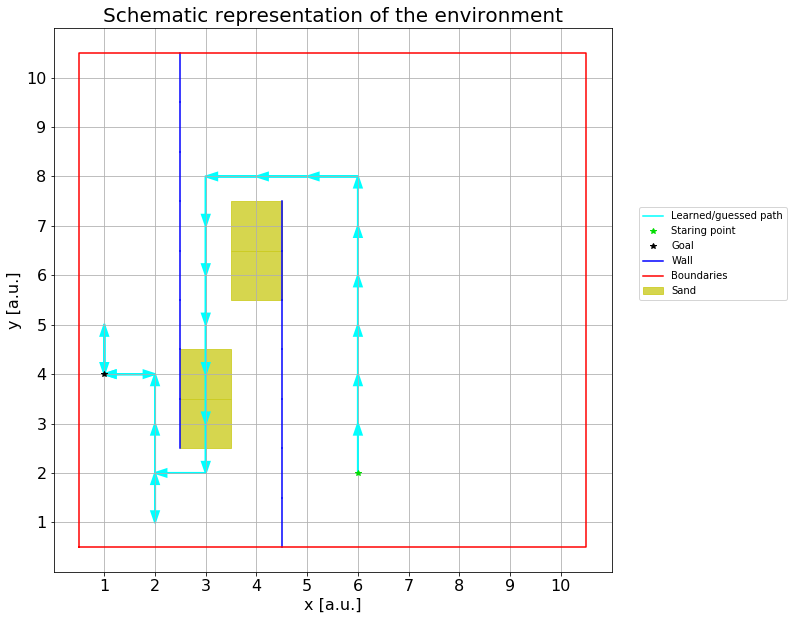

In [22]:
list_states = np.array(list_states)

plt.figure(figsize=(10,10))

# Trick to add legend
plt.plot(list_states.T[0][0:2], list_states.T[1][0:2], '-', color="#00ffff",
         label="Learned/guessed path")# Plotting trajectory as arrows
for p1,p2 in zip(list_states[:-1], list_states[1:]):
    if np.any(p1 != p2):
        dx = p2[0] - p1[0]
        dy = p2[1] - p1[1]
        plt.arrow(p1[0], p1[1], dx, dy, color="#00ffff", shape='full', lw=2, length_includes_head=True, head_width=0.15)

plt.plot(list_states.T[0][0], list_states.T[1][0], '*', color="#00dd00", label="Staring point")
plt.plot(goal[0], goal[1], '*', color="#000000", label="Goal")

# Plotting sand points
cont_sand = 0
for sand_p in sand:
    if cont_sand == 0:
        recta = plt.Rectangle( (sand_p[0]-0.5, sand_p[1]-0.5), 1, 1, color="#cccc22", alpha=0.8, label="Sand")
        plt.gca().add_patch(recta)
    else:
        recta = plt.Rectangle( (sand_p[0]-0.5, sand_p[1]-0.5), 1, 1, color="#cccc22", alpha=0.8)
        plt.gca().add_patch(recta)
    cont_sand += 1
        
cont = 0
for wall in walls:
    plot_wall(wall, cont)
    cont += 1

plt.xlim([-1,10])
plt.ylim([-1,10])

plt.xticks(np.arange(10), np.arange(10)+1, fontsize=16)
plt.yticks(np.arange(10), np.arange(10)+1, fontsize=16)

# Plotting bounaries
plt.plot([-0.5, 9.5, 9.5, -0.5, -0.5], [-0.5, -0.5, 9.5, 9.5, -0.5], color="#ff0000", label="Boundaries")

plt.title("Schematic representation of the environment", fontsize=20)

plt.xlabel("x [a.u.]", fontsize=16)
plt.ylabel("y [a.u.]", fontsize=16)

plt.legend(loc=(1.05,0.5))
plt.grid()

plt.savefig(str(path_img+"/ENV1__walls_sand_cut_hyp.png"), bbox_inches='tight')

plt.show()

## Trying with another function for the ε
###  Staircase

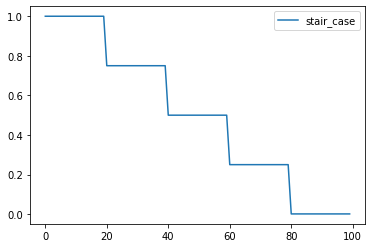

In [25]:
l = 100
plt.plot(stair_case(l), label = "stair_case")
plt.legend()
plt.show()

In [23]:
episodes = 2000         # number of training episodes
episode_length = 50     # maximum episode length
x = 10                  # horizontal size of the box
y = 10                  # vertical size of the box
goal = [0, 3]           # objective point
discount = 0.9          # exponential discount factor
softmax = False         # set to true to use Softmax policy
sarsa = False           # set to true to use the Sarsa algorithm
init_window = [[5,9],[0,4]]   # set [x1,x2],[y1,y2] generation interval for the x,y initial position

# TODO alpha and epsilon profile
alpha = np.ones(episodes) * 0.25
epsilon = stair_case(episodes)

# So the best action gets 1-ε, so 0.2
# 	the others get ε/(N-1)

# initialize the agent
learner = Agent((x * y), 5, discount, max_reward=1, softmax=softmax, sarsa=sarsa)

# Setting walls
walls = [[[1,3],[2,3]], [[1,4],[2,4]], [[1,2],[2,2]], [[1,5],[2,5]], [[1,6],[2,6]], [[1,7],[2,7]], [[1,8],[2,8]],[[1,9],[2,9]],
        [[3,0],[4,0]], [[3,1],[4,1]], [[3,2],[4,2]], [[3,3],[4,3]], [[3,4],[4,4]], [[3,5],[4,5]], [[3,6],[4,6]]]

# Setting sand
sand = [[3,6], [3,5], [2,3], [2,2]]

# perform the training
for index in range(0, episodes):
    # start from a random state
    initial = [np.random.randint(init_window[0][0], init_window[0][1]),
               np.random.randint(init_window[1][0], init_window[1][1])]
    # initialize environment
    state = initial
    
    # list of actions to visualize the track
    list_states = [initial]
    
    env = Environment(x, y, state, goal, walls = walls, sand=sand)
    reward = 0
    # run episode
    for step in range(0, episode_length):
        # find state index (vectorize the state in the matrix?)
        state_index = state[0] * y + state[1]
        # choose an action
        action = learner.select_action(state_index, epsilon[index])
        # the agent moves in the environment
        result = env.move(action)
        
        # Saving the last list of actions
        if (index == episodes-1):
            list_states.append(result[0])
        
        # Q-learning update
        next_index = result[0][0] * y + result[0][1]
        learner.update(state_index, action, result[1], next_index, alpha[index], epsilon[index])
        # update state and reward
        reward += result[1]
        state = result[0]
    # Only to track the average reward
    reward /= episode_length
    print('Episode ', index + 1, ': the agent has obtained an average reward of ', reward, ' starting from position ', initial) 
    
    # periodically save the agent
    if ((index + 1) % 10 == 0):
        with open('agent.obj', 'wb') as agent_file:
            dill.dump(learner, agent_file)

Episode  1 : the agent has obtained an average reward of  0.0  starting from position  [7, 2]
Episode  2 : the agent has obtained an average reward of  -0.24  starting from position  [8, 2]
Episode  3 : the agent has obtained an average reward of  -0.06  starting from position  [5, 2]
Episode  4 : the agent has obtained an average reward of  0.0  starting from position  [7, 1]
Episode  5 : the agent has obtained an average reward of  0.0  starting from position  [5, 2]
Episode  6 : the agent has obtained an average reward of  -0.2  starting from position  [5, 0]
Episode  7 : the agent has obtained an average reward of  -0.16  starting from position  [5, 3]
Episode  8 : the agent has obtained an average reward of  -0.06  starting from position  [7, 2]
Episode  9 : the agent has obtained an average reward of  -0.0006  starting from position  [7, 3]
Episode  10 : the agent has obtained an average reward of  -0.1  starting from position  [6, 1]
Episode  11 : the agent has obtained an avera

Episode  95 : the agent has obtained an average reward of  -0.12  starting from position  [8, 1]
Episode  96 : the agent has obtained an average reward of  -0.08  starting from position  [6, 2]
Episode  97 : the agent has obtained an average reward of  0.0  starting from position  [5, 1]
Episode  98 : the agent has obtained an average reward of  -0.16  starting from position  [7, 2]
Episode  99 : the agent has obtained an average reward of  -0.2  starting from position  [8, 1]
Episode  100 : the agent has obtained an average reward of  -0.1  starting from position  [7, 3]
Episode  101 : the agent has obtained an average reward of  -0.12  starting from position  [6, 1]
Episode  102 : the agent has obtained an average reward of  -0.04  starting from position  [6, 1]
Episode  103 : the agent has obtained an average reward of  -0.24  starting from position  [6, 2]
Episode  104 : the agent has obtained an average reward of  -0.08  starting from position  [8, 3]
Episode  105 : the agent has 

Episode  189 : the agent has obtained an average reward of  -0.04  starting from position  [5, 2]
Episode  190 : the agent has obtained an average reward of  -0.08  starting from position  [8, 3]
Episode  191 : the agent has obtained an average reward of  -0.06  starting from position  [8, 2]
Episode  192 : the agent has obtained an average reward of  -0.04  starting from position  [5, 1]
Episode  193 : the agent has obtained an average reward of  -0.08  starting from position  [7, 0]
Episode  194 : the agent has obtained an average reward of  -0.2  starting from position  [8, 2]
Episode  195 : the agent has obtained an average reward of  -0.12  starting from position  [5, 2]
Episode  196 : the agent has obtained an average reward of  -0.02  starting from position  [7, 0]
Episode  197 : the agent has obtained an average reward of  -0.12  starting from position  [8, 1]
Episode  198 : the agent has obtained an average reward of  -0.12  starting from position  [8, 0]
Episode  199 : the ag

Episode  283 : the agent has obtained an average reward of  -0.12  starting from position  [5, 2]
Episode  284 : the agent has obtained an average reward of  -0.02  starting from position  [6, 1]
Episode  285 : the agent has obtained an average reward of  -0.08  starting from position  [6, 3]
Episode  286 : the agent has obtained an average reward of  -0.04  starting from position  [7, 0]
Episode  287 : the agent has obtained an average reward of  -0.22  starting from position  [6, 1]
Episode  288 : the agent has obtained an average reward of  0.0  starting from position  [5, 2]
Episode  289 : the agent has obtained an average reward of  -0.06  starting from position  [8, 0]
Episode  290 : the agent has obtained an average reward of  -0.04  starting from position  [8, 2]
Episode  291 : the agent has obtained an average reward of  -0.022000000000000002  starting from position  [6, 1]
Episode  292 : the agent has obtained an average reward of  -0.16  starting from position  [8, 3]
Episod

Episode  377 : the agent has obtained an average reward of  -0.02  starting from position  [5, 2]
Episode  378 : the agent has obtained an average reward of  -0.04  starting from position  [7, 0]
Episode  379 : the agent has obtained an average reward of  -0.08  starting from position  [8, 2]
Episode  380 : the agent has obtained an average reward of  -0.06  starting from position  [8, 0]
Episode  381 : the agent has obtained an average reward of  -0.2  starting from position  [7, 2]
Episode  382 : the agent has obtained an average reward of  -0.12  starting from position  [8, 0]
Episode  383 : the agent has obtained an average reward of  -0.04  starting from position  [7, 1]
Episode  384 : the agent has obtained an average reward of  -0.1  starting from position  [6, 3]
Episode  385 : the agent has obtained an average reward of  -0.06  starting from position  [8, 1]
Episode  386 : the agent has obtained an average reward of  0.0  starting from position  [5, 0]
Episode  387 : the agent

Episode  467 : the agent has obtained an average reward of  -0.14  starting from position  [7, 0]
Episode  468 : the agent has obtained an average reward of  -0.04  starting from position  [6, 1]
Episode  469 : the agent has obtained an average reward of  -0.02  starting from position  [8, 3]
Episode  470 : the agent has obtained an average reward of  -0.02  starting from position  [6, 2]
Episode  471 : the agent has obtained an average reward of  0.0  starting from position  [6, 0]
Episode  472 : the agent has obtained an average reward of  -0.02  starting from position  [5, 0]
Episode  473 : the agent has obtained an average reward of  -0.06  starting from position  [7, 0]
Episode  474 : the agent has obtained an average reward of  -0.06  starting from position  [7, 1]
Episode  475 : the agent has obtained an average reward of  -0.001  starting from position  [5, 0]
Episode  476 : the agent has obtained an average reward of  -0.04  starting from position  [5, 3]
Episode  477 : the ag

Episode  561 : the agent has obtained an average reward of  0.0  starting from position  [7, 3]
Episode  562 : the agent has obtained an average reward of  -0.08  starting from position  [8, 2]
Episode  563 : the agent has obtained an average reward of  -0.16  starting from position  [8, 2]
Episode  564 : the agent has obtained an average reward of  -0.08  starting from position  [5, 2]
Episode  565 : the agent has obtained an average reward of  -0.06  starting from position  [5, 2]
Episode  566 : the agent has obtained an average reward of  0.0  starting from position  [7, 1]
Episode  567 : the agent has obtained an average reward of  0.0  starting from position  [7, 1]
Episode  568 : the agent has obtained an average reward of  -0.14  starting from position  [8, 2]
Episode  569 : the agent has obtained an average reward of  -0.12  starting from position  [5, 0]
Episode  570 : the agent has obtained an average reward of  -0.04  starting from position  [8, 1]
Episode  571 : the agent h

Episode  653 : the agent has obtained an average reward of  -0.08  starting from position  [6, 2]
Episode  654 : the agent has obtained an average reward of  -0.04  starting from position  [8, 3]
Episode  655 : the agent has obtained an average reward of  0.0  starting from position  [6, 0]
Episode  656 : the agent has obtained an average reward of  0.0  starting from position  [5, 0]
Episode  657 : the agent has obtained an average reward of  -0.12  starting from position  [5, 2]
Episode  658 : the agent has obtained an average reward of  -0.08  starting from position  [6, 0]
Episode  659 : the agent has obtained an average reward of  0.0  starting from position  [7, 3]
Episode  660 : the agent has obtained an average reward of  -0.16  starting from position  [8, 0]
Episode  661 : the agent has obtained an average reward of  -0.0202  starting from position  [6, 3]
Episode  662 : the agent has obtained an average reward of  -0.1  starting from position  [5, 1]
Episode  663 : the agent 

Episode  744 : the agent has obtained an average reward of  -0.0002  starting from position  [7, 3]
Episode  745 : the agent has obtained an average reward of  -0.04  starting from position  [5, 1]
Episode  746 : the agent has obtained an average reward of  -0.1  starting from position  [6, 1]
Episode  747 : the agent has obtained an average reward of  -0.1  starting from position  [5, 1]
Episode  748 : the agent has obtained an average reward of  0.0  starting from position  [5, 1]
Episode  749 : the agent has obtained an average reward of  0.0  starting from position  [7, 0]
Episode  750 : the agent has obtained an average reward of  0.0  starting from position  [6, 3]
Episode  751 : the agent has obtained an average reward of  0.0  starting from position  [6, 3]
Episode  752 : the agent has obtained an average reward of  -0.06  starting from position  [7, 3]
Episode  753 : the agent has obtained an average reward of  0.0  starting from position  [6, 1]
Episode  754 : the agent has o

Episode  835 : the agent has obtained an average reward of  -0.0226  starting from position  [5, 2]
Episode  836 : the agent has obtained an average reward of  -0.0202  starting from position  [6, 3]
Episode  837 : the agent has obtained an average reward of  -0.1  starting from position  [8, 1]
Episode  838 : the agent has obtained an average reward of  -0.0206  starting from position  [5, 3]
Episode  839 : the agent has obtained an average reward of  -0.0004  starting from position  [7, 3]
Episode  840 : the agent has obtained an average reward of  -0.021400000000000002  starting from position  [6, 3]
Episode  841 : the agent has obtained an average reward of  -0.02  starting from position  [5, 0]
Episode  842 : the agent has obtained an average reward of  -0.0014000000000000002  starting from position  [7, 1]
Episode  843 : the agent has obtained an average reward of  -0.001  starting from position  [6, 1]
Episode  844 : the agent has obtained an average reward of  -0.0206  starting

Episode  916 : the agent has obtained an average reward of  0.0  starting from position  [6, 2]
Episode  917 : the agent has obtained an average reward of  -0.04  starting from position  [6, 2]
Episode  918 : the agent has obtained an average reward of  0.0  starting from position  [6, 2]
Episode  919 : the agent has obtained an average reward of  -0.0204  starting from position  [5, 0]
Episode  920 : the agent has obtained an average reward of  -0.0202  starting from position  [7, 2]
Episode  921 : the agent has obtained an average reward of  -0.06  starting from position  [5, 0]
Episode  922 : the agent has obtained an average reward of  -0.08  starting from position  [8, 2]
Episode  923 : the agent has obtained an average reward of  -0.06  starting from position  [8, 3]
Episode  924 : the agent has obtained an average reward of  -0.040600000000000004  starting from position  [5, 3]
Episode  925 : the agent has obtained an average reward of  -0.08  starting from position  [6, 3]
Epis

Episode  1007 : the agent has obtained an average reward of  0.019799999999999998  starting from position  [7, 2]
Episode  1008 : the agent has obtained an average reward of  -0.06  starting from position  [8, 3]
Episode  1009 : the agent has obtained an average reward of  -0.0012000000000000001  starting from position  [5, 0]
Episode  1010 : the agent has obtained an average reward of  -0.0016  starting from position  [6, 1]
Episode  1011 : the agent has obtained an average reward of  -0.06059999999999999  starting from position  [5, 1]
Episode  1012 : the agent has obtained an average reward of  0.0  starting from position  [7, 1]
Episode  1013 : the agent has obtained an average reward of  -0.08079999999999998  starting from position  [7, 0]
Episode  1014 : the agent has obtained an average reward of  -0.0008  starting from position  [5, 3]
Episode  1015 : the agent has obtained an average reward of  -0.0202  starting from position  [8, 2]
Episode  1016 : the agent has obtained an a

Episode  1098 : the agent has obtained an average reward of  -0.0608  starting from position  [6, 1]
Episode  1099 : the agent has obtained an average reward of  -0.0204  starting from position  [6, 1]
Episode  1100 : the agent has obtained an average reward of  -0.02  starting from position  [6, 0]
Episode  1101 : the agent has obtained an average reward of  -0.0004  starting from position  [6, 3]
Episode  1102 : the agent has obtained an average reward of  -0.0021999999999999997  starting from position  [8, 1]
Episode  1103 : the agent has obtained an average reward of  -0.021400000000000002  starting from position  [5, 3]
Episode  1104 : the agent has obtained an average reward of  -0.021400000000000006  starting from position  [5, 2]
Episode  1105 : the agent has obtained an average reward of  -0.001  starting from position  [5, 0]
Episode  1106 : the agent has obtained an average reward of  -0.00040000000000000034  starting from position  [5, 2]
Episode  1107 : the agent has obtai

Episode  1188 : the agent has obtained an average reward of  -0.0014000000000000002  starting from position  [8, 3]
Episode  1189 : the agent has obtained an average reward of  -0.02  starting from position  [7, 0]
Episode  1190 : the agent has obtained an average reward of  0.0592  starting from position  [7, 1]
Episode  1191 : the agent has obtained an average reward of  -0.02  starting from position  [6, 2]
Episode  1192 : the agent has obtained an average reward of  -0.0008  starting from position  [6, 2]
Episode  1193 : the agent has obtained an average reward of  0.0  starting from position  [7, 2]
Episode  1194 : the agent has obtained an average reward of  -0.1  starting from position  [7, 0]
Episode  1195 : the agent has obtained an average reward of  -0.06060000000000001  starting from position  [5, 3]
Episode  1196 : the agent has obtained an average reward of  -0.06  starting from position  [7, 1]
Episode  1197 : the agent has obtained an average reward of  0.0  starting fr

Episode  1277 : the agent has obtained an average reward of  0.11960000000000001  starting from position  [6, 2]
Episode  1278 : the agent has obtained an average reward of  0.1996  starting from position  [6, 3]
Episode  1279 : the agent has obtained an average reward of  0.039599999999999996  starting from position  [6, 0]
Episode  1280 : the agent has obtained an average reward of  0.3796  starting from position  [5, 3]
Episode  1281 : the agent has obtained an average reward of  0.11960000000000001  starting from position  [8, 3]
Episode  1282 : the agent has obtained an average reward of  0.2596  starting from position  [6, 3]
Episode  1283 : the agent has obtained an average reward of  0.2396  starting from position  [7, 3]
Episode  1284 : the agent has obtained an average reward of  -0.0204  starting from position  [5, 1]
Episode  1285 : the agent has obtained an average reward of  -0.001200000000000001  starting from position  [7, 2]
Episode  1286 : the agent has obtained an av

Episode  1365 : the agent has obtained an average reward of  0.2992  starting from position  [5, 3]
Episode  1366 : the agent has obtained an average reward of  0.2796  starting from position  [6, 2]
Episode  1367 : the agent has obtained an average reward of  0.079  starting from position  [5, 2]
Episode  1368 : the agent has obtained an average reward of  0.0596  starting from position  [8, 2]
Episode  1369 : the agent has obtained an average reward of  0.1996  starting from position  [5, 3]
Episode  1370 : the agent has obtained an average reward of  0.35960000000000003  starting from position  [8, 0]
Episode  1371 : the agent has obtained an average reward of  0.1998  starting from position  [6, 2]
Episode  1372 : the agent has obtained an average reward of  0.28  starting from position  [7, 3]
Episode  1373 : the agent has obtained an average reward of  0.09960000000000001  starting from position  [8, 1]
Episode  1374 : the agent has obtained an average reward of  0.3394  starting

Episode  1453 : the agent has obtained an average reward of  0.1796  starting from position  [8, 1]
Episode  1454 : the agent has obtained an average reward of  0.2596  starting from position  [5, 1]
Episode  1455 : the agent has obtained an average reward of  0.07980000000000001  starting from position  [7, 1]
Episode  1456 : the agent has obtained an average reward of  0.09960000000000001  starting from position  [8, 1]
Episode  1457 : the agent has obtained an average reward of  0.239  starting from position  [8, 3]
Episode  1458 : the agent has obtained an average reward of  0.0794  starting from position  [5, 0]
Episode  1459 : the agent has obtained an average reward of  0.1996  starting from position  [5, 0]
Episode  1460 : the agent has obtained an average reward of  -0.04039999999999999  starting from position  [7, 2]
Episode  1461 : the agent has obtained an average reward of  0.1796  starting from position  [6, 2]
Episode  1462 : the agent has obtained an average reward of  

Episode  1531 : the agent has obtained an average reward of  0.1996  starting from position  [8, 3]
Episode  1532 : the agent has obtained an average reward of  0.09939999999999999  starting from position  [8, 1]
Episode  1533 : the agent has obtained an average reward of  0.1398  starting from position  [7, 2]
Episode  1534 : the agent has obtained an average reward of  -0.0604  starting from position  [5, 0]
Episode  1535 : the agent has obtained an average reward of  0.15960000000000002  starting from position  [8, 0]
Episode  1536 : the agent has obtained an average reward of  0.2396  starting from position  [6, 2]
Episode  1537 : the agent has obtained an average reward of  0.37920000000000004  starting from position  [5, 2]
Episode  1538 : the agent has obtained an average reward of  0.2794  starting from position  [8, 0]
Episode  1539 : the agent has obtained an average reward of  0.1396  starting from position  [8, 2]
Episode  1540 : the agent has obtained an average reward of 

Episode  1619 : the agent has obtained an average reward of  0.5996  starting from position  [7, 2]
Episode  1620 : the agent has obtained an average reward of  0.6196  starting from position  [5, 1]
Episode  1621 : the agent has obtained an average reward of  0.5796  starting from position  [7, 1]
Episode  1622 : the agent has obtained an average reward of  0.6396000000000001  starting from position  [6, 3]
Episode  1623 : the agent has obtained an average reward of  0.5996  starting from position  [8, 3]
Episode  1624 : the agent has obtained an average reward of  0.6396000000000001  starting from position  [6, 3]
Episode  1625 : the agent has obtained an average reward of  0.5996  starting from position  [5, 0]
Episode  1626 : the agent has obtained an average reward of  0.5796  starting from position  [6, 1]
Episode  1627 : the agent has obtained an average reward of  0.5796  starting from position  [6, 0]
Episode  1628 : the agent has obtained an average reward of  0.5796  startin

Episode  1704 : the agent has obtained an average reward of  0.6196  starting from position  [6, 2]
Episode  1705 : the agent has obtained an average reward of  0.6196  starting from position  [5, 3]
Episode  1706 : the agent has obtained an average reward of  0.6196  starting from position  [5, 1]
Episode  1707 : the agent has obtained an average reward of  0.5796  starting from position  [6, 0]
Episode  1708 : the agent has obtained an average reward of  0.6196  starting from position  [6, 2]
Episode  1709 : the agent has obtained an average reward of  0.5996  starting from position  [6, 1]
Episode  1710 : the agent has obtained an average reward of  0.6396000000000001  starting from position  [6, 3]
Episode  1711 : the agent has obtained an average reward of  0.6196  starting from position  [5, 1]
Episode  1712 : the agent has obtained an average reward of  0.5796  starting from position  [6, 0]
Episode  1713 : the agent has obtained an average reward of  0.5996  starting from posit

Episode  1796 : the agent has obtained an average reward of  0.5996  starting from position  [7, 2]
Episode  1797 : the agent has obtained an average reward of  0.5396  starting from position  [8, 0]
Episode  1798 : the agent has obtained an average reward of  0.5596  starting from position  [8, 1]
Episode  1799 : the agent has obtained an average reward of  0.6596000000000001  starting from position  [5, 3]
Episode  1800 : the agent has obtained an average reward of  0.5396  starting from position  [8, 0]
Episode  1801 : the agent has obtained an average reward of  0.6596000000000001  starting from position  [5, 3]
Episode  1802 : the agent has obtained an average reward of  0.6596000000000001  starting from position  [5, 3]
Episode  1803 : the agent has obtained an average reward of  0.5594  starting from position  [7, 2]
Episode  1804 : the agent has obtained an average reward of  0.6396000000000001  starting from position  [6, 3]
Episode  1805 : the agent has obtained an average re

Episode  1882 : the agent has obtained an average reward of  0.5596  starting from position  [8, 1]
Episode  1883 : the agent has obtained an average reward of  0.5596  starting from position  [7, 0]
Episode  1884 : the agent has obtained an average reward of  0.6196  starting from position  [6, 2]
Episode  1885 : the agent has obtained an average reward of  0.5996  starting from position  [7, 2]
Episode  1886 : the agent has obtained an average reward of  0.6596000000000001  starting from position  [5, 3]
Episode  1887 : the agent has obtained an average reward of  0.6396000000000001  starting from position  [5, 2]
Episode  1888 : the agent has obtained an average reward of  0.5396  starting from position  [8, 0]
Episode  1889 : the agent has obtained an average reward of  0.5596  starting from position  [8, 1]
Episode  1890 : the agent has obtained an average reward of  0.6196  starting from position  [7, 3]
Episode  1891 : the agent has obtained an average reward of  0.6396000000000

Episode  1962 : the agent has obtained an average reward of  0.6596000000000001  starting from position  [5, 3]
Episode  1963 : the agent has obtained an average reward of  0.5996  starting from position  [7, 2]
Episode  1964 : the agent has obtained an average reward of  0.5796  starting from position  [8, 2]
Episode  1965 : the agent has obtained an average reward of  0.5996  starting from position  [7, 2]
Episode  1966 : the agent has obtained an average reward of  0.5996  starting from position  [5, 0]
Episode  1967 : the agent has obtained an average reward of  0.5996  starting from position  [5, 0]
Episode  1968 : the agent has obtained an average reward of  0.5796  starting from position  [6, 0]
Episode  1969 : the agent has obtained an average reward of  0.5996  starting from position  [7, 2]
Episode  1970 : the agent has obtained an average reward of  0.6196  starting from position  [7, 3]
Episode  1971 : the agent has obtained an average reward of  0.5996  starting from posit

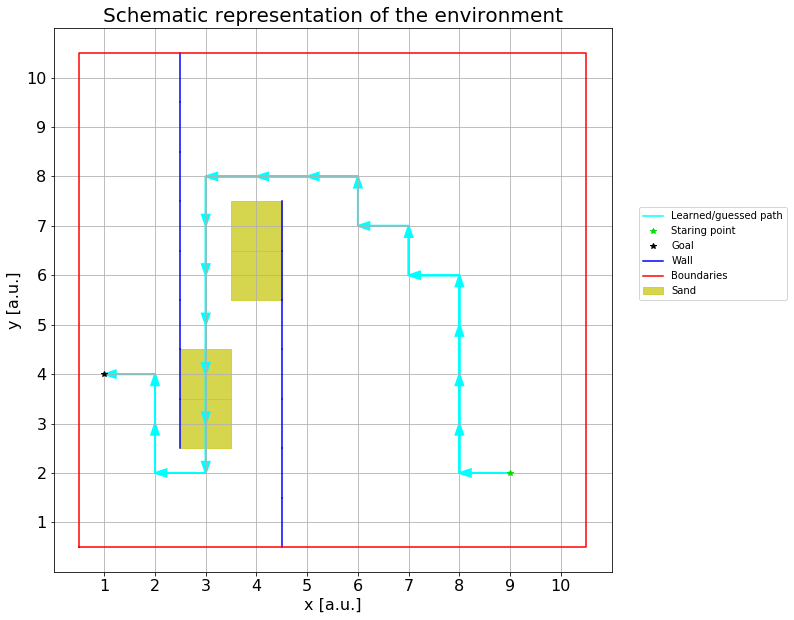

In [24]:
list_states = np.array(list_states)

plt.figure(figsize=(10,10))

# Trick to add legend
plt.plot(list_states.T[0][0:2], list_states.T[1][0:2], '-', color="#00ffff",
         label="Learned/guessed path")# Plotting trajectory as arrows
for p1,p2 in zip(list_states[:-1], list_states[1:]):
    if np.any(p1 != p2):
        dx = p2[0] - p1[0]
        dy = p2[1] - p1[1]
        plt.arrow(p1[0], p1[1], dx, dy, color="#00ffff", shape='full', lw=2, length_includes_head=True, head_width=0.15)

plt.plot(list_states.T[0][0], list_states.T[1][0], '*', color="#00dd00", label="Staring point")
plt.plot(goal[0], goal[1], '*', color="#000000", label="Goal")

# Plotting sand points
cont_sand = 0
for sand_p in sand:
    if cont_sand == 0:
        recta = plt.Rectangle( (sand_p[0]-0.5, sand_p[1]-0.5), 1, 1, color="#cccc22", alpha=0.8, label="Sand")
        plt.gca().add_patch(recta)
    else:
        recta = plt.Rectangle( (sand_p[0]-0.5, sand_p[1]-0.5), 1, 1, color="#cccc22", alpha=0.8)
        plt.gca().add_patch(recta)
    cont_sand += 1
        
cont = 0
for wall in walls:
    plot_wall(wall, cont)
    cont += 1

plt.xlim([-1,10])
plt.ylim([-1,10])

plt.xticks(np.arange(10), np.arange(10)+1, fontsize=16)
plt.yticks(np.arange(10), np.arange(10)+1, fontsize=16)

# Plotting bounaries
plt.plot([-0.5, 9.5, 9.5, -0.5, -0.5], [-0.5, -0.5, 9.5, 9.5, -0.5], color="#ff0000", label="Boundaries")

plt.title("Schematic representation of the environment", fontsize=20)

plt.xlabel("x [a.u.]", fontsize=16)
plt.ylabel("y [a.u.]", fontsize=16)

plt.legend(loc=(1.05,0.5))
plt.grid()

plt.savefig(str(path_img+"/ENV1__walls_sand_staircase.png"), bbox_inches='tight')

plt.show()

## Trying with a more complicated environment: adding more sand more times

In [11]:
episodes = 2000         # number of training episodes
episode_length = 50     # maximum episode length
x = 10                  # horizontal size of the box
y = 10                  # vertical size of the box
goal = [0, 3]           # objective point
discount = 0.9          # exponential discount factor
softmax = False         # set to true to use Softmax policy
sarsa = False           # set to true to use the Sarsa algorithm
init_window = [[9,10],[9,10]]   # set [x1,x2],[y1,y2] generation interval for the x,y initial position

# TODO alpha and epsilon profile
alpha = np.ones(episodes) * 0.25
epsilon = np.linspace(0.8, 0.001,episodes)

# So the best action gets 1-ε, so 0.2
# 	the others get ε/(N-1)

# initialize the agent
learner = Agent((x * y), 5, discount, max_reward=1, softmax=softmax, sarsa=sarsa)

# Setting walls
walls = [[[8,9],[8,8]], [[7,9],[7,8]], [[6,9],[6,8]], [[5,9],[5,8]], [[4,9],[4,8]], [[3,9],[3,8]],
         [[9,8],[8,8]], [[9,7],[8,7]], [[9,6],[8,6]], [[9,5],[8,5]], [[9,4],[8,4]], [[9,3],[8,3]],
         [[6,8],[6,7]], [[5,8],[5,7]], [[4,8],[4,7]], [[3,8],[3,7]], [[2,8],[2,7]], [[1,8],[1,7]], [[0,8],[0,7]],
         [[8,6],[7,6]], [[8,5],[7,5]], [[8,4],[7,4]], [[8,3],[7,3]], [[8,2],[7,2]], [[8,1],[7,1]], [[8,0],[7,0]]]

# Setting sand
sand = [[0,8], [1,8], [2,8], [3,8], [4,8], [5,8], [6,8]]
#, [7,5], [6,5], [3,3], [3,4], [3,5], [3,6], [3,7],
#        [4,3], [4,4], [4,5], [4,6], [4,7], [2,3], [1,3]]

# perform the training
for index in range(0, episodes):
    # start from a random state
    initial = [np.random.randint(init_window[0][0], init_window[0][1]),
               np.random.randint(init_window[1][0], init_window[1][1])]
    # initialize environment
    state = initial
    
    # list of actions to visualize the track
    list_states = [initial]
    
    env = Environment(x, y, state, goal, walls = walls, sand=sand)
    reward = 0
    # run episode
    for step in range(0, episode_length):
        # find state index (vectorize the state in the matrix?)
        state_index = state[0] * y + state[1]
        # choose an action
        action = learner.select_action(state_index, epsilon[index])
        # the agent moves in the environment
        result = env.move(action)
        
        # Saving the last list of actions
        if (index == episodes-1):
            list_states.append(result[0])
        
        # Q-learning update
        next_index = result[0][0] * y + result[0][1]
        learner.update(state_index, action, result[1], next_index, alpha[index], epsilon[index])
        # update state and reward
        reward += result[1]
        state = result[0]
    # Only to track the average reward
    reward /= episode_length
    print('Episode ', index + 1, ': the agent has obtained an average reward of ', reward, ' starting from position ', initial) 
    
    # periodically save the agent
    if ((index + 1) % 10 == 0):
        with open('agent.obj', 'wb') as agent_file:
            dill.dump(learner, agent_file)

Episode  1 : the agent has obtained an average reward of  -0.22  starting from position  [9, 9]
Episode  2 : the agent has obtained an average reward of  -0.2  starting from position  [9, 9]
Episode  3 : the agent has obtained an average reward of  -0.26  starting from position  [9, 9]
Episode  4 : the agent has obtained an average reward of  -0.36  starting from position  [9, 9]
Episode  5 : the agent has obtained an average reward of  -0.2  starting from position  [9, 9]
Episode  6 : the agent has obtained an average reward of  -0.14  starting from position  [9, 9]
Episode  7 : the agent has obtained an average reward of  -0.18  starting from position  [9, 9]
Episode  8 : the agent has obtained an average reward of  -0.28  starting from position  [9, 9]
Episode  9 : the agent has obtained an average reward of  -0.22039999999999998  starting from position  [9, 9]
Episode  10 : the agent has obtained an average reward of  -0.18  starting from position  [9, 9]
Episode  11 : the agent ha

Episode  90 : the agent has obtained an average reward of  -0.2  starting from position  [9, 9]
Episode  91 : the agent has obtained an average reward of  -0.2  starting from position  [9, 9]
Episode  92 : the agent has obtained an average reward of  -0.26  starting from position  [9, 9]
Episode  93 : the agent has obtained an average reward of  -0.28  starting from position  [9, 9]
Episode  94 : the agent has obtained an average reward of  -0.2  starting from position  [9, 9]
Episode  95 : the agent has obtained an average reward of  -0.2  starting from position  [9, 9]
Episode  96 : the agent has obtained an average reward of  -0.3  starting from position  [9, 9]
Episode  97 : the agent has obtained an average reward of  -0.16  starting from position  [9, 9]
Episode  98 : the agent has obtained an average reward of  -0.22  starting from position  [9, 9]
Episode  99 : the agent has obtained an average reward of  -0.28  starting from position  [9, 9]
Episode  100 : the agent has obtain

Episode  181 : the agent has obtained an average reward of  -0.28  starting from position  [9, 9]
Episode  182 : the agent has obtained an average reward of  -0.06199999999999996  starting from position  [9, 9]
Episode  183 : the agent has obtained an average reward of  -0.16239999999999996  starting from position  [9, 9]
Episode  184 : the agent has obtained an average reward of  -0.22  starting from position  [9, 9]
Episode  185 : the agent has obtained an average reward of  -0.26  starting from position  [9, 9]
Episode  186 : the agent has obtained an average reward of  -0.26  starting from position  [9, 9]
Episode  187 : the agent has obtained an average reward of  -0.2208  starting from position  [9, 9]
Episode  188 : the agent has obtained an average reward of  -0.2002  starting from position  [9, 9]
Episode  189 : the agent has obtained an average reward of  -0.12319999999999993  starting from position  [9, 9]
Episode  190 : the agent has obtained an average reward of  -0.24  st

Episode  268 : the agent has obtained an average reward of  -0.18199999999999997  starting from position  [9, 9]
Episode  269 : the agent has obtained an average reward of  -0.16239999999999996  starting from position  [9, 9]
Episode  270 : the agent has obtained an average reward of  -0.2  starting from position  [9, 9]
Episode  271 : the agent has obtained an average reward of  -0.10359999999999993  starting from position  [9, 9]
Episode  272 : the agent has obtained an average reward of  -0.08  starting from position  [9, 9]
Episode  273 : the agent has obtained an average reward of  -0.08  starting from position  [9, 9]
Episode  274 : the agent has obtained an average reward of  -0.2802  starting from position  [9, 9]
Episode  275 : the agent has obtained an average reward of  -0.2  starting from position  [9, 9]
Episode  276 : the agent has obtained an average reward of  -0.24  starting from position  [9, 9]
Episode  277 : the agent has obtained an average reward of  -0.28  starti

Episode  353 : the agent has obtained an average reward of  -0.1  starting from position  [9, 9]
Episode  354 : the agent has obtained an average reward of  -0.12  starting from position  [9, 9]
Episode  355 : the agent has obtained an average reward of  -0.16  starting from position  [9, 9]
Episode  356 : the agent has obtained an average reward of  -0.18  starting from position  [9, 9]
Episode  357 : the agent has obtained an average reward of  -0.08  starting from position  [9, 9]
Episode  358 : the agent has obtained an average reward of  -0.12  starting from position  [9, 9]
Episode  359 : the agent has obtained an average reward of  -0.02  starting from position  [9, 9]
Episode  360 : the agent has obtained an average reward of  -0.14  starting from position  [9, 9]
Episode  361 : the agent has obtained an average reward of  -0.06359999999999992  starting from position  [9, 9]
Episode  362 : the agent has obtained an average reward of  -0.12139999999999997  starting from position

Episode  433 : the agent has obtained an average reward of  -0.0014000000000000002  starting from position  [9, 9]
Episode  434 : the agent has obtained an average reward of  -0.1808  starting from position  [9, 9]
Episode  435 : the agent has obtained an average reward of  -0.06319999999999994  starting from position  [9, 9]
Episode  436 : the agent has obtained an average reward of  -0.22  starting from position  [9, 9]
Episode  437 : the agent has obtained an average reward of  -0.043399999999999925  starting from position  [9, 9]
Episode  438 : the agent has obtained an average reward of  -0.24  starting from position  [9, 9]
Episode  439 : the agent has obtained an average reward of  -0.28  starting from position  [9, 9]
Episode  440 : the agent has obtained an average reward of  -0.14  starting from position  [9, 9]
Episode  441 : the agent has obtained an average reward of  -0.1  starting from position  [9, 9]
Episode  442 : the agent has obtained an average reward of  -0.121999

Episode  515 : the agent has obtained an average reward of  -0.06279999999999994  starting from position  [9, 9]
Episode  516 : the agent has obtained an average reward of  -0.08  starting from position  [9, 9]
Episode  517 : the agent has obtained an average reward of  -0.06  starting from position  [9, 9]
Episode  518 : the agent has obtained an average reward of  -0.08  starting from position  [9, 9]
Episode  519 : the agent has obtained an average reward of  -0.06239999999999995  starting from position  [9, 9]
Episode  520 : the agent has obtained an average reward of  -0.08  starting from position  [9, 9]
Episode  521 : the agent has obtained an average reward of  -0.04159999999999996  starting from position  [9, 9]
Episode  522 : the agent has obtained an average reward of  -0.12  starting from position  [9, 9]
Episode  523 : the agent has obtained an average reward of  -0.14279999999999993  starting from position  [9, 9]
Episode  524 : the agent has obtained an average reward of

Episode  596 : the agent has obtained an average reward of  -0.12159999999999997  starting from position  [9, 9]
Episode  597 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  598 : the agent has obtained an average reward of  -0.08179999999999996  starting from position  [9, 9]
Episode  599 : the agent has obtained an average reward of  -0.06219999999999995  starting from position  [9, 9]
Episode  600 : the agent has obtained an average reward of  -0.1202  starting from position  [9, 9]
Episode  601 : the agent has obtained an average reward of  -0.06219999999999995  starting from position  [9, 9]
Episode  602 : the agent has obtained an average reward of  -0.06  starting from position  [9, 9]
Episode  603 : the agent has obtained an average reward of  -0.04099999999999998  starting from position  [9, 9]
Episode  604 : the agent has obtained an average reward of  -0.06359999999999992  starting from position  [9, 9]
Episode  605 : the agent h

Episode  674 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  675 : the agent has obtained an average reward of  -0.0202  starting from position  [9, 9]
Episode  676 : the agent has obtained an average reward of  -0.041999999999999954  starting from position  [9, 9]
Episode  677 : the agent has obtained an average reward of  -0.0802  starting from position  [9, 9]
Episode  678 : the agent has obtained an average reward of  -0.06  starting from position  [9, 9]
Episode  679 : the agent has obtained an average reward of  -0.16  starting from position  [9, 9]
Episode  680 : the agent has obtained an average reward of  -0.04259999999999994  starting from position  [9, 9]
Episode  681 : the agent has obtained an average reward of  -0.08179999999999996  starting from position  [9, 9]
Episode  682 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  683 : the agent has obtained an average reward of  -0.10179

Episode  757 : the agent has obtained an average reward of  -0.08  starting from position  [9, 9]
Episode  758 : the agent has obtained an average reward of  -0.10219999999999996  starting from position  [9, 9]
Episode  759 : the agent has obtained an average reward of  -0.06  starting from position  [9, 9]
Episode  760 : the agent has obtained an average reward of  -0.08099999999999997  starting from position  [9, 9]
Episode  761 : the agent has obtained an average reward of  0.0  starting from position  [9, 9]
Episode  762 : the agent has obtained an average reward of  -0.06099999999999998  starting from position  [9, 9]
Episode  763 : the agent has obtained an average reward of  -0.04119999999999997  starting from position  [9, 9]
Episode  764 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  765 : the agent has obtained an average reward of  -0.043399999999999925  starting from position  [9, 9]
Episode  766 : the agent has obtained an ave

Episode  840 : the agent has obtained an average reward of  -0.06259999999999995  starting from position  [9, 9]
Episode  841 : the agent has obtained an average reward of  0.0384  starting from position  [9, 9]
Episode  842 : the agent has obtained an average reward of  -0.06239999999999995  starting from position  [9, 9]
Episode  843 : the agent has obtained an average reward of  -0.16  starting from position  [9, 9]
Episode  844 : the agent has obtained an average reward of  0.0  starting from position  [9, 9]
Episode  845 : the agent has obtained an average reward of  -0.06199999999999996  starting from position  [9, 9]
Episode  846 : the agent has obtained an average reward of  0.1  starting from position  [9, 9]
Episode  847 : the agent has obtained an average reward of  -0.08259999999999995  starting from position  [9, 9]
Episode  848 : the agent has obtained an average reward of  -0.04139999999999997  starting from position  [9, 9]
Episode  849 : the agent has obtained an avera

Episode  921 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  922 : the agent has obtained an average reward of  -0.021  starting from position  [9, 9]
Episode  923 : the agent has obtained an average reward of  0.0  starting from position  [9, 9]
Episode  924 : the agent has obtained an average reward of  -0.06  starting from position  [9, 9]
Episode  925 : the agent has obtained an average reward of  -0.0216  starting from position  [9, 9]
Episode  926 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  927 : the agent has obtained an average reward of  -0.08  starting from position  [9, 9]
Episode  928 : the agent has obtained an average reward of  -0.04159999999999996  starting from position  [9, 9]
Episode  929 : the agent has obtained an average reward of  0.0  starting from position  [9, 9]
Episode  930 : the agent has obtained an average reward of  -0.04159999999999996  starting from position

Episode  1001 : the agent has obtained an average reward of  -0.08119999999999998  starting from position  [9, 9]
Episode  1002 : the agent has obtained an average reward of  -0.06  starting from position  [9, 9]
Episode  1003 : the agent has obtained an average reward of  -0.12  starting from position  [9, 9]
Episode  1004 : the agent has obtained an average reward of  0.0588  starting from position  [9, 9]
Episode  1005 : the agent has obtained an average reward of  0.019  starting from position  [9, 9]
Episode  1006 : the agent has obtained an average reward of  0.0  starting from position  [9, 9]
Episode  1007 : the agent has obtained an average reward of  -0.06  starting from position  [9, 9]
Episode  1008 : the agent has obtained an average reward of  0.14  starting from position  [9, 9]
Episode  1009 : the agent has obtained an average reward of  -0.06159999999999997  starting from position  [9, 9]
Episode  1010 : the agent has obtained an average reward of  -0.04359999999999998

Episode  1081 : the agent has obtained an average reward of  -0.02  starting from position  [9, 9]
Episode  1082 : the agent has obtained an average reward of  -0.0018  starting from position  [9, 9]
Episode  1083 : the agent has obtained an average reward of  0.06  starting from position  [9, 9]
Episode  1084 : the agent has obtained an average reward of  0.0  starting from position  [9, 9]
Episode  1085 : the agent has obtained an average reward of  0.0186  starting from position  [9, 9]
Episode  1086 : the agent has obtained an average reward of  -0.0025999999999999994  starting from position  [9, 9]
Episode  1087 : the agent has obtained an average reward of  0.08  starting from position  [9, 9]
Episode  1088 : the agent has obtained an average reward of  -0.06259999999999995  starting from position  [9, 9]
Episode  1089 : the agent has obtained an average reward of  0.01820000000000004  starting from position  [9, 9]
Episode  1090 : the agent has obtained an average reward of  -0.

Episode  1161 : the agent has obtained an average reward of  0.08  starting from position  [9, 9]
Episode  1162 : the agent has obtained an average reward of  -0.0212  starting from position  [9, 9]
Episode  1163 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  1164 : the agent has obtained an average reward of  0.1182  starting from position  [9, 9]
Episode  1165 : the agent has obtained an average reward of  -0.040999999999999995  starting from position  [9, 9]
Episode  1166 : the agent has obtained an average reward of  0.02  starting from position  [9, 9]
Episode  1167 : the agent has obtained an average reward of  -0.02  starting from position  [9, 9]
Episode  1168 : the agent has obtained an average reward of  0.018  starting from position  [9, 9]
Episode  1169 : the agent has obtained an average reward of  0.059000000000000004  starting from position  [9, 9]
Episode  1170 : the agent has obtained an average reward of  0.04  starting f

Episode  1241 : the agent has obtained an average reward of  -0.0416  starting from position  [9, 9]
Episode  1242 : the agent has obtained an average reward of  0.12  starting from position  [9, 9]
Episode  1243 : the agent has obtained an average reward of  0.139  starting from position  [9, 9]
Episode  1244 : the agent has obtained an average reward of  -0.06  starting from position  [9, 9]
Episode  1245 : the agent has obtained an average reward of  -0.04159999999999996  starting from position  [9, 9]
Episode  1246 : the agent has obtained an average reward of  0.02  starting from position  [9, 9]
Episode  1247 : the agent has obtained an average reward of  0.14  starting from position  [9, 9]
Episode  1248 : the agent has obtained an average reward of  0.0984  starting from position  [9, 9]
Episode  1249 : the agent has obtained an average reward of  0.04  starting from position  [9, 9]
Episode  1250 : the agent has obtained an average reward of  0.0588  starting from position  [9

Episode  1331 : the agent has obtained an average reward of  0.16  starting from position  [9, 9]
Episode  1332 : the agent has obtained an average reward of  0.0  starting from position  [9, 9]
Episode  1333 : the agent has obtained an average reward of  -0.0212  starting from position  [9, 9]
Episode  1334 : the agent has obtained an average reward of  0.06  starting from position  [9, 9]
Episode  1335 : the agent has obtained an average reward of  0.16  starting from position  [9, 9]
Episode  1336 : the agent has obtained an average reward of  0.059000000000000004  starting from position  [9, 9]
Episode  1337 : the agent has obtained an average reward of  0.179  starting from position  [9, 9]
Episode  1338 : the agent has obtained an average reward of  -0.0202  starting from position  [9, 9]
Episode  1339 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  1340 : the agent has obtained an average reward of  0.06  starting from position  [9, 

Episode  1422 : the agent has obtained an average reward of  -0.06259999999999996  starting from position  [9, 9]
Episode  1423 : the agent has obtained an average reward of  0.3  starting from position  [9, 9]
Episode  1424 : the agent has obtained an average reward of  0.2  starting from position  [9, 9]
Episode  1425 : the agent has obtained an average reward of  0.07880000000000002  starting from position  [9, 9]
Episode  1426 : the agent has obtained an average reward of  -0.02  starting from position  [9, 9]
Episode  1427 : the agent has obtained an average reward of  0.33899999999999997  starting from position  [9, 9]
Episode  1428 : the agent has obtained an average reward of  0.18  starting from position  [9, 9]
Episode  1429 : the agent has obtained an average reward of  0.2386  starting from position  [9, 9]
Episode  1430 : the agent has obtained an average reward of  0.2  starting from position  [9, 9]
Episode  1431 : the agent has obtained an average reward of  0.02  start

Episode  1512 : the agent has obtained an average reward of  0.18  starting from position  [9, 9]
Episode  1513 : the agent has obtained an average reward of  0.12  starting from position  [9, 9]
Episode  1514 : the agent has obtained an average reward of  0.22  starting from position  [9, 9]
Episode  1515 : the agent has obtained an average reward of  0.06  starting from position  [9, 9]
Episode  1516 : the agent has obtained an average reward of  0.24  starting from position  [9, 9]
Episode  1517 : the agent has obtained an average reward of  0.26  starting from position  [9, 9]
Episode  1518 : the agent has obtained an average reward of  0.16  starting from position  [9, 9]
Episode  1519 : the agent has obtained an average reward of  0.159  starting from position  [9, 9]
Episode  1520 : the agent has obtained an average reward of  0.14  starting from position  [9, 9]
Episode  1521 : the agent has obtained an average reward of  0.16  starting from position  [9, 9]
Episode  1522 : the

Episode  1602 : the agent has obtained an average reward of  0.22  starting from position  [9, 9]
Episode  1603 : the agent has obtained an average reward of  0.16  starting from position  [9, 9]
Episode  1604 : the agent has obtained an average reward of  0.2  starting from position  [9, 9]
Episode  1605 : the agent has obtained an average reward of  0.26  starting from position  [9, 9]
Episode  1606 : the agent has obtained an average reward of  0.2  starting from position  [9, 9]
Episode  1607 : the agent has obtained an average reward of  0.04  starting from position  [9, 9]
Episode  1608 : the agent has obtained an average reward of  0.18  starting from position  [9, 9]
Episode  1609 : the agent has obtained an average reward of  0.22  starting from position  [9, 9]
Episode  1610 : the agent has obtained an average reward of  0.22  starting from position  [9, 9]
Episode  1611 : the agent has obtained an average reward of  0.3  starting from position  [9, 9]
Episode  1612 : the age

Episode  1692 : the agent has obtained an average reward of  0.28  starting from position  [9, 9]
Episode  1693 : the agent has obtained an average reward of  0.28  starting from position  [9, 9]
Episode  1694 : the agent has obtained an average reward of  0.32  starting from position  [9, 9]
Episode  1695 : the agent has obtained an average reward of  0.36  starting from position  [9, 9]
Episode  1696 : the agent has obtained an average reward of  0.28  starting from position  [9, 9]
Episode  1697 : the agent has obtained an average reward of  0.32  starting from position  [9, 9]
Episode  1698 : the agent has obtained an average reward of  0.38  starting from position  [9, 9]
Episode  1699 : the agent has obtained an average reward of  0.36  starting from position  [9, 9]
Episode  1700 : the agent has obtained an average reward of  0.08  starting from position  [9, 9]
Episode  1701 : the agent has obtained an average reward of  0.3  starting from position  [9, 9]
Episode  1702 : the a

Episode  1776 : the agent has obtained an average reward of  0.38  starting from position  [9, 9]
Episode  1777 : the agent has obtained an average reward of  0.32  starting from position  [9, 9]
Episode  1778 : the agent has obtained an average reward of  0.44  starting from position  [9, 9]
Episode  1779 : the agent has obtained an average reward of  0.36  starting from position  [9, 9]
Episode  1780 : the agent has obtained an average reward of  0.42  starting from position  [9, 9]
Episode  1781 : the agent has obtained an average reward of  0.42  starting from position  [9, 9]
Episode  1782 : the agent has obtained an average reward of  0.28  starting from position  [9, 9]
Episode  1783 : the agent has obtained an average reward of  0.4  starting from position  [9, 9]
Episode  1784 : the agent has obtained an average reward of  0.3786  starting from position  [9, 9]
Episode  1785 : the agent has obtained an average reward of  0.34  starting from position  [9, 9]
Episode  1786 : the

Episode  1864 : the agent has obtained an average reward of  0.42  starting from position  [9, 9]
Episode  1865 : the agent has obtained an average reward of  0.46  starting from position  [9, 9]
Episode  1866 : the agent has obtained an average reward of  0.36  starting from position  [9, 9]
Episode  1867 : the agent has obtained an average reward of  0.32  starting from position  [9, 9]
Episode  1868 : the agent has obtained an average reward of  0.44  starting from position  [9, 9]
Episode  1869 : the agent has obtained an average reward of  0.46  starting from position  [9, 9]
Episode  1870 : the agent has obtained an average reward of  0.38  starting from position  [9, 9]
Episode  1871 : the agent has obtained an average reward of  0.38  starting from position  [9, 9]
Episode  1872 : the agent has obtained an average reward of  0.42  starting from position  [9, 9]
Episode  1873 : the agent has obtained an average reward of  0.4  starting from position  [9, 9]
Episode  1874 : the a

Episode  1951 : the agent has obtained an average reward of  0.5  starting from position  [9, 9]
Episode  1952 : the agent has obtained an average reward of  0.44  starting from position  [9, 9]
Episode  1953 : the agent has obtained an average reward of  0.5  starting from position  [9, 9]
Episode  1954 : the agent has obtained an average reward of  0.5  starting from position  [9, 9]
Episode  1955 : the agent has obtained an average reward of  0.46  starting from position  [9, 9]
Episode  1956 : the agent has obtained an average reward of  0.5  starting from position  [9, 9]
Episode  1957 : the agent has obtained an average reward of  0.46  starting from position  [9, 9]
Episode  1958 : the agent has obtained an average reward of  0.5  starting from position  [9, 9]
Episode  1959 : the agent has obtained an average reward of  0.46  starting from position  [9, 9]
Episode  1960 : the agent has obtained an average reward of  0.48  starting from position  [9, 9]
Episode  1961 : the agent

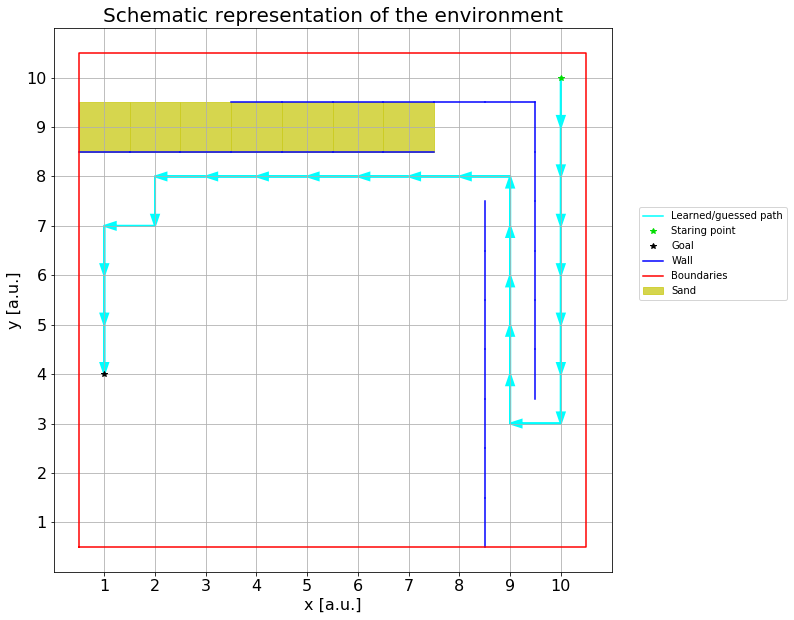

In [12]:
list_states = np.array(list_states)

plt.figure(figsize=(10,10))

plt.plot(list_states.T[0][0:2], list_states.T[1][0:2], '-', color="#00ffff",
         label="Learned/guessed path")
# Plotting trajectory as arrows
cont_arrow = 0
for p1,p2 in zip(list_states[:-1], list_states[1:]):
    if np.any(p1 != p2):
        if cont_arrow == 0:
            dx = p2[0] - p1[0]
            dy = p2[1] - p1[1]
            plt.arrow(p1[0], p1[1], dx, dy, color="#00ffff", shape='full', lw=2, label="Trajectory",
                      length_includes_head=True, head_width=0.15)
        else:
            dx = p2[0] - p1[0]
            dy = p2[1] - p1[1]
            plt.arrow(p1[0], p1[1], dx, dy, color="#00ffff", shape='full', lw=2,
                      length_includes_head=True, head_width=0.15)
    cont_arrow += 1

plt.plot(list_states.T[0][0], list_states.T[1][0], '*', color="#00dd00", label="Staring point")
plt.plot(goal[0], goal[1], '*', color="#000000", label="Goal")

# Plotting sand points
cont_sand = 0
for sand_p in sand:
    if cont_sand == 0:
        recta = plt.Rectangle( (sand_p[0]-0.5, sand_p[1]-0.5), 1, 1, color="#cccc22", alpha=0.8, label="Sand")
        plt.gca().add_patch(recta)
    else:
        recta = plt.Rectangle( (sand_p[0]-0.5, sand_p[1]-0.5), 1, 1, color="#cccc22", alpha=0.8)
        plt.gca().add_patch(recta)
    cont_sand += 1
        
cont = 0
for wall in walls:
    plot_wall(wall, cont)
    cont += 1

plt.xlim([-1,10])
plt.ylim([-1,10])

plt.xticks(np.arange(10), np.arange(10)+1, fontsize=16)
plt.yticks(np.arange(10), np.arange(10)+1, fontsize=16)

# Plotting bounaries
plt.plot([-0.5, 9.5, 9.5, -0.5, -0.5], [-0.5, -0.5, 9.5, 9.5, -0.5], color="#ff0000", label="Boundaries")

plt.title("Schematic representation of the environment", fontsize=20)

plt.xlabel("x [a.u.]", fontsize=16)
plt.ylabel("y [a.u.]", fontsize=16)

my_leg = plt.legend(loc=(1.05,0.5))
plt.grid()

plt.savefig(str(path_img+"/ENV2__walls_sand1.png"), bbox_inches='tight')

plt.show()

## More sand

In [13]:
episodes = 2000         # number of training episodes
episode_length = 50     # maximum episode length
x = 10                  # horizontal size of the box
y = 10                  # vertical size of the box
goal = [0, 3]           # objective point
discount = 0.9          # exponential discount factor
softmax = False         # set to true to use Softmax policy
sarsa = False           # set to true to use the Sarsa algorithm
init_window = [[9,10],[9,10]]   # set [x1,x2],[y1,y2] generation interval for the x,y initial position

# TODO alpha and epsilon profile
alpha = np.ones(episodes) * 0.25
epsilon = np.linspace(0.8, 0.001,episodes)

# So the best action gets 1-ε, so 0.2
# 	the others get ε/(N-1)

# initialize the agent
learner = Agent((x * y), 5, discount, max_reward=1, softmax=softmax, sarsa=sarsa)

# Setting walls
walls = [[[8,9],[8,8]], [[7,9],[7,8]], [[6,9],[6,8]], [[5,9],[5,8]], [[4,9],[4,8]], [[3,9],[3,8]],
         [[9,8],[8,8]], [[9,7],[8,7]], [[9,6],[8,6]], [[9,5],[8,5]], [[9,4],[8,4]], [[9,3],[8,3]],
         [[6,8],[6,7]], [[5,8],[5,7]], [[4,8],[4,7]], [[3,8],[3,7]], [[2,8],[2,7]], [[1,8],[1,7]], [[0,8],[0,7]],
         [[8,6],[7,6]], [[8,5],[7,5]], [[8,4],[7,4]], [[8,3],[7,3]], [[8,2],[7,2]], [[8,1],[7,1]], [[8,0],[7,0]]]

# Setting sand
sand = [[0,8], [1,8], [2,8], [3,8], [4,8], [5,8], [6,8],
        [7,5], [6,5]]
#[3,3], [3,4], [3,5], [3,6], [3,7]]
#        [4,3], [4,4], [4,5], [4,6], [4,7], [2,3], [1,3]]

# perform the training
for index in range(0, episodes):
    # start from a random state
    initial = [np.random.randint(init_window[0][0], init_window[0][1]),
               np.random.randint(init_window[1][0], init_window[1][1])]
    # initialize environment
    state = initial
    
    # list of actions to visualize the track
    list_states = [initial]
    
    env = Environment(x, y, state, goal, walls = walls, sand=sand)
    reward = 0
    # run episode
    for step in range(0, episode_length):
        # find state index (vectorize the state in the matrix?)
        state_index = state[0] * y + state[1]
        # choose an action
        action = learner.select_action(state_index, epsilon[index])
        # the agent moves in the environment
        result = env.move(action)
        
        # Saving the last list of actions
        if (index == episodes-1):
            list_states.append(result[0])
        
        # Q-learning update
        next_index = result[0][0] * y + result[0][1]
        learner.update(state_index, action, result[1], next_index, alpha[index], epsilon[index])
        # update state and reward
        reward += result[1]
        state = result[0]
    # Only to track the average reward
    reward /= episode_length
    print('Episode ', index + 1, ': the agent has obtained an average reward of ', reward, ' starting from position ', initial) 
    
    # periodically save the agent
    if ((index + 1) % 10 == 0):
        with open('agent.obj', 'wb') as agent_file:
            dill.dump(learner, agent_file)

Episode  1 : the agent has obtained an average reward of  -0.34  starting from position  [9, 9]
Episode  2 : the agent has obtained an average reward of  -0.24119999999999997  starting from position  [9, 9]
Episode  3 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  4 : the agent has obtained an average reward of  -0.32  starting from position  [9, 9]
Episode  5 : the agent has obtained an average reward of  -0.18  starting from position  [9, 9]
Episode  6 : the agent has obtained an average reward of  -0.4  starting from position  [9, 9]
Episode  7 : the agent has obtained an average reward of  -0.12179999999999996  starting from position  [9, 9]
Episode  8 : the agent has obtained an average reward of  -0.24  starting from position  [9, 9]
Episode  9 : the agent has obtained an average reward of  -0.22  starting from position  [9, 9]
Episode  10 : the agent has obtained an average reward of  -0.2  starting from position  [9, 9]
Episode  11

Episode  91 : the agent has obtained an average reward of  -0.16  starting from position  [9, 9]
Episode  92 : the agent has obtained an average reward of  -0.38  starting from position  [9, 9]
Episode  93 : the agent has obtained an average reward of  -0.24  starting from position  [9, 9]
Episode  94 : the agent has obtained an average reward of  -0.1  starting from position  [9, 9]
Episode  95 : the agent has obtained an average reward of  -0.2402  starting from position  [9, 9]
Episode  96 : the agent has obtained an average reward of  -0.22  starting from position  [9, 9]
Episode  97 : the agent has obtained an average reward of  -0.26  starting from position  [9, 9]
Episode  98 : the agent has obtained an average reward of  -0.24  starting from position  [9, 9]
Episode  99 : the agent has obtained an average reward of  -0.36  starting from position  [9, 9]
Episode  100 : the agent has obtained an average reward of  -0.24  starting from position  [9, 9]
Episode  101 : the agent has

Episode  180 : the agent has obtained an average reward of  -0.26  starting from position  [9, 9]
Episode  181 : the agent has obtained an average reward of  -0.24259999999999995  starting from position  [9, 9]
Episode  182 : the agent has obtained an average reward of  -0.20159999999999997  starting from position  [9, 9]
Episode  183 : the agent has obtained an average reward of  -0.24  starting from position  [9, 9]
Episode  184 : the agent has obtained an average reward of  -0.26  starting from position  [9, 9]
Episode  185 : the agent has obtained an average reward of  -0.16  starting from position  [9, 9]
Episode  186 : the agent has obtained an average reward of  -0.2  starting from position  [9, 9]
Episode  187 : the agent has obtained an average reward of  -0.18  starting from position  [9, 9]
Episode  188 : the agent has obtained an average reward of  -0.22039999999999998  starting from position  [9, 9]
Episode  189 : the agent has obtained an average reward of  -0.22099999999

Episode  267 : the agent has obtained an average reward of  -0.18  starting from position  [9, 9]
Episode  268 : the agent has obtained an average reward of  -0.16  starting from position  [9, 9]
Episode  269 : the agent has obtained an average reward of  -0.12  starting from position  [9, 9]
Episode  270 : the agent has obtained an average reward of  -0.06379999999999991  starting from position  [9, 9]
Episode  271 : the agent has obtained an average reward of  -0.06419999999999991  starting from position  [9, 9]
Episode  272 : the agent has obtained an average reward of  -0.26  starting from position  [9, 9]
Episode  273 : the agent has obtained an average reward of  -0.18  starting from position  [9, 9]
Episode  274 : the agent has obtained an average reward of  -0.20239999999999994  starting from position  [9, 9]
Episode  275 : the agent has obtained an average reward of  -0.16079999999999997  starting from position  [9, 9]
Episode  276 : the agent has obtained an average reward of

Episode  354 : the agent has obtained an average reward of  -0.14119999999999996  starting from position  [9, 9]
Episode  355 : the agent has obtained an average reward of  -0.12  starting from position  [9, 9]
Episode  356 : the agent has obtained an average reward of  -0.02  starting from position  [9, 9]
Episode  357 : the agent has obtained an average reward of  -0.06  starting from position  [9, 9]
Episode  358 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  359 : the agent has obtained an average reward of  -0.14079999999999998  starting from position  [9, 9]
Episode  360 : the agent has obtained an average reward of  -0.18059999999999998  starting from position  [9, 9]
Episode  361 : the agent has obtained an average reward of  -0.024400000000000005  starting from position  [9, 9]
Episode  362 : the agent has obtained an average reward of  -0.22  starting from position  [9, 9]
Episode  363 : the agent has obtained an average reward o

Episode  442 : the agent has obtained an average reward of  -0.08379999999999992  starting from position  [9, 9]
Episode  443 : the agent has obtained an average reward of  -0.1  starting from position  [9, 9]
Episode  444 : the agent has obtained an average reward of  -0.20119999999999996  starting from position  [9, 9]
Episode  445 : the agent has obtained an average reward of  -0.10159999999999997  starting from position  [9, 9]
Episode  446 : the agent has obtained an average reward of  -0.14239999999999994  starting from position  [9, 9]
Episode  447 : the agent has obtained an average reward of  -0.06219999999999995  starting from position  [9, 9]
Episode  448 : the agent has obtained an average reward of  -0.10219999999999996  starting from position  [9, 9]
Episode  449 : the agent has obtained an average reward of  -0.28  starting from position  [9, 9]
Episode  450 : the agent has obtained an average reward of  -0.06179999999999996  starting from position  [9, 9]
Episode  451 :

Episode  528 : the agent has obtained an average reward of  -0.08  starting from position  [9, 9]
Episode  529 : the agent has obtained an average reward of  -0.06319999999999994  starting from position  [9, 9]
Episode  530 : the agent has obtained an average reward of  -0.02  starting from position  [9, 9]
Episode  531 : the agent has obtained an average reward of  -0.02  starting from position  [9, 9]
Episode  532 : the agent has obtained an average reward of  -0.023400000000000004  starting from position  [9, 9]
Episode  533 : the agent has obtained an average reward of  -0.08239999999999995  starting from position  [9, 9]
Episode  534 : the agent has obtained an average reward of  -0.08  starting from position  [9, 9]
Episode  535 : the agent has obtained an average reward of  -0.1  starting from position  [9, 9]
Episode  536 : the agent has obtained an average reward of  -0.04019999999999999  starting from position  [9, 9]
Episode  537 : the agent has obtained an average reward of

Episode  614 : the agent has obtained an average reward of  -0.08  starting from position  [9, 9]
Episode  615 : the agent has obtained an average reward of  -0.06259999999999995  starting from position  [9, 9]
Episode  616 : the agent has obtained an average reward of  -0.02  starting from position  [9, 9]
Episode  617 : the agent has obtained an average reward of  -0.08339999999999993  starting from position  [9, 9]
Episode  618 : the agent has obtained an average reward of  -0.06159999999999997  starting from position  [9, 9]
Episode  619 : the agent has obtained an average reward of  -0.14  starting from position  [9, 9]
Episode  620 : the agent has obtained an average reward of  -0.10279999999999995  starting from position  [9, 9]
Episode  621 : the agent has obtained an average reward of  -0.042399999999999965  starting from position  [9, 9]
Episode  622 : the agent has obtained an average reward of  -0.10159999999999997  starting from position  [9, 9]
Episode  623 : the agent ha

Episode  697 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  698 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  699 : the agent has obtained an average reward of  -0.10279999999999995  starting from position  [9, 9]
Episode  700 : the agent has obtained an average reward of  -0.1  starting from position  [9, 9]
Episode  701 : the agent has obtained an average reward of  -0.1  starting from position  [9, 9]
Episode  702 : the agent has obtained an average reward of  -0.04059999999999999  starting from position  [9, 9]
Episode  703 : the agent has obtained an average reward of  -0.04159999999999996  starting from position  [9, 9]
Episode  704 : the agent has obtained an average reward of  -0.08  starting from position  [9, 9]
Episode  705 : the agent has obtained an average reward of  -0.12299999999999994  starting from position  [9, 9]
Episode  706 : the agent has obtained an average reward of  

Episode  780 : the agent has obtained an average reward of  -0.06139999999999997  starting from position  [9, 9]
Episode  781 : the agent has obtained an average reward of  -0.0016  starting from position  [9, 9]
Episode  782 : the agent has obtained an average reward of  -0.0204  starting from position  [9, 9]
Episode  783 : the agent has obtained an average reward of  -0.06  starting from position  [9, 9]
Episode  784 : the agent has obtained an average reward of  -0.04259999999999994  starting from position  [9, 9]
Episode  785 : the agent has obtained an average reward of  -0.08  starting from position  [9, 9]
Episode  786 : the agent has obtained an average reward of  -0.02  starting from position  [9, 9]
Episode  787 : the agent has obtained an average reward of  -0.0206  starting from position  [9, 9]
Episode  788 : the agent has obtained an average reward of  -0.06  starting from position  [9, 9]
Episode  789 : the agent has obtained an average reward of  -0.06  starting from p

Episode  862 : the agent has obtained an average reward of  -0.04239999999999995  starting from position  [9, 9]
Episode  863 : the agent has obtained an average reward of  -0.02  starting from position  [9, 9]
Episode  864 : the agent has obtained an average reward of  -0.06319999999999994  starting from position  [9, 9]
Episode  865 : the agent has obtained an average reward of  -0.04279999999999994  starting from position  [9, 9]
Episode  866 : the agent has obtained an average reward of  -0.0202  starting from position  [9, 9]
Episode  867 : the agent has obtained an average reward of  -0.0602  starting from position  [9, 9]
Episode  868 : the agent has obtained an average reward of  -0.06179999999999996  starting from position  [9, 9]
Episode  869 : the agent has obtained an average reward of  -0.08119999999999998  starting from position  [9, 9]
Episode  870 : the agent has obtained an average reward of  -0.0202  starting from position  [9, 9]
Episode  871 : the agent has obtained

Episode  942 : the agent has obtained an average reward of  -0.022000000000000002  starting from position  [9, 9]
Episode  943 : the agent has obtained an average reward of  -0.08419999999999991  starting from position  [9, 9]
Episode  944 : the agent has obtained an average reward of  -0.081  starting from position  [9, 9]
Episode  945 : the agent has obtained an average reward of  -0.04059999999999999  starting from position  [9, 9]
Episode  946 : the agent has obtained an average reward of  -0.06319999999999995  starting from position  [9, 9]
Episode  947 : the agent has obtained an average reward of  -0.06279999999999994  starting from position  [9, 9]
Episode  948 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  949 : the agent has obtained an average reward of  -0.041400000000000006  starting from position  [9, 9]
Episode  950 : the agent has obtained an average reward of  -0.04019999999999999  starting from position  [9, 9]
Episode  9

Episode  1022 : the agent has obtained an average reward of  -0.1002  starting from position  [9, 9]
Episode  1023 : the agent has obtained an average reward of  -0.04159999999999996  starting from position  [9, 9]
Episode  1024 : the agent has obtained an average reward of  -0.1002  starting from position  [9, 9]
Episode  1025 : the agent has obtained an average reward of  -0.0206  starting from position  [9, 9]
Episode  1026 : the agent has obtained an average reward of  -0.0228  starting from position  [9, 9]
Episode  1027 : the agent has obtained an average reward of  -0.06  starting from position  [9, 9]
Episode  1028 : the agent has obtained an average reward of  -0.0018  starting from position  [9, 9]
Episode  1029 : the agent has obtained an average reward of  -0.12159999999999997  starting from position  [9, 9]
Episode  1030 : the agent has obtained an average reward of  -0.0204  starting from position  [9, 9]
Episode  1031 : the agent has obtained an average reward of  0.14  

Episode  1102 : the agent has obtained an average reward of  -0.1202  starting from position  [9, 9]
Episode  1103 : the agent has obtained an average reward of  0.0  starting from position  [9, 9]
Episode  1104 : the agent has obtained an average reward of  0.2188  starting from position  [9, 9]
Episode  1105 : the agent has obtained an average reward of  -0.0021999999999999997  starting from position  [9, 9]
Episode  1106 : the agent has obtained an average reward of  -0.04179999999999996  starting from position  [9, 9]
Episode  1107 : the agent has obtained an average reward of  -0.0204  starting from position  [9, 9]
Episode  1108 : the agent has obtained an average reward of  -0.06219999999999995  starting from position  [9, 9]
Episode  1109 : the agent has obtained an average reward of  -0.0222  starting from position  [9, 9]
Episode  1110 : the agent has obtained an average reward of  0.1  starting from position  [9, 9]
Episode  1111 : the agent has obtained an average reward of

Episode  1182 : the agent has obtained an average reward of  -0.04039999999999999  starting from position  [9, 9]
Episode  1183 : the agent has obtained an average reward of  -0.0218  starting from position  [9, 9]
Episode  1184 : the agent has obtained an average reward of  -0.0024  starting from position  [9, 9]
Episode  1185 : the agent has obtained an average reward of  -0.02  starting from position  [9, 9]
Episode  1186 : the agent has obtained an average reward of  0.07780000000000005  starting from position  [9, 9]
Episode  1187 : the agent has obtained an average reward of  -0.08059999999999999  starting from position  [9, 9]
Episode  1188 : the agent has obtained an average reward of  -0.02  starting from position  [9, 9]
Episode  1189 : the agent has obtained an average reward of  -0.0002  starting from position  [9, 9]
Episode  1190 : the agent has obtained an average reward of  -0.004400000000000001  starting from position  [9, 9]
Episode  1191 : the agent has obtained an a

Episode  1262 : the agent has obtained an average reward of  0.07980000000000001  starting from position  [9, 9]
Episode  1263 : the agent has obtained an average reward of  0.15780000000000002  starting from position  [9, 9]
Episode  1264 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  1265 : the agent has obtained an average reward of  0.04  starting from position  [9, 9]
Episode  1266 : the agent has obtained an average reward of  -0.0002  starting from position  [9, 9]
Episode  1267 : the agent has obtained an average reward of  0.038200000000000005  starting from position  [9, 9]
Episode  1268 : the agent has obtained an average reward of  0.11780000000000004  starting from position  [9, 9]
Episode  1269 : the agent has obtained an average reward of  0.08  starting from position  [9, 9]
Episode  1270 : the agent has obtained an average reward of  0.07800000000000004  starting from position  [9, 9]
Episode  1271 : the agent has obtained

Episode  1342 : the agent has obtained an average reward of  -0.022000000000000002  starting from position  [9, 9]
Episode  1343 : the agent has obtained an average reward of  0.2398  starting from position  [9, 9]
Episode  1344 : the agent has obtained an average reward of  -0.021400000000000002  starting from position  [9, 9]
Episode  1345 : the agent has obtained an average reward of  -0.04179999999999996  starting from position  [9, 9]
Episode  1346 : the agent has obtained an average reward of  -0.04039999999999999  starting from position  [9, 9]
Episode  1347 : the agent has obtained an average reward of  0.16  starting from position  [9, 9]
Episode  1348 : the agent has obtained an average reward of  0.1396  starting from position  [9, 9]
Episode  1349 : the agent has obtained an average reward of  0.1788  starting from position  [9, 9]
Episode  1350 : the agent has obtained an average reward of  0.12  starting from position  [9, 9]
Episode  1351 : the agent has obtained an aver

Episode  1422 : the agent has obtained an average reward of  0.1398  starting from position  [9, 9]
Episode  1423 : the agent has obtained an average reward of  0.098  starting from position  [9, 9]
Episode  1424 : the agent has obtained an average reward of  0.3  starting from position  [9, 9]
Episode  1425 : the agent has obtained an average reward of  0.21960000000000002  starting from position  [9, 9]
Episode  1426 : the agent has obtained an average reward of  0.039  starting from position  [9, 9]
Episode  1427 : the agent has obtained an average reward of  0.16  starting from position  [9, 9]
Episode  1428 : the agent has obtained an average reward of  0.057800000000000004  starting from position  [9, 9]
Episode  1429 : the agent has obtained an average reward of  0.0998  starting from position  [9, 9]
Episode  1430 : the agent has obtained an average reward of  0.16  starting from position  [9, 9]
Episode  1431 : the agent has obtained an average reward of  0.1378  starting from

Episode  1503 : the agent has obtained an average reward of  0.179  starting from position  [9, 9]
Episode  1504 : the agent has obtained an average reward of  0.06  starting from position  [9, 9]
Episode  1505 : the agent has obtained an average reward of  0.0998  starting from position  [9, 9]
Episode  1506 : the agent has obtained an average reward of  0.01900000000000002  starting from position  [9, 9]
Episode  1507 : the agent has obtained an average reward of  0.15820000000000004  starting from position  [9, 9]
Episode  1508 : the agent has obtained an average reward of  0.12  starting from position  [9, 9]
Episode  1509 : the agent has obtained an average reward of  0.019799999999999998  starting from position  [9, 9]
Episode  1510 : the agent has obtained an average reward of  0.04  starting from position  [9, 9]
Episode  1511 : the agent has obtained an average reward of  0.2386  starting from position  [9, 9]
Episode  1512 : the agent has obtained an average reward of  0.24  

Episode  1593 : the agent has obtained an average reward of  0.36  starting from position  [9, 9]
Episode  1594 : the agent has obtained an average reward of  0.38  starting from position  [9, 9]
Episode  1595 : the agent has obtained an average reward of  0.19740000000000002  starting from position  [9, 9]
Episode  1596 : the agent has obtained an average reward of  0.2  starting from position  [9, 9]
Episode  1597 : the agent has obtained an average reward of  0.24  starting from position  [9, 9]
Episode  1598 : the agent has obtained an average reward of  0.12  starting from position  [9, 9]
Episode  1599 : the agent has obtained an average reward of  0.16  starting from position  [9, 9]
Episode  1600 : the agent has obtained an average reward of  0.22  starting from position  [9, 9]
Episode  1601 : the agent has obtained an average reward of  0.26  starting from position  [9, 9]
Episode  1602 : the agent has obtained an average reward of  0.3  starting from position  [9, 9]
Episode

Episode  1683 : the agent has obtained an average reward of  0.2998  starting from position  [9, 9]
Episode  1684 : the agent has obtained an average reward of  0.34  starting from position  [9, 9]
Episode  1685 : the agent has obtained an average reward of  0.16  starting from position  [9, 9]
Episode  1686 : the agent has obtained an average reward of  0.34  starting from position  [9, 9]
Episode  1687 : the agent has obtained an average reward of  0.26  starting from position  [9, 9]
Episode  1688 : the agent has obtained an average reward of  0.26  starting from position  [9, 9]
Episode  1689 : the agent has obtained an average reward of  0.26  starting from position  [9, 9]
Episode  1690 : the agent has obtained an average reward of  0.22  starting from position  [9, 9]
Episode  1691 : the agent has obtained an average reward of  0.24  starting from position  [9, 9]
Episode  1692 : the agent has obtained an average reward of  0.3  starting from position  [9, 9]
Episode  1693 : the

Episode  1773 : the agent has obtained an average reward of  0.16  starting from position  [9, 9]
Episode  1774 : the agent has obtained an average reward of  0.38  starting from position  [9, 9]
Episode  1775 : the agent has obtained an average reward of  0.28  starting from position  [9, 9]
Episode  1776 : the agent has obtained an average reward of  0.46  starting from position  [9, 9]
Episode  1777 : the agent has obtained an average reward of  0.32  starting from position  [9, 9]
Episode  1778 : the agent has obtained an average reward of  0.38  starting from position  [9, 9]
Episode  1779 : the agent has obtained an average reward of  0.32  starting from position  [9, 9]
Episode  1780 : the agent has obtained an average reward of  0.38  starting from position  [9, 9]
Episode  1781 : the agent has obtained an average reward of  0.44  starting from position  [9, 9]
Episode  1782 : the agent has obtained an average reward of  0.36  starting from position  [9, 9]
Episode  1783 : the 

Episode  1863 : the agent has obtained an average reward of  0.38  starting from position  [9, 9]
Episode  1864 : the agent has obtained an average reward of  0.32  starting from position  [9, 9]
Episode  1865 : the agent has obtained an average reward of  0.38  starting from position  [9, 9]
Episode  1866 : the agent has obtained an average reward of  0.46  starting from position  [9, 9]
Episode  1867 : the agent has obtained an average reward of  0.48  starting from position  [9, 9]
Episode  1868 : the agent has obtained an average reward of  0.4  starting from position  [9, 9]
Episode  1869 : the agent has obtained an average reward of  0.38  starting from position  [9, 9]
Episode  1870 : the agent has obtained an average reward of  0.44  starting from position  [9, 9]
Episode  1871 : the agent has obtained an average reward of  0.3  starting from position  [9, 9]
Episode  1872 : the agent has obtained an average reward of  0.46  starting from position  [9, 9]
Episode  1873 : the ag

Episode  1953 : the agent has obtained an average reward of  0.5  starting from position  [9, 9]
Episode  1954 : the agent has obtained an average reward of  0.46  starting from position  [9, 9]
Episode  1955 : the agent has obtained an average reward of  0.5  starting from position  [9, 9]
Episode  1956 : the agent has obtained an average reward of  0.46  starting from position  [9, 9]
Episode  1957 : the agent has obtained an average reward of  0.42  starting from position  [9, 9]
Episode  1958 : the agent has obtained an average reward of  0.5  starting from position  [9, 9]
Episode  1959 : the agent has obtained an average reward of  0.42  starting from position  [9, 9]
Episode  1960 : the agent has obtained an average reward of  0.38  starting from position  [9, 9]
Episode  1961 : the agent has obtained an average reward of  0.5  starting from position  [9, 9]
Episode  1962 : the agent has obtained an average reward of  0.44  starting from position  [9, 9]
Episode  1963 : the agen

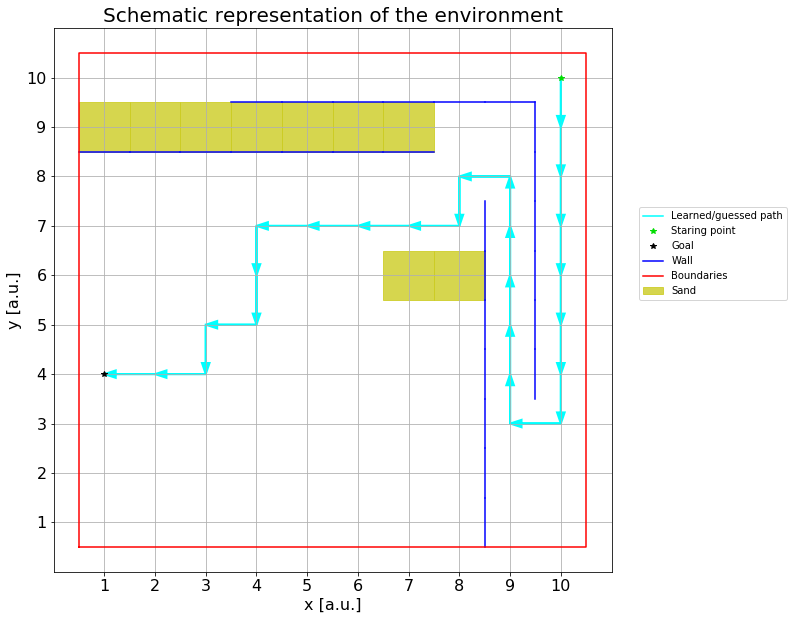

In [14]:
list_states = np.array(list_states)

plt.figure(figsize=(10,10))

plt.plot(list_states.T[0][0:2], list_states.T[1][0:2], '-', color="#00ffff",
         label="Learned/guessed path")
# Plotting trajectory as arrows
cont_arrow = 0
for p1,p2 in zip(list_states[:-1], list_states[1:]):
    if np.any(p1 != p2):
        if cont_arrow == 0:
            dx = p2[0] - p1[0]
            dy = p2[1] - p1[1]
            plt.arrow(p1[0], p1[1], dx, dy, color="#00ffff", shape='full', lw=2, label="Trajectory",
                      length_includes_head=True, head_width=0.15)
        else:
            dx = p2[0] - p1[0]
            dy = p2[1] - p1[1]
            plt.arrow(p1[0], p1[1], dx, dy, color="#00ffff", shape='full', lw=2,
                      length_includes_head=True, head_width=0.15)
    cont_arrow += 1

plt.plot(list_states.T[0][0], list_states.T[1][0], '*', color="#00dd00", label="Staring point")
plt.plot(goal[0], goal[1], '*', color="#000000", label="Goal")

# Plotting sand points
cont_sand = 0
for sand_p in sand:
    if cont_sand == 0:
        recta = plt.Rectangle( (sand_p[0]-0.5, sand_p[1]-0.5), 1, 1, color="#cccc22", alpha=0.8, label="Sand")
        plt.gca().add_patch(recta)
    else:
        recta = plt.Rectangle( (sand_p[0]-0.5, sand_p[1]-0.5), 1, 1, color="#cccc22", alpha=0.8)
        plt.gca().add_patch(recta)
    cont_sand += 1
        
cont = 0
for wall in walls:
    plot_wall(wall, cont)
    cont += 1

plt.xlim([-1,10])
plt.ylim([-1,10])

plt.xticks(np.arange(10), np.arange(10)+1, fontsize=16)
plt.yticks(np.arange(10), np.arange(10)+1, fontsize=16)

# Plotting bounaries
plt.plot([-0.5, 9.5, 9.5, -0.5, -0.5], [-0.5, -0.5, 9.5, 9.5, -0.5], color="#ff0000", label="Boundaries")

plt.title("Schematic representation of the environment", fontsize=20)

plt.xlabel("x [a.u.]", fontsize=16)
plt.ylabel("y [a.u.]", fontsize=16)

my_leg = plt.legend(loc=(1.05,0.5))
plt.grid()

plt.savefig(str(path_img+"/ENV2__walls_sand2.png"), bbox_inches='tight')

plt.show()

## More sand

In [15]:
episodes = 2000         # number of training episodes
episode_length = 50     # maximum episode length
x = 10                  # horizontal size of the box
y = 10                  # vertical size of the box
goal = [0, 3]           # objective point
discount = 0.9          # exponential discount factor
softmax = False         # set to true to use Softmax policy
sarsa = False           # set to true to use the Sarsa algorithm
init_window = [[9,10],[9,10]]   # set [x1,x2],[y1,y2] generation interval for the x,y initial position

# TODO alpha and epsilon profile
alpha = np.ones(episodes) * 0.25
epsilon = np.linspace(0.8, 0.001,episodes)

# So the best action gets 1-ε, so 0.2
# 	the others get ε/(N-1)

# initialize the agent
learner = Agent((x * y), 5, discount, max_reward=1, softmax=softmax, sarsa=sarsa)

# Setting walls
walls = [[[8,9],[8,8]], [[7,9],[7,8]], [[6,9],[6,8]], [[5,9],[5,8]], [[4,9],[4,8]], [[3,9],[3,8]],
         [[9,8],[8,8]], [[9,7],[8,7]], [[9,6],[8,6]], [[9,5],[8,5]], [[9,4],[8,4]], [[9,3],[8,3]],
         [[6,8],[6,7]], [[5,8],[5,7]], [[4,8],[4,7]], [[3,8],[3,7]], [[2,8],[2,7]], [[1,8],[1,7]], [[0,8],[0,7]],
         [[8,6],[7,6]], [[8,5],[7,5]], [[8,4],[7,4]], [[8,3],[7,3]], [[8,2],[7,2]], [[8,1],[7,1]], [[8,0],[7,0]]]

# Setting sand
sand = [[0,8], [1,8], [2,8], [3,8], [4,8], [5,8], [6,8],
        [7,5], [6,5], [3,3], [3,4], [3,5], [3,6], [3,7],
        [4,3], [4,4], [4,5], [4,6], [4,7]]
#[2,3], [1,3]]

# perform the training
for index in range(0, episodes):
    # start from a random state
    initial = [np.random.randint(init_window[0][0], init_window[0][1]),
               np.random.randint(init_window[1][0], init_window[1][1])]
    # initialize environment
    state = initial
    
    # list of actions to visualize the track
    list_states = [initial]
    
    env = Environment(x, y, state, goal, walls = walls, sand=sand)
    reward = 0
    # run episode
    for step in range(0, episode_length):
        # find state index (vectorize the state in the matrix?)
        state_index = state[0] * y + state[1]
        # choose an action
        action = learner.select_action(state_index, epsilon[index])
        # the agent moves in the environment
        result = env.move(action)
        
        # Saving the last list of actions
        if (index == episodes-1):
            list_states.append(result[0])
        
        # Q-learning update
        next_index = result[0][0] * y + result[0][1]
        learner.update(state_index, action, result[1], next_index, alpha[index], epsilon[index])
        # update state and reward
        reward += result[1]
        state = result[0]
    # Only to track the average reward
    reward /= episode_length
    print('Episode ', index + 1, ': the agent has obtained an average reward of ', reward, ' starting from position ', initial) 
    
    # periodically save the agent
    if ((index + 1) % 10 == 0):
        with open('agent.obj', 'wb') as agent_file:
            dill.dump(learner, agent_file)

Episode  1 : the agent has obtained an average reward of  -0.24  starting from position  [9, 9]
Episode  2 : the agent has obtained an average reward of  -0.3  starting from position  [9, 9]
Episode  3 : the agent has obtained an average reward of  -0.18  starting from position  [9, 9]
Episode  4 : the agent has obtained an average reward of  -0.12  starting from position  [9, 9]
Episode  5 : the agent has obtained an average reward of  -0.2  starting from position  [9, 9]
Episode  6 : the agent has obtained an average reward of  -0.28  starting from position  [9, 9]
Episode  7 : the agent has obtained an average reward of  -0.4  starting from position  [9, 9]
Episode  8 : the agent has obtained an average reward of  -0.22  starting from position  [9, 9]
Episode  9 : the agent has obtained an average reward of  -0.32  starting from position  [9, 9]
Episode  10 : the agent has obtained an average reward of  -0.12  starting from position  [9, 9]
Episode  11 : the agent has obtained an av

Episode  89 : the agent has obtained an average reward of  -0.12  starting from position  [9, 9]
Episode  90 : the agent has obtained an average reward of  -0.16  starting from position  [9, 9]
Episode  91 : the agent has obtained an average reward of  -0.3  starting from position  [9, 9]
Episode  92 : the agent has obtained an average reward of  -0.08239999999999995  starting from position  [9, 9]
Episode  93 : the agent has obtained an average reward of  -0.32  starting from position  [9, 9]
Episode  94 : the agent has obtained an average reward of  -0.14  starting from position  [9, 9]
Episode  95 : the agent has obtained an average reward of  -0.18  starting from position  [9, 9]
Episode  96 : the agent has obtained an average reward of  -0.22219999999999995  starting from position  [9, 9]
Episode  97 : the agent has obtained an average reward of  -0.2404  starting from position  [9, 9]
Episode  98 : the agent has obtained an average reward of  -0.24  starting from position  [9, 9]

Episode  175 : the agent has obtained an average reward of  -0.2  starting from position  [9, 9]
Episode  176 : the agent has obtained an average reward of  -0.10219999999999996  starting from position  [9, 9]
Episode  177 : the agent has obtained an average reward of  -0.12  starting from position  [9, 9]
Episode  178 : the agent has obtained an average reward of  -0.28  starting from position  [9, 9]
Episode  179 : the agent has obtained an average reward of  -0.14  starting from position  [9, 9]
Episode  180 : the agent has obtained an average reward of  -0.16  starting from position  [9, 9]
Episode  181 : the agent has obtained an average reward of  -0.16  starting from position  [9, 9]
Episode  182 : the agent has obtained an average reward of  -0.14  starting from position  [9, 9]
Episode  183 : the agent has obtained an average reward of  -0.14  starting from position  [9, 9]
Episode  184 : the agent has obtained an average reward of  -0.14179999999999995  starting from position

Episode  256 : the agent has obtained an average reward of  -0.20079999999999998  starting from position  [9, 9]
Episode  257 : the agent has obtained an average reward of  -0.2  starting from position  [9, 9]
Episode  258 : the agent has obtained an average reward of  -0.24  starting from position  [9, 9]
Episode  259 : the agent has obtained an average reward of  -0.22  starting from position  [9, 9]
Episode  260 : the agent has obtained an average reward of  -0.22  starting from position  [9, 9]
Episode  261 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  262 : the agent has obtained an average reward of  -0.16  starting from position  [9, 9]
Episode  263 : the agent has obtained an average reward of  -0.2402  starting from position  [9, 9]
Episode  264 : the agent has obtained an average reward of  -0.18  starting from position  [9, 9]
Episode  265 : the agent has obtained an average reward of  -0.20159999999999997  starting from positi

Episode  338 : the agent has obtained an average reward of  -0.12  starting from position  [9, 9]
Episode  339 : the agent has obtained an average reward of  -0.3  starting from position  [9, 9]
Episode  340 : the agent has obtained an average reward of  -0.2  starting from position  [9, 9]
Episode  341 : the agent has obtained an average reward of  -0.08  starting from position  [9, 9]
Episode  342 : the agent has obtained an average reward of  -0.16  starting from position  [9, 9]
Episode  343 : the agent has obtained an average reward of  -0.12  starting from position  [9, 9]
Episode  344 : the agent has obtained an average reward of  -0.12  starting from position  [9, 9]
Episode  345 : the agent has obtained an average reward of  -0.1  starting from position  [9, 9]
Episode  346 : the agent has obtained an average reward of  -0.10139999999999998  starting from position  [9, 9]
Episode  347 : the agent has obtained an average reward of  -0.2  starting from position  [9, 9]
Episode  

Episode  419 : the agent has obtained an average reward of  -0.3  starting from position  [9, 9]
Episode  420 : the agent has obtained an average reward of  -0.18279999999999993  starting from position  [9, 9]
Episode  421 : the agent has obtained an average reward of  -0.1  starting from position  [9, 9]
Episode  422 : the agent has obtained an average reward of  -0.08  starting from position  [9, 9]
Episode  423 : the agent has obtained an average reward of  -0.10239999999999995  starting from position  [9, 9]
Episode  424 : the agent has obtained an average reward of  -0.08079999999999998  starting from position  [9, 9]
Episode  425 : the agent has obtained an average reward of  -0.10199999999999995  starting from position  [9, 9]
Episode  426 : the agent has obtained an average reward of  -0.12119999999999997  starting from position  [9, 9]
Episode  427 : the agent has obtained an average reward of  -0.12  starting from position  [9, 9]
Episode  428 : the agent has obtained an aver

Episode  499 : the agent has obtained an average reward of  -0.14219999999999997  starting from position  [9, 9]
Episode  500 : the agent has obtained an average reward of  -0.08079999999999998  starting from position  [9, 9]
Episode  501 : the agent has obtained an average reward of  -0.14  starting from position  [9, 9]
Episode  502 : the agent has obtained an average reward of  -0.16  starting from position  [9, 9]
Episode  503 : the agent has obtained an average reward of  -0.08319999999999993  starting from position  [9, 9]
Episode  504 : the agent has obtained an average reward of  -0.14  starting from position  [9, 9]
Episode  505 : the agent has obtained an average reward of  -0.06179999999999996  starting from position  [9, 9]
Episode  506 : the agent has obtained an average reward of  -0.18  starting from position  [9, 9]
Episode  507 : the agent has obtained an average reward of  0.0  starting from position  [9, 9]
Episode  508 : the agent has obtained an average reward of  

Episode  578 : the agent has obtained an average reward of  -0.16  starting from position  [9, 9]
Episode  579 : the agent has obtained an average reward of  -0.0602  starting from position  [9, 9]
Episode  580 : the agent has obtained an average reward of  -0.023400000000000004  starting from position  [9, 9]
Episode  581 : the agent has obtained an average reward of  -0.04139999999999997  starting from position  [9, 9]
Episode  582 : the agent has obtained an average reward of  -0.04399999999999997  starting from position  [9, 9]
Episode  583 : the agent has obtained an average reward of  -0.02  starting from position  [9, 9]
Episode  584 : the agent has obtained an average reward of  -0.12239999999999995  starting from position  [9, 9]
Episode  585 : the agent has obtained an average reward of  -0.06339999999999993  starting from position  [9, 9]
Episode  586 : the agent has obtained an average reward of  -0.14  starting from position  [9, 9]
Episode  587 : the agent has obtained an

Episode  657 : the agent has obtained an average reward of  -0.08259999999999995  starting from position  [9, 9]
Episode  658 : the agent has obtained an average reward of  -0.0202  starting from position  [9, 9]
Episode  659 : the agent has obtained an average reward of  -0.16  starting from position  [9, 9]
Episode  660 : the agent has obtained an average reward of  -0.06039999999999999  starting from position  [9, 9]
Episode  661 : the agent has obtained an average reward of  -0.022400000000000003  starting from position  [9, 9]
Episode  662 : the agent has obtained an average reward of  -0.08  starting from position  [9, 9]
Episode  663 : the agent has obtained an average reward of  -0.0206  starting from position  [9, 9]
Episode  664 : the agent has obtained an average reward of  -0.10219999999999996  starting from position  [9, 9]
Episode  665 : the agent has obtained an average reward of  -0.14319999999999994  starting from position  [9, 9]
Episode  666 : the agent has obtained 

Episode  735 : the agent has obtained an average reward of  -0.043399999999999925  starting from position  [9, 9]
Episode  736 : the agent has obtained an average reward of  -0.1  starting from position  [9, 9]
Episode  737 : the agent has obtained an average reward of  -0.0222  starting from position  [9, 9]
Episode  738 : the agent has obtained an average reward of  -0.04079999999999998  starting from position  [9, 9]
Episode  739 : the agent has obtained an average reward of  -0.10079999999999999  starting from position  [9, 9]
Episode  740 : the agent has obtained an average reward of  -0.18159999999999996  starting from position  [9, 9]
Episode  741 : the agent has obtained an average reward of  -0.041999999999999954  starting from position  [9, 9]
Episode  742 : the agent has obtained an average reward of  -0.04099999999999998  starting from position  [9, 9]
Episode  743 : the agent has obtained an average reward of  -0.06339999999999993  starting from position  [9, 9]
Episode  7

Episode  818 : the agent has obtained an average reward of  -0.18  starting from position  [9, 9]
Episode  819 : the agent has obtained an average reward of  -0.04279999999999994  starting from position  [9, 9]
Episode  820 : the agent has obtained an average reward of  -0.0204  starting from position  [9, 9]
Episode  821 : the agent has obtained an average reward of  -0.14179999999999995  starting from position  [9, 9]
Episode  822 : the agent has obtained an average reward of  -0.12139999999999997  starting from position  [9, 9]
Episode  823 : the agent has obtained an average reward of  -0.0232  starting from position  [9, 9]
Episode  824 : the agent has obtained an average reward of  -0.08059999999999999  starting from position  [9, 9]
Episode  825 : the agent has obtained an average reward of  -0.021400000000000002  starting from position  [9, 9]
Episode  826 : the agent has obtained an average reward of  -0.042999999999999934  starting from position  [9, 9]
Episode  827 : the age

Episode  899 : the agent has obtained an average reward of  -0.06179999999999996  starting from position  [9, 9]
Episode  900 : the agent has obtained an average reward of  -0.0202  starting from position  [9, 9]
Episode  901 : the agent has obtained an average reward of  -0.10279999999999995  starting from position  [9, 9]
Episode  902 : the agent has obtained an average reward of  -0.08159999999999996  starting from position  [9, 9]
Episode  903 : the agent has obtained an average reward of  -0.022600000000000002  starting from position  [9, 9]
Episode  904 : the agent has obtained an average reward of  -0.023400000000000004  starting from position  [9, 9]
Episode  905 : the agent has obtained an average reward of  -0.1002  starting from position  [9, 9]
Episode  906 : the agent has obtained an average reward of  -0.06219999999999995  starting from position  [9, 9]
Episode  907 : the agent has obtained an average reward of  -0.10059999999999998  starting from position  [9, 9]
Episode

Episode  983 : the agent has obtained an average reward of  -0.06  starting from position  [9, 9]
Episode  984 : the agent has obtained an average reward of  -0.08159999999999996  starting from position  [9, 9]
Episode  985 : the agent has obtained an average reward of  -0.0014000000000000002  starting from position  [9, 9]
Episode  986 : the agent has obtained an average reward of  -0.10099999999999998  starting from position  [9, 9]
Episode  987 : the agent has obtained an average reward of  -0.023200000000000002  starting from position  [9, 9]
Episode  988 : the agent has obtained an average reward of  -0.0004  starting from position  [9, 9]
Episode  989 : the agent has obtained an average reward of  -0.0024  starting from position  [9, 9]
Episode  990 : the agent has obtained an average reward of  -0.0008  starting from position  [9, 9]
Episode  991 : the agent has obtained an average reward of  -0.022000000000000002  starting from position  [9, 9]
Episode  992 : the agent has obta

Episode  1065 : the agent has obtained an average reward of  -0.06259999999999995  starting from position  [9, 9]
Episode  1066 : the agent has obtained an average reward of  -0.08059999999999999  starting from position  [9, 9]
Episode  1067 : the agent has obtained an average reward of  -0.08139999999999997  starting from position  [9, 9]
Episode  1068 : the agent has obtained an average reward of  -0.021799999999999996  starting from position  [9, 9]
Episode  1069 : the agent has obtained an average reward of  -0.0009999999999999788  starting from position  [9, 9]
Episode  1070 : the agent has obtained an average reward of  0.1194  starting from position  [9, 9]
Episode  1071 : the agent has obtained an average reward of  0.0768  starting from position  [9, 9]
Episode  1072 : the agent has obtained an average reward of  -0.08119999999999998  starting from position  [9, 9]
Episode  1073 : the agent has obtained an average reward of  -0.022600000000000002  starting from position  [9, 9

Episode  1146 : the agent has obtained an average reward of  -0.0004  starting from position  [9, 9]
Episode  1147 : the agent has obtained an average reward of  -0.06399999999999992  starting from position  [9, 9]
Episode  1148 : the agent has obtained an average reward of  0.0788  starting from position  [9, 9]
Episode  1149 : the agent has obtained an average reward of  -0.0018000000000000017  starting from position  [9, 9]
Episode  1150 : the agent has obtained an average reward of  -0.004000000000000001  starting from position  [9, 9]
Episode  1151 : the agent has obtained an average reward of  -0.0008000000000000007  starting from position  [9, 9]
Episode  1152 : the agent has obtained an average reward of  -0.12  starting from position  [9, 9]
Episode  1153 : the agent has obtained an average reward of  -0.042999999999999934  starting from position  [9, 9]
Episode  1154 : the agent has obtained an average reward of  0.018000000000000044  starting from position  [9, 9]
Episode  1

Episode  1227 : the agent has obtained an average reward of  -0.06359999999999999  starting from position  [9, 9]
Episode  1228 : the agent has obtained an average reward of  -0.06119999999999998  starting from position  [9, 9]
Episode  1229 : the agent has obtained an average reward of  0.0984  starting from position  [9, 9]
Episode  1230 : the agent has obtained an average reward of  -0.08179999999999996  starting from position  [9, 9]
Episode  1231 : the agent has obtained an average reward of  -0.04279999999999994  starting from position  [9, 9]
Episode  1232 : the agent has obtained an average reward of  -0.04019999999999999  starting from position  [9, 9]
Episode  1233 : the agent has obtained an average reward of  0.019400000000000014  starting from position  [9, 9]
Episode  1234 : the agent has obtained an average reward of  0.11719999999999998  starting from position  [9, 9]
Episode  1235 : the agent has obtained an average reward of  0.1392  starting from position  [9, 9]
Epi

Episode  1308 : the agent has obtained an average reward of  0.0796  starting from position  [9, 9]
Episode  1309 : the agent has obtained an average reward of  0.23800000000000002  starting from position  [9, 9]
Episode  1310 : the agent has obtained an average reward of  0.1392  starting from position  [9, 9]
Episode  1311 : the agent has obtained an average reward of  -0.1  starting from position  [9, 9]
Episode  1312 : the agent has obtained an average reward of  0.1182  starting from position  [9, 9]
Episode  1313 : the agent has obtained an average reward of  -0.06059999999999999  starting from position  [9, 9]
Episode  1314 : the agent has obtained an average reward of  0.1574  starting from position  [9, 9]
Episode  1315 : the agent has obtained an average reward of  0.139  starting from position  [9, 9]
Episode  1316 : the agent has obtained an average reward of  -0.021599999999999966  starting from position  [9, 9]
Episode  1317 : the agent has obtained an average reward of  

Episode  1389 : the agent has obtained an average reward of  0.19939999999999997  starting from position  [9, 9]
Episode  1390 : the agent has obtained an average reward of  0.2182  starting from position  [9, 9]
Episode  1391 : the agent has obtained an average reward of  0.059399999999999994  starting from position  [9, 9]
Episode  1392 : the agent has obtained an average reward of  0.138  starting from position  [9, 9]
Episode  1393 : the agent has obtained an average reward of  0.0796  starting from position  [9, 9]
Episode  1394 : the agent has obtained an average reward of  0.1588  starting from position  [9, 9]
Episode  1395 : the agent has obtained an average reward of  -0.0023999999999999976  starting from position  [9, 9]
Episode  1396 : the agent has obtained an average reward of  0.31939999999999996  starting from position  [9, 9]
Episode  1397 : the agent has obtained an average reward of  0.1392  starting from position  [9, 9]
Episode  1398 : the agent has obtained an ave

Episode  1470 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  1471 : the agent has obtained an average reward of  0.2778  starting from position  [9, 9]
Episode  1472 : the agent has obtained an average reward of  0.2394  starting from position  [9, 9]
Episode  1473 : the agent has obtained an average reward of  0.1392  starting from position  [9, 9]
Episode  1474 : the agent has obtained an average reward of  0.21960000000000002  starting from position  [9, 9]
Episode  1475 : the agent has obtained an average reward of  -0.0017999999999999616  starting from position  [9, 9]
Episode  1476 : the agent has obtained an average reward of  0.09879999999999999  starting from position  [9, 9]
Episode  1477 : the agent has obtained an average reward of  0.23939999999999997  starting from position  [9, 9]
Episode  1478 : the agent has obtained an average reward of  0.1984  starting from position  [9, 9]
Episode  1479 : the agent has obtained an aver

Episode  1551 : the agent has obtained an average reward of  0.2794  starting from position  [9, 9]
Episode  1552 : the agent has obtained an average reward of  0.11960000000000001  starting from position  [9, 9]
Episode  1553 : the agent has obtained an average reward of  0.2794  starting from position  [9, 9]
Episode  1554 : the agent has obtained an average reward of  0.21939999999999998  starting from position  [9, 9]
Episode  1555 : the agent has obtained an average reward of  0.21939999999999998  starting from position  [9, 9]
Episode  1556 : the agent has obtained an average reward of  0.15960000000000002  starting from position  [9, 9]
Episode  1557 : the agent has obtained an average reward of  0.0794  starting from position  [9, 9]
Episode  1558 : the agent has obtained an average reward of  0.2994  starting from position  [9, 9]
Episode  1559 : the agent has obtained an average reward of  0.2794  starting from position  [9, 9]
Episode  1560 : the agent has obtained an averag

Episode  1632 : the agent has obtained an average reward of  0.2584  starting from position  [9, 9]
Episode  1633 : the agent has obtained an average reward of  0.2396  starting from position  [9, 9]
Episode  1634 : the agent has obtained an average reward of  0.0  starting from position  [9, 9]
Episode  1635 : the agent has obtained an average reward of  0.3186  starting from position  [9, 9]
Episode  1636 : the agent has obtained an average reward of  0.3796  starting from position  [9, 9]
Episode  1637 : the agent has obtained an average reward of  0.1796  starting from position  [9, 9]
Episode  1638 : the agent has obtained an average reward of  0.11960000000000001  starting from position  [9, 9]
Episode  1639 : the agent has obtained an average reward of  0.2596  starting from position  [9, 9]
Episode  1640 : the agent has obtained an average reward of  0.379  starting from position  [9, 9]
Episode  1641 : the agent has obtained an average reward of  0.1796  starting from position

Episode  1713 : the agent has obtained an average reward of  0.2994  starting from position  [9, 9]
Episode  1714 : the agent has obtained an average reward of  0.299  starting from position  [9, 9]
Episode  1715 : the agent has obtained an average reward of  0.23800000000000002  starting from position  [9, 9]
Episode  1716 : the agent has obtained an average reward of  0.2396  starting from position  [9, 9]
Episode  1717 : the agent has obtained an average reward of  0.3796  starting from position  [9, 9]
Episode  1718 : the agent has obtained an average reward of  0.3396  starting from position  [9, 9]
Episode  1719 : the agent has obtained an average reward of  0.17939999999999998  starting from position  [9, 9]
Episode  1720 : the agent has obtained an average reward of  0.31939999999999996  starting from position  [9, 9]
Episode  1721 : the agent has obtained an average reward of  0.3796  starting from position  [9, 9]
Episode  1722 : the agent has obtained an average reward of  0

Episode  1794 : the agent has obtained an average reward of  0.37939999999999996  starting from position  [9, 9]
Episode  1795 : the agent has obtained an average reward of  0.3996  starting from position  [9, 9]
Episode  1796 : the agent has obtained an average reward of  0.3796  starting from position  [9, 9]
Episode  1797 : the agent has obtained an average reward of  0.3396  starting from position  [9, 9]
Episode  1798 : the agent has obtained an average reward of  0.41960000000000003  starting from position  [9, 9]
Episode  1799 : the agent has obtained an average reward of  0.41960000000000003  starting from position  [9, 9]
Episode  1800 : the agent has obtained an average reward of  0.4396  starting from position  [9, 9]
Episode  1801 : the agent has obtained an average reward of  0.35960000000000003  starting from position  [9, 9]
Episode  1802 : the agent has obtained an average reward of  0.3796  starting from position  [9, 9]
Episode  1803 : the agent has obtained an averag

Episode  1875 : the agent has obtained an average reward of  0.4996  starting from position  [9, 9]
Episode  1876 : the agent has obtained an average reward of  0.3796  starting from position  [9, 9]
Episode  1877 : the agent has obtained an average reward of  0.3798  starting from position  [9, 9]
Episode  1878 : the agent has obtained an average reward of  0.4596  starting from position  [9, 9]
Episode  1879 : the agent has obtained an average reward of  0.4396  starting from position  [9, 9]
Episode  1880 : the agent has obtained an average reward of  0.4596  starting from position  [9, 9]
Episode  1881 : the agent has obtained an average reward of  0.4596  starting from position  [9, 9]
Episode  1882 : the agent has obtained an average reward of  0.3796  starting from position  [9, 9]
Episode  1883 : the agent has obtained an average reward of  0.4396  starting from position  [9, 9]
Episode  1884 : the agent has obtained an average reward of  0.3796  starting from position  [9, 9]


Episode  1956 : the agent has obtained an average reward of  0.4996  starting from position  [9, 9]
Episode  1957 : the agent has obtained an average reward of  0.4996  starting from position  [9, 9]
Episode  1958 : the agent has obtained an average reward of  0.4596  starting from position  [9, 9]
Episode  1959 : the agent has obtained an average reward of  0.4596  starting from position  [9, 9]
Episode  1960 : the agent has obtained an average reward of  0.4996  starting from position  [9, 9]
Episode  1961 : the agent has obtained an average reward of  0.4996  starting from position  [9, 9]
Episode  1962 : the agent has obtained an average reward of  0.4996  starting from position  [9, 9]
Episode  1963 : the agent has obtained an average reward of  0.43939999999999996  starting from position  [9, 9]
Episode  1964 : the agent has obtained an average reward of  0.4996  starting from position  [9, 9]
Episode  1965 : the agent has obtained an average reward of  0.41960000000000003  start

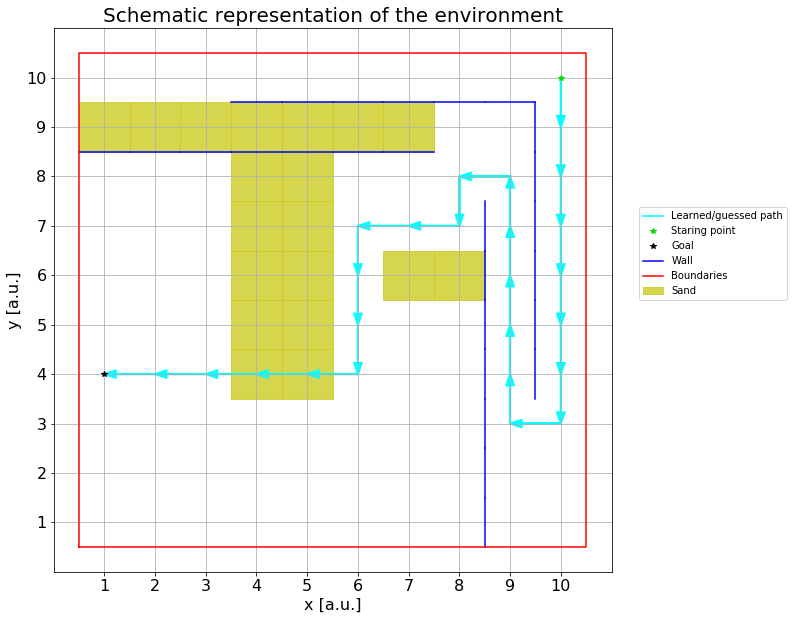

In [16]:
list_states = np.array(list_states)

plt.figure(figsize=(10,10))

plt.plot(list_states.T[0][0:2], list_states.T[1][0:2], '-', color="#00ffff",
         label="Learned/guessed path")
# Plotting trajectory as arrows
cont_arrow = 0
for p1,p2 in zip(list_states[:-1], list_states[1:]):
    if np.any(p1 != p2):
        if cont_arrow == 0:
            dx = p2[0] - p1[0]
            dy = p2[1] - p1[1]
            plt.arrow(p1[0], p1[1], dx, dy, color="#00ffff", shape='full', lw=2, label="Trajectory",
                      length_includes_head=True, head_width=0.15)
        else:
            dx = p2[0] - p1[0]
            dy = p2[1] - p1[1]
            plt.arrow(p1[0], p1[1], dx, dy, color="#00ffff", shape='full', lw=2,
                      length_includes_head=True, head_width=0.15)
    cont_arrow += 1

plt.plot(list_states.T[0][0], list_states.T[1][0], '*', color="#00dd00", label="Staring point")
plt.plot(goal[0], goal[1], '*', color="#000000", label="Goal")

# Plotting sand points
cont_sand = 0
for sand_p in sand:
    if cont_sand == 0:
        recta = plt.Rectangle( (sand_p[0]-0.5, sand_p[1]-0.5), 1, 1, color="#cccc22", alpha=0.8, label="Sand")
        plt.gca().add_patch(recta)
    else:
        recta = plt.Rectangle( (sand_p[0]-0.5, sand_p[1]-0.5), 1, 1, color="#cccc22", alpha=0.8)
        plt.gca().add_patch(recta)
    cont_sand += 1
        
cont = 0
for wall in walls:
    plot_wall(wall, cont)
    cont += 1

plt.xlim([-1,10])
plt.ylim([-1,10])

plt.xticks(np.arange(10), np.arange(10)+1, fontsize=16)
plt.yticks(np.arange(10), np.arange(10)+1, fontsize=16)

# Plotting bounaries
plt.plot([-0.5, 9.5, 9.5, -0.5, -0.5], [-0.5, -0.5, 9.5, 9.5, -0.5], color="#ff0000", label="Boundaries")

plt.title("Schematic representation of the environment", fontsize=20)

plt.xlabel("x [a.u.]", fontsize=16)
plt.ylabel("y [a.u.]", fontsize=16)

my_leg = plt.legend(loc=(1.05,0.5))
plt.grid()

plt.savefig(str(path_img+"/ENV2__walls_sand3.png"), bbox_inches='tight')

plt.show()

## More sand

In [17]:
episodes = 2000         # number of training episodes
episode_length = 50     # maximum episode length
x = 10                  # horizontal size of the box
y = 10                  # vertical size of the box
goal = [0, 3]           # objective point
discount = 0.9          # exponential discount factor
softmax = False         # set to true to use Softmax policy
sarsa = False           # set to true to use the Sarsa algorithm
init_window = [[9,10],[9,10]]   # set [x1,x2],[y1,y2] generation interval for the x,y initial position

# TODO alpha and epsilon profile
alpha = np.ones(episodes) * 0.25
epsilon = np.linspace(0.8, 0.001,episodes)

# So the best action gets 1-ε, so 0.2
# 	the others get ε/(N-1)

# initialize the agent
learner = Agent((x * y), 5, discount, max_reward=1, softmax=softmax, sarsa=sarsa)

# Setting walls
walls = [[[8,9],[8,8]], [[7,9],[7,8]], [[6,9],[6,8]], [[5,9],[5,8]], [[4,9],[4,8]], [[3,9],[3,8]],
         [[9,8],[8,8]], [[9,7],[8,7]], [[9,6],[8,6]], [[9,5],[8,5]], [[9,4],[8,4]], [[9,3],[8,3]],
         [[6,8],[6,7]], [[5,8],[5,7]], [[4,8],[4,7]], [[3,8],[3,7]], [[2,8],[2,7]], [[1,8],[1,7]], [[0,8],[0,7]],
         [[8,6],[7,6]], [[8,5],[7,5]], [[8,4],[7,4]], [[8,3],[7,3]], [[8,2],[7,2]], [[8,1],[7,1]], [[8,0],[7,0]]]

# Setting sand
sand = [[0,8], [1,8], [2,8], [3,8], [4,8], [5,8], [6,8],
        [7,5], [6,5], [3,3], [3,4], [3,5], [3,6], [3,7],
        [4,3], [4,4], [4,5], [4,6], [4,7], [2,3], [1,3]]

# perform the training
for index in range(0, episodes):
    # start from a random state
    initial = [np.random.randint(init_window[0][0], init_window[0][1]),
               np.random.randint(init_window[1][0], init_window[1][1])]
    # initialize environment
    state = initial
    
    # list of actions to visualize the track
    list_states = [initial]
    
    env = Environment(x, y, state, goal, walls = walls, sand=sand)
    reward = 0
    # run episode
    for step in range(0, episode_length):
        # find state index (vectorize the state in the matrix?)
        state_index = state[0] * y + state[1]
        # choose an action
        action = learner.select_action(state_index, epsilon[index])
        # the agent moves in the environment
        result = env.move(action)
        
        # Saving the last list of actions
        if (index == episodes-1):
            list_states.append(result[0])
        
        # Q-learning update
        next_index = result[0][0] * y + result[0][1]
        learner.update(state_index, action, result[1], next_index, alpha[index], epsilon[index])
        # update state and reward
        reward += result[1]
        state = result[0]
    # Only to track the average reward
    reward /= episode_length
    print('Episode ', index + 1, ': the agent has obtained an average reward of ', reward, ' starting from position ', initial) 
    
    # periodically save the agent
    if ((index + 1) % 10 == 0):
        with open('agent.obj', 'wb') as agent_file:
            dill.dump(learner, agent_file)

Episode  1 : the agent has obtained an average reward of  -0.16  starting from position  [9, 9]
Episode  2 : the agent has obtained an average reward of  -0.2  starting from position  [9, 9]
Episode  3 : the agent has obtained an average reward of  -0.3  starting from position  [9, 9]
Episode  4 : the agent has obtained an average reward of  -0.22  starting from position  [9, 9]
Episode  5 : the agent has obtained an average reward of  -0.1604  starting from position  [9, 9]
Episode  6 : the agent has obtained an average reward of  -0.24  starting from position  [9, 9]
Episode  7 : the agent has obtained an average reward of  -0.18159999999999996  starting from position  [9, 9]
Episode  8 : the agent has obtained an average reward of  -0.26  starting from position  [9, 9]
Episode  9 : the agent has obtained an average reward of  -0.2  starting from position  [9, 9]
Episode  10 : the agent has obtained an average reward of  -0.28  starting from position  [9, 9]
Episode  11 : the agent h

Episode  86 : the agent has obtained an average reward of  -0.18  starting from position  [9, 9]
Episode  87 : the agent has obtained an average reward of  -0.16  starting from position  [9, 9]
Episode  88 : the agent has obtained an average reward of  -0.18  starting from position  [9, 9]
Episode  89 : the agent has obtained an average reward of  -0.1  starting from position  [9, 9]
Episode  90 : the agent has obtained an average reward of  -0.28  starting from position  [9, 9]
Episode  91 : the agent has obtained an average reward of  -0.2  starting from position  [9, 9]
Episode  92 : the agent has obtained an average reward of  -0.24  starting from position  [9, 9]
Episode  93 : the agent has obtained an average reward of  -0.3  starting from position  [9, 9]
Episode  94 : the agent has obtained an average reward of  -0.22  starting from position  [9, 9]
Episode  95 : the agent has obtained an average reward of  -0.26039999999999996  starting from position  [9, 9]
Episode  96 : the 

Episode  177 : the agent has obtained an average reward of  -0.20219999999999996  starting from position  [9, 9]
Episode  178 : the agent has obtained an average reward of  -0.24119999999999997  starting from position  [9, 9]
Episode  179 : the agent has obtained an average reward of  -0.32  starting from position  [9, 9]
Episode  180 : the agent has obtained an average reward of  -0.36  starting from position  [9, 9]
Episode  181 : the agent has obtained an average reward of  -0.26  starting from position  [9, 9]
Episode  182 : the agent has obtained an average reward of  -0.10059999999999998  starting from position  [9, 9]
Episode  183 : the agent has obtained an average reward of  -0.2002  starting from position  [9, 9]
Episode  184 : the agent has obtained an average reward of  -0.1606  starting from position  [9, 9]
Episode  185 : the agent has obtained an average reward of  -0.1404  starting from position  [9, 9]
Episode  186 : the agent has obtained an average reward of  -0.14  

Episode  267 : the agent has obtained an average reward of  -0.12  starting from position  [9, 9]
Episode  268 : the agent has obtained an average reward of  -0.16  starting from position  [9, 9]
Episode  269 : the agent has obtained an average reward of  -0.08399999999999991  starting from position  [9, 9]
Episode  270 : the agent has obtained an average reward of  -0.18  starting from position  [9, 9]
Episode  271 : the agent has obtained an average reward of  -0.18099999999999997  starting from position  [9, 9]
Episode  272 : the agent has obtained an average reward of  -0.26  starting from position  [9, 9]
Episode  273 : the agent has obtained an average reward of  -0.12  starting from position  [9, 9]
Episode  274 : the agent has obtained an average reward of  -0.12259999999999999  starting from position  [9, 9]
Episode  275 : the agent has obtained an average reward of  -0.1  starting from position  [9, 9]
Episode  276 : the agent has obtained an average reward of  -0.18239999999

Episode  356 : the agent has obtained an average reward of  -0.021400000000000002  starting from position  [9, 9]
Episode  357 : the agent has obtained an average reward of  -0.14159999999999998  starting from position  [9, 9]
Episode  358 : the agent has obtained an average reward of  -0.24  starting from position  [9, 9]
Episode  359 : the agent has obtained an average reward of  -0.04  starting from position  [9, 9]
Episode  360 : the agent has obtained an average reward of  -0.1  starting from position  [9, 9]
Episode  361 : the agent has obtained an average reward of  -0.08339999999999993  starting from position  [9, 9]
Episode  362 : the agent has obtained an average reward of  -0.08199999999999996  starting from position  [9, 9]
Episode  363 : the agent has obtained an average reward of  -0.1402  starting from position  [9, 9]
Episode  364 : the agent has obtained an average reward of  -0.14  starting from position  [9, 9]
Episode  365 : the agent has obtained an average reward 

Episode  445 : the agent has obtained an average reward of  -0.141  starting from position  [9, 9]
Episode  446 : the agent has obtained an average reward of  -0.08199999999999996  starting from position  [9, 9]
Episode  447 : the agent has obtained an average reward of  -0.14239999999999994  starting from position  [9, 9]
Episode  448 : the agent has obtained an average reward of  -0.22039999999999998  starting from position  [9, 9]
Episode  449 : the agent has obtained an average reward of  -0.06  starting from position  [9, 9]
Episode  450 : the agent has obtained an average reward of  -0.08039999999999999  starting from position  [9, 9]
Episode  451 : the agent has obtained an average reward of  -0.141  starting from position  [9, 9]
Episode  452 : the agent has obtained an average reward of  -0.16139999999999996  starting from position  [9, 9]
Episode  453 : the agent has obtained an average reward of  -0.2004  starting from position  [9, 9]
Episode  454 : the agent has obtained a

Episode  522 : the agent has obtained an average reward of  -0.24  starting from position  [9, 9]
Episode  523 : the agent has obtained an average reward of  -0.06  starting from position  [9, 9]
Episode  524 : the agent has obtained an average reward of  -0.12199999999999996  starting from position  [9, 9]
Episode  525 : the agent has obtained an average reward of  -0.16119999999999998  starting from position  [9, 9]
Episode  526 : the agent has obtained an average reward of  -0.06319999999999994  starting from position  [9, 9]
Episode  527 : the agent has obtained an average reward of  -0.16  starting from position  [9, 9]
Episode  528 : the agent has obtained an average reward of  -0.12  starting from position  [9, 9]
Episode  529 : the agent has obtained an average reward of  -0.1  starting from position  [9, 9]
Episode  530 : the agent has obtained an average reward of  -0.16  starting from position  [9, 9]
Episode  531 : the agent has obtained an average reward of  -0.12219999999

Episode  609 : the agent has obtained an average reward of  -0.001  starting from position  [9, 9]
Episode  610 : the agent has obtained an average reward of  -0.022000000000000002  starting from position  [9, 9]
Episode  611 : the agent has obtained an average reward of  -0.041999999999999954  starting from position  [9, 9]
Episode  612 : the agent has obtained an average reward of  -0.12219999999999995  starting from position  [9, 9]
Episode  613 : the agent has obtained an average reward of  -0.2  starting from position  [9, 9]
Episode  614 : the agent has obtained an average reward of  -0.08119999999999998  starting from position  [9, 9]
Episode  615 : the agent has obtained an average reward of  -0.08159999999999996  starting from position  [9, 9]
Episode  616 : the agent has obtained an average reward of  -0.06379999999999991  starting from position  [9, 9]
Episode  617 : the agent has obtained an average reward of  -0.04079999999999998  starting from position  [9, 9]
Episode  61

Episode  691 : the agent has obtained an average reward of  -0.04219999999999995  starting from position  [9, 9]
Episode  692 : the agent has obtained an average reward of  -0.14  starting from position  [9, 9]
Episode  693 : the agent has obtained an average reward of  -0.1041999999999999  starting from position  [9, 9]
Episode  694 : the agent has obtained an average reward of  -0.023200000000000002  starting from position  [9, 9]
Episode  695 : the agent has obtained an average reward of  -0.06  starting from position  [9, 9]
Episode  696 : the agent has obtained an average reward of  -0.043399999999999925  starting from position  [9, 9]
Episode  697 : the agent has obtained an average reward of  -0.0622  starting from position  [9, 9]
Episode  698 : the agent has obtained an average reward of  -0.08399999999999991  starting from position  [9, 9]
Episode  699 : the agent has obtained an average reward of  -0.1  starting from position  [9, 9]
Episode  700 : the agent has obtained an 

Episode  772 : the agent has obtained an average reward of  -0.022400000000000003  starting from position  [9, 9]
Episode  773 : the agent has obtained an average reward of  -0.0602  starting from position  [9, 9]
Episode  774 : the agent has obtained an average reward of  -0.06  starting from position  [9, 9]
Episode  775 : the agent has obtained an average reward of  -0.06219999999999995  starting from position  [9, 9]
Episode  776 : the agent has obtained an average reward of  -0.022400000000000003  starting from position  [9, 9]
Episode  777 : the agent has obtained an average reward of  -0.060799999999999986  starting from position  [9, 9]
Episode  778 : the agent has obtained an average reward of  -0.10159999999999997  starting from position  [9, 9]
Episode  779 : the agent has obtained an average reward of  -0.04219999999999995  starting from position  [9, 9]
Episode  780 : the agent has obtained an average reward of  -0.023000000000000003  starting from position  [9, 9]
Episode

Episode  853 : the agent has obtained an average reward of  -0.14259999999999995  starting from position  [9, 9]
Episode  854 : the agent has obtained an average reward of  -0.021400000000000002  starting from position  [9, 9]
Episode  855 : the agent has obtained an average reward of  -0.04259999999999994  starting from position  [9, 9]
Episode  856 : the agent has obtained an average reward of  -0.04019999999999999  starting from position  [9, 9]
Episode  857 : the agent has obtained an average reward of  0.1376  starting from position  [9, 9]
Episode  858 : the agent has obtained an average reward of  -0.025600000000000005  starting from position  [9, 9]
Episode  859 : the agent has obtained an average reward of  -0.08219999999999995  starting from position  [9, 9]
Episode  860 : the agent has obtained an average reward of  -0.06199999999999996  starting from position  [9, 9]
Episode  861 : the agent has obtained an average reward of  -0.042999999999999934  starting from position  [

Episode  934 : the agent has obtained an average reward of  -0.06139999999999997  starting from position  [9, 9]
Episode  935 : the agent has obtained an average reward of  -0.1404  starting from position  [9, 9]
Episode  936 : the agent has obtained an average reward of  -0.04019999999999999  starting from position  [9, 9]
Episode  937 : the agent has obtained an average reward of  -0.023600000000000003  starting from position  [9, 9]
Episode  938 : the agent has obtained an average reward of  -0.06  starting from position  [9, 9]
Episode  939 : the agent has obtained an average reward of  -0.10239999999999995  starting from position  [9, 9]
Episode  940 : the agent has obtained an average reward of  -0.08099999999999997  starting from position  [9, 9]
Episode  941 : the agent has obtained an average reward of  -0.04059999999999999  starting from position  [9, 9]
Episode  942 : the agent has obtained an average reward of  -0.043999999999999914  starting from position  [9, 9]
Episode  

Episode  1015 : the agent has obtained an average reward of  -0.043599999999999924  starting from position  [9, 9]
Episode  1016 : the agent has obtained an average reward of  -0.0208  starting from position  [9, 9]
Episode  1017 : the agent has obtained an average reward of  -0.0218  starting from position  [9, 9]
Episode  1018 : the agent has obtained an average reward of  -0.04239999999999995  starting from position  [9, 9]
Episode  1019 : the agent has obtained an average reward of  -0.06059999999999999  starting from position  [9, 9]
Episode  1020 : the agent has obtained an average reward of  0.0192  starting from position  [9, 9]
Episode  1021 : the agent has obtained an average reward of  0.0166  starting from position  [9, 9]
Episode  1022 : the agent has obtained an average reward of  -0.0602  starting from position  [9, 9]
Episode  1023 : the agent has obtained an average reward of  -0.040600000000000004  starting from position  [9, 9]
Episode  1024 : the agent has obtained 

Episode  1096 : the agent has obtained an average reward of  -0.022400000000000003  starting from position  [9, 9]
Episode  1097 : the agent has obtained an average reward of  -0.02  starting from position  [9, 9]
Episode  1098 : the agent has obtained an average reward of  -0.022400000000000003  starting from position  [9, 9]
Episode  1099 : the agent has obtained an average reward of  -0.021199999999999997  starting from position  [9, 9]
Episode  1100 : the agent has obtained an average reward of  -0.0024  starting from position  [9, 9]
Episode  1101 : the agent has obtained an average reward of  -0.0025999999999999994  starting from position  [9, 9]
Episode  1102 : the agent has obtained an average reward of  -0.04279999999999994  starting from position  [9, 9]
Episode  1103 : the agent has obtained an average reward of  -0.0602  starting from position  [9, 9]
Episode  1104 : the agent has obtained an average reward of  -0.003  starting from position  [9, 9]
Episode  1105 : the agen

Episode  1176 : the agent has obtained an average reward of  -0.045399999999999885  starting from position  [9, 9]
Episode  1177 : the agent has obtained an average reward of  -0.0008  starting from position  [9, 9]
Episode  1178 : the agent has obtained an average reward of  -0.002400000000000002  starting from position  [9, 9]
Episode  1179 : the agent has obtained an average reward of  -0.08  starting from position  [9, 9]
Episode  1180 : the agent has obtained an average reward of  0.07800000000000004  starting from position  [9, 9]
Episode  1181 : the agent has obtained an average reward of  0.19940000000000002  starting from position  [9, 9]
Episode  1182 : the agent has obtained an average reward of  -0.0602  starting from position  [9, 9]
Episode  1183 : the agent has obtained an average reward of  0.018200000000000004  starting from position  [9, 9]
Episode  1184 : the agent has obtained an average reward of  0.057  starting from position  [9, 9]
Episode  1185 : the agent has 

Episode  1257 : the agent has obtained an average reward of  0.2188  starting from position  [9, 9]
Episode  1258 : the agent has obtained an average reward of  0.0588  starting from position  [9, 9]
Episode  1259 : the agent has obtained an average reward of  0.1772  starting from position  [9, 9]
Episode  1260 : the agent has obtained an average reward of  -0.021199999999999976  starting from position  [9, 9]
Episode  1261 : the agent has obtained an average reward of  -0.022600000000000002  starting from position  [9, 9]
Episode  1262 : the agent has obtained an average reward of  -0.021  starting from position  [9, 9]
Episode  1263 : the agent has obtained an average reward of  -0.04159999999999996  starting from position  [9, 9]
Episode  1264 : the agent has obtained an average reward of  0.05800000000000001  starting from position  [9, 9]
Episode  1265 : the agent has obtained an average reward of  0.1396  starting from position  [9, 9]
Episode  1266 : the agent has obtained an a

Episode  1338 : the agent has obtained an average reward of  -0.022599999999999943  starting from position  [9, 9]
Episode  1339 : the agent has obtained an average reward of  0.11960000000000001  starting from position  [9, 9]
Episode  1340 : the agent has obtained an average reward of  0.2574  starting from position  [9, 9]
Episode  1341 : the agent has obtained an average reward of  -0.023200000000000002  starting from position  [9, 9]
Episode  1342 : the agent has obtained an average reward of  0.1194  starting from position  [9, 9]
Episode  1343 : the agent has obtained an average reward of  0.1392  starting from position  [9, 9]
Episode  1344 : the agent has obtained an average reward of  0.1174  starting from position  [9, 9]
Episode  1345 : the agent has obtained an average reward of  0.0974  starting from position  [9, 9]
Episode  1346 : the agent has obtained an average reward of  -0.0022000000000000014  starting from position  [9, 9]
Episode  1347 : the agent has obtained an

Episode  1419 : the agent has obtained an average reward of  0.1186  starting from position  [9, 9]
Episode  1420 : the agent has obtained an average reward of  0.1382  starting from position  [9, 9]
Episode  1421 : the agent has obtained an average reward of  0.17939999999999998  starting from position  [9, 9]
Episode  1422 : the agent has obtained an average reward of  -0.0014000000000000002  starting from position  [9, 9]
Episode  1423 : the agent has obtained an average reward of  -0.04139999999999997  starting from position  [9, 9]
Episode  1424 : the agent has obtained an average reward of  -0.08059999999999999  starting from position  [9, 9]
Episode  1425 : the agent has obtained an average reward of  0.1174  starting from position  [9, 9]
Episode  1426 : the agent has obtained an average reward of  0.0588  starting from position  [9, 9]
Episode  1427 : the agent has obtained an average reward of  0.0764  starting from position  [9, 9]
Episode  1428 : the agent has obtained an a

Episode  1500 : the agent has obtained an average reward of  0.13879999999999998  starting from position  [9, 9]
Episode  1501 : the agent has obtained an average reward of  0.1996  starting from position  [9, 9]
Episode  1502 : the agent has obtained an average reward of  0.018000000000000044  starting from position  [9, 9]
Episode  1503 : the agent has obtained an average reward of  0.23919999999999997  starting from position  [9, 9]
Episode  1504 : the agent has obtained an average reward of  0.1594  starting from position  [9, 9]
Episode  1505 : the agent has obtained an average reward of  0.19940000000000002  starting from position  [9, 9]
Episode  1506 : the agent has obtained an average reward of  0.3582  starting from position  [9, 9]
Episode  1507 : the agent has obtained an average reward of  0.27940000000000004  starting from position  [9, 9]
Episode  1508 : the agent has obtained an average reward of  0.15860000000000002  starting from position  [9, 9]
Episode  1509 : the a

Episode  1581 : the agent has obtained an average reward of  0.31920000000000004  starting from position  [9, 9]
Episode  1582 : the agent has obtained an average reward of  0.2192  starting from position  [9, 9]
Episode  1583 : the agent has obtained an average reward of  0.17920000000000003  starting from position  [9, 9]
Episode  1584 : the agent has obtained an average reward of  0.2792  starting from position  [9, 9]
Episode  1585 : the agent has obtained an average reward of  0.25920000000000004  starting from position  [9, 9]
Episode  1586 : the agent has obtained an average reward of  0.15940000000000001  starting from position  [9, 9]
Episode  1587 : the agent has obtained an average reward of  0.1592  starting from position  [9, 9]
Episode  1588 : the agent has obtained an average reward of  0.2792  starting from position  [9, 9]
Episode  1589 : the agent has obtained an average reward of  0.3796  starting from position  [9, 9]
Episode  1590 : the agent has obtained an averag

Episode  1660 : the agent has obtained an average reward of  0.3196  starting from position  [9, 9]
Episode  1661 : the agent has obtained an average reward of  0.23920000000000002  starting from position  [9, 9]
Episode  1662 : the agent has obtained an average reward of  0.4194  starting from position  [9, 9]
Episode  1663 : the agent has obtained an average reward of  0.319  starting from position  [9, 9]
Episode  1664 : the agent has obtained an average reward of  0.2994  starting from position  [9, 9]
Episode  1665 : the agent has obtained an average reward of  0.29960000000000003  starting from position  [9, 9]
Episode  1666 : the agent has obtained an average reward of  0.239  starting from position  [9, 9]
Episode  1667 : the agent has obtained an average reward of  0.2394  starting from position  [9, 9]
Episode  1668 : the agent has obtained an average reward of  0.1996  starting from position  [9, 9]
Episode  1669 : the agent has obtained an average reward of  0.2792  startin

Episode  1740 : the agent has obtained an average reward of  0.3394  starting from position  [9, 9]
Episode  1741 : the agent has obtained an average reward of  0.4596  starting from position  [9, 9]
Episode  1742 : the agent has obtained an average reward of  0.1794  starting from position  [9, 9]
Episode  1743 : the agent has obtained an average reward of  0.3396  starting from position  [9, 9]
Episode  1744 : the agent has obtained an average reward of  0.3796  starting from position  [9, 9]
Episode  1745 : the agent has obtained an average reward of  0.41879999999999995  starting from position  [9, 9]
Episode  1746 : the agent has obtained an average reward of  0.3996  starting from position  [9, 9]
Episode  1747 : the agent has obtained an average reward of  0.2794  starting from position  [9, 9]
Episode  1748 : the agent has obtained an average reward of  0.3594  starting from position  [9, 9]
Episode  1749 : the agent has obtained an average reward of  0.3994  starting from posi

Episode  1906 : the agent has obtained an average reward of  0.4796  starting from position  [9, 9]
Episode  1907 : the agent has obtained an average reward of  0.3996  starting from position  [9, 9]
Episode  1908 : the agent has obtained an average reward of  0.4596  starting from position  [9, 9]
Episode  1909 : the agent has obtained an average reward of  0.4594  starting from position  [9, 9]
Episode  1910 : the agent has obtained an average reward of  0.43939999999999996  starting from position  [9, 9]
Episode  1911 : the agent has obtained an average reward of  0.359  starting from position  [9, 9]
Episode  1912 : the agent has obtained an average reward of  0.4396  starting from position  [9, 9]
Episode  1913 : the agent has obtained an average reward of  0.4996  starting from position  [9, 9]
Episode  1914 : the agent has obtained an average reward of  0.41960000000000003  starting from position  [9, 9]
Episode  1915 : the agent has obtained an average reward of  0.4996  starti

Episode  1995 : the agent has obtained an average reward of  0.4996  starting from position  [9, 9]
Episode  1996 : the agent has obtained an average reward of  0.4996  starting from position  [9, 9]
Episode  1997 : the agent has obtained an average reward of  0.4996  starting from position  [9, 9]
Episode  1998 : the agent has obtained an average reward of  0.4996  starting from position  [9, 9]
Episode  1999 : the agent has obtained an average reward of  0.4596  starting from position  [9, 9]
Episode  2000 : the agent has obtained an average reward of  0.4596  starting from position  [9, 9]


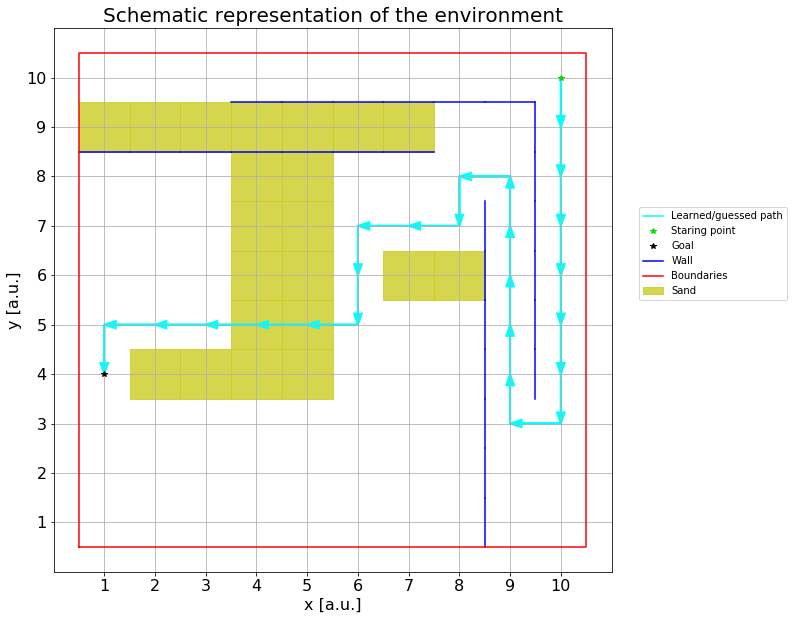

In [18]:
list_states = np.array(list_states)

plt.figure(figsize=(10,10))

plt.plot(list_states.T[0][0:2], list_states.T[1][0:2], '-', color="#00ffff",
         label="Learned/guessed path")
# Plotting trajectory as arrows
cont_arrow = 0
for p1,p2 in zip(list_states[:-1], list_states[1:]):
    if np.any(p1 != p2):
        if cont_arrow == 0:
            dx = p2[0] - p1[0]
            dy = p2[1] - p1[1]
            plt.arrow(p1[0], p1[1], dx, dy, color="#00ffff", shape='full', lw=2, label="Trajectory",
                      length_includes_head=True, head_width=0.15)
        else:
            dx = p2[0] - p1[0]
            dy = p2[1] - p1[1]
            plt.arrow(p1[0], p1[1], dx, dy, color="#00ffff", shape='full', lw=2,
                      length_includes_head=True, head_width=0.15)
    cont_arrow += 1

plt.plot(list_states.T[0][0], list_states.T[1][0], '*', color="#00dd00", label="Staring point")
plt.plot(goal[0], goal[1], '*', color="#000000", label="Goal")

# Plotting sand points
cont_sand = 0
for sand_p in sand:
    if cont_sand == 0:
        recta = plt.Rectangle( (sand_p[0]-0.5, sand_p[1]-0.5), 1, 1, color="#cccc22", alpha=0.8, label="Sand")
        plt.gca().add_patch(recta)
    else:
        recta = plt.Rectangle( (sand_p[0]-0.5, sand_p[1]-0.5), 1, 1, color="#cccc22", alpha=0.8)
        plt.gca().add_patch(recta)
    cont_sand += 1
        
cont = 0
for wall in walls:
    plot_wall(wall, cont)
    cont += 1

plt.xlim([-1,10])
plt.ylim([-1,10])

plt.xticks(np.arange(10), np.arange(10)+1, fontsize=16)
plt.yticks(np.arange(10), np.arange(10)+1, fontsize=16)

# Plotting bounaries
plt.plot([-0.5, 9.5, 9.5, -0.5, -0.5], [-0.5, -0.5, 9.5, 9.5, -0.5], color="#ff0000", label="Boundaries")

plt.title("Schematic representation of the environment", fontsize=20)

plt.xlabel("x [a.u.]", fontsize=16)
plt.ylabel("y [a.u.]", fontsize=16)

my_leg = plt.legend(loc=(1.05,0.5))
plt.grid()

plt.savefig(str(path_img+"/ENV2__walls_sand4.png"), bbox_inches='tight')

plt.show()